##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
!pip install -q tfds-nightly

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete00IL86/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete00IL86/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete00IL86/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


 The dataset `info` includes the encoder (a `tfds.deprecated.text.SubwordTextEncoder`).

In [6]:
encoder = info.features['text'].encoder

In [7]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

Compile the Keras model to configure the training process:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6921 - accuracy: 0.5625

  2/391 [..............................] - ETA: 22s - loss: 0.6918 - accuracy: 0.6250

  3/391 [..............................] - ETA: 28s - loss: 0.6920 - accuracy: 0.5938

  4/391 [..............................] - ETA: 31s - loss: 0.6920 - accuracy: 0.5781

  5/391 [..............................] - ETA: 32s - loss: 0.6923 - accuracy: 0.5656

  6/391 [..............................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5469

  7/391 [..............................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5357

  8/391 [..............................] - ETA: 30s - loss: 0.6925 - accuracy: 0.5410

  9/391 [..............................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5399

 10/391 [..............................] - ETA: 33s - loss: 0.6925 - accuracy: 0.5406

 11/391 [..............................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5341

 12/391 [..............................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5312

 13/391 [..............................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5325

 14/391 [>.............................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5301

 15/391 [>.............................] - ETA: 32s - loss: 0.6927 - accuracy: 0.5271

 16/391 [>.............................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5225

 17/391 [>.............................] - ETA: 33s - loss: 0.6927 - accuracy: 0.5239

 18/391 [>.............................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5182

 19/391 [>.............................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5181

 20/391 [>.............................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5164

 21/391 [>.............................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5149

 22/391 [>.............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5135

 23/391 [>.............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5143

 24/391 [>.............................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5163

 25/391 [>.............................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5150

 26/391 [>.............................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5168

 27/391 [=>............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5110

 28/391 [=>............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5112

 29/391 [=>............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5124

 30/391 [=>............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5109

 31/391 [=>............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5116

 32/391 [=>............................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5078

 33/391 [=>............................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5118

 34/391 [=>............................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5133

 35/391 [=>............................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5094

 36/391 [=>............................] - ETA: 32s - loss: 0.6930 - accuracy: 0.5087

 37/391 [=>............................] - ETA: 32s - loss: 0.6930 - accuracy: 0.5089

 38/391 [=>............................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5082

 39/391 [=>............................] - ETA: 32s - loss: 0.6930 - accuracy: 0.5092

 40/391 [==>...........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5074

 41/391 [==>...........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5046

 42/391 [==>...........................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5030

 43/391 [==>...........................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5036

 44/391 [==>...........................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5036

 45/391 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5038

 46/391 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5024

 47/391 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5033

 48/391 [==>...........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5052

 49/391 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5048

 50/391 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5041

 51/391 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5040

 52/391 [==>...........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5036

 53/391 [===>..........................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5044

 54/391 [===>..........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5052

 55/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5063

 56/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5053

 57/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5055

 58/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5070

 59/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5085

 60/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5078

 61/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5082

 62/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5076

 63/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5077

 64/391 [===>..........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5061

 65/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5060

 66/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5062

 67/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5054

 68/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5057

 69/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5048

 70/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5042

 71/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5042

 72/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5043

 73/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5045

 74/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5046

 75/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5040

 76/391 [====>.........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5039

 77/391 [====>.........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5043

 78/391 [====>.........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5040

 79/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5045

 80/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5049

 81/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5041

 82/391 [=====>........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5055

 83/391 [=====>........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5049

 84/391 [=====>........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5041

 85/391 [=====>........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5048

 86/391 [=====>........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5045

 87/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5036

 88/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5027

 89/391 [=====>........................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5021

 90/391 [=====>........................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5031

 91/391 [=====>........................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5026

 92/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5017

 93/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5013

 94/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5010

 95/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5002

 96/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4995

 97/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4998

 98/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4998

 99/391 [======>.......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4994

100/391 [======>.......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5000

101/391 [======>.......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4989

102/391 [======>.......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5000

103/391 [======>.......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5009

104/391 [======>.......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5000

105/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5007

106/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5009

107/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5022

108/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5020

109/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5029

110/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5023

111/391 [=======>......................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5021

112/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5022

113/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5029

114/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5034

115/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5045

116/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5039

117/391 [=======>......................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5039

118/391 [========>.....................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5034

119/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5037

120/391 [========>.....................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5025

121/391 [========>.....................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5021

122/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5028

123/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5033

124/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5030

125/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5031

126/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5031

127/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5026

128/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5021

129/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5017

130/391 [========>.....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5014

131/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5018

132/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5021

133/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5020

134/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5026

135/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5022

136/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5016

137/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5011

138/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5019

139/391 [=========>....................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5028

140/391 [=========>....................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5030

141/391 [=========>....................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5025

142/391 [=========>....................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5023

143/391 [=========>....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5026

144/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5030

145/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5034

146/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5036

147/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5040

148/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5043

149/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5048

150/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5050

151/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5049

152/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5045

153/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5045

154/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5046

155/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5045

156/391 [==========>...................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5053

157/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5053

158/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5054

159/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5059

160/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5060

161/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5059

162/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5058

163/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5056

164/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5055

165/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5055

166/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5054

167/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5056

168/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5048

169/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5050

170/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5047

171/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5047

172/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5048

173/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5042

174/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5044

175/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5043

176/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5044

177/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5041

178/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5043

179/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5035

180/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5034

181/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5038

182/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5043

183/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5042

184/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5039

185/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5035

186/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5032

187/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5038

188/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5036

189/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5030

190/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5032

191/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5034

192/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5031

193/391 [=============>................] - ETA: 18s - loss: 0.6928 - accuracy: 0.5032

194/391 [=============>................] - ETA: 18s - loss: 0.6928 - accuracy: 0.5031

195/391 [=============>................] - ETA: 18s - loss: 0.6928 - accuracy: 0.5029

196/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.5028

197/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.5029

198/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.5033

199/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.5032

200/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5034

201/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5038

202/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5042

203/391 [==============>...............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5041

204/391 [==============>...............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5041

205/391 [==============>...............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5038

206/391 [==============>...............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5038

207/391 [==============>...............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5035

208/391 [==============>...............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5031

209/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5031

210/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5031

211/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5027

212/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5022

213/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5021

214/391 [===============>..............] - ETA: 16s - loss: 0.6927 - accuracy: 0.5021

215/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5024

216/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5022

217/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5024

218/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5019

219/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5021

220/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5027

221/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5026

222/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5020

223/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5020

224/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5019

225/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5017

226/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5018

227/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5014

228/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5012

229/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5009

230/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5007

231/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5003

232/391 [================>.............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5005

233/391 [================>.............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5007

234/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5009

235/391 [=================>............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5015

236/391 [=================>............] - ETA: 14s - loss: 0.6926 - accuracy: 0.5014

237/391 [=================>............] - ETA: 14s - loss: 0.6926 - accuracy: 0.5014

238/391 [=================>............] - ETA: 14s - loss: 0.6926 - accuracy: 0.5015

239/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5018

240/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5017

241/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5019

242/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5019

243/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5019

244/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5019

245/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5019

246/391 [=================>............] - ETA: 13s - loss: 0.6925 - accuracy: 0.5021

247/391 [=================>............] - ETA: 13s - loss: 0.6925 - accuracy: 0.5020

248/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5017

249/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5020

250/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5019

251/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5017

252/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5014

253/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5013

254/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5007

255/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5006

256/391 [==================>...........] - ETA: 12s - loss: 0.6924 - accuracy: 0.5010

257/391 [==================>...........] - ETA: 12s - loss: 0.6924 - accuracy: 0.5007

258/391 [==================>...........] - ETA: 12s - loss: 0.6924 - accuracy: 0.5007

259/391 [==================>...........] - ETA: 12s - loss: 0.6924 - accuracy: 0.5002

260/391 [==================>...........] - ETA: 12s - loss: 0.6923 - accuracy: 0.5005

261/391 [===================>..........] - ETA: 12s - loss: 0.6923 - accuracy: 0.5004

262/391 [===================>..........] - ETA: 12s - loss: 0.6923 - accuracy: 0.5008

263/391 [===================>..........] - ETA: 12s - loss: 0.6923 - accuracy: 0.5004

264/391 [===================>..........] - ETA: 12s - loss: 0.6923 - accuracy: 0.4997

265/391 [===================>..........] - ETA: 12s - loss: 0.6923 - accuracy: 0.4999

266/391 [===================>..........] - ETA: 12s - loss: 0.6923 - accuracy: 0.4999

267/391 [===================>..........] - ETA: 11s - loss: 0.6922 - accuracy: 0.5001

268/391 [===================>..........] - ETA: 11s - loss: 0.6922 - accuracy: 0.5002

269/391 [===================>..........] - ETA: 11s - loss: 0.6922 - accuracy: 0.5002

270/391 [===================>..........] - ETA: 11s - loss: 0.6921 - accuracy: 0.5001

271/391 [===================>..........] - ETA: 11s - loss: 0.6921 - accuracy: 0.5001

272/391 [===================>..........] - ETA: 11s - loss: 0.6921 - accuracy: 0.5002

273/391 [===================>..........] - ETA: 11s - loss: 0.6921 - accuracy: 0.4999

274/391 [====================>.........] - ETA: 11s - loss: 0.6921 - accuracy: 0.5001

275/391 [====================>.........] - ETA: 11s - loss: 0.6921 - accuracy: 0.4999

276/391 [====================>.........] - ETA: 11s - loss: 0.6920 - accuracy: 0.5003

277/391 [====================>.........] - ETA: 10s - loss: 0.6920 - accuracy: 0.5003

278/391 [====================>.........] - ETA: 10s - loss: 0.6919 - accuracy: 0.5001

279/391 [====================>.........] - ETA: 10s - loss: 0.6918 - accuracy: 0.5002

280/391 [====================>.........] - ETA: 10s - loss: 0.6918 - accuracy: 0.4999

281/391 [====================>.........] - ETA: 10s - loss: 0.6918 - accuracy: 0.4999

282/391 [====================>.........] - ETA: 10s - loss: 0.6917 - accuracy: 0.5002

283/391 [====================>.........] - ETA: 10s - loss: 0.6916 - accuracy: 0.5008

284/391 [====================>.........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5007

285/391 [====================>.........] - ETA: 10s - loss: 0.6914 - accuracy: 0.5010

286/391 [====================>.........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5007

287/391 [=====================>........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5004

288/391 [=====================>........] - ETA: 9s - loss: 0.6915 - accuracy: 0.5004 

289/391 [=====================>........] - ETA: 9s - loss: 0.6914 - accuracy: 0.5001

290/391 [=====================>........] - ETA: 9s - loss: 0.6913 - accuracy: 0.5003

291/391 [=====================>........] - ETA: 9s - loss: 0.6912 - accuracy: 0.5005

292/391 [=====================>........] - ETA: 9s - loss: 0.6912 - accuracy: 0.5001

293/391 [=====================>........] - ETA: 9s - loss: 0.6911 - accuracy: 0.4999

294/391 [=====================>........] - ETA: 9s - loss: 0.6910 - accuracy: 0.4998

295/391 [=====================>........] - ETA: 9s - loss: 0.6909 - accuracy: 0.4996

296/391 [=====================>........] - ETA: 9s - loss: 0.6908 - accuracy: 0.4997

297/391 [=====================>........] - ETA: 9s - loss: 0.6907 - accuracy: 0.4994

298/391 [=====================>........] - ETA: 8s - loss: 0.6906 - accuracy: 0.4995

299/391 [=====================>........] - ETA: 8s - loss: 0.6905 - accuracy: 0.4996

300/391 [======================>.......] - ETA: 8s - loss: 0.6904 - accuracy: 0.5000

301/391 [======================>.......] - ETA: 8s - loss: 0.6903 - accuracy: 0.5002

302/391 [======================>.......] - ETA: 8s - loss: 0.6902 - accuracy: 0.5009

303/391 [======================>.......] - ETA: 8s - loss: 0.6900 - accuracy: 0.5011

304/391 [======================>.......] - ETA: 8s - loss: 0.6898 - accuracy: 0.5012

305/391 [======================>.......] - ETA: 8s - loss: 0.6895 - accuracy: 0.5019

306/391 [======================>.......] - ETA: 8s - loss: 0.6893 - accuracy: 0.5021

307/391 [======================>.......] - ETA: 8s - loss: 0.6892 - accuracy: 0.5023

308/391 [======================>.......] - ETA: 8s - loss: 0.6890 - accuracy: 0.5027

309/391 [======================>.......] - ETA: 7s - loss: 0.6887 - accuracy: 0.5031

310/391 [======================>.......] - ETA: 7s - loss: 0.6886 - accuracy: 0.5033

311/391 [======================>.......] - ETA: 7s - loss: 0.6883 - accuracy: 0.5037

312/391 [======================>.......] - ETA: 7s - loss: 0.6881 - accuracy: 0.5042

313/391 [=======================>......] - ETA: 7s - loss: 0.6879 - accuracy: 0.5047

314/391 [=======================>......] - ETA: 7s - loss: 0.6879 - accuracy: 0.5052

315/391 [=======================>......] - ETA: 7s - loss: 0.6877 - accuracy: 0.5053

316/391 [=======================>......] - ETA: 7s - loss: 0.6874 - accuracy: 0.5059

317/391 [=======================>......] - ETA: 7s - loss: 0.6873 - accuracy: 0.5061

318/391 [=======================>......] - ETA: 7s - loss: 0.6871 - accuracy: 0.5066

319/391 [=======================>......] - ETA: 6s - loss: 0.6869 - accuracy: 0.5068

320/391 [=======================>......] - ETA: 6s - loss: 0.6866 - accuracy: 0.5067

321/391 [=======================>......] - ETA: 6s - loss: 0.6864 - accuracy: 0.5069

322/391 [=======================>......] - ETA: 6s - loss: 0.6861 - accuracy: 0.5077

323/391 [=======================>......] - ETA: 6s - loss: 0.6856 - accuracy: 0.5086

324/391 [=======================>......] - ETA: 6s - loss: 0.6851 - accuracy: 0.5095

325/391 [=======================>......] - ETA: 6s - loss: 0.6846 - accuracy: 0.5102

326/391 [========================>.....] - ETA: 6s - loss: 0.6843 - accuracy: 0.5108

327/391 [========================>.....] - ETA: 6s - loss: 0.6839 - accuracy: 0.5111

328/391 [========================>.....] - ETA: 6s - loss: 0.6834 - accuracy: 0.5122

329/391 [========================>.....] - ETA: 6s - loss: 0.6832 - accuracy: 0.5125

330/391 [========================>.....] - ETA: 5s - loss: 0.6831 - accuracy: 0.5125

331/391 [========================>.....] - ETA: 5s - loss: 0.6829 - accuracy: 0.5127

332/391 [========================>.....] - ETA: 5s - loss: 0.6825 - accuracy: 0.5130

333/391 [========================>.....] - ETA: 5s - loss: 0.6821 - accuracy: 0.5134

334/391 [========================>.....] - ETA: 5s - loss: 0.6819 - accuracy: 0.5134

335/391 [========================>.....] - ETA: 5s - loss: 0.6818 - accuracy: 0.5133

336/391 [========================>.....] - ETA: 5s - loss: 0.6812 - accuracy: 0.5140

337/391 [========================>.....] - ETA: 5s - loss: 0.6808 - accuracy: 0.5143

338/391 [========================>.....] - ETA: 5s - loss: 0.6805 - accuracy: 0.5151

339/391 [=========================>....] - ETA: 5s - loss: 0.6805 - accuracy: 0.5157

340/391 [=========================>....] - ETA: 4s - loss: 0.6801 - accuracy: 0.5163

341/391 [=========================>....] - ETA: 4s - loss: 0.6798 - accuracy: 0.5170

342/391 [=========================>....] - ETA: 4s - loss: 0.6794 - accuracy: 0.5176

343/391 [=========================>....] - ETA: 4s - loss: 0.6793 - accuracy: 0.5181

344/391 [=========================>....] - ETA: 4s - loss: 0.6787 - accuracy: 0.5189

345/391 [=========================>....] - ETA: 4s - loss: 0.6785 - accuracy: 0.5192

346/391 [=========================>....] - ETA: 4s - loss: 0.6779 - accuracy: 0.5198

347/391 [=========================>....] - ETA: 4s - loss: 0.6776 - accuracy: 0.5199

348/391 [=========================>....] - ETA: 4s - loss: 0.6773 - accuracy: 0.5203

349/391 [=========================>....] - ETA: 4s - loss: 0.6773 - accuracy: 0.5201

350/391 [=========================>....] - ETA: 3s - loss: 0.6770 - accuracy: 0.5204

351/391 [=========================>....] - ETA: 3s - loss: 0.6766 - accuracy: 0.5208

352/391 [==========================>...] - ETA: 3s - loss: 0.6765 - accuracy: 0.5208

353/391 [==========================>...] - ETA: 3s - loss: 0.6762 - accuracy: 0.5212

354/391 [==========================>...] - ETA: 3s - loss: 0.6759 - accuracy: 0.5214

355/391 [==========================>...] - ETA: 3s - loss: 0.6758 - accuracy: 0.5216

356/391 [==========================>...] - ETA: 3s - loss: 0.6754 - accuracy: 0.5221

357/391 [==========================>...] - ETA: 3s - loss: 0.6751 - accuracy: 0.5226

358/391 [==========================>...] - ETA: 3s - loss: 0.6747 - accuracy: 0.5235

359/391 [==========================>...] - ETA: 3s - loss: 0.6745 - accuracy: 0.5239

360/391 [==========================>...] - ETA: 3s - loss: 0.6740 - accuracy: 0.5246

361/391 [==========================>...] - ETA: 2s - loss: 0.6736 - accuracy: 0.5252

362/391 [==========================>...] - ETA: 2s - loss: 0.6734 - accuracy: 0.5257

363/391 [==========================>...] - ETA: 2s - loss: 0.6729 - accuracy: 0.5263

364/391 [==========================>...] - ETA: 2s - loss: 0.6725 - accuracy: 0.5268

365/391 [===========================>..] - ETA: 2s - loss: 0.6723 - accuracy: 0.5273

366/391 [===========================>..] - ETA: 2s - loss: 0.6718 - accuracy: 0.5279

367/391 [===========================>..] - ETA: 2s - loss: 0.6713 - accuracy: 0.5285

368/391 [===========================>..] - ETA: 2s - loss: 0.6707 - accuracy: 0.5292

369/391 [===========================>..] - ETA: 2s - loss: 0.6702 - accuracy: 0.5298

370/391 [===========================>..] - ETA: 2s - loss: 0.6697 - accuracy: 0.5304

371/391 [===========================>..] - ETA: 1s - loss: 0.6695 - accuracy: 0.5309

372/391 [===========================>..] - ETA: 1s - loss: 0.6692 - accuracy: 0.5313

373/391 [===========================>..] - ETA: 1s - loss: 0.6687 - accuracy: 0.5318

374/391 [===========================>..] - ETA: 1s - loss: 0.6684 - accuracy: 0.5323

375/391 [===========================>..] - ETA: 1s - loss: 0.6679 - accuracy: 0.5330

376/391 [===========================>..] - ETA: 1s - loss: 0.6674 - accuracy: 0.5334

377/391 [===========================>..] - ETA: 1s - loss: 0.6669 - accuracy: 0.5340

378/391 [============================>.] - ETA: 1s - loss: 0.6665 - accuracy: 0.5343

379/391 [============================>.] - ETA: 1s - loss: 0.6660 - accuracy: 0.5347

380/391 [============================>.] - ETA: 1s - loss: 0.6656 - accuracy: 0.5353

381/391 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.5356

382/391 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.5360

383/391 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.5368

384/391 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.5371

385/391 [============================>.] - ETA: 0s - loss: 0.6638 - accuracy: 0.5378

386/391 [============================>.] - ETA: 0s - loss: 0.6635 - accuracy: 0.5383

387/391 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.5390

388/391 [============================>.] - ETA: 0s - loss: 0.6626 - accuracy: 0.5396

389/391 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.5402

390/391 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.5408

391/391 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.5410

391/391 [==============================] - 40s 102ms/step - loss: 0.6614 - accuracy: 0.5410 - val_loss: 0.4947 - val_accuracy: 0.7391


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.5198 - accuracy: 0.6875

  2/391 [..............................] - ETA: 22s - loss: 0.4765 - accuracy: 0.7344

  3/391 [..............................] - ETA: 23s - loss: 0.4713 - accuracy: 0.7292

  4/391 [..............................] - ETA: 28s - loss: 0.4621 - accuracy: 0.7305

  5/391 [..............................] - ETA: 31s - loss: 0.4463 - accuracy: 0.7437

  6/391 [..............................] - ETA: 31s - loss: 0.4675 - accuracy: 0.7344

  7/391 [..............................] - ETA: 31s - loss: 0.4749 - accuracy: 0.7232

  8/391 [..............................] - ETA: 32s - loss: 0.4734 - accuracy: 0.7324

  9/391 [..............................] - ETA: 32s - loss: 0.4641 - accuracy: 0.7483

 10/391 [..............................] - ETA: 31s - loss: 0.4644 - accuracy: 0.7516

 11/391 [..............................] - ETA: 31s - loss: 0.4658 - accuracy: 0.7571

 12/391 [..............................] - ETA: 31s - loss: 0.4627 - accuracy: 0.7656

 13/391 [..............................] - ETA: 32s - loss: 0.4615 - accuracy: 0.7704

 14/391 [>.............................] - ETA: 33s - loss: 0.4562 - accuracy: 0.7768

 15/391 [>.............................] - ETA: 32s - loss: 0.4532 - accuracy: 0.7760

 16/391 [>.............................] - ETA: 32s - loss: 0.4534 - accuracy: 0.7754

 17/391 [>.............................] - ETA: 32s - loss: 0.4524 - accuracy: 0.7748

 18/391 [>.............................] - ETA: 32s - loss: 0.4467 - accuracy: 0.7795

 19/391 [>.............................] - ETA: 32s - loss: 0.4502 - accuracy: 0.7780

 20/391 [>.............................] - ETA: 32s - loss: 0.4484 - accuracy: 0.7797

 21/391 [>.............................] - ETA: 33s - loss: 0.4440 - accuracy: 0.7798

 22/391 [>.............................] - ETA: 33s - loss: 0.4424 - accuracy: 0.7812

 23/391 [>.............................] - ETA: 33s - loss: 0.4412 - accuracy: 0.7833

 24/391 [>.............................] - ETA: 32s - loss: 0.4393 - accuracy: 0.7852

 25/391 [>.............................] - ETA: 32s - loss: 0.4383 - accuracy: 0.7869

 26/391 [>.............................] - ETA: 33s - loss: 0.4368 - accuracy: 0.7903

 27/391 [=>............................] - ETA: 33s - loss: 0.4380 - accuracy: 0.7917

 28/391 [=>............................] - ETA: 33s - loss: 0.4398 - accuracy: 0.7919

 29/391 [=>............................] - ETA: 33s - loss: 0.4406 - accuracy: 0.7909

 30/391 [=>............................] - ETA: 33s - loss: 0.4372 - accuracy: 0.7937

 31/391 [=>............................] - ETA: 32s - loss: 0.4378 - accuracy: 0.7918

 32/391 [=>............................] - ETA: 32s - loss: 0.4356 - accuracy: 0.7944

 33/391 [=>............................] - ETA: 32s - loss: 0.4315 - accuracy: 0.7964

 34/391 [=>............................] - ETA: 32s - loss: 0.4316 - accuracy: 0.7969

 35/391 [=>............................] - ETA: 31s - loss: 0.4323 - accuracy: 0.7960

 36/391 [=>............................] - ETA: 31s - loss: 0.4359 - accuracy: 0.7938

 37/391 [=>............................] - ETA: 32s - loss: 0.4319 - accuracy: 0.7969

 38/391 [=>............................] - ETA: 31s - loss: 0.4333 - accuracy: 0.7961

 39/391 [=>............................] - ETA: 32s - loss: 0.4366 - accuracy: 0.7941

 40/391 [==>...........................] - ETA: 31s - loss: 0.4357 - accuracy: 0.7934

 41/391 [==>...........................] - ETA: 31s - loss: 0.4323 - accuracy: 0.7961

 42/391 [==>...........................] - ETA: 31s - loss: 0.4302 - accuracy: 0.7961

 43/391 [==>...........................] - ETA: 31s - loss: 0.4302 - accuracy: 0.7969

 44/391 [==>...........................] - ETA: 32s - loss: 0.4308 - accuracy: 0.7958

 45/391 [==>...........................] - ETA: 33s - loss: 0.4316 - accuracy: 0.7955

 46/391 [==>...........................] - ETA: 33s - loss: 0.4323 - accuracy: 0.7928

 47/391 [==>...........................] - ETA: 32s - loss: 0.4299 - accuracy: 0.7949

 48/391 [==>...........................] - ETA: 32s - loss: 0.4289 - accuracy: 0.7959

 49/391 [==>...........................] - ETA: 32s - loss: 0.4273 - accuracy: 0.7978

 50/391 [==>...........................] - ETA: 32s - loss: 0.4265 - accuracy: 0.7994

 51/391 [==>...........................] - ETA: 32s - loss: 0.4258 - accuracy: 0.8006

 52/391 [==>...........................] - ETA: 32s - loss: 0.4244 - accuracy: 0.8014

 53/391 [===>..........................] - ETA: 32s - loss: 0.4252 - accuracy: 0.8013

 54/391 [===>..........................] - ETA: 32s - loss: 0.4256 - accuracy: 0.8009

 55/391 [===>..........................] - ETA: 32s - loss: 0.4235 - accuracy: 0.8026

 56/391 [===>..........................] - ETA: 32s - loss: 0.4230 - accuracy: 0.8022

 57/391 [===>..........................] - ETA: 32s - loss: 0.4210 - accuracy: 0.8018

 58/391 [===>..........................] - ETA: 32s - loss: 0.4207 - accuracy: 0.8023

 59/391 [===>..........................] - ETA: 32s - loss: 0.4177 - accuracy: 0.8038

 60/391 [===>..........................] - ETA: 32s - loss: 0.4151 - accuracy: 0.8047

 61/391 [===>..........................] - ETA: 32s - loss: 0.4144 - accuracy: 0.8053

 62/391 [===>..........................] - ETA: 31s - loss: 0.4132 - accuracy: 0.8062

 63/391 [===>..........................] - ETA: 31s - loss: 0.4115 - accuracy: 0.8073

 64/391 [===>..........................] - ETA: 31s - loss: 0.4092 - accuracy: 0.8088

 65/391 [===>..........................] - ETA: 31s - loss: 0.4080 - accuracy: 0.8099

 66/391 [====>.........................] - ETA: 31s - loss: 0.4085 - accuracy: 0.8089

 67/391 [====>.........................] - ETA: 31s - loss: 0.4089 - accuracy: 0.8078

 68/391 [====>.........................] - ETA: 31s - loss: 0.4091 - accuracy: 0.8079

 69/391 [====>.........................] - ETA: 31s - loss: 0.4079 - accuracy: 0.8096

 70/391 [====>.........................] - ETA: 31s - loss: 0.4081 - accuracy: 0.8087

 71/391 [====>.........................] - ETA: 31s - loss: 0.4072 - accuracy: 0.8092

 72/391 [====>.........................] - ETA: 30s - loss: 0.4078 - accuracy: 0.8084

 73/391 [====>.........................] - ETA: 30s - loss: 0.4064 - accuracy: 0.8097

 74/391 [====>.........................] - ETA: 30s - loss: 0.4060 - accuracy: 0.8098

 75/391 [====>.........................] - ETA: 30s - loss: 0.4056 - accuracy: 0.8104

 76/391 [====>.........................] - ETA: 30s - loss: 0.4073 - accuracy: 0.8098

 77/391 [====>.........................] - ETA: 30s - loss: 0.4073 - accuracy: 0.8095

 78/391 [====>.........................] - ETA: 30s - loss: 0.4070 - accuracy: 0.8099

 79/391 [=====>........................] - ETA: 30s - loss: 0.4064 - accuracy: 0.8103

 80/391 [=====>........................] - ETA: 30s - loss: 0.4058 - accuracy: 0.8105

 81/391 [=====>........................] - ETA: 29s - loss: 0.4059 - accuracy: 0.8110

 82/391 [=====>........................] - ETA: 29s - loss: 0.4059 - accuracy: 0.8102

 83/391 [=====>........................] - ETA: 29s - loss: 0.4053 - accuracy: 0.8102

 84/391 [=====>........................] - ETA: 29s - loss: 0.4065 - accuracy: 0.8095

 85/391 [=====>........................] - ETA: 29s - loss: 0.4049 - accuracy: 0.8108

 86/391 [=====>........................] - ETA: 29s - loss: 0.4045 - accuracy: 0.8112

 87/391 [=====>........................] - ETA: 29s - loss: 0.4040 - accuracy: 0.8114

 88/391 [=====>........................] - ETA: 29s - loss: 0.4038 - accuracy: 0.8118

 89/391 [=====>........................] - ETA: 29s - loss: 0.4021 - accuracy: 0.8125

 90/391 [=====>........................] - ETA: 29s - loss: 0.4027 - accuracy: 0.8127

 91/391 [=====>........................] - ETA: 29s - loss: 0.4018 - accuracy: 0.8130

 92/391 [======>.......................] - ETA: 29s - loss: 0.4009 - accuracy: 0.8135

 93/391 [======>.......................] - ETA: 29s - loss: 0.3992 - accuracy: 0.8145

 94/391 [======>.......................] - ETA: 28s - loss: 0.3991 - accuracy: 0.8147

 95/391 [======>.......................] - ETA: 28s - loss: 0.3990 - accuracy: 0.8150

 96/391 [======>.......................] - ETA: 28s - loss: 0.3985 - accuracy: 0.8156

 97/391 [======>.......................] - ETA: 28s - loss: 0.3975 - accuracy: 0.8160

 98/391 [======>.......................] - ETA: 28s - loss: 0.3959 - accuracy: 0.8170

 99/391 [======>.......................] - ETA: 28s - loss: 0.3947 - accuracy: 0.8177

100/391 [======>.......................] - ETA: 28s - loss: 0.3955 - accuracy: 0.8175

101/391 [======>.......................] - ETA: 28s - loss: 0.3940 - accuracy: 0.8187

102/391 [======>.......................] - ETA: 28s - loss: 0.3947 - accuracy: 0.8182

103/391 [======>.......................] - ETA: 27s - loss: 0.3950 - accuracy: 0.8181

104/391 [======>.......................] - ETA: 27s - loss: 0.3932 - accuracy: 0.8194

105/391 [=======>......................] - ETA: 27s - loss: 0.3933 - accuracy: 0.8196

106/391 [=======>......................] - ETA: 27s - loss: 0.3921 - accuracy: 0.8202

107/391 [=======>......................] - ETA: 27s - loss: 0.3924 - accuracy: 0.8195

108/391 [=======>......................] - ETA: 27s - loss: 0.3919 - accuracy: 0.8197

109/391 [=======>......................] - ETA: 27s - loss: 0.3917 - accuracy: 0.8190

110/391 [=======>......................] - ETA: 27s - loss: 0.3909 - accuracy: 0.8197

111/391 [=======>......................] - ETA: 26s - loss: 0.3904 - accuracy: 0.8201

112/391 [=======>......................] - ETA: 26s - loss: 0.3897 - accuracy: 0.8206

113/391 [=======>......................] - ETA: 26s - loss: 0.3896 - accuracy: 0.8211

114/391 [=======>......................] - ETA: 26s - loss: 0.3900 - accuracy: 0.8207

115/391 [=======>......................] - ETA: 26s - loss: 0.3901 - accuracy: 0.8205

116/391 [=======>......................] - ETA: 26s - loss: 0.3890 - accuracy: 0.8215

117/391 [=======>......................] - ETA: 26s - loss: 0.3887 - accuracy: 0.8218

118/391 [========>.....................] - ETA: 26s - loss: 0.3889 - accuracy: 0.8214

119/391 [========>.....................] - ETA: 26s - loss: 0.3885 - accuracy: 0.8214

120/391 [========>.....................] - ETA: 26s - loss: 0.3891 - accuracy: 0.8214

121/391 [========>.....................] - ETA: 26s - loss: 0.3878 - accuracy: 0.8224

122/391 [========>.....................] - ETA: 26s - loss: 0.3876 - accuracy: 0.8229

123/391 [========>.....................] - ETA: 25s - loss: 0.3869 - accuracy: 0.8233

124/391 [========>.....................] - ETA: 25s - loss: 0.3863 - accuracy: 0.8236

125/391 [========>.....................] - ETA: 25s - loss: 0.3863 - accuracy: 0.8232

126/391 [========>.....................] - ETA: 25s - loss: 0.3859 - accuracy: 0.8234

127/391 [========>.....................] - ETA: 25s - loss: 0.3853 - accuracy: 0.8239

128/391 [========>.....................] - ETA: 25s - loss: 0.3849 - accuracy: 0.8241

129/391 [========>.....................] - ETA: 25s - loss: 0.3847 - accuracy: 0.8241

130/391 [========>.....................] - ETA: 25s - loss: 0.3839 - accuracy: 0.8245

131/391 [=========>....................] - ETA: 25s - loss: 0.3835 - accuracy: 0.8250

132/391 [=========>....................] - ETA: 25s - loss: 0.3828 - accuracy: 0.8258

133/391 [=========>....................] - ETA: 25s - loss: 0.3825 - accuracy: 0.8260

134/391 [=========>....................] - ETA: 24s - loss: 0.3824 - accuracy: 0.8260

135/391 [=========>....................] - ETA: 24s - loss: 0.3822 - accuracy: 0.8264

136/391 [=========>....................] - ETA: 24s - loss: 0.3819 - accuracy: 0.8269

137/391 [=========>....................] - ETA: 24s - loss: 0.3816 - accuracy: 0.8272

138/391 [=========>....................] - ETA: 24s - loss: 0.3813 - accuracy: 0.8271

139/391 [=========>....................] - ETA: 24s - loss: 0.3805 - accuracy: 0.8275

140/391 [=========>....................] - ETA: 24s - loss: 0.3803 - accuracy: 0.8277

141/391 [=========>....................] - ETA: 24s - loss: 0.3798 - accuracy: 0.8280

142/391 [=========>....................] - ETA: 24s - loss: 0.3800 - accuracy: 0.8279

143/391 [=========>....................] - ETA: 24s - loss: 0.3806 - accuracy: 0.8275

144/391 [==========>...................] - ETA: 24s - loss: 0.3802 - accuracy: 0.8278

145/391 [==========>...................] - ETA: 24s - loss: 0.3791 - accuracy: 0.8283

146/391 [==========>...................] - ETA: 23s - loss: 0.3786 - accuracy: 0.8283

147/391 [==========>...................] - ETA: 23s - loss: 0.3780 - accuracy: 0.8287

148/391 [==========>...................] - ETA: 23s - loss: 0.3781 - accuracy: 0.8289

149/391 [==========>...................] - ETA: 23s - loss: 0.3777 - accuracy: 0.8294

150/391 [==========>...................] - ETA: 23s - loss: 0.3769 - accuracy: 0.8299

151/391 [==========>...................] - ETA: 23s - loss: 0.3769 - accuracy: 0.8298

152/391 [==========>...................] - ETA: 23s - loss: 0.3766 - accuracy: 0.8301

153/391 [==========>...................] - ETA: 23s - loss: 0.3774 - accuracy: 0.8297

154/391 [==========>...................] - ETA: 23s - loss: 0.3772 - accuracy: 0.8296

155/391 [==========>...................] - ETA: 23s - loss: 0.3769 - accuracy: 0.8298

156/391 [==========>...................] - ETA: 23s - loss: 0.3768 - accuracy: 0.8302

157/391 [===========>..................] - ETA: 23s - loss: 0.3762 - accuracy: 0.8304

158/391 [===========>..................] - ETA: 22s - loss: 0.3762 - accuracy: 0.8305

159/391 [===========>..................] - ETA: 22s - loss: 0.3758 - accuracy: 0.8306

160/391 [===========>..................] - ETA: 22s - loss: 0.3757 - accuracy: 0.8306

161/391 [===========>..................] - ETA: 22s - loss: 0.3753 - accuracy: 0.8308

162/391 [===========>..................] - ETA: 22s - loss: 0.3753 - accuracy: 0.8306

163/391 [===========>..................] - ETA: 22s - loss: 0.3749 - accuracy: 0.8307

164/391 [===========>..................] - ETA: 22s - loss: 0.3748 - accuracy: 0.8309

165/391 [===========>..................] - ETA: 22s - loss: 0.3751 - accuracy: 0.8305

166/391 [===========>..................] - ETA: 22s - loss: 0.3752 - accuracy: 0.8303

167/391 [===========>..................] - ETA: 22s - loss: 0.3745 - accuracy: 0.8305

168/391 [===========>..................] - ETA: 22s - loss: 0.3736 - accuracy: 0.8306

169/391 [===========>..................] - ETA: 21s - loss: 0.3734 - accuracy: 0.8306

170/391 [============>.................] - ETA: 21s - loss: 0.3729 - accuracy: 0.8307

171/391 [============>.................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8306

172/391 [============>.................] - ETA: 21s - loss: 0.3737 - accuracy: 0.8306

173/391 [============>.................] - ETA: 21s - loss: 0.3731 - accuracy: 0.8310

174/391 [============>.................] - ETA: 21s - loss: 0.3734 - accuracy: 0.8309

175/391 [============>.................] - ETA: 21s - loss: 0.3730 - accuracy: 0.8311

176/391 [============>.................] - ETA: 21s - loss: 0.3727 - accuracy: 0.8310

177/391 [============>.................] - ETA: 21s - loss: 0.3716 - accuracy: 0.8317

178/391 [============>.................] - ETA: 21s - loss: 0.3720 - accuracy: 0.8312

179/391 [============>.................] - ETA: 20s - loss: 0.3715 - accuracy: 0.8315

180/391 [============>.................] - ETA: 20s - loss: 0.3711 - accuracy: 0.8317

181/391 [============>.................] - ETA: 20s - loss: 0.3708 - accuracy: 0.8320

182/391 [============>.................] - ETA: 20s - loss: 0.3708 - accuracy: 0.8322

183/391 [=============>................] - ETA: 20s - loss: 0.3705 - accuracy: 0.8324

184/391 [=============>................] - ETA: 20s - loss: 0.3700 - accuracy: 0.8326

185/391 [=============>................] - ETA: 20s - loss: 0.3696 - accuracy: 0.8328

186/391 [=============>................] - ETA: 20s - loss: 0.3691 - accuracy: 0.8331

187/391 [=============>................] - ETA: 20s - loss: 0.3686 - accuracy: 0.8334

188/391 [=============>................] - ETA: 20s - loss: 0.3697 - accuracy: 0.8331

189/391 [=============>................] - ETA: 20s - loss: 0.3698 - accuracy: 0.8333

190/391 [=============>................] - ETA: 20s - loss: 0.3707 - accuracy: 0.8331

191/391 [=============>................] - ETA: 19s - loss: 0.3708 - accuracy: 0.8332

192/391 [=============>................] - ETA: 19s - loss: 0.3700 - accuracy: 0.8337

193/391 [=============>................] - ETA: 19s - loss: 0.3702 - accuracy: 0.8334

194/391 [=============>................] - ETA: 19s - loss: 0.3699 - accuracy: 0.8337

195/391 [=============>................] - ETA: 19s - loss: 0.3696 - accuracy: 0.8339

196/391 [==============>...............] - ETA: 19s - loss: 0.3697 - accuracy: 0.8339

197/391 [==============>...............] - ETA: 19s - loss: 0.3691 - accuracy: 0.8342

198/391 [==============>...............] - ETA: 19s - loss: 0.3686 - accuracy: 0.8341

199/391 [==============>...............] - ETA: 19s - loss: 0.3678 - accuracy: 0.8347

200/391 [==============>...............] - ETA: 19s - loss: 0.3676 - accuracy: 0.8348

201/391 [==============>...............] - ETA: 18s - loss: 0.3670 - accuracy: 0.8352

202/391 [==============>...............] - ETA: 18s - loss: 0.3669 - accuracy: 0.8353

203/391 [==============>...............] - ETA: 18s - loss: 0.3667 - accuracy: 0.8354

204/391 [==============>...............] - ETA: 18s - loss: 0.3670 - accuracy: 0.8352

205/391 [==============>...............] - ETA: 18s - loss: 0.3662 - accuracy: 0.8357

206/391 [==============>...............] - ETA: 18s - loss: 0.3664 - accuracy: 0.8353

207/391 [==============>...............] - ETA: 18s - loss: 0.3667 - accuracy: 0.8351

208/391 [==============>...............] - ETA: 18s - loss: 0.3666 - accuracy: 0.8353

209/391 [===============>..............] - ETA: 18s - loss: 0.3664 - accuracy: 0.8356

210/391 [===============>..............] - ETA: 18s - loss: 0.3660 - accuracy: 0.8361

211/391 [===============>..............] - ETA: 17s - loss: 0.3666 - accuracy: 0.8360

212/391 [===============>..............] - ETA: 17s - loss: 0.3667 - accuracy: 0.8361

213/391 [===============>..............] - ETA: 17s - loss: 0.3666 - accuracy: 0.8363

214/391 [===============>..............] - ETA: 17s - loss: 0.3663 - accuracy: 0.8367

215/391 [===============>..............] - ETA: 17s - loss: 0.3661 - accuracy: 0.8367

216/391 [===============>..............] - ETA: 17s - loss: 0.3662 - accuracy: 0.8365

217/391 [===============>..............] - ETA: 17s - loss: 0.3661 - accuracy: 0.8368

218/391 [===============>..............] - ETA: 17s - loss: 0.3660 - accuracy: 0.8368

219/391 [===============>..............] - ETA: 17s - loss: 0.3661 - accuracy: 0.8367

220/391 [===============>..............] - ETA: 17s - loss: 0.3665 - accuracy: 0.8365

221/391 [===============>..............] - ETA: 16s - loss: 0.3663 - accuracy: 0.8366

222/391 [================>.............] - ETA: 16s - loss: 0.3658 - accuracy: 0.8370

223/391 [================>.............] - ETA: 16s - loss: 0.3654 - accuracy: 0.8372

224/391 [================>.............] - ETA: 16s - loss: 0.3654 - accuracy: 0.8372

225/391 [================>.............] - ETA: 16s - loss: 0.3653 - accuracy: 0.8370

226/391 [================>.............] - ETA: 16s - loss: 0.3644 - accuracy: 0.8373

227/391 [================>.............] - ETA: 16s - loss: 0.3634 - accuracy: 0.8379

228/391 [================>.............] - ETA: 16s - loss: 0.3631 - accuracy: 0.8382

229/391 [================>.............] - ETA: 16s - loss: 0.3631 - accuracy: 0.8382

230/391 [================>.............] - ETA: 16s - loss: 0.3630 - accuracy: 0.8382

231/391 [================>.............] - ETA: 16s - loss: 0.3630 - accuracy: 0.8383

232/391 [================>.............] - ETA: 15s - loss: 0.3627 - accuracy: 0.8382

233/391 [================>.............] - ETA: 15s - loss: 0.3628 - accuracy: 0.8380

234/391 [================>.............] - ETA: 15s - loss: 0.3636 - accuracy: 0.8377

235/391 [=================>............] - ETA: 15s - loss: 0.3646 - accuracy: 0.8370

236/391 [=================>............] - ETA: 15s - loss: 0.3648 - accuracy: 0.8369

237/391 [=================>............] - ETA: 15s - loss: 0.3651 - accuracy: 0.8363

238/391 [=================>............] - ETA: 15s - loss: 0.3651 - accuracy: 0.8363

239/391 [=================>............] - ETA: 15s - loss: 0.3651 - accuracy: 0.8366

240/391 [=================>............] - ETA: 15s - loss: 0.3653 - accuracy: 0.8364

241/391 [=================>............] - ETA: 15s - loss: 0.3655 - accuracy: 0.8366

242/391 [=================>............] - ETA: 14s - loss: 0.3659 - accuracy: 0.8365

243/391 [=================>............] - ETA: 14s - loss: 0.3659 - accuracy: 0.8367

244/391 [=================>............] - ETA: 14s - loss: 0.3662 - accuracy: 0.8369

245/391 [=================>............] - ETA: 14s - loss: 0.3663 - accuracy: 0.8369

246/391 [=================>............] - ETA: 14s - loss: 0.3665 - accuracy: 0.8370

247/391 [=================>............] - ETA: 14s - loss: 0.3671 - accuracy: 0.8368

248/391 [==================>...........] - ETA: 14s - loss: 0.3666 - accuracy: 0.8369

249/391 [==================>...........] - ETA: 14s - loss: 0.3667 - accuracy: 0.8369

250/391 [==================>...........] - ETA: 14s - loss: 0.3673 - accuracy: 0.8367

251/391 [==================>...........] - ETA: 14s - loss: 0.3674 - accuracy: 0.8365

252/391 [==================>...........] - ETA: 14s - loss: 0.3671 - accuracy: 0.8364

253/391 [==================>...........] - ETA: 13s - loss: 0.3668 - accuracy: 0.8368

254/391 [==================>...........] - ETA: 13s - loss: 0.3665 - accuracy: 0.8368

255/391 [==================>...........] - ETA: 13s - loss: 0.3660 - accuracy: 0.8371

256/391 [==================>...........] - ETA: 13s - loss: 0.3654 - accuracy: 0.8374

257/391 [==================>...........] - ETA: 13s - loss: 0.3655 - accuracy: 0.8372

258/391 [==================>...........] - ETA: 13s - loss: 0.3649 - accuracy: 0.8376

259/391 [==================>...........] - ETA: 13s - loss: 0.3644 - accuracy: 0.8377

260/391 [==================>...........] - ETA: 13s - loss: 0.3639 - accuracy: 0.8379

261/391 [===================>..........] - ETA: 13s - loss: 0.3636 - accuracy: 0.8381

262/391 [===================>..........] - ETA: 12s - loss: 0.3632 - accuracy: 0.8383

263/391 [===================>..........] - ETA: 12s - loss: 0.3630 - accuracy: 0.8384

264/391 [===================>..........] - ETA: 12s - loss: 0.3624 - accuracy: 0.8386

265/391 [===================>..........] - ETA: 12s - loss: 0.3618 - accuracy: 0.8390

266/391 [===================>..........] - ETA: 12s - loss: 0.3616 - accuracy: 0.8391

267/391 [===================>..........] - ETA: 12s - loss: 0.3612 - accuracy: 0.8392

268/391 [===================>..........] - ETA: 12s - loss: 0.3609 - accuracy: 0.8393

269/391 [===================>..........] - ETA: 12s - loss: 0.3607 - accuracy: 0.8395

270/391 [===================>..........] - ETA: 12s - loss: 0.3606 - accuracy: 0.8396

271/391 [===================>..........] - ETA: 12s - loss: 0.3609 - accuracy: 0.8395

272/391 [===================>..........] - ETA: 11s - loss: 0.3609 - accuracy: 0.8396

273/391 [===================>..........] - ETA: 11s - loss: 0.3609 - accuracy: 0.8397

274/391 [====================>.........] - ETA: 11s - loss: 0.3604 - accuracy: 0.8398

275/391 [====================>.........] - ETA: 11s - loss: 0.3605 - accuracy: 0.8396

276/391 [====================>.........] - ETA: 11s - loss: 0.3603 - accuracy: 0.8399

277/391 [====================>.........] - ETA: 11s - loss: 0.3601 - accuracy: 0.8399

278/391 [====================>.........] - ETA: 11s - loss: 0.3600 - accuracy: 0.8398

279/391 [====================>.........] - ETA: 11s - loss: 0.3599 - accuracy: 0.8398

280/391 [====================>.........] - ETA: 11s - loss: 0.3595 - accuracy: 0.8400

281/391 [====================>.........] - ETA: 11s - loss: 0.3593 - accuracy: 0.8399

282/391 [====================>.........] - ETA: 10s - loss: 0.3588 - accuracy: 0.8403

283/391 [====================>.........] - ETA: 10s - loss: 0.3586 - accuracy: 0.8406

284/391 [====================>.........] - ETA: 10s - loss: 0.3583 - accuracy: 0.8408

285/391 [====================>.........] - ETA: 10s - loss: 0.3585 - accuracy: 0.8406

286/391 [====================>.........] - ETA: 10s - loss: 0.3585 - accuracy: 0.8406

287/391 [=====================>........] - ETA: 10s - loss: 0.3586 - accuracy: 0.8407

288/391 [=====================>........] - ETA: 10s - loss: 0.3586 - accuracy: 0.8405

289/391 [=====================>........] - ETA: 10s - loss: 0.3581 - accuracy: 0.8406

290/391 [=====================>........] - ETA: 10s - loss: 0.3579 - accuracy: 0.8407

291/391 [=====================>........] - ETA: 10s - loss: 0.3584 - accuracy: 0.8406

292/391 [=====================>........] - ETA: 9s - loss: 0.3584 - accuracy: 0.8407 

293/391 [=====================>........] - ETA: 9s - loss: 0.3584 - accuracy: 0.8408

294/391 [=====================>........] - ETA: 9s - loss: 0.3584 - accuracy: 0.8408

295/391 [=====================>........] - ETA: 9s - loss: 0.3585 - accuracy: 0.8409

296/391 [=====================>........] - ETA: 9s - loss: 0.3584 - accuracy: 0.8409

297/391 [=====================>........] - ETA: 9s - loss: 0.3583 - accuracy: 0.8410

298/391 [=====================>........] - ETA: 9s - loss: 0.3584 - accuracy: 0.8408

299/391 [=====================>........] - ETA: 9s - loss: 0.3579 - accuracy: 0.8411

300/391 [======================>.......] - ETA: 9s - loss: 0.3575 - accuracy: 0.8413

301/391 [======================>.......] - ETA: 9s - loss: 0.3577 - accuracy: 0.8411

302/391 [======================>.......] - ETA: 8s - loss: 0.3576 - accuracy: 0.8411

303/391 [======================>.......] - ETA: 8s - loss: 0.3573 - accuracy: 0.8414

304/391 [======================>.......] - ETA: 8s - loss: 0.3570 - accuracy: 0.8416

305/391 [======================>.......] - ETA: 8s - loss: 0.3565 - accuracy: 0.8420

306/391 [======================>.......] - ETA: 8s - loss: 0.3563 - accuracy: 0.8421

307/391 [======================>.......] - ETA: 8s - loss: 0.3561 - accuracy: 0.8423

308/391 [======================>.......] - ETA: 8s - loss: 0.3557 - accuracy: 0.8425

309/391 [======================>.......] - ETA: 8s - loss: 0.3558 - accuracy: 0.8426

310/391 [======================>.......] - ETA: 8s - loss: 0.3554 - accuracy: 0.8428

311/391 [======================>.......] - ETA: 8s - loss: 0.3553 - accuracy: 0.8428

312/391 [======================>.......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8427

313/391 [=======================>......] - ETA: 7s - loss: 0.3559 - accuracy: 0.8427

314/391 [=======================>......] - ETA: 7s - loss: 0.3560 - accuracy: 0.8425

315/391 [=======================>......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8428

316/391 [=======================>......] - ETA: 7s - loss: 0.3553 - accuracy: 0.8431

317/391 [=======================>......] - ETA: 7s - loss: 0.3552 - accuracy: 0.8431

318/391 [=======================>......] - ETA: 7s - loss: 0.3552 - accuracy: 0.8431

319/391 [=======================>......] - ETA: 7s - loss: 0.3550 - accuracy: 0.8433

320/391 [=======================>......] - ETA: 7s - loss: 0.3550 - accuracy: 0.8432

321/391 [=======================>......] - ETA: 7s - loss: 0.3547 - accuracy: 0.8433

322/391 [=======================>......] - ETA: 6s - loss: 0.3545 - accuracy: 0.8433

323/391 [=======================>......] - ETA: 6s - loss: 0.3542 - accuracy: 0.8435

324/391 [=======================>......] - ETA: 6s - loss: 0.3541 - accuracy: 0.8436

325/391 [=======================>......] - ETA: 6s - loss: 0.3537 - accuracy: 0.8438

326/391 [========================>.....] - ETA: 6s - loss: 0.3537 - accuracy: 0.8439

327/391 [========================>.....] - ETA: 6s - loss: 0.3535 - accuracy: 0.8442

328/391 [========================>.....] - ETA: 6s - loss: 0.3534 - accuracy: 0.8444

329/391 [========================>.....] - ETA: 6s - loss: 0.3534 - accuracy: 0.8444

330/391 [========================>.....] - ETA: 6s - loss: 0.3538 - accuracy: 0.8441

331/391 [========================>.....] - ETA: 6s - loss: 0.3542 - accuracy: 0.8438

332/391 [========================>.....] - ETA: 5s - loss: 0.3540 - accuracy: 0.8438

333/391 [========================>.....] - ETA: 5s - loss: 0.3537 - accuracy: 0.8438

334/391 [========================>.....] - ETA: 5s - loss: 0.3536 - accuracy: 0.8436

335/391 [========================>.....] - ETA: 5s - loss: 0.3536 - accuracy: 0.8435

336/391 [========================>.....] - ETA: 5s - loss: 0.3535 - accuracy: 0.8434

337/391 [========================>.....] - ETA: 5s - loss: 0.3533 - accuracy: 0.8436

338/391 [========================>.....] - ETA: 5s - loss: 0.3536 - accuracy: 0.8434

339/391 [=========================>....] - ETA: 5s - loss: 0.3537 - accuracy: 0.8433

340/391 [=========================>....] - ETA: 5s - loss: 0.3539 - accuracy: 0.8432

341/391 [=========================>....] - ETA: 5s - loss: 0.3538 - accuracy: 0.8433

342/391 [=========================>....] - ETA: 4s - loss: 0.3540 - accuracy: 0.8433

343/391 [=========================>....] - ETA: 4s - loss: 0.3539 - accuracy: 0.8433

344/391 [=========================>....] - ETA: 4s - loss: 0.3536 - accuracy: 0.8436

345/391 [=========================>....] - ETA: 4s - loss: 0.3533 - accuracy: 0.8438

346/391 [=========================>....] - ETA: 4s - loss: 0.3533 - accuracy: 0.8438

347/391 [=========================>....] - ETA: 4s - loss: 0.3532 - accuracy: 0.8439

348/391 [=========================>....] - ETA: 4s - loss: 0.3531 - accuracy: 0.8440

349/391 [=========================>....] - ETA: 4s - loss: 0.3533 - accuracy: 0.8440

350/391 [=========================>....] - ETA: 4s - loss: 0.3530 - accuracy: 0.8441

351/391 [=========================>....] - ETA: 4s - loss: 0.3528 - accuracy: 0.8442

352/391 [==========================>...] - ETA: 3s - loss: 0.3524 - accuracy: 0.8444

353/391 [==========================>...] - ETA: 3s - loss: 0.3521 - accuracy: 0.8445

354/391 [==========================>...] - ETA: 3s - loss: 0.3526 - accuracy: 0.8443

355/391 [==========================>...] - ETA: 3s - loss: 0.3524 - accuracy: 0.8445

356/391 [==========================>...] - ETA: 3s - loss: 0.3523 - accuracy: 0.8445

357/391 [==========================>...] - ETA: 3s - loss: 0.3520 - accuracy: 0.8447

358/391 [==========================>...] - ETA: 3s - loss: 0.3518 - accuracy: 0.8449

359/391 [==========================>...] - ETA: 3s - loss: 0.3518 - accuracy: 0.8448

360/391 [==========================>...] - ETA: 3s - loss: 0.3517 - accuracy: 0.8449

361/391 [==========================>...] - ETA: 3s - loss: 0.3514 - accuracy: 0.8452

362/391 [==========================>...] - ETA: 2s - loss: 0.3515 - accuracy: 0.8452

363/391 [==========================>...] - ETA: 2s - loss: 0.3513 - accuracy: 0.8453

364/391 [==========================>...] - ETA: 2s - loss: 0.3515 - accuracy: 0.8453

365/391 [===========================>..] - ETA: 2s - loss: 0.3516 - accuracy: 0.8453

366/391 [===========================>..] - ETA: 2s - loss: 0.3514 - accuracy: 0.8454

367/391 [===========================>..] - ETA: 2s - loss: 0.3514 - accuracy: 0.8454

368/391 [===========================>..] - ETA: 2s - loss: 0.3513 - accuracy: 0.8453

369/391 [===========================>..] - ETA: 2s - loss: 0.3510 - accuracy: 0.8455

370/391 [===========================>..] - ETA: 2s - loss: 0.3507 - accuracy: 0.8457

371/391 [===========================>..] - ETA: 2s - loss: 0.3506 - accuracy: 0.8457

372/391 [===========================>..] - ETA: 1s - loss: 0.3502 - accuracy: 0.8459

373/391 [===========================>..] - ETA: 1s - loss: 0.3501 - accuracy: 0.8459

374/391 [===========================>..] - ETA: 1s - loss: 0.3497 - accuracy: 0.8461

375/391 [===========================>..] - ETA: 1s - loss: 0.3496 - accuracy: 0.8461

376/391 [===========================>..] - ETA: 1s - loss: 0.3495 - accuracy: 0.8461

377/391 [===========================>..] - ETA: 1s - loss: 0.3494 - accuracy: 0.8462

378/391 [============================>.] - ETA: 1s - loss: 0.3495 - accuracy: 0.8461

379/391 [============================>.] - ETA: 1s - loss: 0.3493 - accuracy: 0.8462

380/391 [============================>.] - ETA: 1s - loss: 0.3490 - accuracy: 0.8464

381/391 [============================>.] - ETA: 1s - loss: 0.3487 - accuracy: 0.8465

382/391 [============================>.] - ETA: 0s - loss: 0.3484 - accuracy: 0.8467

383/391 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8468

384/391 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.8470

385/391 [============================>.] - ETA: 0s - loss: 0.3480 - accuracy: 0.8472

386/391 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.8474

387/391 [============================>.] - ETA: 0s - loss: 0.3474 - accuracy: 0.8476

388/391 [============================>.] - ETA: 0s - loss: 0.3474 - accuracy: 0.8476

390/391 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.8478

391/391 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.8479

391/391 [==============================] - 40s 103ms/step - loss: 0.3468 - accuracy: 0.8479 - val_loss: 0.4052 - val_accuracy: 0.7807


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.3245 - accuracy: 0.8125

  2/391 [..............................] - ETA: 21s - loss: 0.3088 - accuracy: 0.8203

  3/391 [..............................] - ETA: 32s - loss: 0.2935 - accuracy: 0.8438

  4/391 [..............................] - ETA: 34s - loss: 0.3142 - accuracy: 0.8320

  5/391 [..............................] - ETA: 35s - loss: 0.3013 - accuracy: 0.8313

  6/391 [..............................] - ETA: 38s - loss: 0.2910 - accuracy: 0.8411

  7/391 [..............................] - ETA: 38s - loss: 0.2970 - accuracy: 0.8393

  8/391 [..............................] - ETA: 38s - loss: 0.2867 - accuracy: 0.8516

  9/391 [..............................] - ETA: 37s - loss: 0.2785 - accuracy: 0.8628

 10/391 [..............................] - ETA: 37s - loss: 0.2883 - accuracy: 0.8656

 11/391 [..............................] - ETA: 38s - loss: 0.2815 - accuracy: 0.8736

 12/391 [..............................] - ETA: 37s - loss: 0.2900 - accuracy: 0.8711

 13/391 [..............................] - ETA: 37s - loss: 0.2795 - accuracy: 0.8798

 14/391 [>.............................] - ETA: 36s - loss: 0.2739 - accuracy: 0.8828

 15/391 [>.............................] - ETA: 36s - loss: 0.2672 - accuracy: 0.8854

 16/391 [>.............................] - ETA: 35s - loss: 0.2678 - accuracy: 0.8867

 17/391 [>.............................] - ETA: 36s - loss: 0.2691 - accuracy: 0.8879

 18/391 [>.............................] - ETA: 36s - loss: 0.2673 - accuracy: 0.8898

 19/391 [>.............................] - ETA: 36s - loss: 0.2686 - accuracy: 0.8890

 20/391 [>.............................] - ETA: 36s - loss: 0.2649 - accuracy: 0.8922

 21/391 [>.............................] - ETA: 35s - loss: 0.2614 - accuracy: 0.8929

 22/391 [>.............................] - ETA: 35s - loss: 0.2614 - accuracy: 0.8913

 23/391 [>.............................] - ETA: 35s - loss: 0.2645 - accuracy: 0.8893

 24/391 [>.............................] - ETA: 35s - loss: 0.2594 - accuracy: 0.8926

 25/391 [>.............................] - ETA: 35s - loss: 0.2614 - accuracy: 0.8931

 26/391 [>.............................] - ETA: 35s - loss: 0.2600 - accuracy: 0.8936

 27/391 [=>............................] - ETA: 36s - loss: 0.2587 - accuracy: 0.8941

 28/391 [=>............................] - ETA: 36s - loss: 0.2643 - accuracy: 0.8895

 29/391 [=>............................] - ETA: 36s - loss: 0.2619 - accuracy: 0.8901

 30/391 [=>............................] - ETA: 36s - loss: 0.2633 - accuracy: 0.8906

 31/391 [=>............................] - ETA: 35s - loss: 0.2647 - accuracy: 0.8901

 32/391 [=>............................] - ETA: 37s - loss: 0.2658 - accuracy: 0.8887

 33/391 [=>............................] - ETA: 37s - loss: 0.2646 - accuracy: 0.8887

 34/391 [=>............................] - ETA: 36s - loss: 0.2642 - accuracy: 0.8888

 35/391 [=>............................] - ETA: 36s - loss: 0.2638 - accuracy: 0.8897

 36/391 [=>............................] - ETA: 36s - loss: 0.2640 - accuracy: 0.8885

 37/391 [=>............................] - ETA: 36s - loss: 0.2631 - accuracy: 0.8898

 38/391 [=>............................] - ETA: 36s - loss: 0.2639 - accuracy: 0.8890

 39/391 [=>............................] - ETA: 36s - loss: 0.2624 - accuracy: 0.8902

 40/391 [==>...........................] - ETA: 36s - loss: 0.2627 - accuracy: 0.8914

 41/391 [==>...........................] - ETA: 36s - loss: 0.2621 - accuracy: 0.8910

 42/391 [==>...........................] - ETA: 35s - loss: 0.2644 - accuracy: 0.8895

 43/391 [==>...........................] - ETA: 35s - loss: 0.2661 - accuracy: 0.8884

 44/391 [==>...........................] - ETA: 35s - loss: 0.2663 - accuracy: 0.8896

 45/391 [==>...........................] - ETA: 35s - loss: 0.2652 - accuracy: 0.8899

 46/391 [==>...........................] - ETA: 34s - loss: 0.2645 - accuracy: 0.8910

 47/391 [==>...........................] - ETA: 34s - loss: 0.2616 - accuracy: 0.8926

 48/391 [==>...........................] - ETA: 34s - loss: 0.2597 - accuracy: 0.8929

 49/391 [==>...........................] - ETA: 34s - loss: 0.2611 - accuracy: 0.8925

 50/391 [==>...........................] - ETA: 34s - loss: 0.2591 - accuracy: 0.8934

 51/391 [==>...........................] - ETA: 33s - loss: 0.2577 - accuracy: 0.8946

 52/391 [==>...........................] - ETA: 33s - loss: 0.2574 - accuracy: 0.8951

 53/391 [===>..........................] - ETA: 33s - loss: 0.2581 - accuracy: 0.8950

 54/391 [===>..........................] - ETA: 33s - loss: 0.2589 - accuracy: 0.8953

 55/391 [===>..........................] - ETA: 33s - loss: 0.2581 - accuracy: 0.8952

 56/391 [===>..........................] - ETA: 33s - loss: 0.2600 - accuracy: 0.8943

 57/391 [===>..........................] - ETA: 33s - loss: 0.2608 - accuracy: 0.8942

 58/391 [===>..........................] - ETA: 33s - loss: 0.2625 - accuracy: 0.8939

 59/391 [===>..........................] - ETA: 33s - loss: 0.2619 - accuracy: 0.8941

 60/391 [===>..........................] - ETA: 33s - loss: 0.2615 - accuracy: 0.8948

 61/391 [===>..........................] - ETA: 33s - loss: 0.2610 - accuracy: 0.8947

 62/391 [===>..........................] - ETA: 33s - loss: 0.2609 - accuracy: 0.8949

 63/391 [===>..........................] - ETA: 32s - loss: 0.2616 - accuracy: 0.8951

 64/391 [===>..........................] - ETA: 32s - loss: 0.2615 - accuracy: 0.8955

 65/391 [===>..........................] - ETA: 32s - loss: 0.2612 - accuracy: 0.8957

 66/391 [====>.........................] - ETA: 32s - loss: 0.2605 - accuracy: 0.8963

 67/391 [====>.........................] - ETA: 32s - loss: 0.2596 - accuracy: 0.8967

 68/391 [====>.........................] - ETA: 32s - loss: 0.2577 - accuracy: 0.8977

 69/391 [====>.........................] - ETA: 32s - loss: 0.2566 - accuracy: 0.8976

 70/391 [====>.........................] - ETA: 32s - loss: 0.2557 - accuracy: 0.8982

 71/391 [====>.........................] - ETA: 31s - loss: 0.2563 - accuracy: 0.8977

 72/391 [====>.........................] - ETA: 31s - loss: 0.2561 - accuracy: 0.8976

 73/391 [====>.........................] - ETA: 31s - loss: 0.2541 - accuracy: 0.8983

 74/391 [====>.........................] - ETA: 31s - loss: 0.2544 - accuracy: 0.8984

 75/391 [====>.........................] - ETA: 31s - loss: 0.2537 - accuracy: 0.8988

 76/391 [====>.........................] - ETA: 31s - loss: 0.2521 - accuracy: 0.8995

 77/391 [====>.........................] - ETA: 31s - loss: 0.2525 - accuracy: 0.8998

 78/391 [====>.........................] - ETA: 31s - loss: 0.2516 - accuracy: 0.9000

 79/391 [=====>........................] - ETA: 30s - loss: 0.2516 - accuracy: 0.9005

 80/391 [=====>........................] - ETA: 30s - loss: 0.2522 - accuracy: 0.8998

 81/391 [=====>........................] - ETA: 30s - loss: 0.2534 - accuracy: 0.8989

 82/391 [=====>........................] - ETA: 30s - loss: 0.2538 - accuracy: 0.8986

 83/391 [=====>........................] - ETA: 30s - loss: 0.2548 - accuracy: 0.8985

 84/391 [=====>........................] - ETA: 30s - loss: 0.2564 - accuracy: 0.8981

 85/391 [=====>........................] - ETA: 30s - loss: 0.2564 - accuracy: 0.8980

 86/391 [=====>........................] - ETA: 29s - loss: 0.2570 - accuracy: 0.8975

 87/391 [=====>........................] - ETA: 29s - loss: 0.2568 - accuracy: 0.8978

 88/391 [=====>........................] - ETA: 29s - loss: 0.2561 - accuracy: 0.8981

 89/391 [=====>........................] - ETA: 29s - loss: 0.2561 - accuracy: 0.8985

 90/391 [=====>........................] - ETA: 29s - loss: 0.2575 - accuracy: 0.8981

 91/391 [=====>........................] - ETA: 29s - loss: 0.2581 - accuracy: 0.8978

 92/391 [======>.......................] - ETA: 29s - loss: 0.2578 - accuracy: 0.8986

 93/391 [======>.......................] - ETA: 29s - loss: 0.2582 - accuracy: 0.8982

 94/391 [======>.......................] - ETA: 28s - loss: 0.2583 - accuracy: 0.8986

 95/391 [======>.......................] - ETA: 28s - loss: 0.2574 - accuracy: 0.8988

 96/391 [======>.......................] - ETA: 28s - loss: 0.2579 - accuracy: 0.8984

 97/391 [======>.......................] - ETA: 28s - loss: 0.2576 - accuracy: 0.8982

 98/391 [======>.......................] - ETA: 28s - loss: 0.2580 - accuracy: 0.8975

 99/391 [======>.......................] - ETA: 28s - loss: 0.2566 - accuracy: 0.8982

100/391 [======>.......................] - ETA: 28s - loss: 0.2563 - accuracy: 0.8981

101/391 [======>.......................] - ETA: 28s - loss: 0.2565 - accuracy: 0.8982

102/391 [======>.......................] - ETA: 28s - loss: 0.2564 - accuracy: 0.8983

103/391 [======>.......................] - ETA: 28s - loss: 0.2565 - accuracy: 0.8981

104/391 [======>.......................] - ETA: 28s - loss: 0.2564 - accuracy: 0.8981

105/391 [=======>......................] - ETA: 28s - loss: 0.2569 - accuracy: 0.8982

106/391 [=======>......................] - ETA: 27s - loss: 0.2559 - accuracy: 0.8986

107/391 [=======>......................] - ETA: 27s - loss: 0.2564 - accuracy: 0.8984

108/391 [=======>......................] - ETA: 27s - loss: 0.2570 - accuracy: 0.8976

109/391 [=======>......................] - ETA: 27s - loss: 0.2582 - accuracy: 0.8972

110/391 [=======>......................] - ETA: 27s - loss: 0.2578 - accuracy: 0.8974

111/391 [=======>......................] - ETA: 27s - loss: 0.2579 - accuracy: 0.8977

112/391 [=======>......................] - ETA: 27s - loss: 0.2580 - accuracy: 0.8977

113/391 [=======>......................] - ETA: 27s - loss: 0.2569 - accuracy: 0.8981

114/391 [=======>......................] - ETA: 27s - loss: 0.2560 - accuracy: 0.8984

115/391 [=======>......................] - ETA: 27s - loss: 0.2553 - accuracy: 0.8988

116/391 [=======>......................] - ETA: 27s - loss: 0.2552 - accuracy: 0.8990

117/391 [=======>......................] - ETA: 26s - loss: 0.2560 - accuracy: 0.8984

118/391 [========>.....................] - ETA: 26s - loss: 0.2556 - accuracy: 0.8984

119/391 [========>.....................] - ETA: 26s - loss: 0.2553 - accuracy: 0.8988

120/391 [========>.....................] - ETA: 26s - loss: 0.2551 - accuracy: 0.8992

121/391 [========>.....................] - ETA: 26s - loss: 0.2547 - accuracy: 0.8991

122/391 [========>.....................] - ETA: 26s - loss: 0.2540 - accuracy: 0.8993

123/391 [========>.....................] - ETA: 26s - loss: 0.2550 - accuracy: 0.8989

124/391 [========>.....................] - ETA: 26s - loss: 0.2553 - accuracy: 0.8988

125/391 [========>.....................] - ETA: 26s - loss: 0.2555 - accuracy: 0.8989

126/391 [========>.....................] - ETA: 25s - loss: 0.2560 - accuracy: 0.8988

127/391 [========>.....................] - ETA: 25s - loss: 0.2567 - accuracy: 0.8986

128/391 [========>.....................] - ETA: 25s - loss: 0.2562 - accuracy: 0.8989

129/391 [========>.....................] - ETA: 25s - loss: 0.2562 - accuracy: 0.8991

130/391 [========>.....................] - ETA: 25s - loss: 0.2559 - accuracy: 0.8993

131/391 [=========>....................] - ETA: 25s - loss: 0.2562 - accuracy: 0.8993

132/391 [=========>....................] - ETA: 25s - loss: 0.2555 - accuracy: 0.8996

133/391 [=========>....................] - ETA: 25s - loss: 0.2546 - accuracy: 0.8999

134/391 [=========>....................] - ETA: 25s - loss: 0.2535 - accuracy: 0.9005

135/391 [=========>....................] - ETA: 25s - loss: 0.2534 - accuracy: 0.9005

136/391 [=========>....................] - ETA: 25s - loss: 0.2535 - accuracy: 0.9007

137/391 [=========>....................] - ETA: 24s - loss: 0.2535 - accuracy: 0.9007

138/391 [=========>....................] - ETA: 24s - loss: 0.2531 - accuracy: 0.9007

139/391 [=========>....................] - ETA: 24s - loss: 0.2539 - accuracy: 0.9004

140/391 [=========>....................] - ETA: 24s - loss: 0.2545 - accuracy: 0.9001

141/391 [=========>....................] - ETA: 24s - loss: 0.2542 - accuracy: 0.8999

142/391 [=========>....................] - ETA: 24s - loss: 0.2544 - accuracy: 0.8995

143/391 [=========>....................] - ETA: 24s - loss: 0.2542 - accuracy: 0.8994

144/391 [==========>...................] - ETA: 24s - loss: 0.2542 - accuracy: 0.8995

145/391 [==========>...................] - ETA: 24s - loss: 0.2543 - accuracy: 0.8997

146/391 [==========>...................] - ETA: 24s - loss: 0.2549 - accuracy: 0.8995

147/391 [==========>...................] - ETA: 24s - loss: 0.2548 - accuracy: 0.8998

148/391 [==========>...................] - ETA: 23s - loss: 0.2550 - accuracy: 0.8997

149/391 [==========>...................] - ETA: 23s - loss: 0.2548 - accuracy: 0.9000

150/391 [==========>...................] - ETA: 23s - loss: 0.2554 - accuracy: 0.8994

151/391 [==========>...................] - ETA: 23s - loss: 0.2555 - accuracy: 0.8995

152/391 [==========>...................] - ETA: 23s - loss: 0.2557 - accuracy: 0.8993

153/391 [==========>...................] - ETA: 23s - loss: 0.2555 - accuracy: 0.8995

154/391 [==========>...................] - ETA: 23s - loss: 0.2554 - accuracy: 0.8994

155/391 [==========>...................] - ETA: 23s - loss: 0.2559 - accuracy: 0.8990

156/391 [==========>...................] - ETA: 23s - loss: 0.2552 - accuracy: 0.8993

157/391 [===========>..................] - ETA: 23s - loss: 0.2550 - accuracy: 0.8992

158/391 [===========>..................] - ETA: 23s - loss: 0.2549 - accuracy: 0.8992

159/391 [===========>..................] - ETA: 23s - loss: 0.2553 - accuracy: 0.8992

160/391 [===========>..................] - ETA: 22s - loss: 0.2550 - accuracy: 0.8993

161/391 [===========>..................] - ETA: 22s - loss: 0.2551 - accuracy: 0.8994

162/391 [===========>..................] - ETA: 22s - loss: 0.2553 - accuracy: 0.8993

163/391 [===========>..................] - ETA: 22s - loss: 0.2553 - accuracy: 0.8992

164/391 [===========>..................] - ETA: 22s - loss: 0.2554 - accuracy: 0.8991

165/391 [===========>..................] - ETA: 22s - loss: 0.2549 - accuracy: 0.8991

166/391 [===========>..................] - ETA: 22s - loss: 0.2550 - accuracy: 0.8992

167/391 [===========>..................] - ETA: 22s - loss: 0.2547 - accuracy: 0.8994

168/391 [===========>..................] - ETA: 22s - loss: 0.2551 - accuracy: 0.8994

169/391 [===========>..................] - ETA: 21s - loss: 0.2554 - accuracy: 0.8990

170/391 [============>.................] - ETA: 21s - loss: 0.2558 - accuracy: 0.8988

171/391 [============>.................] - ETA: 21s - loss: 0.2556 - accuracy: 0.8985

172/391 [============>.................] - ETA: 21s - loss: 0.2550 - accuracy: 0.8987

173/391 [============>.................] - ETA: 21s - loss: 0.2547 - accuracy: 0.8988

174/391 [============>.................] - ETA: 21s - loss: 0.2548 - accuracy: 0.8985

175/391 [============>.................] - ETA: 21s - loss: 0.2552 - accuracy: 0.8982

176/391 [============>.................] - ETA: 21s - loss: 0.2553 - accuracy: 0.8982

177/391 [============>.................] - ETA: 21s - loss: 0.2554 - accuracy: 0.8982

178/391 [============>.................] - ETA: 20s - loss: 0.2560 - accuracy: 0.8979

179/391 [============>.................] - ETA: 20s - loss: 0.2567 - accuracy: 0.8976

180/391 [============>.................] - ETA: 20s - loss: 0.2565 - accuracy: 0.8977

181/391 [============>.................] - ETA: 20s - loss: 0.2570 - accuracy: 0.8977

182/391 [============>.................] - ETA: 20s - loss: 0.2574 - accuracy: 0.8978

183/391 [=============>................] - ETA: 20s - loss: 0.2575 - accuracy: 0.8977

184/391 [=============>................] - ETA: 20s - loss: 0.2576 - accuracy: 0.8977

185/391 [=============>................] - ETA: 20s - loss: 0.2580 - accuracy: 0.8976

186/391 [=============>................] - ETA: 20s - loss: 0.2578 - accuracy: 0.8978

187/391 [=============>................] - ETA: 20s - loss: 0.2575 - accuracy: 0.8979

188/391 [=============>................] - ETA: 19s - loss: 0.2572 - accuracy: 0.8981

189/391 [=============>................] - ETA: 19s - loss: 0.2572 - accuracy: 0.8982

190/391 [=============>................] - ETA: 19s - loss: 0.2574 - accuracy: 0.8980

191/391 [=============>................] - ETA: 19s - loss: 0.2572 - accuracy: 0.8981

192/391 [=============>................] - ETA: 19s - loss: 0.2579 - accuracy: 0.8976

193/391 [=============>................] - ETA: 19s - loss: 0.2578 - accuracy: 0.8973

194/391 [=============>................] - ETA: 19s - loss: 0.2577 - accuracy: 0.8972

195/391 [=============>................] - ETA: 19s - loss: 0.2575 - accuracy: 0.8973

196/391 [==============>...............] - ETA: 19s - loss: 0.2571 - accuracy: 0.8975

197/391 [==============>...............] - ETA: 19s - loss: 0.2576 - accuracy: 0.8974

198/391 [==============>...............] - ETA: 18s - loss: 0.2580 - accuracy: 0.8973

199/391 [==============>...............] - ETA: 18s - loss: 0.2574 - accuracy: 0.8975

200/391 [==============>...............] - ETA: 18s - loss: 0.2568 - accuracy: 0.8978

201/391 [==============>...............] - ETA: 18s - loss: 0.2570 - accuracy: 0.8979

202/391 [==============>...............] - ETA: 18s - loss: 0.2574 - accuracy: 0.8977

203/391 [==============>...............] - ETA: 18s - loss: 0.2574 - accuracy: 0.8979

204/391 [==============>...............] - ETA: 18s - loss: 0.2574 - accuracy: 0.8980

205/391 [==============>...............] - ETA: 18s - loss: 0.2569 - accuracy: 0.8984

206/391 [==============>...............] - ETA: 18s - loss: 0.2564 - accuracy: 0.8985

207/391 [==============>...............] - ETA: 18s - loss: 0.2562 - accuracy: 0.8988

208/391 [==============>...............] - ETA: 17s - loss: 0.2564 - accuracy: 0.8987

209/391 [===============>..............] - ETA: 17s - loss: 0.2562 - accuracy: 0.8988

210/391 [===============>..............] - ETA: 17s - loss: 0.2560 - accuracy: 0.8991

211/391 [===============>..............] - ETA: 17s - loss: 0.2561 - accuracy: 0.8991

212/391 [===============>..............] - ETA: 17s - loss: 0.2557 - accuracy: 0.8993

213/391 [===============>..............] - ETA: 17s - loss: 0.2556 - accuracy: 0.8993

214/391 [===============>..............] - ETA: 17s - loss: 0.2559 - accuracy: 0.8994

215/391 [===============>..............] - ETA: 17s - loss: 0.2554 - accuracy: 0.8996

216/391 [===============>..............] - ETA: 17s - loss: 0.2555 - accuracy: 0.8996

217/391 [===============>..............] - ETA: 17s - loss: 0.2555 - accuracy: 0.8996

218/391 [===============>..............] - ETA: 16s - loss: 0.2551 - accuracy: 0.8997

219/391 [===============>..............] - ETA: 16s - loss: 0.2550 - accuracy: 0.8998

220/391 [===============>..............] - ETA: 16s - loss: 0.2549 - accuracy: 0.8999

221/391 [===============>..............] - ETA: 16s - loss: 0.2549 - accuracy: 0.9001

222/391 [================>.............] - ETA: 16s - loss: 0.2548 - accuracy: 0.9001

223/391 [================>.............] - ETA: 16s - loss: 0.2550 - accuracy: 0.9000

224/391 [================>.............] - ETA: 16s - loss: 0.2548 - accuracy: 0.9002

225/391 [================>.............] - ETA: 16s - loss: 0.2549 - accuracy: 0.9001

226/391 [================>.............] - ETA: 16s - loss: 0.2549 - accuracy: 0.9002

227/391 [================>.............] - ETA: 16s - loss: 0.2543 - accuracy: 0.9004

228/391 [================>.............] - ETA: 15s - loss: 0.2545 - accuracy: 0.9003

229/391 [================>.............] - ETA: 15s - loss: 0.2550 - accuracy: 0.8999

230/391 [================>.............] - ETA: 15s - loss: 0.2552 - accuracy: 0.8997

231/391 [================>.............] - ETA: 15s - loss: 0.2552 - accuracy: 0.8998

232/391 [================>.............] - ETA: 15s - loss: 0.2551 - accuracy: 0.8999

233/391 [================>.............] - ETA: 15s - loss: 0.2552 - accuracy: 0.8999

234/391 [================>.............] - ETA: 15s - loss: 0.2559 - accuracy: 0.8996

235/391 [=================>............] - ETA: 15s - loss: 0.2558 - accuracy: 0.8996

236/391 [=================>............] - ETA: 15s - loss: 0.2555 - accuracy: 0.8998

237/391 [=================>............] - ETA: 15s - loss: 0.2554 - accuracy: 0.8998

238/391 [=================>............] - ETA: 15s - loss: 0.2554 - accuracy: 0.8999

239/391 [=================>............] - ETA: 14s - loss: 0.2552 - accuracy: 0.8998

240/391 [=================>............] - ETA: 14s - loss: 0.2555 - accuracy: 0.8995

241/391 [=================>............] - ETA: 14s - loss: 0.2553 - accuracy: 0.8996

242/391 [=================>............] - ETA: 14s - loss: 0.2548 - accuracy: 0.8998

243/391 [=================>............] - ETA: 14s - loss: 0.2545 - accuracy: 0.8999

244/391 [=================>............] - ETA: 14s - loss: 0.2549 - accuracy: 0.8998

245/391 [=================>............] - ETA: 14s - loss: 0.2547 - accuracy: 0.8998

246/391 [=================>............] - ETA: 14s - loss: 0.2542 - accuracy: 0.8999

247/391 [=================>............] - ETA: 14s - loss: 0.2541 - accuracy: 0.9001

248/391 [==================>...........] - ETA: 14s - loss: 0.2542 - accuracy: 0.9001

249/391 [==================>...........] - ETA: 13s - loss: 0.2542 - accuracy: 0.9000

250/391 [==================>...........] - ETA: 13s - loss: 0.2546 - accuracy: 0.8999

251/391 [==================>...........] - ETA: 13s - loss: 0.2547 - accuracy: 0.8997

252/391 [==================>...........] - ETA: 13s - loss: 0.2545 - accuracy: 0.8999

253/391 [==================>...........] - ETA: 13s - loss: 0.2544 - accuracy: 0.8999

254/391 [==================>...........] - ETA: 13s - loss: 0.2542 - accuracy: 0.9000

255/391 [==================>...........] - ETA: 13s - loss: 0.2541 - accuracy: 0.9002

256/391 [==================>...........] - ETA: 13s - loss: 0.2539 - accuracy: 0.9003

257/391 [==================>...........] - ETA: 13s - loss: 0.2539 - accuracy: 0.9004

258/391 [==================>...........] - ETA: 13s - loss: 0.2539 - accuracy: 0.9003

259/391 [==================>...........] - ETA: 12s - loss: 0.2541 - accuracy: 0.9002

260/391 [==================>...........] - ETA: 12s - loss: 0.2539 - accuracy: 0.9003

261/391 [===================>..........] - ETA: 12s - loss: 0.2541 - accuracy: 0.9003

262/391 [===================>..........] - ETA: 12s - loss: 0.2544 - accuracy: 0.9003

263/391 [===================>..........] - ETA: 12s - loss: 0.2548 - accuracy: 0.9001

264/391 [===================>..........] - ETA: 12s - loss: 0.2546 - accuracy: 0.9001

265/391 [===================>..........] - ETA: 12s - loss: 0.2548 - accuracy: 0.9002

266/391 [===================>..........] - ETA: 12s - loss: 0.2555 - accuracy: 0.9000

267/391 [===================>..........] - ETA: 12s - loss: 0.2550 - accuracy: 0.9002

268/391 [===================>..........] - ETA: 12s - loss: 0.2550 - accuracy: 0.9001

269/391 [===================>..........] - ETA: 11s - loss: 0.2552 - accuracy: 0.9000

270/391 [===================>..........] - ETA: 11s - loss: 0.2557 - accuracy: 0.8996

271/391 [===================>..........] - ETA: 11s - loss: 0.2560 - accuracy: 0.8992

272/391 [===================>..........] - ETA: 11s - loss: 0.2565 - accuracy: 0.8990

273/391 [===================>..........] - ETA: 11s - loss: 0.2566 - accuracy: 0.8988

274/391 [====================>.........] - ETA: 11s - loss: 0.2572 - accuracy: 0.8983

275/391 [====================>.........] - ETA: 11s - loss: 0.2576 - accuracy: 0.8980

276/391 [====================>.........] - ETA: 11s - loss: 0.2575 - accuracy: 0.8981

277/391 [====================>.........] - ETA: 11s - loss: 0.2572 - accuracy: 0.8984

278/391 [====================>.........] - ETA: 11s - loss: 0.2571 - accuracy: 0.8985

279/391 [====================>.........] - ETA: 11s - loss: 0.2577 - accuracy: 0.8982

280/391 [====================>.........] - ETA: 10s - loss: 0.2577 - accuracy: 0.8984

281/391 [====================>.........] - ETA: 10s - loss: 0.2578 - accuracy: 0.8984

282/391 [====================>.........] - ETA: 10s - loss: 0.2577 - accuracy: 0.8984

283/391 [====================>.........] - ETA: 10s - loss: 0.2583 - accuracy: 0.8981

284/391 [====================>.........] - ETA: 10s - loss: 0.2580 - accuracy: 0.8983

285/391 [====================>.........] - ETA: 10s - loss: 0.2584 - accuracy: 0.8981

286/391 [====================>.........] - ETA: 10s - loss: 0.2590 - accuracy: 0.8979

287/391 [=====================>........] - ETA: 10s - loss: 0.2588 - accuracy: 0.8981

288/391 [=====================>........] - ETA: 10s - loss: 0.2588 - accuracy: 0.8982

289/391 [=====================>........] - ETA: 10s - loss: 0.2586 - accuracy: 0.8984

290/391 [=====================>........] - ETA: 9s - loss: 0.2586 - accuracy: 0.8984 

291/391 [=====================>........] - ETA: 9s - loss: 0.2583 - accuracy: 0.8984

292/391 [=====================>........] - ETA: 9s - loss: 0.2584 - accuracy: 0.8984

293/391 [=====================>........] - ETA: 9s - loss: 0.2586 - accuracy: 0.8984

294/391 [=====================>........] - ETA: 9s - loss: 0.2587 - accuracy: 0.8983

295/391 [=====================>........] - ETA: 9s - loss: 0.2589 - accuracy: 0.8980

296/391 [=====================>........] - ETA: 9s - loss: 0.2588 - accuracy: 0.8977

297/391 [=====================>........] - ETA: 9s - loss: 0.2589 - accuracy: 0.8976

298/391 [=====================>........] - ETA: 9s - loss: 0.2588 - accuracy: 0.8977

299/391 [=====================>........] - ETA: 9s - loss: 0.2585 - accuracy: 0.8978

300/391 [======================>.......] - ETA: 8s - loss: 0.2583 - accuracy: 0.8981

301/391 [======================>.......] - ETA: 8s - loss: 0.2582 - accuracy: 0.8982

302/391 [======================>.......] - ETA: 8s - loss: 0.2581 - accuracy: 0.8981

303/391 [======================>.......] - ETA: 8s - loss: 0.2580 - accuracy: 0.8981

304/391 [======================>.......] - ETA: 8s - loss: 0.2584 - accuracy: 0.8979

305/391 [======================>.......] - ETA: 8s - loss: 0.2585 - accuracy: 0.8978

306/391 [======================>.......] - ETA: 8s - loss: 0.2584 - accuracy: 0.8979

307/391 [======================>.......] - ETA: 8s - loss: 0.2581 - accuracy: 0.8980

308/391 [======================>.......] - ETA: 8s - loss: 0.2581 - accuracy: 0.8980

309/391 [======================>.......] - ETA: 8s - loss: 0.2583 - accuracy: 0.8977

310/391 [======================>.......] - ETA: 7s - loss: 0.2579 - accuracy: 0.8979

311/391 [======================>.......] - ETA: 7s - loss: 0.2583 - accuracy: 0.8979

312/391 [======================>.......] - ETA: 7s - loss: 0.2578 - accuracy: 0.8981

313/391 [=======================>......] - ETA: 7s - loss: 0.2576 - accuracy: 0.8983

314/391 [=======================>......] - ETA: 7s - loss: 0.2575 - accuracy: 0.8982

315/391 [=======================>......] - ETA: 7s - loss: 0.2573 - accuracy: 0.8983

316/391 [=======================>......] - ETA: 7s - loss: 0.2571 - accuracy: 0.8984

317/391 [=======================>......] - ETA: 7s - loss: 0.2568 - accuracy: 0.8986

318/391 [=======================>......] - ETA: 7s - loss: 0.2569 - accuracy: 0.8986

319/391 [=======================>......] - ETA: 7s - loss: 0.2566 - accuracy: 0.8987

320/391 [=======================>......] - ETA: 6s - loss: 0.2566 - accuracy: 0.8988

321/391 [=======================>......] - ETA: 6s - loss: 0.2563 - accuracy: 0.8989

322/391 [=======================>......] - ETA: 6s - loss: 0.2565 - accuracy: 0.8989

323/391 [=======================>......] - ETA: 6s - loss: 0.2562 - accuracy: 0.8989

324/391 [=======================>......] - ETA: 6s - loss: 0.2562 - accuracy: 0.8990

325/391 [=======================>......] - ETA: 6s - loss: 0.2565 - accuracy: 0.8989

326/391 [========================>.....] - ETA: 6s - loss: 0.2567 - accuracy: 0.8988

327/391 [========================>.....] - ETA: 6s - loss: 0.2567 - accuracy: 0.8989

328/391 [========================>.....] - ETA: 6s - loss: 0.2564 - accuracy: 0.8990

329/391 [========================>.....] - ETA: 6s - loss: 0.2563 - accuracy: 0.8990

330/391 [========================>.....] - ETA: 5s - loss: 0.2563 - accuracy: 0.8991

331/391 [========================>.....] - ETA: 5s - loss: 0.2560 - accuracy: 0.8991

332/391 [========================>.....] - ETA: 5s - loss: 0.2560 - accuracy: 0.8991

333/391 [========================>.....] - ETA: 5s - loss: 0.2561 - accuracy: 0.8990

334/391 [========================>.....] - ETA: 5s - loss: 0.2562 - accuracy: 0.8988

335/391 [========================>.....] - ETA: 5s - loss: 0.2564 - accuracy: 0.8988

336/391 [========================>.....] - ETA: 5s - loss: 0.2561 - accuracy: 0.8990

337/391 [========================>.....] - ETA: 5s - loss: 0.2558 - accuracy: 0.8991

338/391 [========================>.....] - ETA: 5s - loss: 0.2558 - accuracy: 0.8991

339/391 [=========================>....] - ETA: 5s - loss: 0.2558 - accuracy: 0.8992

340/391 [=========================>....] - ETA: 5s - loss: 0.2558 - accuracy: 0.8991

341/391 [=========================>....] - ETA: 4s - loss: 0.2558 - accuracy: 0.8992

342/391 [=========================>....] - ETA: 4s - loss: 0.2557 - accuracy: 0.8993

343/391 [=========================>....] - ETA: 4s - loss: 0.2557 - accuracy: 0.8993

344/391 [=========================>....] - ETA: 4s - loss: 0.2557 - accuracy: 0.8992

345/391 [=========================>....] - ETA: 4s - loss: 0.2555 - accuracy: 0.8992

346/391 [=========================>....] - ETA: 4s - loss: 0.2554 - accuracy: 0.8993

347/391 [=========================>....] - ETA: 4s - loss: 0.2552 - accuracy: 0.8994

348/391 [=========================>....] - ETA: 4s - loss: 0.2550 - accuracy: 0.8995

349/391 [=========================>....] - ETA: 4s - loss: 0.2550 - accuracy: 0.8994

350/391 [=========================>....] - ETA: 4s - loss: 0.2550 - accuracy: 0.8994

351/391 [=========================>....] - ETA: 3s - loss: 0.2548 - accuracy: 0.8995

352/391 [==========================>...] - ETA: 3s - loss: 0.2546 - accuracy: 0.8996

353/391 [==========================>...] - ETA: 3s - loss: 0.2548 - accuracy: 0.8994

354/391 [==========================>...] - ETA: 3s - loss: 0.2547 - accuracy: 0.8994

355/391 [==========================>...] - ETA: 3s - loss: 0.2546 - accuracy: 0.8994

356/391 [==========================>...] - ETA: 3s - loss: 0.2546 - accuracy: 0.8995

357/391 [==========================>...] - ETA: 3s - loss: 0.2548 - accuracy: 0.8995

358/391 [==========================>...] - ETA: 3s - loss: 0.2546 - accuracy: 0.8997

359/391 [==========================>...] - ETA: 3s - loss: 0.2547 - accuracy: 0.8996

360/391 [==========================>...] - ETA: 3s - loss: 0.2545 - accuracy: 0.8998

361/391 [==========================>...] - ETA: 2s - loss: 0.2542 - accuracy: 0.8999

362/391 [==========================>...] - ETA: 2s - loss: 0.2541 - accuracy: 0.8999

363/391 [==========================>...] - ETA: 2s - loss: 0.2540 - accuracy: 0.9000

364/391 [==========================>...] - ETA: 2s - loss: 0.2541 - accuracy: 0.9000

365/391 [===========================>..] - ETA: 2s - loss: 0.2541 - accuracy: 0.9000

366/391 [===========================>..] - ETA: 2s - loss: 0.2541 - accuracy: 0.9000

367/391 [===========================>..] - ETA: 2s - loss: 0.2540 - accuracy: 0.9001

368/391 [===========================>..] - ETA: 2s - loss: 0.2539 - accuracy: 0.9000

369/391 [===========================>..] - ETA: 2s - loss: 0.2534 - accuracy: 0.9002

370/391 [===========================>..] - ETA: 2s - loss: 0.2533 - accuracy: 0.9003

371/391 [===========================>..] - ETA: 1s - loss: 0.2534 - accuracy: 0.9002

372/391 [===========================>..] - ETA: 1s - loss: 0.2529 - accuracy: 0.9004

373/391 [===========================>..] - ETA: 1s - loss: 0.2531 - accuracy: 0.9005

374/391 [===========================>..] - ETA: 1s - loss: 0.2530 - accuracy: 0.9005

375/391 [===========================>..] - ETA: 1s - loss: 0.2531 - accuracy: 0.9005

376/391 [===========================>..] - ETA: 1s - loss: 0.2533 - accuracy: 0.9004

377/391 [===========================>..] - ETA: 1s - loss: 0.2532 - accuracy: 0.9004

378/391 [============================>.] - ETA: 1s - loss: 0.2528 - accuracy: 0.9006

379/391 [============================>.] - ETA: 1s - loss: 0.2530 - accuracy: 0.9005

380/391 [============================>.] - ETA: 1s - loss: 0.2529 - accuracy: 0.9005

381/391 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9005

382/391 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.9006

383/391 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9005

384/391 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.9006

385/391 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9008

386/391 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9007

387/391 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9007

388/391 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9007

389/391 [============================>.] - ETA: 0s - loss: 0.2525 - accuracy: 0.9007

390/391 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.9006

391/391 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9006

391/391 [==============================] - 40s 101ms/step - loss: 0.2525 - accuracy: 0.9006 - val_loss: 0.3529 - val_accuracy: 0.8646


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.1728 - accuracy: 0.9531

  2/391 [..............................] - ETA: 18s - loss: 0.1934 - accuracy: 0.9297

  3/391 [..............................] - ETA: 25s - loss: 0.1985 - accuracy: 0.9323

  4/391 [..............................] - ETA: 28s - loss: 0.1887 - accuracy: 0.9375

  5/391 [..............................] - ETA: 29s - loss: 0.1939 - accuracy: 0.9375

  6/391 [..............................] - ETA: 30s - loss: 0.1937 - accuracy: 0.9349

  7/391 [..............................] - ETA: 30s - loss: 0.1988 - accuracy: 0.9308

  8/391 [..............................] - ETA: 31s - loss: 0.2034 - accuracy: 0.9336

  9/391 [..............................] - ETA: 31s - loss: 0.1971 - accuracy: 0.9358

 10/391 [..............................] - ETA: 31s - loss: 0.1946 - accuracy: 0.9391

 11/391 [..............................] - ETA: 32s - loss: 0.1956 - accuracy: 0.9361

 12/391 [..............................] - ETA: 32s - loss: 0.1953 - accuracy: 0.9375

 13/391 [..............................] - ETA: 33s - loss: 0.1958 - accuracy: 0.9375

 14/391 [>.............................] - ETA: 34s - loss: 0.1992 - accuracy: 0.9342

 15/391 [>.............................] - ETA: 33s - loss: 0.1983 - accuracy: 0.9344

 16/391 [>.............................] - ETA: 33s - loss: 0.1982 - accuracy: 0.9346

 17/391 [>.............................] - ETA: 33s - loss: 0.2034 - accuracy: 0.9320

 18/391 [>.............................] - ETA: 34s - loss: 0.2017 - accuracy: 0.9323

 19/391 [>.............................] - ETA: 34s - loss: 0.2095 - accuracy: 0.9268

 20/391 [>.............................] - ETA: 34s - loss: 0.2140 - accuracy: 0.9250

 21/391 [>.............................] - ETA: 34s - loss: 0.2106 - accuracy: 0.9241

 22/391 [>.............................] - ETA: 34s - loss: 0.2144 - accuracy: 0.9233

 23/391 [>.............................] - ETA: 33s - loss: 0.2152 - accuracy: 0.9226

 24/391 [>.............................] - ETA: 33s - loss: 0.2117 - accuracy: 0.9251

 25/391 [>.............................] - ETA: 34s - loss: 0.2099 - accuracy: 0.9250

 26/391 [>.............................] - ETA: 33s - loss: 0.2060 - accuracy: 0.9273

 27/391 [=>............................] - ETA: 33s - loss: 0.2056 - accuracy: 0.9282

 28/391 [=>............................] - ETA: 33s - loss: 0.2061 - accuracy: 0.9275

 29/391 [=>............................] - ETA: 33s - loss: 0.2093 - accuracy: 0.9262

 30/391 [=>............................] - ETA: 33s - loss: 0.2136 - accuracy: 0.9245

 31/391 [=>............................] - ETA: 33s - loss: 0.2115 - accuracy: 0.9249

 32/391 [=>............................] - ETA: 33s - loss: 0.2106 - accuracy: 0.9253

 33/391 [=>............................] - ETA: 33s - loss: 0.2075 - accuracy: 0.9261

 34/391 [=>............................] - ETA: 33s - loss: 0.2120 - accuracy: 0.9251

 35/391 [=>............................] - ETA: 33s - loss: 0.2079 - accuracy: 0.9268

 36/391 [=>............................] - ETA: 33s - loss: 0.2076 - accuracy: 0.9271

 37/391 [=>............................] - ETA: 33s - loss: 0.2062 - accuracy: 0.9278

 38/391 [=>............................] - ETA: 32s - loss: 0.2048 - accuracy: 0.9276

 39/391 [=>............................] - ETA: 32s - loss: 0.2027 - accuracy: 0.9287

 40/391 [==>...........................] - ETA: 32s - loss: 0.2033 - accuracy: 0.9266

 41/391 [==>...........................] - ETA: 32s - loss: 0.2032 - accuracy: 0.9272

 42/391 [==>...........................] - ETA: 32s - loss: 0.2019 - accuracy: 0.9275

 43/391 [==>...........................] - ETA: 32s - loss: 0.1998 - accuracy: 0.9281

 44/391 [==>...........................] - ETA: 32s - loss: 0.2005 - accuracy: 0.9279

 45/391 [==>...........................] - ETA: 32s - loss: 0.2008 - accuracy: 0.9278

 46/391 [==>...........................] - ETA: 31s - loss: 0.2010 - accuracy: 0.9280

 47/391 [==>...........................] - ETA: 31s - loss: 0.2039 - accuracy: 0.9265

 48/391 [==>...........................] - ETA: 31s - loss: 0.2025 - accuracy: 0.9274

 49/391 [==>...........................] - ETA: 31s - loss: 0.2015 - accuracy: 0.9276

 50/391 [==>...........................] - ETA: 31s - loss: 0.2017 - accuracy: 0.9269

 51/391 [==>...........................] - ETA: 30s - loss: 0.2034 - accuracy: 0.9268

 52/391 [==>...........................] - ETA: 30s - loss: 0.2029 - accuracy: 0.9273

 53/391 [===>..........................] - ETA: 30s - loss: 0.2018 - accuracy: 0.9275

 54/391 [===>..........................] - ETA: 30s - loss: 0.2025 - accuracy: 0.9265

 55/391 [===>..........................] - ETA: 30s - loss: 0.2035 - accuracy: 0.9259

 56/391 [===>..........................] - ETA: 30s - loss: 0.2018 - accuracy: 0.9263

 57/391 [===>..........................] - ETA: 30s - loss: 0.2048 - accuracy: 0.9254

 58/391 [===>..........................] - ETA: 30s - loss: 0.2043 - accuracy: 0.9262

 59/391 [===>..........................] - ETA: 30s - loss: 0.2033 - accuracy: 0.9269

 60/391 [===>..........................] - ETA: 30s - loss: 0.2038 - accuracy: 0.9266

 61/391 [===>..........................] - ETA: 30s - loss: 0.2042 - accuracy: 0.9265

 62/391 [===>..........................] - ETA: 30s - loss: 0.2038 - accuracy: 0.9269

 63/391 [===>..........................] - ETA: 30s - loss: 0.2034 - accuracy: 0.9268

 64/391 [===>..........................] - ETA: 30s - loss: 0.2029 - accuracy: 0.9265

 65/391 [===>..........................] - ETA: 30s - loss: 0.2022 - accuracy: 0.9269

 66/391 [====>.........................] - ETA: 30s - loss: 0.2010 - accuracy: 0.9276

 67/391 [====>.........................] - ETA: 30s - loss: 0.2008 - accuracy: 0.9279

 68/391 [====>.........................] - ETA: 29s - loss: 0.2012 - accuracy: 0.9278

 69/391 [====>.........................] - ETA: 29s - loss: 0.2019 - accuracy: 0.9273

 70/391 [====>.........................] - ETA: 29s - loss: 0.2011 - accuracy: 0.9277

 71/391 [====>.........................] - ETA: 29s - loss: 0.2010 - accuracy: 0.9278

 72/391 [====>.........................] - ETA: 29s - loss: 0.2007 - accuracy: 0.9280

 73/391 [====>.........................] - ETA: 29s - loss: 0.2017 - accuracy: 0.9272

 74/391 [====>.........................] - ETA: 29s - loss: 0.2011 - accuracy: 0.9274

 75/391 [====>.........................] - ETA: 29s - loss: 0.1999 - accuracy: 0.9279

 76/391 [====>.........................] - ETA: 29s - loss: 0.1999 - accuracy: 0.9280

 77/391 [====>.........................] - ETA: 29s - loss: 0.2005 - accuracy: 0.9276

 78/391 [====>.........................] - ETA: 29s - loss: 0.2004 - accuracy: 0.9275

 79/391 [=====>........................] - ETA: 29s - loss: 0.1991 - accuracy: 0.9280

 80/391 [=====>........................] - ETA: 28s - loss: 0.1991 - accuracy: 0.9279

 81/391 [=====>........................] - ETA: 28s - loss: 0.2011 - accuracy: 0.9273

 82/391 [=====>........................] - ETA: 28s - loss: 0.2011 - accuracy: 0.9276

 83/391 [=====>........................] - ETA: 28s - loss: 0.2008 - accuracy: 0.9277

 84/391 [=====>........................] - ETA: 28s - loss: 0.2001 - accuracy: 0.9276

 85/391 [=====>........................] - ETA: 28s - loss: 0.2005 - accuracy: 0.9278

 86/391 [=====>........................] - ETA: 28s - loss: 0.2007 - accuracy: 0.9281

 87/391 [=====>........................] - ETA: 28s - loss: 0.2021 - accuracy: 0.9280

 88/391 [=====>........................] - ETA: 28s - loss: 0.2017 - accuracy: 0.9281

 89/391 [=====>........................] - ETA: 28s - loss: 0.2011 - accuracy: 0.9284

 90/391 [=====>........................] - ETA: 28s - loss: 0.2021 - accuracy: 0.9276

 91/391 [=====>........................] - ETA: 28s - loss: 0.2028 - accuracy: 0.9274

 92/391 [======>.......................] - ETA: 28s - loss: 0.2027 - accuracy: 0.9275

 93/391 [======>.......................] - ETA: 27s - loss: 0.2023 - accuracy: 0.9276

 94/391 [======>.......................] - ETA: 27s - loss: 0.2023 - accuracy: 0.9277

 95/391 [======>.......................] - ETA: 27s - loss: 0.2032 - accuracy: 0.9273

 96/391 [======>.......................] - ETA: 27s - loss: 0.2047 - accuracy: 0.9266

 97/391 [======>.......................] - ETA: 27s - loss: 0.2066 - accuracy: 0.9261

 98/391 [======>.......................] - ETA: 27s - loss: 0.2062 - accuracy: 0.9263

 99/391 [======>.......................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9260

100/391 [======>.......................] - ETA: 27s - loss: 0.2065 - accuracy: 0.9264

101/391 [======>.......................] - ETA: 27s - loss: 0.2069 - accuracy: 0.9261

102/391 [======>.......................] - ETA: 27s - loss: 0.2069 - accuracy: 0.9260

103/391 [======>.......................] - ETA: 27s - loss: 0.2071 - accuracy: 0.9261

104/391 [======>.......................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9262

105/391 [=======>......................] - ETA: 27s - loss: 0.2064 - accuracy: 0.9263

106/391 [=======>......................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9266

107/391 [=======>......................] - ETA: 26s - loss: 0.2049 - accuracy: 0.9268

108/391 [=======>......................] - ETA: 26s - loss: 0.2040 - accuracy: 0.9272

109/391 [=======>......................] - ETA: 26s - loss: 0.2035 - accuracy: 0.9273

110/391 [=======>......................] - ETA: 26s - loss: 0.2041 - accuracy: 0.9270

111/391 [=======>......................] - ETA: 26s - loss: 0.2044 - accuracy: 0.9267

112/391 [=======>......................] - ETA: 26s - loss: 0.2051 - accuracy: 0.9263

113/391 [=======>......................] - ETA: 26s - loss: 0.2045 - accuracy: 0.9266

114/391 [=======>......................] - ETA: 26s - loss: 0.2045 - accuracy: 0.9267

115/391 [=======>......................] - ETA: 26s - loss: 0.2048 - accuracy: 0.9266

116/391 [=======>......................] - ETA: 26s - loss: 0.2048 - accuracy: 0.9265

117/391 [=======>......................] - ETA: 26s - loss: 0.2040 - accuracy: 0.9268

118/391 [========>.....................] - ETA: 25s - loss: 0.2041 - accuracy: 0.9269

119/391 [========>.....................] - ETA: 25s - loss: 0.2042 - accuracy: 0.9267

120/391 [========>.....................] - ETA: 25s - loss: 0.2038 - accuracy: 0.9271

121/391 [========>.....................] - ETA: 25s - loss: 0.2039 - accuracy: 0.9270

122/391 [========>.....................] - ETA: 25s - loss: 0.2037 - accuracy: 0.9270

123/391 [========>.....................] - ETA: 25s - loss: 0.2043 - accuracy: 0.9268

124/391 [========>.....................] - ETA: 25s - loss: 0.2041 - accuracy: 0.9268

125/391 [========>.....................] - ETA: 25s - loss: 0.2045 - accuracy: 0.9264

126/391 [========>.....................] - ETA: 25s - loss: 0.2039 - accuracy: 0.9266

127/391 [========>.....................] - ETA: 25s - loss: 0.2037 - accuracy: 0.9267

128/391 [========>.....................] - ETA: 25s - loss: 0.2046 - accuracy: 0.9266

129/391 [========>.....................] - ETA: 25s - loss: 0.2040 - accuracy: 0.9271

130/391 [========>.....................] - ETA: 25s - loss: 0.2035 - accuracy: 0.9273

131/391 [=========>....................] - ETA: 25s - loss: 0.2030 - accuracy: 0.9274

132/391 [=========>....................] - ETA: 25s - loss: 0.2022 - accuracy: 0.9276

133/391 [=========>....................] - ETA: 24s - loss: 0.2015 - accuracy: 0.9279

134/391 [=========>....................] - ETA: 24s - loss: 0.2025 - accuracy: 0.9276

135/391 [=========>....................] - ETA: 24s - loss: 0.2026 - accuracy: 0.9277

136/391 [=========>....................] - ETA: 24s - loss: 0.2019 - accuracy: 0.9281

137/391 [=========>....................] - ETA: 24s - loss: 0.2018 - accuracy: 0.9281

138/391 [=========>....................] - ETA: 24s - loss: 0.2014 - accuracy: 0.9283

139/391 [=========>....................] - ETA: 24s - loss: 0.2023 - accuracy: 0.9281

140/391 [=========>....................] - ETA: 24s - loss: 0.2023 - accuracy: 0.9281

141/391 [=========>....................] - ETA: 24s - loss: 0.2021 - accuracy: 0.9282

142/391 [=========>....................] - ETA: 24s - loss: 0.2019 - accuracy: 0.9281

143/391 [=========>....................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9278

144/391 [==========>...................] - ETA: 23s - loss: 0.2023 - accuracy: 0.9277

145/391 [==========>...................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9276

146/391 [==========>...................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9278

147/391 [==========>...................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9273

148/391 [==========>...................] - ETA: 23s - loss: 0.2023 - accuracy: 0.9276

149/391 [==========>...................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9277

150/391 [==========>...................] - ETA: 23s - loss: 0.2028 - accuracy: 0.9276

151/391 [==========>...................] - ETA: 23s - loss: 0.2032 - accuracy: 0.9277

152/391 [==========>...................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9280

153/391 [==========>...................] - ETA: 23s - loss: 0.2023 - accuracy: 0.9282

154/391 [==========>...................] - ETA: 22s - loss: 0.2035 - accuracy: 0.9281

155/391 [==========>...................] - ETA: 22s - loss: 0.2040 - accuracy: 0.9279

156/391 [==========>...................] - ETA: 22s - loss: 0.2036 - accuracy: 0.9280

157/391 [===========>..................] - ETA: 22s - loss: 0.2037 - accuracy: 0.9281

158/391 [===========>..................] - ETA: 22s - loss: 0.2031 - accuracy: 0.9284

159/391 [===========>..................] - ETA: 22s - loss: 0.2027 - accuracy: 0.9285

160/391 [===========>..................] - ETA: 22s - loss: 0.2032 - accuracy: 0.9284

161/391 [===========>..................] - ETA: 22s - loss: 0.2033 - accuracy: 0.9284

162/391 [===========>..................] - ETA: 22s - loss: 0.2030 - accuracy: 0.9284

163/391 [===========>..................] - ETA: 22s - loss: 0.2032 - accuracy: 0.9285

164/391 [===========>..................] - ETA: 22s - loss: 0.2027 - accuracy: 0.9285

165/391 [===========>..................] - ETA: 22s - loss: 0.2024 - accuracy: 0.9287

166/391 [===========>..................] - ETA: 21s - loss: 0.2028 - accuracy: 0.9286

167/391 [===========>..................] - ETA: 21s - loss: 0.2030 - accuracy: 0.9287

168/391 [===========>..................] - ETA: 21s - loss: 0.2029 - accuracy: 0.9286

169/391 [===========>..................] - ETA: 21s - loss: 0.2027 - accuracy: 0.9285

170/391 [============>.................] - ETA: 21s - loss: 0.2026 - accuracy: 0.9284

171/391 [============>.................] - ETA: 21s - loss: 0.2034 - accuracy: 0.9281

172/391 [============>.................] - ETA: 21s - loss: 0.2038 - accuracy: 0.9280

173/391 [============>.................] - ETA: 21s - loss: 0.2041 - accuracy: 0.9276

174/391 [============>.................] - ETA: 21s - loss: 0.2041 - accuracy: 0.9273

175/391 [============>.................] - ETA: 21s - loss: 0.2040 - accuracy: 0.9272

176/391 [============>.................] - ETA: 20s - loss: 0.2043 - accuracy: 0.9272

177/391 [============>.................] - ETA: 20s - loss: 0.2041 - accuracy: 0.9273

178/391 [============>.................] - ETA: 20s - loss: 0.2038 - accuracy: 0.9276

179/391 [============>.................] - ETA: 20s - loss: 0.2039 - accuracy: 0.9275

180/391 [============>.................] - ETA: 20s - loss: 0.2037 - accuracy: 0.9277

181/391 [============>.................] - ETA: 20s - loss: 0.2036 - accuracy: 0.9277

182/391 [============>.................] - ETA: 20s - loss: 0.2039 - accuracy: 0.9276

183/391 [=============>................] - ETA: 20s - loss: 0.2043 - accuracy: 0.9273

184/391 [=============>................] - ETA: 20s - loss: 0.2041 - accuracy: 0.9272

185/391 [=============>................] - ETA: 20s - loss: 0.2035 - accuracy: 0.9274

186/391 [=============>................] - ETA: 19s - loss: 0.2035 - accuracy: 0.9274

187/391 [=============>................] - ETA: 19s - loss: 0.2034 - accuracy: 0.9275

188/391 [=============>................] - ETA: 19s - loss: 0.2035 - accuracy: 0.9273

189/391 [=============>................] - ETA: 19s - loss: 0.2031 - accuracy: 0.9274

190/391 [=============>................] - ETA: 19s - loss: 0.2024 - accuracy: 0.9276

191/391 [=============>................] - ETA: 19s - loss: 0.2025 - accuracy: 0.9275

192/391 [=============>................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9277

193/391 [=============>................] - ETA: 19s - loss: 0.2025 - accuracy: 0.9275

194/391 [=============>................] - ETA: 19s - loss: 0.2025 - accuracy: 0.9274

195/391 [=============>................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9275

196/391 [==============>...............] - ETA: 18s - loss: 0.2026 - accuracy: 0.9274

197/391 [==============>...............] - ETA: 18s - loss: 0.2027 - accuracy: 0.9273

198/391 [==============>...............] - ETA: 18s - loss: 0.2032 - accuracy: 0.9271

199/391 [==============>...............] - ETA: 18s - loss: 0.2029 - accuracy: 0.9273

200/391 [==============>...............] - ETA: 18s - loss: 0.2026 - accuracy: 0.9274

201/391 [==============>...............] - ETA: 18s - loss: 0.2031 - accuracy: 0.9273

202/391 [==============>...............] - ETA: 18s - loss: 0.2031 - accuracy: 0.9272

203/391 [==============>...............] - ETA: 18s - loss: 0.2031 - accuracy: 0.9273

204/391 [==============>...............] - ETA: 18s - loss: 0.2030 - accuracy: 0.9273

205/391 [==============>...............] - ETA: 18s - loss: 0.2031 - accuracy: 0.9271

206/391 [==============>...............] - ETA: 18s - loss: 0.2033 - accuracy: 0.9269

207/391 [==============>...............] - ETA: 17s - loss: 0.2031 - accuracy: 0.9271

208/391 [==============>...............] - ETA: 17s - loss: 0.2037 - accuracy: 0.9270

209/391 [===============>..............] - ETA: 17s - loss: 0.2039 - accuracy: 0.9269

210/391 [===============>..............] - ETA: 17s - loss: 0.2038 - accuracy: 0.9268

211/391 [===============>..............] - ETA: 17s - loss: 0.2035 - accuracy: 0.9269

212/391 [===============>..............] - ETA: 17s - loss: 0.2033 - accuracy: 0.9271

213/391 [===============>..............] - ETA: 17s - loss: 0.2037 - accuracy: 0.9269

214/391 [===============>..............] - ETA: 17s - loss: 0.2036 - accuracy: 0.9269

215/391 [===============>..............] - ETA: 17s - loss: 0.2034 - accuracy: 0.9269

216/391 [===============>..............] - ETA: 17s - loss: 0.2034 - accuracy: 0.9269

217/391 [===============>..............] - ETA: 17s - loss: 0.2030 - accuracy: 0.9270

218/391 [===============>..............] - ETA: 17s - loss: 0.2027 - accuracy: 0.9270

219/391 [===============>..............] - ETA: 16s - loss: 0.2026 - accuracy: 0.9270

220/391 [===============>..............] - ETA: 16s - loss: 0.2024 - accuracy: 0.9271

221/391 [===============>..............] - ETA: 16s - loss: 0.2025 - accuracy: 0.9272

222/391 [================>.............] - ETA: 16s - loss: 0.2025 - accuracy: 0.9273

223/391 [================>.............] - ETA: 16s - loss: 0.2025 - accuracy: 0.9271

224/391 [================>.............] - ETA: 16s - loss: 0.2029 - accuracy: 0.9270

225/391 [================>.............] - ETA: 16s - loss: 0.2034 - accuracy: 0.9267

226/391 [================>.............] - ETA: 16s - loss: 0.2032 - accuracy: 0.9268

227/391 [================>.............] - ETA: 16s - loss: 0.2034 - accuracy: 0.9268

228/391 [================>.............] - ETA: 16s - loss: 0.2029 - accuracy: 0.9268

229/391 [================>.............] - ETA: 15s - loss: 0.2034 - accuracy: 0.9267

230/391 [================>.............] - ETA: 15s - loss: 0.2034 - accuracy: 0.9266

231/391 [================>.............] - ETA: 15s - loss: 0.2035 - accuracy: 0.9265

232/391 [================>.............] - ETA: 15s - loss: 0.2033 - accuracy: 0.9265

233/391 [================>.............] - ETA: 15s - loss: 0.2031 - accuracy: 0.9266

234/391 [================>.............] - ETA: 15s - loss: 0.2042 - accuracy: 0.9260

235/391 [=================>............] - ETA: 15s - loss: 0.2045 - accuracy: 0.9259

236/391 [=================>............] - ETA: 15s - loss: 0.2044 - accuracy: 0.9257

237/391 [=================>............] - ETA: 15s - loss: 0.2048 - accuracy: 0.9256

238/391 [=================>............] - ETA: 15s - loss: 0.2057 - accuracy: 0.9254

239/391 [=================>............] - ETA: 14s - loss: 0.2056 - accuracy: 0.9255

240/391 [=================>............] - ETA: 14s - loss: 0.2057 - accuracy: 0.9255

241/391 [=================>............] - ETA: 14s - loss: 0.2057 - accuracy: 0.9254

242/391 [=================>............] - ETA: 14s - loss: 0.2056 - accuracy: 0.9255

243/391 [=================>............] - ETA: 14s - loss: 0.2055 - accuracy: 0.9254

244/391 [=================>............] - ETA: 14s - loss: 0.2054 - accuracy: 0.9253

245/391 [=================>............] - ETA: 14s - loss: 0.2054 - accuracy: 0.9253

246/391 [=================>............] - ETA: 14s - loss: 0.2056 - accuracy: 0.9251

247/391 [=================>............] - ETA: 14s - loss: 0.2056 - accuracy: 0.9250

248/391 [==================>...........] - ETA: 14s - loss: 0.2056 - accuracy: 0.9251

249/391 [==================>...........] - ETA: 13s - loss: 0.2054 - accuracy: 0.9251

250/391 [==================>...........] - ETA: 13s - loss: 0.2054 - accuracy: 0.9249

251/391 [==================>...........] - ETA: 13s - loss: 0.2054 - accuracy: 0.9249

252/391 [==================>...........] - ETA: 13s - loss: 0.2053 - accuracy: 0.9249

253/391 [==================>...........] - ETA: 13s - loss: 0.2059 - accuracy: 0.9247

254/391 [==================>...........] - ETA: 13s - loss: 0.2061 - accuracy: 0.9246

255/391 [==================>...........] - ETA: 13s - loss: 0.2061 - accuracy: 0.9247

256/391 [==================>...........] - ETA: 13s - loss: 0.2064 - accuracy: 0.9246

257/391 [==================>...........] - ETA: 13s - loss: 0.2063 - accuracy: 0.9246

258/391 [==================>...........] - ETA: 13s - loss: 0.2064 - accuracy: 0.9247

259/391 [==================>...........] - ETA: 12s - loss: 0.2074 - accuracy: 0.9243

260/391 [==================>...........] - ETA: 12s - loss: 0.2074 - accuracy: 0.9243

261/391 [===================>..........] - ETA: 12s - loss: 0.2073 - accuracy: 0.9245

262/391 [===================>..........] - ETA: 12s - loss: 0.2074 - accuracy: 0.9244

263/391 [===================>..........] - ETA: 12s - loss: 0.2073 - accuracy: 0.9246

264/391 [===================>..........] - ETA: 12s - loss: 0.2070 - accuracy: 0.9246

265/391 [===================>..........] - ETA: 12s - loss: 0.2068 - accuracy: 0.9248

266/391 [===================>..........] - ETA: 12s - loss: 0.2067 - accuracy: 0.9248

267/391 [===================>..........] - ETA: 12s - loss: 0.2063 - accuracy: 0.9250

268/391 [===================>..........] - ETA: 12s - loss: 0.2061 - accuracy: 0.9250

269/391 [===================>..........] - ETA: 11s - loss: 0.2062 - accuracy: 0.9248

270/391 [===================>..........] - ETA: 11s - loss: 0.2058 - accuracy: 0.9250

271/391 [===================>..........] - ETA: 11s - loss: 0.2054 - accuracy: 0.9252

272/391 [===================>..........] - ETA: 11s - loss: 0.2061 - accuracy: 0.9249

273/391 [===================>..........] - ETA: 11s - loss: 0.2061 - accuracy: 0.9249

274/391 [====================>.........] - ETA: 11s - loss: 0.2059 - accuracy: 0.9248

275/391 [====================>.........] - ETA: 11s - loss: 0.2057 - accuracy: 0.9249

276/391 [====================>.........] - ETA: 11s - loss: 0.2055 - accuracy: 0.9250

277/391 [====================>.........] - ETA: 11s - loss: 0.2051 - accuracy: 0.9250

278/391 [====================>.........] - ETA: 11s - loss: 0.2053 - accuracy: 0.9249

279/391 [====================>.........] - ETA: 11s - loss: 0.2051 - accuracy: 0.9250

280/391 [====================>.........] - ETA: 10s - loss: 0.2051 - accuracy: 0.9250

281/391 [====================>.........] - ETA: 10s - loss: 0.2050 - accuracy: 0.9250

282/391 [====================>.........] - ETA: 10s - loss: 0.2046 - accuracy: 0.9253

283/391 [====================>.........] - ETA: 10s - loss: 0.2049 - accuracy: 0.9251

284/391 [====================>.........] - ETA: 10s - loss: 0.2047 - accuracy: 0.9252

285/391 [====================>.........] - ETA: 10s - loss: 0.2049 - accuracy: 0.9252

286/391 [====================>.........] - ETA: 10s - loss: 0.2049 - accuracy: 0.9252

287/391 [=====================>........] - ETA: 10s - loss: 0.2048 - accuracy: 0.9251

288/391 [=====================>........] - ETA: 10s - loss: 0.2049 - accuracy: 0.9251

289/391 [=====================>........] - ETA: 10s - loss: 0.2049 - accuracy: 0.9251

290/391 [=====================>........] - ETA: 9s - loss: 0.2048 - accuracy: 0.9251 

291/391 [=====================>........] - ETA: 9s - loss: 0.2047 - accuracy: 0.9250

292/391 [=====================>........] - ETA: 9s - loss: 0.2047 - accuracy: 0.9251

293/391 [=====================>........] - ETA: 9s - loss: 0.2049 - accuracy: 0.9250

294/391 [=====================>........] - ETA: 9s - loss: 0.2048 - accuracy: 0.9249

295/391 [=====================>........] - ETA: 9s - loss: 0.2051 - accuracy: 0.9248

296/391 [=====================>........] - ETA: 9s - loss: 0.2052 - accuracy: 0.9248

297/391 [=====================>........] - ETA: 9s - loss: 0.2052 - accuracy: 0.9247

298/391 [=====================>........] - ETA: 9s - loss: 0.2051 - accuracy: 0.9246

299/391 [=====================>........] - ETA: 9s - loss: 0.2052 - accuracy: 0.9245

300/391 [======================>.......] - ETA: 9s - loss: 0.2054 - accuracy: 0.9244

301/391 [======================>.......] - ETA: 8s - loss: 0.2055 - accuracy: 0.9243

302/391 [======================>.......] - ETA: 8s - loss: 0.2054 - accuracy: 0.9244

303/391 [======================>.......] - ETA: 8s - loss: 0.2056 - accuracy: 0.9244

304/391 [======================>.......] - ETA: 8s - loss: 0.2059 - accuracy: 0.9243

305/391 [======================>.......] - ETA: 8s - loss: 0.2061 - accuracy: 0.9244

306/391 [======================>.......] - ETA: 8s - loss: 0.2063 - accuracy: 0.9243

307/391 [======================>.......] - ETA: 8s - loss: 0.2066 - accuracy: 0.9243

308/391 [======================>.......] - ETA: 8s - loss: 0.2066 - accuracy: 0.9243

309/391 [======================>.......] - ETA: 8s - loss: 0.2065 - accuracy: 0.9243

310/391 [======================>.......] - ETA: 8s - loss: 0.2071 - accuracy: 0.9241

311/391 [======================>.......] - ETA: 7s - loss: 0.2073 - accuracy: 0.9240

312/391 [======================>.......] - ETA: 7s - loss: 0.2072 - accuracy: 0.9240

313/391 [=======================>......] - ETA: 7s - loss: 0.2071 - accuracy: 0.9240

314/391 [=======================>......] - ETA: 7s - loss: 0.2072 - accuracy: 0.9239

315/391 [=======================>......] - ETA: 7s - loss: 0.2076 - accuracy: 0.9238

316/391 [=======================>......] - ETA: 7s - loss: 0.2073 - accuracy: 0.9238

317/391 [=======================>......] - ETA: 7s - loss: 0.2073 - accuracy: 0.9238

318/391 [=======================>......] - ETA: 7s - loss: 0.2073 - accuracy: 0.9237

319/391 [=======================>......] - ETA: 7s - loss: 0.2076 - accuracy: 0.9237

320/391 [=======================>......] - ETA: 7s - loss: 0.2075 - accuracy: 0.9235

321/391 [=======================>......] - ETA: 6s - loss: 0.2077 - accuracy: 0.9235

322/391 [=======================>......] - ETA: 6s - loss: 0.2078 - accuracy: 0.9235

323/391 [=======================>......] - ETA: 6s - loss: 0.2077 - accuracy: 0.9235

324/391 [=======================>......] - ETA: 6s - loss: 0.2075 - accuracy: 0.9235

325/391 [=======================>......] - ETA: 6s - loss: 0.2077 - accuracy: 0.9234

326/391 [========================>.....] - ETA: 6s - loss: 0.2075 - accuracy: 0.9235

327/391 [========================>.....] - ETA: 6s - loss: 0.2077 - accuracy: 0.9235

328/391 [========================>.....] - ETA: 6s - loss: 0.2075 - accuracy: 0.9236

329/391 [========================>.....] - ETA: 6s - loss: 0.2074 - accuracy: 0.9236

330/391 [========================>.....] - ETA: 6s - loss: 0.2073 - accuracy: 0.9237

331/391 [========================>.....] - ETA: 5s - loss: 0.2076 - accuracy: 0.9236

332/391 [========================>.....] - ETA: 5s - loss: 0.2075 - accuracy: 0.9236

333/391 [========================>.....] - ETA: 5s - loss: 0.2074 - accuracy: 0.9235

334/391 [========================>.....] - ETA: 5s - loss: 0.2072 - accuracy: 0.9235

335/391 [========================>.....] - ETA: 5s - loss: 0.2072 - accuracy: 0.9234

336/391 [========================>.....] - ETA: 5s - loss: 0.2077 - accuracy: 0.9232

337/391 [========================>.....] - ETA: 5s - loss: 0.2075 - accuracy: 0.9232

338/391 [========================>.....] - ETA: 5s - loss: 0.2076 - accuracy: 0.9231

339/391 [=========================>....] - ETA: 5s - loss: 0.2074 - accuracy: 0.9232

340/391 [=========================>....] - ETA: 5s - loss: 0.2072 - accuracy: 0.9233

341/391 [=========================>....] - ETA: 4s - loss: 0.2074 - accuracy: 0.9232

342/391 [=========================>....] - ETA: 4s - loss: 0.2071 - accuracy: 0.9234

343/391 [=========================>....] - ETA: 4s - loss: 0.2070 - accuracy: 0.9235

344/391 [=========================>....] - ETA: 4s - loss: 0.2069 - accuracy: 0.9236

345/391 [=========================>....] - ETA: 4s - loss: 0.2071 - accuracy: 0.9236

346/391 [=========================>....] - ETA: 4s - loss: 0.2069 - accuracy: 0.9235

347/391 [=========================>....] - ETA: 4s - loss: 0.2067 - accuracy: 0.9237

348/391 [=========================>....] - ETA: 4s - loss: 0.2071 - accuracy: 0.9235

349/391 [=========================>....] - ETA: 4s - loss: 0.2069 - accuracy: 0.9235

350/391 [=========================>....] - ETA: 4s - loss: 0.2068 - accuracy: 0.9236

351/391 [=========================>....] - ETA: 3s - loss: 0.2074 - accuracy: 0.9233

352/391 [==========================>...] - ETA: 3s - loss: 0.2075 - accuracy: 0.9233

353/391 [==========================>...] - ETA: 3s - loss: 0.2075 - accuracy: 0.9232

354/391 [==========================>...] - ETA: 3s - loss: 0.2077 - accuracy: 0.9231

355/391 [==========================>...] - ETA: 3s - loss: 0.2077 - accuracy: 0.9231

356/391 [==========================>...] - ETA: 3s - loss: 0.2078 - accuracy: 0.9230

357/391 [==========================>...] - ETA: 3s - loss: 0.2078 - accuracy: 0.9230

358/391 [==========================>...] - ETA: 3s - loss: 0.2076 - accuracy: 0.9230

359/391 [==========================>...] - ETA: 3s - loss: 0.2074 - accuracy: 0.9231

360/391 [==========================>...] - ETA: 3s - loss: 0.2075 - accuracy: 0.9230

361/391 [==========================>...] - ETA: 2s - loss: 0.2078 - accuracy: 0.9229

362/391 [==========================>...] - ETA: 2s - loss: 0.2080 - accuracy: 0.9229

363/391 [==========================>...] - ETA: 2s - loss: 0.2078 - accuracy: 0.9230

364/391 [==========================>...] - ETA: 2s - loss: 0.2076 - accuracy: 0.9231

365/391 [===========================>..] - ETA: 2s - loss: 0.2074 - accuracy: 0.9231

366/391 [===========================>..] - ETA: 2s - loss: 0.2072 - accuracy: 0.9231

367/391 [===========================>..] - ETA: 2s - loss: 0.2071 - accuracy: 0.9232

368/391 [===========================>..] - ETA: 2s - loss: 0.2070 - accuracy: 0.9233

369/391 [===========================>..] - ETA: 2s - loss: 0.2073 - accuracy: 0.9231

370/391 [===========================>..] - ETA: 2s - loss: 0.2075 - accuracy: 0.9231

371/391 [===========================>..] - ETA: 1s - loss: 0.2077 - accuracy: 0.9229

372/391 [===========================>..] - ETA: 1s - loss: 0.2076 - accuracy: 0.9230

373/391 [===========================>..] - ETA: 1s - loss: 0.2076 - accuracy: 0.9229

374/391 [===========================>..] - ETA: 1s - loss: 0.2074 - accuracy: 0.9230

375/391 [===========================>..] - ETA: 1s - loss: 0.2072 - accuracy: 0.9232

376/391 [===========================>..] - ETA: 1s - loss: 0.2070 - accuracy: 0.9232

377/391 [===========================>..] - ETA: 1s - loss: 0.2069 - accuracy: 0.9233

378/391 [============================>.] - ETA: 1s - loss: 0.2067 - accuracy: 0.9234

379/391 [============================>.] - ETA: 1s - loss: 0.2066 - accuracy: 0.9234

380/391 [============================>.] - ETA: 1s - loss: 0.2064 - accuracy: 0.9235

381/391 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9236

382/391 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9236

383/391 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9236

384/391 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9236

385/391 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9237

386/391 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9239

387/391 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9238

388/391 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.9237

389/391 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9235

390/391 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9234

391/391 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9234

391/391 [==============================] - 40s 102ms/step - loss: 0.2065 - accuracy: 0.9234 - val_loss: 0.3587 - val_accuracy: 0.8594


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.2344 - accuracy: 0.9219

  2/391 [..............................] - ETA: 19s - loss: 0.2055 - accuracy: 0.9141

  3/391 [..............................] - ETA: 27s - loss: 0.1658 - accuracy: 0.9375

  4/391 [..............................] - ETA: 30s - loss: 0.1712 - accuracy: 0.9336

  5/391 [..............................] - ETA: 30s - loss: 0.1625 - accuracy: 0.9375

  6/391 [..............................] - ETA: 30s - loss: 0.1831 - accuracy: 0.9271

  7/391 [..............................] - ETA: 32s - loss: 0.1836 - accuracy: 0.9286

  8/391 [..............................] - ETA: 33s - loss: 0.1973 - accuracy: 0.9258

  9/391 [..............................] - ETA: 34s - loss: 0.2035 - accuracy: 0.9236

 10/391 [..............................] - ETA: 34s - loss: 0.2053 - accuracy: 0.9250

 11/391 [..............................] - ETA: 33s - loss: 0.2033 - accuracy: 0.9247

 12/391 [..............................] - ETA: 34s - loss: 0.2007 - accuracy: 0.9258

 13/391 [..............................] - ETA: 34s - loss: 0.2019 - accuracy: 0.9255

 14/391 [>.............................] - ETA: 36s - loss: 0.1961 - accuracy: 0.9263

 15/391 [>.............................] - ETA: 36s - loss: 0.1939 - accuracy: 0.9281

 16/391 [>.............................] - ETA: 35s - loss: 0.1984 - accuracy: 0.9268

 17/391 [>.............................] - ETA: 35s - loss: 0.2038 - accuracy: 0.9237

 18/391 [>.............................] - ETA: 35s - loss: 0.2042 - accuracy: 0.9236

 19/391 [>.............................] - ETA: 35s - loss: 0.2017 - accuracy: 0.9243

 20/391 [>.............................] - ETA: 35s - loss: 0.2057 - accuracy: 0.9219

 21/391 [>.............................] - ETA: 34s - loss: 0.2010 - accuracy: 0.9241

 22/391 [>.............................] - ETA: 34s - loss: 0.1988 - accuracy: 0.9261

 23/391 [>.............................] - ETA: 34s - loss: 0.1927 - accuracy: 0.9287

 24/391 [>.............................] - ETA: 34s - loss: 0.1905 - accuracy: 0.9297

 25/391 [>.............................] - ETA: 34s - loss: 0.1908 - accuracy: 0.9306

 26/391 [>.............................] - ETA: 34s - loss: 0.1933 - accuracy: 0.9285

 27/391 [=>............................] - ETA: 34s - loss: 0.1949 - accuracy: 0.9294

 28/391 [=>............................] - ETA: 34s - loss: 0.1955 - accuracy: 0.9291

 29/391 [=>............................] - ETA: 34s - loss: 0.1958 - accuracy: 0.9300

 30/391 [=>............................] - ETA: 34s - loss: 0.1932 - accuracy: 0.9312

 31/391 [=>............................] - ETA: 34s - loss: 0.1900 - accuracy: 0.9325

 32/391 [=>............................] - ETA: 34s - loss: 0.1875 - accuracy: 0.9321

 33/391 [=>............................] - ETA: 34s - loss: 0.1890 - accuracy: 0.9323

 34/391 [=>............................] - ETA: 34s - loss: 0.1884 - accuracy: 0.9324

 35/391 [=>............................] - ETA: 33s - loss: 0.1906 - accuracy: 0.9326

 36/391 [=>............................] - ETA: 33s - loss: 0.1881 - accuracy: 0.9336

 37/391 [=>............................] - ETA: 33s - loss: 0.1889 - accuracy: 0.9329

 38/391 [=>............................] - ETA: 33s - loss: 0.1889 - accuracy: 0.9326

 39/391 [=>............................] - ETA: 33s - loss: 0.1873 - accuracy: 0.9331

 40/391 [==>...........................] - ETA: 33s - loss: 0.1866 - accuracy: 0.9328

 41/391 [==>...........................] - ETA: 33s - loss: 0.1839 - accuracy: 0.9345

 42/391 [==>...........................] - ETA: 33s - loss: 0.1837 - accuracy: 0.9353

 43/391 [==>...........................] - ETA: 33s - loss: 0.1835 - accuracy: 0.9353

 44/391 [==>...........................] - ETA: 33s - loss: 0.1841 - accuracy: 0.9350

 45/391 [==>...........................] - ETA: 33s - loss: 0.1826 - accuracy: 0.9358

 46/391 [==>...........................] - ETA: 32s - loss: 0.1839 - accuracy: 0.9351

 47/391 [==>...........................] - ETA: 32s - loss: 0.1850 - accuracy: 0.9352

 48/391 [==>...........................] - ETA: 32s - loss: 0.1872 - accuracy: 0.9346

 49/391 [==>...........................] - ETA: 32s - loss: 0.1871 - accuracy: 0.9349

 50/391 [==>...........................] - ETA: 32s - loss: 0.1880 - accuracy: 0.9341

 51/391 [==>...........................] - ETA: 32s - loss: 0.1909 - accuracy: 0.9329

 52/391 [==>...........................] - ETA: 32s - loss: 0.1937 - accuracy: 0.9312

 53/391 [===>..........................] - ETA: 32s - loss: 0.1927 - accuracy: 0.9310

 54/391 [===>..........................] - ETA: 32s - loss: 0.1912 - accuracy: 0.9314

 55/391 [===>..........................] - ETA: 32s - loss: 0.1915 - accuracy: 0.9318

 56/391 [===>..........................] - ETA: 32s - loss: 0.1913 - accuracy: 0.9316

 57/391 [===>..........................] - ETA: 31s - loss: 0.1904 - accuracy: 0.9315

 58/391 [===>..........................] - ETA: 31s - loss: 0.1898 - accuracy: 0.9318

 59/391 [===>..........................] - ETA: 31s - loss: 0.1916 - accuracy: 0.9311

 60/391 [===>..........................] - ETA: 31s - loss: 0.1909 - accuracy: 0.9315

 61/391 [===>..........................] - ETA: 31s - loss: 0.1895 - accuracy: 0.9324

 62/391 [===>..........................] - ETA: 31s - loss: 0.1908 - accuracy: 0.9325

 63/391 [===>..........................] - ETA: 31s - loss: 0.1907 - accuracy: 0.9325

 64/391 [===>..........................] - ETA: 31s - loss: 0.1906 - accuracy: 0.9329

 65/391 [===>..........................] - ETA: 30s - loss: 0.1898 - accuracy: 0.9334

 66/391 [====>.........................] - ETA: 30s - loss: 0.1912 - accuracy: 0.9330

 67/391 [====>.........................] - ETA: 30s - loss: 0.1917 - accuracy: 0.9328

 68/391 [====>.........................] - ETA: 30s - loss: 0.1921 - accuracy: 0.9327

 69/391 [====>.........................] - ETA: 30s - loss: 0.1902 - accuracy: 0.9334

 70/391 [====>.........................] - ETA: 30s - loss: 0.1895 - accuracy: 0.9339

 71/391 [====>.........................] - ETA: 30s - loss: 0.1886 - accuracy: 0.9342

 72/391 [====>.........................] - ETA: 30s - loss: 0.1889 - accuracy: 0.9342

 73/391 [====>.........................] - ETA: 30s - loss: 0.1902 - accuracy: 0.9339

 74/391 [====>.........................] - ETA: 30s - loss: 0.1898 - accuracy: 0.9339

 75/391 [====>.........................] - ETA: 30s - loss: 0.1887 - accuracy: 0.9342

 76/391 [====>.........................] - ETA: 30s - loss: 0.1893 - accuracy: 0.9338

 77/391 [====>.........................] - ETA: 30s - loss: 0.1879 - accuracy: 0.9345

 78/391 [====>.........................] - ETA: 30s - loss: 0.1886 - accuracy: 0.9341

 79/391 [=====>........................] - ETA: 30s - loss: 0.1872 - accuracy: 0.9345

 80/391 [=====>........................] - ETA: 30s - loss: 0.1869 - accuracy: 0.9344

 81/391 [=====>........................] - ETA: 29s - loss: 0.1879 - accuracy: 0.9344

 82/391 [=====>........................] - ETA: 29s - loss: 0.1868 - accuracy: 0.9348

 83/391 [=====>........................] - ETA: 29s - loss: 0.1861 - accuracy: 0.9351

 84/391 [=====>........................] - ETA: 29s - loss: 0.1848 - accuracy: 0.9358

 85/391 [=====>........................] - ETA: 29s - loss: 0.1840 - accuracy: 0.9360

 86/391 [=====>........................] - ETA: 29s - loss: 0.1837 - accuracy: 0.9362

 87/391 [=====>........................] - ETA: 29s - loss: 0.1827 - accuracy: 0.9368

 88/391 [=====>........................] - ETA: 29s - loss: 0.1821 - accuracy: 0.9370

 89/391 [=====>........................] - ETA: 29s - loss: 0.1830 - accuracy: 0.9366

 90/391 [=====>........................] - ETA: 29s - loss: 0.1839 - accuracy: 0.9365

 91/391 [=====>........................] - ETA: 29s - loss: 0.1862 - accuracy: 0.9358

 92/391 [======>.......................] - ETA: 29s - loss: 0.1852 - accuracy: 0.9361

 93/391 [======>.......................] - ETA: 29s - loss: 0.1870 - accuracy: 0.9355

 94/391 [======>.......................] - ETA: 28s - loss: 0.1872 - accuracy: 0.9352

 95/391 [======>.......................] - ETA: 28s - loss: 0.1869 - accuracy: 0.9352

 96/391 [======>.......................] - ETA: 28s - loss: 0.1874 - accuracy: 0.9347

 97/391 [======>.......................] - ETA: 28s - loss: 0.1885 - accuracy: 0.9340

 98/391 [======>.......................] - ETA: 28s - loss: 0.1886 - accuracy: 0.9338

 99/391 [======>.......................] - ETA: 28s - loss: 0.1888 - accuracy: 0.9336

100/391 [======>.......................] - ETA: 28s - loss: 0.1892 - accuracy: 0.9333

101/391 [======>.......................] - ETA: 28s - loss: 0.1899 - accuracy: 0.9330

102/391 [======>.......................] - ETA: 28s - loss: 0.1905 - accuracy: 0.9334

103/391 [======>.......................] - ETA: 28s - loss: 0.1901 - accuracy: 0.9339

104/391 [======>.......................] - ETA: 27s - loss: 0.1897 - accuracy: 0.9339

105/391 [=======>......................] - ETA: 27s - loss: 0.1894 - accuracy: 0.9341

106/391 [=======>......................] - ETA: 27s - loss: 0.1894 - accuracy: 0.9341

107/391 [=======>......................] - ETA: 27s - loss: 0.1901 - accuracy: 0.9338

108/391 [=======>......................] - ETA: 27s - loss: 0.1890 - accuracy: 0.9343

109/391 [=======>......................] - ETA: 27s - loss: 0.1897 - accuracy: 0.9339

110/391 [=======>......................] - ETA: 27s - loss: 0.1902 - accuracy: 0.9338

111/391 [=======>......................] - ETA: 27s - loss: 0.1905 - accuracy: 0.9338

112/391 [=======>......................] - ETA: 27s - loss: 0.1902 - accuracy: 0.9339

113/391 [=======>......................] - ETA: 27s - loss: 0.1901 - accuracy: 0.9338

114/391 [=======>......................] - ETA: 26s - loss: 0.1903 - accuracy: 0.9338

115/391 [=======>......................] - ETA: 26s - loss: 0.1903 - accuracy: 0.9337

116/391 [=======>......................] - ETA: 26s - loss: 0.1905 - accuracy: 0.9337

117/391 [=======>......................] - ETA: 26s - loss: 0.1912 - accuracy: 0.9336

118/391 [========>.....................] - ETA: 26s - loss: 0.1903 - accuracy: 0.9339

119/391 [========>.....................] - ETA: 26s - loss: 0.1899 - accuracy: 0.9338

120/391 [========>.....................] - ETA: 26s - loss: 0.1896 - accuracy: 0.9341

121/391 [========>.....................] - ETA: 26s - loss: 0.1901 - accuracy: 0.9339

122/391 [========>.....................] - ETA: 26s - loss: 0.1892 - accuracy: 0.9344

123/391 [========>.....................] - ETA: 25s - loss: 0.1896 - accuracy: 0.9341

124/391 [========>.....................] - ETA: 25s - loss: 0.1898 - accuracy: 0.9338

125/391 [========>.....................] - ETA: 25s - loss: 0.1895 - accuracy: 0.9340

126/391 [========>.....................] - ETA: 25s - loss: 0.1885 - accuracy: 0.9345

127/391 [========>.....................] - ETA: 25s - loss: 0.1879 - accuracy: 0.9345

128/391 [========>.....................] - ETA: 25s - loss: 0.1878 - accuracy: 0.9346

129/391 [========>.....................] - ETA: 25s - loss: 0.1870 - accuracy: 0.9350

130/391 [========>.....................] - ETA: 25s - loss: 0.1862 - accuracy: 0.9352

131/391 [=========>....................] - ETA: 25s - loss: 0.1860 - accuracy: 0.9354

132/391 [=========>....................] - ETA: 24s - loss: 0.1856 - accuracy: 0.9356

133/391 [=========>....................] - ETA: 24s - loss: 0.1858 - accuracy: 0.9356

134/391 [=========>....................] - ETA: 24s - loss: 0.1851 - accuracy: 0.9359

135/391 [=========>....................] - ETA: 24s - loss: 0.1851 - accuracy: 0.9359

136/391 [=========>....................] - ETA: 24s - loss: 0.1846 - accuracy: 0.9359

137/391 [=========>....................] - ETA: 24s - loss: 0.1839 - accuracy: 0.9362

138/391 [=========>....................] - ETA: 24s - loss: 0.1837 - accuracy: 0.9363

139/391 [=========>....................] - ETA: 24s - loss: 0.1839 - accuracy: 0.9364

140/391 [=========>....................] - ETA: 24s - loss: 0.1842 - accuracy: 0.9362

141/391 [=========>....................] - ETA: 24s - loss: 0.1840 - accuracy: 0.9361

142/391 [=========>....................] - ETA: 23s - loss: 0.1837 - accuracy: 0.9358

143/391 [=========>....................] - ETA: 23s - loss: 0.1834 - accuracy: 0.9360

144/391 [==========>...................] - ETA: 23s - loss: 0.1834 - accuracy: 0.9359

145/391 [==========>...................] - ETA: 23s - loss: 0.1834 - accuracy: 0.9359

146/391 [==========>...................] - ETA: 23s - loss: 0.1827 - accuracy: 0.9361

147/391 [==========>...................] - ETA: 23s - loss: 0.1821 - accuracy: 0.9363

148/391 [==========>...................] - ETA: 23s - loss: 0.1827 - accuracy: 0.9361

149/391 [==========>...................] - ETA: 23s - loss: 0.1830 - accuracy: 0.9361

150/391 [==========>...................] - ETA: 23s - loss: 0.1822 - accuracy: 0.9364

151/391 [==========>...................] - ETA: 23s - loss: 0.1825 - accuracy: 0.9365

152/391 [==========>...................] - ETA: 22s - loss: 0.1836 - accuracy: 0.9362

153/391 [==========>...................] - ETA: 22s - loss: 0.1831 - accuracy: 0.9364

154/391 [==========>...................] - ETA: 22s - loss: 0.1828 - accuracy: 0.9362

155/391 [==========>...................] - ETA: 22s - loss: 0.1824 - accuracy: 0.9360

156/391 [==========>...................] - ETA: 22s - loss: 0.1829 - accuracy: 0.9355

157/391 [===========>..................] - ETA: 22s - loss: 0.1828 - accuracy: 0.9355

158/391 [===========>..................] - ETA: 22s - loss: 0.1835 - accuracy: 0.9351

159/391 [===========>..................] - ETA: 22s - loss: 0.1833 - accuracy: 0.9352

160/391 [===========>..................] - ETA: 22s - loss: 0.1837 - accuracy: 0.9351

161/391 [===========>..................] - ETA: 22s - loss: 0.1845 - accuracy: 0.9343

162/391 [===========>..................] - ETA: 22s - loss: 0.1850 - accuracy: 0.9341

163/391 [===========>..................] - ETA: 22s - loss: 0.1854 - accuracy: 0.9340

164/391 [===========>..................] - ETA: 21s - loss: 0.1851 - accuracy: 0.9342

165/391 [===========>..................] - ETA: 21s - loss: 0.1853 - accuracy: 0.9344

166/391 [===========>..................] - ETA: 21s - loss: 0.1851 - accuracy: 0.9347

167/391 [===========>..................] - ETA: 21s - loss: 0.1853 - accuracy: 0.9347

168/391 [===========>..................] - ETA: 21s - loss: 0.1856 - accuracy: 0.9345

169/391 [===========>..................] - ETA: 21s - loss: 0.1859 - accuracy: 0.9344

170/391 [============>.................] - ETA: 21s - loss: 0.1863 - accuracy: 0.9344

171/391 [============>.................] - ETA: 21s - loss: 0.1864 - accuracy: 0.9345

172/391 [============>.................] - ETA: 21s - loss: 0.1861 - accuracy: 0.9347

173/391 [============>.................] - ETA: 21s - loss: 0.1854 - accuracy: 0.9350

174/391 [============>.................] - ETA: 21s - loss: 0.1850 - accuracy: 0.9352

175/391 [============>.................] - ETA: 20s - loss: 0.1854 - accuracy: 0.9350

176/391 [============>.................] - ETA: 20s - loss: 0.1864 - accuracy: 0.9347

177/391 [============>.................] - ETA: 20s - loss: 0.1861 - accuracy: 0.9347

178/391 [============>.................] - ETA: 20s - loss: 0.1860 - accuracy: 0.9346

179/391 [============>.................] - ETA: 20s - loss: 0.1860 - accuracy: 0.9347

180/391 [============>.................] - ETA: 20s - loss: 0.1857 - accuracy: 0.9349

181/391 [============>.................] - ETA: 20s - loss: 0.1856 - accuracy: 0.9349

182/391 [============>.................] - ETA: 20s - loss: 0.1854 - accuracy: 0.9349

183/391 [=============>................] - ETA: 20s - loss: 0.1850 - accuracy: 0.9349

184/391 [=============>................] - ETA: 20s - loss: 0.1848 - accuracy: 0.9350

185/391 [=============>................] - ETA: 20s - loss: 0.1852 - accuracy: 0.9348

186/391 [=============>................] - ETA: 20s - loss: 0.1853 - accuracy: 0.9349

187/391 [=============>................] - ETA: 19s - loss: 0.1855 - accuracy: 0.9348

188/391 [=============>................] - ETA: 19s - loss: 0.1851 - accuracy: 0.9351

189/391 [=============>................] - ETA: 19s - loss: 0.1848 - accuracy: 0.9351

190/391 [=============>................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9352

191/391 [=============>................] - ETA: 19s - loss: 0.1847 - accuracy: 0.9351

192/391 [=============>................] - ETA: 19s - loss: 0.1848 - accuracy: 0.9349

193/391 [=============>................] - ETA: 19s - loss: 0.1847 - accuracy: 0.9350

194/391 [=============>................] - ETA: 19s - loss: 0.1842 - accuracy: 0.9351

195/391 [=============>................] - ETA: 19s - loss: 0.1841 - accuracy: 0.9350

196/391 [==============>...............] - ETA: 19s - loss: 0.1839 - accuracy: 0.9350

197/391 [==============>...............] - ETA: 19s - loss: 0.1835 - accuracy: 0.9351

198/391 [==============>...............] - ETA: 18s - loss: 0.1832 - accuracy: 0.9351

199/391 [==============>...............] - ETA: 18s - loss: 0.1828 - accuracy: 0.9353

200/391 [==============>...............] - ETA: 18s - loss: 0.1829 - accuracy: 0.9353

201/391 [==============>...............] - ETA: 18s - loss: 0.1831 - accuracy: 0.9352

202/391 [==============>...............] - ETA: 18s - loss: 0.1828 - accuracy: 0.9352

203/391 [==============>...............] - ETA: 18s - loss: 0.1824 - accuracy: 0.9353

204/391 [==============>...............] - ETA: 18s - loss: 0.1824 - accuracy: 0.9353

205/391 [==============>...............] - ETA: 18s - loss: 0.1824 - accuracy: 0.9353

206/391 [==============>...............] - ETA: 18s - loss: 0.1819 - accuracy: 0.9355

207/391 [==============>...............] - ETA: 18s - loss: 0.1822 - accuracy: 0.9356

208/391 [==============>...............] - ETA: 17s - loss: 0.1820 - accuracy: 0.9357

209/391 [===============>..............] - ETA: 17s - loss: 0.1817 - accuracy: 0.9358

210/391 [===============>..............] - ETA: 17s - loss: 0.1813 - accuracy: 0.9359

211/391 [===============>..............] - ETA: 17s - loss: 0.1812 - accuracy: 0.9358

212/391 [===============>..............] - ETA: 17s - loss: 0.1812 - accuracy: 0.9356

213/391 [===============>..............] - ETA: 17s - loss: 0.1815 - accuracy: 0.9357

214/391 [===============>..............] - ETA: 17s - loss: 0.1816 - accuracy: 0.9357

215/391 [===============>..............] - ETA: 17s - loss: 0.1813 - accuracy: 0.9358

216/391 [===============>..............] - ETA: 17s - loss: 0.1812 - accuracy: 0.9358

217/391 [===============>..............] - ETA: 17s - loss: 0.1809 - accuracy: 0.9359

218/391 [===============>..............] - ETA: 16s - loss: 0.1811 - accuracy: 0.9358

219/391 [===============>..............] - ETA: 16s - loss: 0.1816 - accuracy: 0.9356

220/391 [===============>..............] - ETA: 16s - loss: 0.1814 - accuracy: 0.9357

221/391 [===============>..............] - ETA: 16s - loss: 0.1813 - accuracy: 0.9356

222/391 [================>.............] - ETA: 16s - loss: 0.1809 - accuracy: 0.9357

223/391 [================>.............] - ETA: 16s - loss: 0.1805 - accuracy: 0.9359

224/391 [================>.............] - ETA: 16s - loss: 0.1807 - accuracy: 0.9357

225/391 [================>.............] - ETA: 16s - loss: 0.1808 - accuracy: 0.9356

226/391 [================>.............] - ETA: 16s - loss: 0.1803 - accuracy: 0.9358

227/391 [================>.............] - ETA: 16s - loss: 0.1800 - accuracy: 0.9360

228/391 [================>.............] - ETA: 15s - loss: 0.1805 - accuracy: 0.9358

229/391 [================>.............] - ETA: 15s - loss: 0.1809 - accuracy: 0.9355

230/391 [================>.............] - ETA: 15s - loss: 0.1810 - accuracy: 0.9355

231/391 [================>.............] - ETA: 15s - loss: 0.1808 - accuracy: 0.9356

232/391 [================>.............] - ETA: 15s - loss: 0.1805 - accuracy: 0.9356

233/391 [================>.............] - ETA: 15s - loss: 0.1807 - accuracy: 0.9356

234/391 [================>.............] - ETA: 15s - loss: 0.1806 - accuracy: 0.9357

235/391 [=================>............] - ETA: 15s - loss: 0.1804 - accuracy: 0.9358

236/391 [=================>............] - ETA: 15s - loss: 0.1810 - accuracy: 0.9356

237/391 [=================>............] - ETA: 15s - loss: 0.1810 - accuracy: 0.9356

238/391 [=================>............] - ETA: 15s - loss: 0.1808 - accuracy: 0.9356

239/391 [=================>............] - ETA: 14s - loss: 0.1805 - accuracy: 0.9356

240/391 [=================>............] - ETA: 14s - loss: 0.1805 - accuracy: 0.9355

241/391 [=================>............] - ETA: 14s - loss: 0.1807 - accuracy: 0.9355

242/391 [=================>............] - ETA: 14s - loss: 0.1808 - accuracy: 0.9355

243/391 [=================>............] - ETA: 14s - loss: 0.1817 - accuracy: 0.9354

244/391 [=================>............] - ETA: 14s - loss: 0.1815 - accuracy: 0.9355

245/391 [=================>............] - ETA: 14s - loss: 0.1815 - accuracy: 0.9355

246/391 [=================>............] - ETA: 14s - loss: 0.1818 - accuracy: 0.9352

247/391 [=================>............] - ETA: 14s - loss: 0.1824 - accuracy: 0.9351

248/391 [==================>...........] - ETA: 14s - loss: 0.1824 - accuracy: 0.9352

249/391 [==================>...........] - ETA: 13s - loss: 0.1827 - accuracy: 0.9351

250/391 [==================>...........] - ETA: 13s - loss: 0.1826 - accuracy: 0.9352

251/391 [==================>...........] - ETA: 13s - loss: 0.1829 - accuracy: 0.9352

252/391 [==================>...........] - ETA: 13s - loss: 0.1836 - accuracy: 0.9350

253/391 [==================>...........] - ETA: 13s - loss: 0.1841 - accuracy: 0.9349

254/391 [==================>...........] - ETA: 13s - loss: 0.1840 - accuracy: 0.9349

255/391 [==================>...........] - ETA: 13s - loss: 0.1840 - accuracy: 0.9349

256/391 [==================>...........] - ETA: 13s - loss: 0.1841 - accuracy: 0.9349

257/391 [==================>...........] - ETA: 13s - loss: 0.1842 - accuracy: 0.9346

258/391 [==================>...........] - ETA: 13s - loss: 0.1849 - accuracy: 0.9343

259/391 [==================>...........] - ETA: 13s - loss: 0.1850 - accuracy: 0.9342

260/391 [==================>...........] - ETA: 12s - loss: 0.1845 - accuracy: 0.9344

261/391 [===================>..........] - ETA: 12s - loss: 0.1841 - accuracy: 0.9346

262/391 [===================>..........] - ETA: 12s - loss: 0.1841 - accuracy: 0.9348

263/391 [===================>..........] - ETA: 12s - loss: 0.1843 - accuracy: 0.9347

264/391 [===================>..........] - ETA: 12s - loss: 0.1846 - accuracy: 0.9345

265/391 [===================>..........] - ETA: 12s - loss: 0.1843 - accuracy: 0.9346

266/391 [===================>..........] - ETA: 12s - loss: 0.1854 - accuracy: 0.9341

267/391 [===================>..........] - ETA: 12s - loss: 0.1858 - accuracy: 0.9340

268/391 [===================>..........] - ETA: 12s - loss: 0.1857 - accuracy: 0.9340

269/391 [===================>..........] - ETA: 12s - loss: 0.1858 - accuracy: 0.9338

270/391 [===================>..........] - ETA: 11s - loss: 0.1858 - accuracy: 0.9337

271/391 [===================>..........] - ETA: 11s - loss: 0.1859 - accuracy: 0.9336

272/391 [===================>..........] - ETA: 11s - loss: 0.1857 - accuracy: 0.9336

273/391 [===================>..........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9337

274/391 [====================>.........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9337

275/391 [====================>.........] - ETA: 11s - loss: 0.1852 - accuracy: 0.9339

276/391 [====================>.........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9338

277/391 [====================>.........] - ETA: 11s - loss: 0.1858 - accuracy: 0.9336

278/391 [====================>.........] - ETA: 11s - loss: 0.1861 - accuracy: 0.9333

279/391 [====================>.........] - ETA: 11s - loss: 0.1857 - accuracy: 0.9334

280/391 [====================>.........] - ETA: 10s - loss: 0.1855 - accuracy: 0.9335

281/391 [====================>.........] - ETA: 10s - loss: 0.1856 - accuracy: 0.9334

282/391 [====================>.........] - ETA: 10s - loss: 0.1857 - accuracy: 0.9334

283/391 [====================>.........] - ETA: 10s - loss: 0.1858 - accuracy: 0.9334

284/391 [====================>.........] - ETA: 10s - loss: 0.1862 - accuracy: 0.9333

285/391 [====================>.........] - ETA: 10s - loss: 0.1860 - accuracy: 0.9335

286/391 [====================>.........] - ETA: 10s - loss: 0.1862 - accuracy: 0.9333

287/391 [=====================>........] - ETA: 10s - loss: 0.1862 - accuracy: 0.9333

288/391 [=====================>........] - ETA: 10s - loss: 0.1862 - accuracy: 0.9334

289/391 [=====================>........] - ETA: 10s - loss: 0.1859 - accuracy: 0.9335

290/391 [=====================>........] - ETA: 9s - loss: 0.1859 - accuracy: 0.9333 

291/391 [=====================>........] - ETA: 9s - loss: 0.1856 - accuracy: 0.9333

292/391 [=====================>........] - ETA: 9s - loss: 0.1857 - accuracy: 0.9332

293/391 [=====================>........] - ETA: 9s - loss: 0.1854 - accuracy: 0.9333

294/391 [=====================>........] - ETA: 9s - loss: 0.1854 - accuracy: 0.9333

295/391 [=====================>........] - ETA: 9s - loss: 0.1851 - accuracy: 0.9333

296/391 [=====================>........] - ETA: 9s - loss: 0.1849 - accuracy: 0.9334

297/391 [=====================>........] - ETA: 9s - loss: 0.1846 - accuracy: 0.9336

298/391 [=====================>........] - ETA: 9s - loss: 0.1847 - accuracy: 0.9336

299/391 [=====================>........] - ETA: 9s - loss: 0.1843 - accuracy: 0.9337

300/391 [======================>.......] - ETA: 9s - loss: 0.1841 - accuracy: 0.9339

301/391 [======================>.......] - ETA: 8s - loss: 0.1842 - accuracy: 0.9340

302/391 [======================>.......] - ETA: 8s - loss: 0.1839 - accuracy: 0.9340

303/391 [======================>.......] - ETA: 8s - loss: 0.1838 - accuracy: 0.9340

304/391 [======================>.......] - ETA: 8s - loss: 0.1837 - accuracy: 0.9340

305/391 [======================>.......] - ETA: 8s - loss: 0.1838 - accuracy: 0.9339

306/391 [======================>.......] - ETA: 8s - loss: 0.1837 - accuracy: 0.9339

307/391 [======================>.......] - ETA: 8s - loss: 0.1841 - accuracy: 0.9337

308/391 [======================>.......] - ETA: 8s - loss: 0.1845 - accuracy: 0.9336

309/391 [======================>.......] - ETA: 8s - loss: 0.1844 - accuracy: 0.9336

310/391 [======================>.......] - ETA: 8s - loss: 0.1842 - accuracy: 0.9337

311/391 [======================>.......] - ETA: 7s - loss: 0.1840 - accuracy: 0.9338

312/391 [======================>.......] - ETA: 7s - loss: 0.1836 - accuracy: 0.9339

313/391 [=======================>......] - ETA: 7s - loss: 0.1836 - accuracy: 0.9339

314/391 [=======================>......] - ETA: 7s - loss: 0.1837 - accuracy: 0.9339

315/391 [=======================>......] - ETA: 7s - loss: 0.1837 - accuracy: 0.9339

316/391 [=======================>......] - ETA: 7s - loss: 0.1835 - accuracy: 0.9340

317/391 [=======================>......] - ETA: 7s - loss: 0.1839 - accuracy: 0.9340

318/391 [=======================>......] - ETA: 7s - loss: 0.1838 - accuracy: 0.9340

319/391 [=======================>......] - ETA: 7s - loss: 0.1837 - accuracy: 0.9340

320/391 [=======================>......] - ETA: 7s - loss: 0.1836 - accuracy: 0.9341

321/391 [=======================>......] - ETA: 6s - loss: 0.1834 - accuracy: 0.9342

322/391 [=======================>......] - ETA: 6s - loss: 0.1833 - accuracy: 0.9342

323/391 [=======================>......] - ETA: 6s - loss: 0.1832 - accuracy: 0.9343

324/391 [=======================>......] - ETA: 6s - loss: 0.1833 - accuracy: 0.9342

325/391 [=======================>......] - ETA: 6s - loss: 0.1834 - accuracy: 0.9340

326/391 [========================>.....] - ETA: 6s - loss: 0.1838 - accuracy: 0.9340

327/391 [========================>.....] - ETA: 6s - loss: 0.1842 - accuracy: 0.9338

328/391 [========================>.....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9338

329/391 [========================>.....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9337

330/391 [========================>.....] - ETA: 6s - loss: 0.1844 - accuracy: 0.9335

331/391 [========================>.....] - ETA: 5s - loss: 0.1848 - accuracy: 0.9333

332/391 [========================>.....] - ETA: 5s - loss: 0.1848 - accuracy: 0.9333

333/391 [========================>.....] - ETA: 5s - loss: 0.1851 - accuracy: 0.9332

334/391 [========================>.....] - ETA: 5s - loss: 0.1851 - accuracy: 0.9332

335/391 [========================>.....] - ETA: 5s - loss: 0.1851 - accuracy: 0.9333

336/391 [========================>.....] - ETA: 5s - loss: 0.1850 - accuracy: 0.9333

337/391 [========================>.....] - ETA: 5s - loss: 0.1850 - accuracy: 0.9334

338/391 [========================>.....] - ETA: 5s - loss: 0.1850 - accuracy: 0.9333

339/391 [=========================>....] - ETA: 5s - loss: 0.1848 - accuracy: 0.9334

340/391 [=========================>....] - ETA: 5s - loss: 0.1847 - accuracy: 0.9335

341/391 [=========================>....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9334

342/391 [=========================>....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9334

343/391 [=========================>....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9334

344/391 [=========================>....] - ETA: 4s - loss: 0.1845 - accuracy: 0.9336

345/391 [=========================>....] - ETA: 4s - loss: 0.1843 - accuracy: 0.9337

346/391 [=========================>....] - ETA: 4s - loss: 0.1845 - accuracy: 0.9336

347/391 [=========================>....] - ETA: 4s - loss: 0.1843 - accuracy: 0.9337

348/391 [=========================>....] - ETA: 4s - loss: 0.1841 - accuracy: 0.9338

349/391 [=========================>....] - ETA: 4s - loss: 0.1840 - accuracy: 0.9337

350/391 [=========================>....] - ETA: 4s - loss: 0.1841 - accuracy: 0.9337

351/391 [=========================>....] - ETA: 3s - loss: 0.1840 - accuracy: 0.9337

352/391 [==========================>...] - ETA: 3s - loss: 0.1840 - accuracy: 0.9337

353/391 [==========================>...] - ETA: 3s - loss: 0.1838 - accuracy: 0.9338

354/391 [==========================>...] - ETA: 3s - loss: 0.1836 - accuracy: 0.9338

355/391 [==========================>...] - ETA: 3s - loss: 0.1840 - accuracy: 0.9336

356/391 [==========================>...] - ETA: 3s - loss: 0.1840 - accuracy: 0.9336

357/391 [==========================>...] - ETA: 3s - loss: 0.1841 - accuracy: 0.9335

358/391 [==========================>...] - ETA: 3s - loss: 0.1838 - accuracy: 0.9337

359/391 [==========================>...] - ETA: 3s - loss: 0.1836 - accuracy: 0.9337

360/391 [==========================>...] - ETA: 3s - loss: 0.1837 - accuracy: 0.9336

361/391 [==========================>...] - ETA: 2s - loss: 0.1837 - accuracy: 0.9336

362/391 [==========================>...] - ETA: 2s - loss: 0.1838 - accuracy: 0.9334

363/391 [==========================>...] - ETA: 2s - loss: 0.1836 - accuracy: 0.9335

364/391 [==========================>...] - ETA: 2s - loss: 0.1837 - accuracy: 0.9335

365/391 [===========================>..] - ETA: 2s - loss: 0.1836 - accuracy: 0.9335

366/391 [===========================>..] - ETA: 2s - loss: 0.1838 - accuracy: 0.9334

367/391 [===========================>..] - ETA: 2s - loss: 0.1840 - accuracy: 0.9334

368/391 [===========================>..] - ETA: 2s - loss: 0.1843 - accuracy: 0.9334

369/391 [===========================>..] - ETA: 2s - loss: 0.1841 - accuracy: 0.9335

370/391 [===========================>..] - ETA: 2s - loss: 0.1840 - accuracy: 0.9335

371/391 [===========================>..] - ETA: 1s - loss: 0.1839 - accuracy: 0.9335

372/391 [===========================>..] - ETA: 1s - loss: 0.1838 - accuracy: 0.9336

373/391 [===========================>..] - ETA: 1s - loss: 0.1836 - accuracy: 0.9336

374/391 [===========================>..] - ETA: 1s - loss: 0.1838 - accuracy: 0.9335

375/391 [===========================>..] - ETA: 1s - loss: 0.1837 - accuracy: 0.9335

376/391 [===========================>..] - ETA: 1s - loss: 0.1836 - accuracy: 0.9336

377/391 [===========================>..] - ETA: 1s - loss: 0.1838 - accuracy: 0.9335

378/391 [============================>.] - ETA: 1s - loss: 0.1838 - accuracy: 0.9336

379/391 [============================>.] - ETA: 1s - loss: 0.1837 - accuracy: 0.9335

380/391 [============================>.] - ETA: 1s - loss: 0.1839 - accuracy: 0.9335

381/391 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9335

382/391 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9334

383/391 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9335

384/391 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9336

385/391 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9336

386/391 [============================>.] - ETA: 0s - loss: 0.1836 - accuracy: 0.9337

387/391 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9336

388/391 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9335

389/391 [============================>.] - ETA: 0s - loss: 0.1843 - accuracy: 0.9334

390/391 [============================>.] - ETA: 0s - loss: 0.1843 - accuracy: 0.9335

391/391 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9335

391/391 [==============================] - 40s 101ms/step - loss: 0.1843 - accuracy: 0.9335 - val_loss: 0.3372 - val_accuracy: 0.8620


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1267 - accuracy: 0.9688

  2/391 [..............................] - ETA: 13s - loss: 0.1218 - accuracy: 0.9531

  3/391 [..............................] - ETA: 21s - loss: 0.1505 - accuracy: 0.9427

  4/391 [..............................] - ETA: 24s - loss: 0.1726 - accuracy: 0.9414

  5/391 [..............................] - ETA: 29s - loss: 0.1786 - accuracy: 0.9406

  6/391 [..............................] - ETA: 29s - loss: 0.1768 - accuracy: 0.9323

  7/391 [..............................] - ETA: 31s - loss: 0.1672 - accuracy: 0.9330

  8/391 [..............................] - ETA: 30s - loss: 0.1809 - accuracy: 0.9277

  9/391 [..............................] - ETA: 31s - loss: 0.1728 - accuracy: 0.9323

 10/391 [..............................] - ETA: 31s - loss: 0.1729 - accuracy: 0.9281

 11/391 [..............................] - ETA: 32s - loss: 0.1640 - accuracy: 0.9304

 12/391 [..............................] - ETA: 32s - loss: 0.1631 - accuracy: 0.9336

 13/391 [..............................] - ETA: 32s - loss: 0.1600 - accuracy: 0.9339

 14/391 [>.............................] - ETA: 32s - loss: 0.1609 - accuracy: 0.9353

 15/391 [>.............................] - ETA: 32s - loss: 0.1655 - accuracy: 0.9354

 16/391 [>.............................] - ETA: 31s - loss: 0.1650 - accuracy: 0.9365

 17/391 [>.............................] - ETA: 32s - loss: 0.1657 - accuracy: 0.9375

 18/391 [>.............................] - ETA: 32s - loss: 0.1603 - accuracy: 0.9401

 19/391 [>.............................] - ETA: 32s - loss: 0.1601 - accuracy: 0.9408

 20/391 [>.............................] - ETA: 32s - loss: 0.1623 - accuracy: 0.9406

 21/391 [>.............................] - ETA: 32s - loss: 0.1576 - accuracy: 0.9427

 22/391 [>.............................] - ETA: 32s - loss: 0.1543 - accuracy: 0.9446

 23/391 [>.............................] - ETA: 32s - loss: 0.1521 - accuracy: 0.9457

 24/391 [>.............................] - ETA: 32s - loss: 0.1501 - accuracy: 0.9473

 25/391 [>.............................] - ETA: 32s - loss: 0.1485 - accuracy: 0.9475

 26/391 [>.............................] - ETA: 32s - loss: 0.1543 - accuracy: 0.9459

 27/391 [=>............................] - ETA: 32s - loss: 0.1545 - accuracy: 0.9462

 28/391 [=>............................] - ETA: 32s - loss: 0.1538 - accuracy: 0.9464

 29/391 [=>............................] - ETA: 32s - loss: 0.1516 - accuracy: 0.9472

 30/391 [=>............................] - ETA: 32s - loss: 0.1516 - accuracy: 0.9469

 31/391 [=>............................] - ETA: 32s - loss: 0.1531 - accuracy: 0.9461

 32/391 [=>............................] - ETA: 31s - loss: 0.1526 - accuracy: 0.9468

 33/391 [=>............................] - ETA: 32s - loss: 0.1556 - accuracy: 0.9446

 34/391 [=>............................] - ETA: 32s - loss: 0.1539 - accuracy: 0.9453

 35/391 [=>............................] - ETA: 32s - loss: 0.1549 - accuracy: 0.9451

 36/391 [=>............................] - ETA: 32s - loss: 0.1556 - accuracy: 0.9457

 37/391 [=>............................] - ETA: 32s - loss: 0.1543 - accuracy: 0.9459

 38/391 [=>............................] - ETA: 32s - loss: 0.1587 - accuracy: 0.9445

 39/391 [=>............................] - ETA: 32s - loss: 0.1565 - accuracy: 0.9455

 40/391 [==>...........................] - ETA: 32s - loss: 0.1548 - accuracy: 0.9457

 41/391 [==>...........................] - ETA: 32s - loss: 0.1542 - accuracy: 0.9455

 42/391 [==>...........................] - ETA: 32s - loss: 0.1539 - accuracy: 0.9453

 43/391 [==>...........................] - ETA: 32s - loss: 0.1535 - accuracy: 0.9459

 44/391 [==>...........................] - ETA: 32s - loss: 0.1525 - accuracy: 0.9460

 45/391 [==>...........................] - ETA: 32s - loss: 0.1528 - accuracy: 0.9451

 46/391 [==>...........................] - ETA: 32s - loss: 0.1551 - accuracy: 0.9450

 47/391 [==>...........................] - ETA: 31s - loss: 0.1532 - accuracy: 0.9458

 48/391 [==>...........................] - ETA: 31s - loss: 0.1539 - accuracy: 0.9460

 49/391 [==>...........................] - ETA: 31s - loss: 0.1555 - accuracy: 0.9452

 50/391 [==>...........................] - ETA: 31s - loss: 0.1582 - accuracy: 0.9444

 51/391 [==>...........................] - ETA: 31s - loss: 0.1574 - accuracy: 0.9452

 52/391 [==>...........................] - ETA: 31s - loss: 0.1573 - accuracy: 0.9456

 53/391 [===>..........................] - ETA: 31s - loss: 0.1577 - accuracy: 0.9449

 54/391 [===>..........................] - ETA: 31s - loss: 0.1578 - accuracy: 0.9447

 55/391 [===>..........................] - ETA: 31s - loss: 0.1563 - accuracy: 0.9452

 56/391 [===>..........................] - ETA: 31s - loss: 0.1555 - accuracy: 0.9450

 57/391 [===>..........................] - ETA: 31s - loss: 0.1550 - accuracy: 0.9452

 58/391 [===>..........................] - ETA: 31s - loss: 0.1546 - accuracy: 0.9456

 59/391 [===>..........................] - ETA: 30s - loss: 0.1545 - accuracy: 0.9454

 60/391 [===>..........................] - ETA: 30s - loss: 0.1564 - accuracy: 0.9445

 61/391 [===>..........................] - ETA: 30s - loss: 0.1551 - accuracy: 0.9452

 62/391 [===>..........................] - ETA: 30s - loss: 0.1551 - accuracy: 0.9448

 63/391 [===>..........................] - ETA: 30s - loss: 0.1556 - accuracy: 0.9442

 64/391 [===>..........................] - ETA: 30s - loss: 0.1565 - accuracy: 0.9438

 65/391 [===>..........................] - ETA: 30s - loss: 0.1545 - accuracy: 0.9447

 66/391 [====>.........................] - ETA: 30s - loss: 0.1549 - accuracy: 0.9448

 67/391 [====>.........................] - ETA: 30s - loss: 0.1540 - accuracy: 0.9452

 68/391 [====>.........................] - ETA: 30s - loss: 0.1539 - accuracy: 0.9455

 69/391 [====>.........................] - ETA: 30s - loss: 0.1534 - accuracy: 0.9461

 70/391 [====>.........................] - ETA: 30s - loss: 0.1523 - accuracy: 0.9467

 71/391 [====>.........................] - ETA: 30s - loss: 0.1534 - accuracy: 0.9465

 72/391 [====>.........................] - ETA: 30s - loss: 0.1550 - accuracy: 0.9460

 73/391 [====>.........................] - ETA: 30s - loss: 0.1542 - accuracy: 0.9463

 74/391 [====>.........................] - ETA: 30s - loss: 0.1542 - accuracy: 0.9464

 75/391 [====>.........................] - ETA: 30s - loss: 0.1537 - accuracy: 0.9469

 76/391 [====>.........................] - ETA: 30s - loss: 0.1524 - accuracy: 0.9474

 77/391 [====>.........................] - ETA: 30s - loss: 0.1522 - accuracy: 0.9474

 78/391 [====>.........................] - ETA: 30s - loss: 0.1519 - accuracy: 0.9473

 79/391 [=====>........................] - ETA: 30s - loss: 0.1524 - accuracy: 0.9472

 80/391 [=====>........................] - ETA: 30s - loss: 0.1526 - accuracy: 0.9473

 81/391 [=====>........................] - ETA: 29s - loss: 0.1529 - accuracy: 0.9470

 82/391 [=====>........................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9465

 83/391 [=====>........................] - ETA: 29s - loss: 0.1535 - accuracy: 0.9465

 84/391 [=====>........................] - ETA: 29s - loss: 0.1525 - accuracy: 0.9470

 85/391 [=====>........................] - ETA: 29s - loss: 0.1517 - accuracy: 0.9476

 86/391 [=====>........................] - ETA: 29s - loss: 0.1504 - accuracy: 0.9480

 87/391 [=====>........................] - ETA: 29s - loss: 0.1494 - accuracy: 0.9486

 88/391 [=====>........................] - ETA: 29s - loss: 0.1512 - accuracy: 0.9476

 89/391 [=====>........................] - ETA: 29s - loss: 0.1517 - accuracy: 0.9472

 90/391 [=====>........................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9469

 91/391 [=====>........................] - ETA: 29s - loss: 0.1551 - accuracy: 0.9463

 92/391 [======>.......................] - ETA: 29s - loss: 0.1553 - accuracy: 0.9463

 93/391 [======>.......................] - ETA: 28s - loss: 0.1551 - accuracy: 0.9466

 94/391 [======>.......................] - ETA: 28s - loss: 0.1553 - accuracy: 0.9463

 95/391 [======>.......................] - ETA: 28s - loss: 0.1551 - accuracy: 0.9465

 96/391 [======>.......................] - ETA: 28s - loss: 0.1558 - accuracy: 0.9461

 97/391 [======>.......................] - ETA: 28s - loss: 0.1574 - accuracy: 0.9456

 98/391 [======>.......................] - ETA: 28s - loss: 0.1575 - accuracy: 0.9458

 99/391 [======>.......................] - ETA: 28s - loss: 0.1578 - accuracy: 0.9457

100/391 [======>.......................] - ETA: 28s - loss: 0.1586 - accuracy: 0.9452

101/391 [======>.......................] - ETA: 28s - loss: 0.1587 - accuracy: 0.9452

102/391 [======>.......................] - ETA: 28s - loss: 0.1590 - accuracy: 0.9452

103/391 [======>.......................] - ETA: 28s - loss: 0.1593 - accuracy: 0.9451

104/391 [======>.......................] - ETA: 28s - loss: 0.1601 - accuracy: 0.9449

105/391 [=======>......................] - ETA: 28s - loss: 0.1604 - accuracy: 0.9445

106/391 [=======>......................] - ETA: 28s - loss: 0.1599 - accuracy: 0.9449

107/391 [=======>......................] - ETA: 28s - loss: 0.1593 - accuracy: 0.9452

108/391 [=======>......................] - ETA: 28s - loss: 0.1595 - accuracy: 0.9455

109/391 [=======>......................] - ETA: 27s - loss: 0.1584 - accuracy: 0.9458

110/391 [=======>......................] - ETA: 27s - loss: 0.1597 - accuracy: 0.9455

111/391 [=======>......................] - ETA: 27s - loss: 0.1588 - accuracy: 0.9457

112/391 [=======>......................] - ETA: 27s - loss: 0.1584 - accuracy: 0.9459

113/391 [=======>......................] - ETA: 27s - loss: 0.1588 - accuracy: 0.9455

114/391 [=======>......................] - ETA: 27s - loss: 0.1584 - accuracy: 0.9457

115/391 [=======>......................] - ETA: 27s - loss: 0.1578 - accuracy: 0.9461

116/391 [=======>......................] - ETA: 27s - loss: 0.1567 - accuracy: 0.9465

117/391 [=======>......................] - ETA: 27s - loss: 0.1569 - accuracy: 0.9462

118/391 [========>.....................] - ETA: 26s - loss: 0.1561 - accuracy: 0.9465

119/391 [========>.....................] - ETA: 26s - loss: 0.1576 - accuracy: 0.9462

120/391 [========>.....................] - ETA: 26s - loss: 0.1574 - accuracy: 0.9462

121/391 [========>.....................] - ETA: 26s - loss: 0.1575 - accuracy: 0.9459

122/391 [========>.....................] - ETA: 26s - loss: 0.1567 - accuracy: 0.9462

123/391 [========>.....................] - ETA: 26s - loss: 0.1570 - accuracy: 0.9460

124/391 [========>.....................] - ETA: 26s - loss: 0.1569 - accuracy: 0.9462

125/391 [========>.....................] - ETA: 26s - loss: 0.1567 - accuracy: 0.9464

126/391 [========>.....................] - ETA: 26s - loss: 0.1563 - accuracy: 0.9464

127/391 [========>.....................] - ETA: 26s - loss: 0.1562 - accuracy: 0.9466

128/391 [========>.....................] - ETA: 25s - loss: 0.1558 - accuracy: 0.9465

129/391 [========>.....................] - ETA: 25s - loss: 0.1556 - accuracy: 0.9466

130/391 [========>.....................] - ETA: 25s - loss: 0.1555 - accuracy: 0.9468

131/391 [=========>....................] - ETA: 25s - loss: 0.1555 - accuracy: 0.9468

132/391 [=========>....................] - ETA: 25s - loss: 0.1561 - accuracy: 0.9467

133/391 [=========>....................] - ETA: 25s - loss: 0.1556 - accuracy: 0.9465

134/391 [=========>....................] - ETA: 25s - loss: 0.1553 - accuracy: 0.9466

135/391 [=========>....................] - ETA: 25s - loss: 0.1552 - accuracy: 0.9466

136/391 [=========>....................] - ETA: 25s - loss: 0.1551 - accuracy: 0.9468

137/391 [=========>....................] - ETA: 24s - loss: 0.1543 - accuracy: 0.9471

138/391 [=========>....................] - ETA: 24s - loss: 0.1544 - accuracy: 0.9470

139/391 [=========>....................] - ETA: 24s - loss: 0.1545 - accuracy: 0.9472

140/391 [=========>....................] - ETA: 24s - loss: 0.1548 - accuracy: 0.9471

141/391 [=========>....................] - ETA: 24s - loss: 0.1548 - accuracy: 0.9470

142/391 [=========>....................] - ETA: 24s - loss: 0.1546 - accuracy: 0.9471

143/391 [=========>....................] - ETA: 24s - loss: 0.1547 - accuracy: 0.9471

144/391 [==========>...................] - ETA: 24s - loss: 0.1551 - accuracy: 0.9470

145/391 [==========>...................] - ETA: 24s - loss: 0.1555 - accuracy: 0.9469

146/391 [==========>...................] - ETA: 24s - loss: 0.1556 - accuracy: 0.9469

147/391 [==========>...................] - ETA: 23s - loss: 0.1560 - accuracy: 0.9467

148/391 [==========>...................] - ETA: 23s - loss: 0.1564 - accuracy: 0.9466

149/391 [==========>...................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9467

150/391 [==========>...................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9470

151/391 [==========>...................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9470

152/391 [==========>...................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9471

153/391 [==========>...................] - ETA: 23s - loss: 0.1562 - accuracy: 0.9469

154/391 [==========>...................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9464

155/391 [==========>...................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9463

156/391 [==========>...................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9464

157/391 [===========>..................] - ETA: 22s - loss: 0.1567 - accuracy: 0.9462

158/391 [===========>..................] - ETA: 22s - loss: 0.1563 - accuracy: 0.9462

159/391 [===========>..................] - ETA: 22s - loss: 0.1564 - accuracy: 0.9461

160/391 [===========>..................] - ETA: 22s - loss: 0.1563 - accuracy: 0.9462

161/391 [===========>..................] - ETA: 22s - loss: 0.1564 - accuracy: 0.9460

162/391 [===========>..................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9460

163/391 [===========>..................] - ETA: 22s - loss: 0.1568 - accuracy: 0.9456

164/391 [===========>..................] - ETA: 22s - loss: 0.1563 - accuracy: 0.9459

165/391 [===========>..................] - ETA: 22s - loss: 0.1561 - accuracy: 0.9460

166/391 [===========>..................] - ETA: 21s - loss: 0.1556 - accuracy: 0.9463

167/391 [===========>..................] - ETA: 21s - loss: 0.1559 - accuracy: 0.9462

168/391 [===========>..................] - ETA: 21s - loss: 0.1557 - accuracy: 0.9462

169/391 [===========>..................] - ETA: 21s - loss: 0.1560 - accuracy: 0.9462

170/391 [============>.................] - ETA: 21s - loss: 0.1564 - accuracy: 0.9460

171/391 [============>.................] - ETA: 21s - loss: 0.1562 - accuracy: 0.9460

172/391 [============>.................] - ETA: 21s - loss: 0.1561 - accuracy: 0.9459

173/391 [============>.................] - ETA: 21s - loss: 0.1561 - accuracy: 0.9459

174/391 [============>.................] - ETA: 21s - loss: 0.1557 - accuracy: 0.9459

175/391 [============>.................] - ETA: 21s - loss: 0.1554 - accuracy: 0.9460

176/391 [============>.................] - ETA: 21s - loss: 0.1555 - accuracy: 0.9459

177/391 [============>.................] - ETA: 20s - loss: 0.1554 - accuracy: 0.9461

178/391 [============>.................] - ETA: 21s - loss: 0.1550 - accuracy: 0.9461

179/391 [============>.................] - ETA: 20s - loss: 0.1549 - accuracy: 0.9462

180/391 [============>.................] - ETA: 20s - loss: 0.1549 - accuracy: 0.9464

181/391 [============>.................] - ETA: 20s - loss: 0.1554 - accuracy: 0.9460

182/391 [============>.................] - ETA: 20s - loss: 0.1551 - accuracy: 0.9460

183/391 [=============>................] - ETA: 20s - loss: 0.1554 - accuracy: 0.9459

184/391 [=============>................] - ETA: 20s - loss: 0.1554 - accuracy: 0.9460

185/391 [=============>................] - ETA: 20s - loss: 0.1551 - accuracy: 0.9459

186/391 [=============>................] - ETA: 20s - loss: 0.1552 - accuracy: 0.9460

187/391 [=============>................] - ETA: 20s - loss: 0.1549 - accuracy: 0.9461

188/391 [=============>................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9464

189/391 [=============>................] - ETA: 19s - loss: 0.1541 - accuracy: 0.9465

190/391 [=============>................] - ETA: 19s - loss: 0.1537 - accuracy: 0.9466

191/391 [=============>................] - ETA: 19s - loss: 0.1532 - accuracy: 0.9467

192/391 [=============>................] - ETA: 19s - loss: 0.1531 - accuracy: 0.9465

193/391 [=============>................] - ETA: 19s - loss: 0.1531 - accuracy: 0.9466

194/391 [=============>................] - ETA: 19s - loss: 0.1528 - accuracy: 0.9466

195/391 [=============>................] - ETA: 19s - loss: 0.1525 - accuracy: 0.9468

196/391 [==============>...............] - ETA: 19s - loss: 0.1523 - accuracy: 0.9467

197/391 [==============>...............] - ETA: 19s - loss: 0.1524 - accuracy: 0.9468

198/391 [==============>...............] - ETA: 19s - loss: 0.1529 - accuracy: 0.9467

199/391 [==============>...............] - ETA: 18s - loss: 0.1528 - accuracy: 0.9467

200/391 [==============>...............] - ETA: 18s - loss: 0.1528 - accuracy: 0.9466

201/391 [==============>...............] - ETA: 18s - loss: 0.1528 - accuracy: 0.9465

202/391 [==============>...............] - ETA: 18s - loss: 0.1528 - accuracy: 0.9465

203/391 [==============>...............] - ETA: 18s - loss: 0.1525 - accuracy: 0.9466

204/391 [==============>...............] - ETA: 18s - loss: 0.1530 - accuracy: 0.9464

205/391 [==============>...............] - ETA: 18s - loss: 0.1530 - accuracy: 0.9465

206/391 [==============>...............] - ETA: 18s - loss: 0.1529 - accuracy: 0.9466

207/391 [==============>...............] - ETA: 18s - loss: 0.1523 - accuracy: 0.9469

208/391 [==============>...............] - ETA: 18s - loss: 0.1522 - accuracy: 0.9470

209/391 [===============>..............] - ETA: 17s - loss: 0.1518 - accuracy: 0.9471

210/391 [===============>..............] - ETA: 17s - loss: 0.1522 - accuracy: 0.9470

211/391 [===============>..............] - ETA: 17s - loss: 0.1526 - accuracy: 0.9470

212/391 [===============>..............] - ETA: 17s - loss: 0.1524 - accuracy: 0.9472

213/391 [===============>..............] - ETA: 17s - loss: 0.1519 - accuracy: 0.9473

214/391 [===============>..............] - ETA: 17s - loss: 0.1519 - accuracy: 0.9473

215/391 [===============>..............] - ETA: 17s - loss: 0.1517 - accuracy: 0.9474

216/391 [===============>..............] - ETA: 17s - loss: 0.1518 - accuracy: 0.9473

217/391 [===============>..............] - ETA: 17s - loss: 0.1519 - accuracy: 0.9473

218/391 [===============>..............] - ETA: 17s - loss: 0.1522 - accuracy: 0.9473

219/391 [===============>..............] - ETA: 16s - loss: 0.1520 - accuracy: 0.9473

220/391 [===============>..............] - ETA: 16s - loss: 0.1521 - accuracy: 0.9473

221/391 [===============>..............] - ETA: 16s - loss: 0.1521 - accuracy: 0.9473

222/391 [================>.............] - ETA: 16s - loss: 0.1521 - accuracy: 0.9475

223/391 [================>.............] - ETA: 16s - loss: 0.1528 - accuracy: 0.9474

224/391 [================>.............] - ETA: 16s - loss: 0.1526 - accuracy: 0.9474

225/391 [================>.............] - ETA: 16s - loss: 0.1528 - accuracy: 0.9474

226/391 [================>.............] - ETA: 16s - loss: 0.1528 - accuracy: 0.9475

227/391 [================>.............] - ETA: 16s - loss: 0.1526 - accuracy: 0.9474

228/391 [================>.............] - ETA: 16s - loss: 0.1526 - accuracy: 0.9473

229/391 [================>.............] - ETA: 15s - loss: 0.1531 - accuracy: 0.9471

230/391 [================>.............] - ETA: 15s - loss: 0.1537 - accuracy: 0.9467

231/391 [================>.............] - ETA: 15s - loss: 0.1535 - accuracy: 0.9466

232/391 [================>.............] - ETA: 15s - loss: 0.1537 - accuracy: 0.9464

233/391 [================>.............] - ETA: 15s - loss: 0.1533 - accuracy: 0.9466

234/391 [================>.............] - ETA: 15s - loss: 0.1531 - accuracy: 0.9467

235/391 [=================>............] - ETA: 15s - loss: 0.1530 - accuracy: 0.9467

236/391 [=================>............] - ETA: 15s - loss: 0.1536 - accuracy: 0.9465

237/391 [=================>............] - ETA: 15s - loss: 0.1541 - accuracy: 0.9464

238/391 [=================>............] - ETA: 15s - loss: 0.1541 - accuracy: 0.9464

239/391 [=================>............] - ETA: 14s - loss: 0.1543 - accuracy: 0.9463

240/391 [=================>............] - ETA: 14s - loss: 0.1541 - accuracy: 0.9464

241/391 [=================>............] - ETA: 14s - loss: 0.1538 - accuracy: 0.9466

242/391 [=================>............] - ETA: 14s - loss: 0.1535 - accuracy: 0.9467

243/391 [=================>............] - ETA: 14s - loss: 0.1537 - accuracy: 0.9466

244/391 [=================>............] - ETA: 14s - loss: 0.1535 - accuracy: 0.9467

245/391 [=================>............] - ETA: 14s - loss: 0.1535 - accuracy: 0.9467

246/391 [=================>............] - ETA: 14s - loss: 0.1533 - accuracy: 0.9468

247/391 [=================>............] - ETA: 14s - loss: 0.1529 - accuracy: 0.9470

248/391 [==================>...........] - ETA: 14s - loss: 0.1528 - accuracy: 0.9470

249/391 [==================>...........] - ETA: 13s - loss: 0.1526 - accuracy: 0.9471

250/391 [==================>...........] - ETA: 13s - loss: 0.1531 - accuracy: 0.9468

251/391 [==================>...........] - ETA: 13s - loss: 0.1539 - accuracy: 0.9466

252/391 [==================>...........] - ETA: 13s - loss: 0.1542 - accuracy: 0.9463

253/391 [==================>...........] - ETA: 13s - loss: 0.1540 - accuracy: 0.9463

254/391 [==================>...........] - ETA: 13s - loss: 0.1546 - accuracy: 0.9461

255/391 [==================>...........] - ETA: 13s - loss: 0.1547 - accuracy: 0.9461

256/391 [==================>...........] - ETA: 13s - loss: 0.1548 - accuracy: 0.9462

257/391 [==================>...........] - ETA: 13s - loss: 0.1551 - accuracy: 0.9462

258/391 [==================>...........] - ETA: 13s - loss: 0.1553 - accuracy: 0.9460

259/391 [==================>...........] - ETA: 12s - loss: 0.1553 - accuracy: 0.9461

260/391 [==================>...........] - ETA: 12s - loss: 0.1554 - accuracy: 0.9460

261/391 [===================>..........] - ETA: 12s - loss: 0.1554 - accuracy: 0.9460

262/391 [===================>..........] - ETA: 12s - loss: 0.1556 - accuracy: 0.9460

263/391 [===================>..........] - ETA: 12s - loss: 0.1554 - accuracy: 0.9461

264/391 [===================>..........] - ETA: 12s - loss: 0.1553 - accuracy: 0.9461

265/391 [===================>..........] - ETA: 12s - loss: 0.1556 - accuracy: 0.9459

266/391 [===================>..........] - ETA: 12s - loss: 0.1556 - accuracy: 0.9458

267/391 [===================>..........] - ETA: 12s - loss: 0.1555 - accuracy: 0.9458

268/391 [===================>..........] - ETA: 12s - loss: 0.1551 - accuracy: 0.9460

269/391 [===================>..........] - ETA: 11s - loss: 0.1548 - accuracy: 0.9462

270/391 [===================>..........] - ETA: 11s - loss: 0.1551 - accuracy: 0.9461

271/391 [===================>..........] - ETA: 11s - loss: 0.1559 - accuracy: 0.9460

272/391 [===================>..........] - ETA: 11s - loss: 0.1557 - accuracy: 0.9461

273/391 [===================>..........] - ETA: 11s - loss: 0.1556 - accuracy: 0.9461

274/391 [====================>.........] - ETA: 11s - loss: 0.1553 - accuracy: 0.9463

275/391 [====================>.........] - ETA: 11s - loss: 0.1558 - accuracy: 0.9461

276/391 [====================>.........] - ETA: 11s - loss: 0.1562 - accuracy: 0.9460

277/391 [====================>.........] - ETA: 11s - loss: 0.1563 - accuracy: 0.9461

278/391 [====================>.........] - ETA: 11s - loss: 0.1564 - accuracy: 0.9462

279/391 [====================>.........] - ETA: 11s - loss: 0.1563 - accuracy: 0.9462

280/391 [====================>.........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9461

281/391 [====================>.........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9461

282/391 [====================>.........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9459

283/391 [====================>.........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9461

284/391 [====================>.........] - ETA: 10s - loss: 0.1568 - accuracy: 0.9460

285/391 [====================>.........] - ETA: 10s - loss: 0.1569 - accuracy: 0.9461

286/391 [====================>.........] - ETA: 10s - loss: 0.1572 - accuracy: 0.9459

287/391 [=====================>........] - ETA: 10s - loss: 0.1576 - accuracy: 0.9457

288/391 [=====================>........] - ETA: 10s - loss: 0.1576 - accuracy: 0.9456

289/391 [=====================>........] - ETA: 10s - loss: 0.1577 - accuracy: 0.9457

290/391 [=====================>........] - ETA: 9s - loss: 0.1576 - accuracy: 0.9457 

291/391 [=====================>........] - ETA: 9s - loss: 0.1574 - accuracy: 0.9459

292/391 [=====================>........] - ETA: 9s - loss: 0.1574 - accuracy: 0.9459

293/391 [=====================>........] - ETA: 9s - loss: 0.1574 - accuracy: 0.9458

294/391 [=====================>........] - ETA: 9s - loss: 0.1575 - accuracy: 0.9457

295/391 [=====================>........] - ETA: 9s - loss: 0.1575 - accuracy: 0.9457

296/391 [=====================>........] - ETA: 9s - loss: 0.1579 - accuracy: 0.9457

297/391 [=====================>........] - ETA: 9s - loss: 0.1580 - accuracy: 0.9457

298/391 [=====================>........] - ETA: 9s - loss: 0.1582 - accuracy: 0.9455

299/391 [=====================>........] - ETA: 9s - loss: 0.1581 - accuracy: 0.9455

300/391 [======================>.......] - ETA: 8s - loss: 0.1579 - accuracy: 0.9456

301/391 [======================>.......] - ETA: 8s - loss: 0.1581 - accuracy: 0.9456

302/391 [======================>.......] - ETA: 8s - loss: 0.1582 - accuracy: 0.9456

303/391 [======================>.......] - ETA: 8s - loss: 0.1583 - accuracy: 0.9454

304/391 [======================>.......] - ETA: 8s - loss: 0.1582 - accuracy: 0.9455

305/391 [======================>.......] - ETA: 8s - loss: 0.1584 - accuracy: 0.9453

306/391 [======================>.......] - ETA: 8s - loss: 0.1583 - accuracy: 0.9454

307/391 [======================>.......] - ETA: 8s - loss: 0.1580 - accuracy: 0.9454

308/391 [======================>.......] - ETA: 8s - loss: 0.1579 - accuracy: 0.9455

309/391 [======================>.......] - ETA: 8s - loss: 0.1577 - accuracy: 0.9456

310/391 [======================>.......] - ETA: 8s - loss: 0.1575 - accuracy: 0.9457

311/391 [======================>.......] - ETA: 7s - loss: 0.1577 - accuracy: 0.9455

312/391 [======================>.......] - ETA: 7s - loss: 0.1575 - accuracy: 0.9455

313/391 [=======================>......] - ETA: 7s - loss: 0.1579 - accuracy: 0.9454

314/391 [=======================>......] - ETA: 7s - loss: 0.1576 - accuracy: 0.9456

315/391 [=======================>......] - ETA: 7s - loss: 0.1573 - accuracy: 0.9457

316/391 [=======================>......] - ETA: 7s - loss: 0.1573 - accuracy: 0.9457

317/391 [=======================>......] - ETA: 7s - loss: 0.1574 - accuracy: 0.9456

318/391 [=======================>......] - ETA: 7s - loss: 0.1573 - accuracy: 0.9456

319/391 [=======================>......] - ETA: 7s - loss: 0.1569 - accuracy: 0.9458

320/391 [=======================>......] - ETA: 7s - loss: 0.1566 - accuracy: 0.9459

321/391 [=======================>......] - ETA: 6s - loss: 0.1563 - accuracy: 0.9460

322/391 [=======================>......] - ETA: 6s - loss: 0.1563 - accuracy: 0.9461

323/391 [=======================>......] - ETA: 6s - loss: 0.1566 - accuracy: 0.9460

324/391 [=======================>......] - ETA: 6s - loss: 0.1564 - accuracy: 0.9459

325/391 [=======================>......] - ETA: 6s - loss: 0.1566 - accuracy: 0.9459

326/391 [========================>.....] - ETA: 6s - loss: 0.1562 - accuracy: 0.9461

327/391 [========================>.....] - ETA: 6s - loss: 0.1567 - accuracy: 0.9459

328/391 [========================>.....] - ETA: 6s - loss: 0.1566 - accuracy: 0.9459

329/391 [========================>.....] - ETA: 6s - loss: 0.1568 - accuracy: 0.9457

330/391 [========================>.....] - ETA: 6s - loss: 0.1566 - accuracy: 0.9458

331/391 [========================>.....] - ETA: 5s - loss: 0.1565 - accuracy: 0.9459

332/391 [========================>.....] - ETA: 5s - loss: 0.1563 - accuracy: 0.9459

333/391 [========================>.....] - ETA: 5s - loss: 0.1563 - accuracy: 0.9459

334/391 [========================>.....] - ETA: 5s - loss: 0.1563 - accuracy: 0.9459

335/391 [========================>.....] - ETA: 5s - loss: 0.1563 - accuracy: 0.9460

336/391 [========================>.....] - ETA: 5s - loss: 0.1562 - accuracy: 0.9461

337/391 [========================>.....] - ETA: 5s - loss: 0.1561 - accuracy: 0.9460

338/391 [========================>.....] - ETA: 5s - loss: 0.1562 - accuracy: 0.9459

339/391 [=========================>....] - ETA: 5s - loss: 0.1565 - accuracy: 0.9457

340/391 [=========================>....] - ETA: 5s - loss: 0.1566 - accuracy: 0.9456

341/391 [=========================>....] - ETA: 4s - loss: 0.1563 - accuracy: 0.9458

342/391 [=========================>....] - ETA: 4s - loss: 0.1563 - accuracy: 0.9458

343/391 [=========================>....] - ETA: 4s - loss: 0.1566 - accuracy: 0.9457

344/391 [=========================>....] - ETA: 4s - loss: 0.1569 - accuracy: 0.9455

345/391 [=========================>....] - ETA: 4s - loss: 0.1570 - accuracy: 0.9455

346/391 [=========================>....] - ETA: 4s - loss: 0.1571 - accuracy: 0.9455

347/391 [=========================>....] - ETA: 4s - loss: 0.1571 - accuracy: 0.9456

348/391 [=========================>....] - ETA: 4s - loss: 0.1571 - accuracy: 0.9455

349/391 [=========================>....] - ETA: 4s - loss: 0.1571 - accuracy: 0.9455

350/391 [=========================>....] - ETA: 4s - loss: 0.1572 - accuracy: 0.9454

351/391 [=========================>....] - ETA: 3s - loss: 0.1576 - accuracy: 0.9451

352/391 [==========================>...] - ETA: 3s - loss: 0.1580 - accuracy: 0.9448

353/391 [==========================>...] - ETA: 3s - loss: 0.1579 - accuracy: 0.9448

354/391 [==========================>...] - ETA: 3s - loss: 0.1580 - accuracy: 0.9447

355/391 [==========================>...] - ETA: 3s - loss: 0.1583 - accuracy: 0.9446

356/391 [==========================>...] - ETA: 3s - loss: 0.1586 - accuracy: 0.9445

357/391 [==========================>...] - ETA: 3s - loss: 0.1593 - accuracy: 0.9441

358/391 [==========================>...] - ETA: 3s - loss: 0.1597 - accuracy: 0.9440

359/391 [==========================>...] - ETA: 3s - loss: 0.1598 - accuracy: 0.9441

360/391 [==========================>...] - ETA: 3s - loss: 0.1597 - accuracy: 0.9442

361/391 [==========================>...] - ETA: 2s - loss: 0.1599 - accuracy: 0.9441

362/391 [==========================>...] - ETA: 2s - loss: 0.1598 - accuracy: 0.9442

363/391 [==========================>...] - ETA: 2s - loss: 0.1600 - accuracy: 0.9442

364/391 [==========================>...] - ETA: 2s - loss: 0.1597 - accuracy: 0.9443

365/391 [===========================>..] - ETA: 2s - loss: 0.1598 - accuracy: 0.9442

366/391 [===========================>..] - ETA: 2s - loss: 0.1600 - accuracy: 0.9441

367/391 [===========================>..] - ETA: 2s - loss: 0.1598 - accuracy: 0.9442

368/391 [===========================>..] - ETA: 2s - loss: 0.1598 - accuracy: 0.9442

369/391 [===========================>..] - ETA: 2s - loss: 0.1598 - accuracy: 0.9442

370/391 [===========================>..] - ETA: 2s - loss: 0.1596 - accuracy: 0.9443

371/391 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9442

372/391 [===========================>..] - ETA: 1s - loss: 0.1599 - accuracy: 0.9442

373/391 [===========================>..] - ETA: 1s - loss: 0.1601 - accuracy: 0.9442

374/391 [===========================>..] - ETA: 1s - loss: 0.1603 - accuracy: 0.9441

375/391 [===========================>..] - ETA: 1s - loss: 0.1603 - accuracy: 0.9441

376/391 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9441

377/391 [===========================>..] - ETA: 1s - loss: 0.1601 - accuracy: 0.9442

378/391 [============================>.] - ETA: 1s - loss: 0.1601 - accuracy: 0.9442

379/391 [============================>.] - ETA: 1s - loss: 0.1603 - accuracy: 0.9441

380/391 [============================>.] - ETA: 1s - loss: 0.1603 - accuracy: 0.9441

381/391 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9442

382/391 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9442

383/391 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9444

384/391 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9444

385/391 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9444

386/391 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9444

387/391 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9444

388/391 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9443

389/391 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9442

390/391 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9443

391/391 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9444

391/391 [==============================] - 40s 102ms/step - loss: 0.1595 - accuracy: 0.9444 - val_loss: 0.3848 - val_accuracy: 0.8635


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.0686 - accuracy: 0.9688

  2/391 [..............................] - ETA: 14s - loss: 0.0974 - accuracy: 0.9609

  3/391 [..............................] - ETA: 20s - loss: 0.0919 - accuracy: 0.9635

  4/391 [..............................] - ETA: 25s - loss: 0.0850 - accuracy: 0.9609

  5/391 [..............................] - ETA: 28s - loss: 0.0970 - accuracy: 0.9531

  6/391 [..............................] - ETA: 28s - loss: 0.0906 - accuracy: 0.9557

  7/391 [..............................] - ETA: 30s - loss: 0.1016 - accuracy: 0.9554

  8/391 [..............................] - ETA: 31s - loss: 0.0975 - accuracy: 0.9590

  9/391 [..............................] - ETA: 32s - loss: 0.1031 - accuracy: 0.9549

 10/391 [..............................] - ETA: 33s - loss: 0.1065 - accuracy: 0.9516

 11/391 [..............................] - ETA: 34s - loss: 0.1111 - accuracy: 0.9489

 12/391 [..............................] - ETA: 34s - loss: 0.1072 - accuracy: 0.9531

 13/391 [..............................] - ETA: 33s - loss: 0.1082 - accuracy: 0.9531

 14/391 [>.............................] - ETA: 34s - loss: 0.1126 - accuracy: 0.9520

 15/391 [>.............................] - ETA: 33s - loss: 0.1086 - accuracy: 0.9552

 16/391 [>.............................] - ETA: 34s - loss: 0.1081 - accuracy: 0.9551

 17/391 [>.............................] - ETA: 33s - loss: 0.1078 - accuracy: 0.9568

 18/391 [>.............................] - ETA: 34s - loss: 0.1094 - accuracy: 0.9566

 19/391 [>.............................] - ETA: 33s - loss: 0.1064 - accuracy: 0.9581

 20/391 [>.............................] - ETA: 33s - loss: 0.1062 - accuracy: 0.9594

 21/391 [>.............................] - ETA: 34s - loss: 0.1079 - accuracy: 0.9598

 22/391 [>.............................] - ETA: 34s - loss: 0.1150 - accuracy: 0.9588

 23/391 [>.............................] - ETA: 34s - loss: 0.1211 - accuracy: 0.9545

 24/391 [>.............................] - ETA: 34s - loss: 0.1275 - accuracy: 0.9499

 25/391 [>.............................] - ETA: 34s - loss: 0.1336 - accuracy: 0.9450

 26/391 [>.............................] - ETA: 34s - loss: 0.1368 - accuracy: 0.9417

 27/391 [=>............................] - ETA: 34s - loss: 0.1459 - accuracy: 0.9329

 28/391 [=>............................] - ETA: 34s - loss: 0.1571 - accuracy: 0.9258

 29/391 [=>............................] - ETA: 34s - loss: 0.1647 - accuracy: 0.9208

 30/391 [=>............................] - ETA: 33s - loss: 0.1730 - accuracy: 0.9141

 31/391 [=>............................] - ETA: 33s - loss: 0.1800 - accuracy: 0.9088

 32/391 [=>............................] - ETA: 33s - loss: 0.1846 - accuracy: 0.9053

 33/391 [=>............................] - ETA: 33s - loss: 0.1911 - accuracy: 0.9010

 34/391 [=>............................] - ETA: 34s - loss: 0.1969 - accuracy: 0.8980

 35/391 [=>............................] - ETA: 34s - loss: 0.2039 - accuracy: 0.8933

 36/391 [=>............................] - ETA: 33s - loss: 0.2108 - accuracy: 0.8898

 37/391 [=>............................] - ETA: 33s - loss: 0.2142 - accuracy: 0.8889

 38/391 [=>............................] - ETA: 33s - loss: 0.2213 - accuracy: 0.8828

 39/391 [=>............................] - ETA: 33s - loss: 0.2264 - accuracy: 0.8810

 40/391 [==>...........................] - ETA: 33s - loss: 0.2329 - accuracy: 0.8785

 41/391 [==>...........................] - ETA: 33s - loss: 0.2382 - accuracy: 0.8769

 42/391 [==>...........................] - ETA: 33s - loss: 0.2412 - accuracy: 0.8761

 43/391 [==>...........................] - ETA: 33s - loss: 0.2437 - accuracy: 0.8761

 44/391 [==>...........................] - ETA: 33s - loss: 0.2446 - accuracy: 0.8761

 45/391 [==>...........................] - ETA: 33s - loss: 0.2494 - accuracy: 0.8743

 46/391 [==>...........................] - ETA: 33s - loss: 0.2518 - accuracy: 0.8736

 47/391 [==>...........................] - ETA: 32s - loss: 0.2549 - accuracy: 0.8720

 48/391 [==>...........................] - ETA: 32s - loss: 0.2574 - accuracy: 0.8704

 49/391 [==>...........................] - ETA: 32s - loss: 0.2616 - accuracy: 0.8689

 50/391 [==>...........................] - ETA: 32s - loss: 0.2629 - accuracy: 0.8684

 51/391 [==>...........................] - ETA: 32s - loss: 0.2648 - accuracy: 0.8686

 52/391 [==>...........................] - ETA: 31s - loss: 0.2656 - accuracy: 0.8675

 53/391 [===>..........................] - ETA: 31s - loss: 0.2672 - accuracy: 0.8673

 54/391 [===>..........................] - ETA: 31s - loss: 0.2683 - accuracy: 0.8663

 55/391 [===>..........................] - ETA: 31s - loss: 0.2683 - accuracy: 0.8670

 56/391 [===>..........................] - ETA: 31s - loss: 0.2691 - accuracy: 0.8675

 57/391 [===>..........................] - ETA: 31s - loss: 0.2697 - accuracy: 0.8668

 58/391 [===>..........................] - ETA: 31s - loss: 0.2724 - accuracy: 0.8640

 59/391 [===>..........................] - ETA: 31s - loss: 0.2722 - accuracy: 0.8633

 60/391 [===>..........................] - ETA: 31s - loss: 0.2728 - accuracy: 0.8620

 61/391 [===>..........................] - ETA: 30s - loss: 0.2757 - accuracy: 0.8607

 62/391 [===>..........................] - ETA: 30s - loss: 0.2757 - accuracy: 0.8611

 63/391 [===>..........................] - ETA: 30s - loss: 0.2754 - accuracy: 0.8614

 64/391 [===>..........................] - ETA: 30s - loss: 0.2776 - accuracy: 0.8611

 65/391 [===>..........................] - ETA: 30s - loss: 0.2765 - accuracy: 0.8620

 66/391 [====>.........................] - ETA: 30s - loss: 0.2779 - accuracy: 0.8617

 67/391 [====>.........................] - ETA: 30s - loss: 0.2779 - accuracy: 0.8624

 68/391 [====>.........................] - ETA: 30s - loss: 0.2769 - accuracy: 0.8635

 69/391 [====>.........................] - ETA: 30s - loss: 0.2758 - accuracy: 0.8641

 70/391 [====>.........................] - ETA: 30s - loss: 0.2753 - accuracy: 0.8645

 71/391 [====>.........................] - ETA: 30s - loss: 0.2752 - accuracy: 0.8649

 72/391 [====>.........................] - ETA: 30s - loss: 0.2750 - accuracy: 0.8648

 73/391 [====>.........................] - ETA: 30s - loss: 0.2734 - accuracy: 0.8660

 74/391 [====>.........................] - ETA: 29s - loss: 0.2722 - accuracy: 0.8670

 75/391 [====>.........................] - ETA: 29s - loss: 0.2704 - accuracy: 0.8681

 76/391 [====>.........................] - ETA: 29s - loss: 0.2703 - accuracy: 0.8684

 77/391 [====>.........................] - ETA: 29s - loss: 0.2705 - accuracy: 0.8685

 78/391 [====>.........................] - ETA: 29s - loss: 0.2711 - accuracy: 0.8684

 79/391 [=====>........................] - ETA: 29s - loss: 0.2707 - accuracy: 0.8689

 80/391 [=====>........................] - ETA: 29s - loss: 0.2699 - accuracy: 0.8695

 81/391 [=====>........................] - ETA: 29s - loss: 0.2686 - accuracy: 0.8704

 82/391 [=====>........................] - ETA: 28s - loss: 0.2679 - accuracy: 0.8708

 83/391 [=====>........................] - ETA: 28s - loss: 0.2673 - accuracy: 0.8716

 84/391 [=====>........................] - ETA: 28s - loss: 0.2665 - accuracy: 0.8724

 85/391 [=====>........................] - ETA: 28s - loss: 0.2667 - accuracy: 0.8722

 86/391 [=====>........................] - ETA: 28s - loss: 0.2664 - accuracy: 0.8726

 87/391 [=====>........................] - ETA: 28s - loss: 0.2683 - accuracy: 0.8728

 88/391 [=====>........................] - ETA: 28s - loss: 0.2671 - accuracy: 0.8738

 89/391 [=====>........................] - ETA: 28s - loss: 0.2655 - accuracy: 0.8750

 90/391 [=====>........................] - ETA: 28s - loss: 0.2641 - accuracy: 0.8760

 91/391 [=====>........................] - ETA: 28s - loss: 0.2634 - accuracy: 0.8769

 92/391 [======>.......................] - ETA: 28s - loss: 0.2635 - accuracy: 0.8770

 93/391 [======>.......................] - ETA: 28s - loss: 0.2616 - accuracy: 0.8779

 94/391 [======>.......................] - ETA: 28s - loss: 0.2615 - accuracy: 0.8778

 95/391 [======>.......................] - ETA: 28s - loss: 0.2607 - accuracy: 0.8786

 96/391 [======>.......................] - ETA: 27s - loss: 0.2598 - accuracy: 0.8789

 97/391 [======>.......................] - ETA: 27s - loss: 0.2588 - accuracy: 0.8797

 98/391 [======>.......................] - ETA: 27s - loss: 0.2576 - accuracy: 0.8803

 99/391 [======>.......................] - ETA: 27s - loss: 0.2559 - accuracy: 0.8812

100/391 [======>.......................] - ETA: 27s - loss: 0.2546 - accuracy: 0.8819

101/391 [======>.......................] - ETA: 27s - loss: 0.2527 - accuracy: 0.8830

102/391 [======>.......................] - ETA: 27s - loss: 0.2536 - accuracy: 0.8830

103/391 [======>.......................] - ETA: 27s - loss: 0.2537 - accuracy: 0.8827

104/391 [======>.......................] - ETA: 27s - loss: 0.2523 - accuracy: 0.8834

105/391 [=======>......................] - ETA: 27s - loss: 0.2515 - accuracy: 0.8839

106/391 [=======>......................] - ETA: 27s - loss: 0.2503 - accuracy: 0.8847

107/391 [=======>......................] - ETA: 26s - loss: 0.2499 - accuracy: 0.8851

108/391 [=======>......................] - ETA: 26s - loss: 0.2495 - accuracy: 0.8857

109/391 [=======>......................] - ETA: 26s - loss: 0.2480 - accuracy: 0.8865

110/391 [=======>......................] - ETA: 26s - loss: 0.2465 - accuracy: 0.8871

111/391 [=======>......................] - ETA: 26s - loss: 0.2468 - accuracy: 0.8872

112/391 [=======>......................] - ETA: 26s - loss: 0.2476 - accuracy: 0.8871

113/391 [=======>......................] - ETA: 26s - loss: 0.2468 - accuracy: 0.8876

114/391 [=======>......................] - ETA: 26s - loss: 0.2454 - accuracy: 0.8884

115/391 [=======>......................] - ETA: 26s - loss: 0.2438 - accuracy: 0.8893

116/391 [=======>......................] - ETA: 25s - loss: 0.2427 - accuracy: 0.8900

117/391 [=======>......................] - ETA: 25s - loss: 0.2420 - accuracy: 0.8900

118/391 [========>.....................] - ETA: 25s - loss: 0.2416 - accuracy: 0.8905

119/391 [========>.....................] - ETA: 25s - loss: 0.2408 - accuracy: 0.8910

120/391 [========>.....................] - ETA: 25s - loss: 0.2401 - accuracy: 0.8915

121/391 [========>.....................] - ETA: 25s - loss: 0.2401 - accuracy: 0.8917

122/391 [========>.....................] - ETA: 25s - loss: 0.2391 - accuracy: 0.8923

123/391 [========>.....................] - ETA: 25s - loss: 0.2383 - accuracy: 0.8928

124/391 [========>.....................] - ETA: 25s - loss: 0.2375 - accuracy: 0.8933

125/391 [========>.....................] - ETA: 25s - loss: 0.2362 - accuracy: 0.8939

126/391 [========>.....................] - ETA: 25s - loss: 0.2355 - accuracy: 0.8942

127/391 [========>.....................] - ETA: 25s - loss: 0.2349 - accuracy: 0.8944

128/391 [========>.....................] - ETA: 25s - loss: 0.2354 - accuracy: 0.8944

129/391 [========>.....................] - ETA: 24s - loss: 0.2348 - accuracy: 0.8949

130/391 [========>.....................] - ETA: 24s - loss: 0.2340 - accuracy: 0.8953

131/391 [=========>....................] - ETA: 24s - loss: 0.2326 - accuracy: 0.8960

132/391 [=========>....................] - ETA: 24s - loss: 0.2322 - accuracy: 0.8963

133/391 [=========>....................] - ETA: 24s - loss: 0.2315 - accuracy: 0.8966

134/391 [=========>....................] - ETA: 24s - loss: 0.2318 - accuracy: 0.8965

135/391 [=========>....................] - ETA: 24s - loss: 0.2318 - accuracy: 0.8965

136/391 [=========>....................] - ETA: 24s - loss: 0.2308 - accuracy: 0.8969

137/391 [=========>....................] - ETA: 24s - loss: 0.2299 - accuracy: 0.8974

138/391 [=========>....................] - ETA: 24s - loss: 0.2291 - accuracy: 0.8976

139/391 [=========>....................] - ETA: 24s - loss: 0.2299 - accuracy: 0.8978

140/391 [=========>....................] - ETA: 24s - loss: 0.2295 - accuracy: 0.8982

141/391 [=========>....................] - ETA: 24s - loss: 0.2288 - accuracy: 0.8985

142/391 [=========>....................] - ETA: 23s - loss: 0.2287 - accuracy: 0.8988

143/391 [=========>....................] - ETA: 23s - loss: 0.2284 - accuracy: 0.8991

144/391 [==========>...................] - ETA: 23s - loss: 0.2273 - accuracy: 0.8997

145/391 [==========>...................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9002

146/391 [==========>...................] - ETA: 23s - loss: 0.2255 - accuracy: 0.9007

147/391 [==========>...................] - ETA: 23s - loss: 0.2246 - accuracy: 0.9009

148/391 [==========>...................] - ETA: 23s - loss: 0.2242 - accuracy: 0.9012

149/391 [==========>...................] - ETA: 23s - loss: 0.2233 - accuracy: 0.9016

150/391 [==========>...................] - ETA: 23s - loss: 0.2227 - accuracy: 0.9020

151/391 [==========>...................] - ETA: 23s - loss: 0.2217 - accuracy: 0.9025

152/391 [==========>...................] - ETA: 23s - loss: 0.2207 - accuracy: 0.9031

153/391 [==========>...................] - ETA: 22s - loss: 0.2207 - accuracy: 0.9032

154/391 [==========>...................] - ETA: 22s - loss: 0.2210 - accuracy: 0.9033

155/391 [==========>...................] - ETA: 22s - loss: 0.2202 - accuracy: 0.9037

156/391 [==========>...................] - ETA: 22s - loss: 0.2193 - accuracy: 0.9042

157/391 [===========>..................] - ETA: 22s - loss: 0.2186 - accuracy: 0.9047

158/391 [===========>..................] - ETA: 22s - loss: 0.2183 - accuracy: 0.9047

159/391 [===========>..................] - ETA: 22s - loss: 0.2174 - accuracy: 0.9052

160/391 [===========>..................] - ETA: 22s - loss: 0.2164 - accuracy: 0.9056

161/391 [===========>..................] - ETA: 22s - loss: 0.2159 - accuracy: 0.9060

162/391 [===========>..................] - ETA: 22s - loss: 0.2157 - accuracy: 0.9060

163/391 [===========>..................] - ETA: 21s - loss: 0.2157 - accuracy: 0.9060

164/391 [===========>..................] - ETA: 21s - loss: 0.2155 - accuracy: 0.9062

165/391 [===========>..................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9067

166/391 [===========>..................] - ETA: 21s - loss: 0.2142 - accuracy: 0.9069

167/391 [===========>..................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9071

168/391 [===========>..................] - ETA: 21s - loss: 0.2135 - accuracy: 0.9074

169/391 [===========>..................] - ETA: 21s - loss: 0.2131 - accuracy: 0.9075

170/391 [============>.................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9076

171/391 [============>.................] - ETA: 21s - loss: 0.2131 - accuracy: 0.9077

172/391 [============>.................] - ETA: 21s - loss: 0.2125 - accuracy: 0.9079

173/391 [============>.................] - ETA: 21s - loss: 0.2118 - accuracy: 0.9081

174/391 [============>.................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9085

175/391 [============>.................] - ETA: 21s - loss: 0.2101 - accuracy: 0.9089

176/391 [============>.................] - ETA: 20s - loss: 0.2094 - accuracy: 0.9094

177/391 [============>.................] - ETA: 20s - loss: 0.2088 - accuracy: 0.9097

178/391 [============>.................] - ETA: 20s - loss: 0.2089 - accuracy: 0.9096

179/391 [============>.................] - ETA: 20s - loss: 0.2087 - accuracy: 0.9099

180/391 [============>.................] - ETA: 20s - loss: 0.2087 - accuracy: 0.9101

181/391 [============>.................] - ETA: 20s - loss: 0.2082 - accuracy: 0.9105

182/391 [============>.................] - ETA: 20s - loss: 0.2076 - accuracy: 0.9109

183/391 [=============>................] - ETA: 20s - loss: 0.2072 - accuracy: 0.9111

184/391 [=============>................] - ETA: 20s - loss: 0.2065 - accuracy: 0.9115

185/391 [=============>................] - ETA: 20s - loss: 0.2056 - accuracy: 0.9118

186/391 [=============>................] - ETA: 19s - loss: 0.2058 - accuracy: 0.9120

187/391 [=============>................] - ETA: 19s - loss: 0.2051 - accuracy: 0.9123

188/391 [=============>................] - ETA: 19s - loss: 0.2048 - accuracy: 0.9125

189/391 [=============>................] - ETA: 19s - loss: 0.2043 - accuracy: 0.9127

190/391 [=============>................] - ETA: 19s - loss: 0.2039 - accuracy: 0.9130

191/391 [=============>................] - ETA: 19s - loss: 0.2051 - accuracy: 0.9127

192/391 [=============>................] - ETA: 19s - loss: 0.2044 - accuracy: 0.9130

193/391 [=============>................] - ETA: 19s - loss: 0.2048 - accuracy: 0.9131

194/391 [=============>................] - ETA: 19s - loss: 0.2043 - accuracy: 0.9133

195/391 [=============>................] - ETA: 19s - loss: 0.2036 - accuracy: 0.9136

196/391 [==============>...............] - ETA: 18s - loss: 0.2029 - accuracy: 0.9139

197/391 [==============>...............] - ETA: 18s - loss: 0.2022 - accuracy: 0.9141

198/391 [==============>...............] - ETA: 18s - loss: 0.2016 - accuracy: 0.9144

199/391 [==============>...............] - ETA: 18s - loss: 0.2017 - accuracy: 0.9143

200/391 [==============>...............] - ETA: 18s - loss: 0.2012 - accuracy: 0.9145

201/391 [==============>...............] - ETA: 18s - loss: 0.2008 - accuracy: 0.9146

202/391 [==============>...............] - ETA: 18s - loss: 0.2007 - accuracy: 0.9147

203/391 [==============>...............] - ETA: 18s - loss: 0.2004 - accuracy: 0.9149

204/391 [==============>...............] - ETA: 18s - loss: 0.2004 - accuracy: 0.9151

205/391 [==============>...............] - ETA: 18s - loss: 0.2008 - accuracy: 0.9151

206/391 [==============>...............] - ETA: 18s - loss: 0.2006 - accuracy: 0.9151

207/391 [==============>...............] - ETA: 17s - loss: 0.2002 - accuracy: 0.9153

208/391 [==============>...............] - ETA: 17s - loss: 0.2010 - accuracy: 0.9153

209/391 [===============>..............] - ETA: 17s - loss: 0.2012 - accuracy: 0.9153

210/391 [===============>..............] - ETA: 17s - loss: 0.2008 - accuracy: 0.9155

211/391 [===============>..............] - ETA: 17s - loss: 0.2013 - accuracy: 0.9154

212/391 [===============>..............] - ETA: 17s - loss: 0.2011 - accuracy: 0.9154

213/391 [===============>..............] - ETA: 17s - loss: 0.2008 - accuracy: 0.9156

214/391 [===============>..............] - ETA: 17s - loss: 0.2004 - accuracy: 0.9158

215/391 [===============>..............] - ETA: 17s - loss: 0.2000 - accuracy: 0.9161

216/391 [===============>..............] - ETA: 17s - loss: 0.1999 - accuracy: 0.9162

217/391 [===============>..............] - ETA: 17s - loss: 0.1996 - accuracy: 0.9163

218/391 [===============>..............] - ETA: 16s - loss: 0.1990 - accuracy: 0.9164

219/391 [===============>..............] - ETA: 16s - loss: 0.1990 - accuracy: 0.9165

220/391 [===============>..............] - ETA: 16s - loss: 0.1985 - accuracy: 0.9168

221/391 [===============>..............] - ETA: 16s - loss: 0.1981 - accuracy: 0.9170

222/391 [================>.............] - ETA: 16s - loss: 0.1977 - accuracy: 0.9171

223/391 [================>.............] - ETA: 16s - loss: 0.1976 - accuracy: 0.9172

224/391 [================>.............] - ETA: 16s - loss: 0.1973 - accuracy: 0.9174

225/391 [================>.............] - ETA: 16s - loss: 0.1969 - accuracy: 0.9176

226/391 [================>.............] - ETA: 16s - loss: 0.1967 - accuracy: 0.9177

227/391 [================>.............] - ETA: 16s - loss: 0.1962 - accuracy: 0.9180

228/391 [================>.............] - ETA: 15s - loss: 0.1956 - accuracy: 0.9183

229/391 [================>.............] - ETA: 15s - loss: 0.1956 - accuracy: 0.9184

230/391 [================>.............] - ETA: 15s - loss: 0.1950 - accuracy: 0.9186

231/391 [================>.............] - ETA: 15s - loss: 0.1948 - accuracy: 0.9188

232/391 [================>.............] - ETA: 15s - loss: 0.1944 - accuracy: 0.9189

233/391 [================>.............] - ETA: 15s - loss: 0.1944 - accuracy: 0.9188

234/391 [================>.............] - ETA: 15s - loss: 0.1942 - accuracy: 0.9189

235/391 [=================>............] - ETA: 15s - loss: 0.1941 - accuracy: 0.9191

236/391 [=================>............] - ETA: 15s - loss: 0.1942 - accuracy: 0.9191

237/391 [=================>............] - ETA: 15s - loss: 0.1940 - accuracy: 0.9194

238/391 [=================>............] - ETA: 14s - loss: 0.1940 - accuracy: 0.9194

239/391 [=================>............] - ETA: 14s - loss: 0.1935 - accuracy: 0.9197

240/391 [=================>............] - ETA: 14s - loss: 0.1929 - accuracy: 0.9201

241/391 [=================>............] - ETA: 14s - loss: 0.1929 - accuracy: 0.9201

242/391 [=================>............] - ETA: 14s - loss: 0.1929 - accuracy: 0.9202

243/391 [=================>............] - ETA: 14s - loss: 0.1930 - accuracy: 0.9202

244/391 [=================>............] - ETA: 14s - loss: 0.1931 - accuracy: 0.9202

245/391 [=================>............] - ETA: 14s - loss: 0.1926 - accuracy: 0.9204

246/391 [=================>............] - ETA: 14s - loss: 0.1923 - accuracy: 0.9205

247/391 [=================>............] - ETA: 14s - loss: 0.1926 - accuracy: 0.9204

248/391 [==================>...........] - ETA: 13s - loss: 0.1930 - accuracy: 0.9204

249/391 [==================>...........] - ETA: 13s - loss: 0.1933 - accuracy: 0.9202

250/391 [==================>...........] - ETA: 13s - loss: 0.1930 - accuracy: 0.9204

251/391 [==================>...........] - ETA: 13s - loss: 0.1935 - accuracy: 0.9204

252/391 [==================>...........] - ETA: 13s - loss: 0.1932 - accuracy: 0.9206

253/391 [==================>...........] - ETA: 13s - loss: 0.1928 - accuracy: 0.9208

254/391 [==================>...........] - ETA: 13s - loss: 0.1925 - accuracy: 0.9210

255/391 [==================>...........] - ETA: 13s - loss: 0.1920 - accuracy: 0.9211

256/391 [==================>...........] - ETA: 13s - loss: 0.1918 - accuracy: 0.9212

257/391 [==================>...........] - ETA: 13s - loss: 0.1915 - accuracy: 0.9214

258/391 [==================>...........] - ETA: 13s - loss: 0.1914 - accuracy: 0.9215

259/391 [==================>...........] - ETA: 12s - loss: 0.1910 - accuracy: 0.9217

260/391 [==================>...........] - ETA: 12s - loss: 0.1908 - accuracy: 0.9219

261/391 [===================>..........] - ETA: 12s - loss: 0.1905 - accuracy: 0.9220

262/391 [===================>..........] - ETA: 12s - loss: 0.1904 - accuracy: 0.9221

263/391 [===================>..........] - ETA: 12s - loss: 0.1902 - accuracy: 0.9222

264/391 [===================>..........] - ETA: 12s - loss: 0.1897 - accuracy: 0.9225

265/391 [===================>..........] - ETA: 12s - loss: 0.1894 - accuracy: 0.9226

266/391 [===================>..........] - ETA: 12s - loss: 0.1892 - accuracy: 0.9228

267/391 [===================>..........] - ETA: 12s - loss: 0.1893 - accuracy: 0.9228

268/391 [===================>..........] - ETA: 12s - loss: 0.1889 - accuracy: 0.9230

269/391 [===================>..........] - ETA: 12s - loss: 0.1888 - accuracy: 0.9231

270/391 [===================>..........] - ETA: 11s - loss: 0.1888 - accuracy: 0.9229

271/391 [===================>..........] - ETA: 11s - loss: 0.1883 - accuracy: 0.9231

272/391 [===================>..........] - ETA: 11s - loss: 0.1881 - accuracy: 0.9231

273/391 [===================>..........] - ETA: 11s - loss: 0.1878 - accuracy: 0.9233

274/391 [====================>.........] - ETA: 11s - loss: 0.1877 - accuracy: 0.9233

275/391 [====================>.........] - ETA: 11s - loss: 0.1879 - accuracy: 0.9232

276/391 [====================>.........] - ETA: 11s - loss: 0.1879 - accuracy: 0.9233

277/391 [====================>.........] - ETA: 11s - loss: 0.1881 - accuracy: 0.9233

278/391 [====================>.........] - ETA: 11s - loss: 0.1880 - accuracy: 0.9233

279/391 [====================>.........] - ETA: 11s - loss: 0.1879 - accuracy: 0.9234

280/391 [====================>.........] - ETA: 11s - loss: 0.1879 - accuracy: 0.9235

281/391 [====================>.........] - ETA: 10s - loss: 0.1880 - accuracy: 0.9236

282/391 [====================>.........] - ETA: 10s - loss: 0.1877 - accuracy: 0.9237

283/391 [====================>.........] - ETA: 10s - loss: 0.1880 - accuracy: 0.9236

284/391 [====================>.........] - ETA: 10s - loss: 0.1880 - accuracy: 0.9237

285/391 [====================>.........] - ETA: 10s - loss: 0.1878 - accuracy: 0.9238

286/391 [====================>.........] - ETA: 10s - loss: 0.1875 - accuracy: 0.9240

287/391 [=====================>........] - ETA: 10s - loss: 0.1876 - accuracy: 0.9240

288/391 [=====================>........] - ETA: 10s - loss: 0.1873 - accuracy: 0.9243

289/391 [=====================>........] - ETA: 10s - loss: 0.1875 - accuracy: 0.9243

290/391 [=====================>........] - ETA: 10s - loss: 0.1875 - accuracy: 0.9243

291/391 [=====================>........] - ETA: 9s - loss: 0.1874 - accuracy: 0.9244 

292/391 [=====================>........] - ETA: 9s - loss: 0.1873 - accuracy: 0.9244

293/391 [=====================>........] - ETA: 9s - loss: 0.1871 - accuracy: 0.9246

294/391 [=====================>........] - ETA: 9s - loss: 0.1869 - accuracy: 0.9247

295/391 [=====================>........] - ETA: 9s - loss: 0.1868 - accuracy: 0.9246

296/391 [=====================>........] - ETA: 9s - loss: 0.1866 - accuracy: 0.9245

297/391 [=====================>........] - ETA: 9s - loss: 0.1864 - accuracy: 0.9247

298/391 [=====================>........] - ETA: 9s - loss: 0.1862 - accuracy: 0.9248

299/391 [=====================>........] - ETA: 9s - loss: 0.1862 - accuracy: 0.9247

300/391 [======================>.......] - ETA: 9s - loss: 0.1860 - accuracy: 0.9248

301/391 [======================>.......] - ETA: 8s - loss: 0.1858 - accuracy: 0.9249

302/391 [======================>.......] - ETA: 8s - loss: 0.1854 - accuracy: 0.9251

303/391 [======================>.......] - ETA: 8s - loss: 0.1852 - accuracy: 0.9252

304/391 [======================>.......] - ETA: 8s - loss: 0.1852 - accuracy: 0.9253

305/391 [======================>.......] - ETA: 8s - loss: 0.1852 - accuracy: 0.9253

306/391 [======================>.......] - ETA: 8s - loss: 0.1853 - accuracy: 0.9252

307/391 [======================>.......] - ETA: 8s - loss: 0.1852 - accuracy: 0.9254

308/391 [======================>.......] - ETA: 8s - loss: 0.1849 - accuracy: 0.9255

309/391 [======================>.......] - ETA: 8s - loss: 0.1845 - accuracy: 0.9258

310/391 [======================>.......] - ETA: 8s - loss: 0.1845 - accuracy: 0.9259

311/391 [======================>.......] - ETA: 7s - loss: 0.1841 - accuracy: 0.9259

312/391 [======================>.......] - ETA: 7s - loss: 0.1841 - accuracy: 0.9260

313/391 [=======================>......] - ETA: 7s - loss: 0.1846 - accuracy: 0.9259

314/391 [=======================>......] - ETA: 7s - loss: 0.1846 - accuracy: 0.9260

315/391 [=======================>......] - ETA: 7s - loss: 0.1847 - accuracy: 0.9258

316/391 [=======================>......] - ETA: 7s - loss: 0.1847 - accuracy: 0.9258

317/391 [=======================>......] - ETA: 7s - loss: 0.1847 - accuracy: 0.9259

318/391 [=======================>......] - ETA: 7s - loss: 0.1846 - accuracy: 0.9260

319/391 [=======================>......] - ETA: 7s - loss: 0.1845 - accuracy: 0.9261

320/391 [=======================>......] - ETA: 7s - loss: 0.1845 - accuracy: 0.9262

321/391 [=======================>......] - ETA: 6s - loss: 0.1842 - accuracy: 0.9264

322/391 [=======================>......] - ETA: 6s - loss: 0.1842 - accuracy: 0.9264

323/391 [=======================>......] - ETA: 6s - loss: 0.1841 - accuracy: 0.9265

324/391 [=======================>......] - ETA: 6s - loss: 0.1841 - accuracy: 0.9265

325/391 [=======================>......] - ETA: 6s - loss: 0.1839 - accuracy: 0.9266

326/391 [========================>.....] - ETA: 6s - loss: 0.1839 - accuracy: 0.9267

327/391 [========================>.....] - ETA: 6s - loss: 0.1839 - accuracy: 0.9267

328/391 [========================>.....] - ETA: 6s - loss: 0.1837 - accuracy: 0.9268

329/391 [========================>.....] - ETA: 6s - loss: 0.1834 - accuracy: 0.9269

330/391 [========================>.....] - ETA: 6s - loss: 0.1831 - accuracy: 0.9270

331/391 [========================>.....] - ETA: 5s - loss: 0.1828 - accuracy: 0.9272

332/391 [========================>.....] - ETA: 5s - loss: 0.1827 - accuracy: 0.9272

333/391 [========================>.....] - ETA: 5s - loss: 0.1825 - accuracy: 0.9273

334/391 [========================>.....] - ETA: 5s - loss: 0.1823 - accuracy: 0.9273

335/391 [========================>.....] - ETA: 5s - loss: 0.1820 - accuracy: 0.9274

336/391 [========================>.....] - ETA: 5s - loss: 0.1816 - accuracy: 0.9276

337/391 [========================>.....] - ETA: 5s - loss: 0.1813 - accuracy: 0.9277

338/391 [========================>.....] - ETA: 5s - loss: 0.1812 - accuracy: 0.9277

339/391 [=========================>....] - ETA: 5s - loss: 0.1810 - accuracy: 0.9279

340/391 [=========================>....] - ETA: 5s - loss: 0.1810 - accuracy: 0.9280

341/391 [=========================>....] - ETA: 4s - loss: 0.1809 - accuracy: 0.9280

342/391 [=========================>....] - ETA: 4s - loss: 0.1811 - accuracy: 0.9280

343/391 [=========================>....] - ETA: 4s - loss: 0.1811 - accuracy: 0.9280

344/391 [=========================>....] - ETA: 4s - loss: 0.1810 - accuracy: 0.9281

345/391 [=========================>....] - ETA: 4s - loss: 0.1808 - accuracy: 0.9282

346/391 [=========================>....] - ETA: 4s - loss: 0.1806 - accuracy: 0.9282

347/391 [=========================>....] - ETA: 4s - loss: 0.1807 - accuracy: 0.9283

348/391 [=========================>....] - ETA: 4s - loss: 0.1805 - accuracy: 0.9283

349/391 [=========================>....] - ETA: 4s - loss: 0.1803 - accuracy: 0.9285

350/391 [=========================>....] - ETA: 4s - loss: 0.1799 - accuracy: 0.9286

351/391 [=========================>....] - ETA: 3s - loss: 0.1798 - accuracy: 0.9286

352/391 [==========================>...] - ETA: 3s - loss: 0.1798 - accuracy: 0.9287

353/391 [==========================>...] - ETA: 3s - loss: 0.1795 - accuracy: 0.9287

354/391 [==========================>...] - ETA: 3s - loss: 0.1793 - accuracy: 0.9288

355/391 [==========================>...] - ETA: 3s - loss: 0.1791 - accuracy: 0.9289

356/391 [==========================>...] - ETA: 3s - loss: 0.1788 - accuracy: 0.9290

357/391 [==========================>...] - ETA: 3s - loss: 0.1793 - accuracy: 0.9287

358/391 [==========================>...] - ETA: 3s - loss: 0.1793 - accuracy: 0.9288

359/391 [==========================>...] - ETA: 3s - loss: 0.1796 - accuracy: 0.9287

360/391 [==========================>...] - ETA: 3s - loss: 0.1794 - accuracy: 0.9289

361/391 [==========================>...] - ETA: 2s - loss: 0.1794 - accuracy: 0.9290

362/391 [==========================>...] - ETA: 2s - loss: 0.1793 - accuracy: 0.9290

363/391 [==========================>...] - ETA: 2s - loss: 0.1792 - accuracy: 0.9289

364/391 [==========================>...] - ETA: 2s - loss: 0.1791 - accuracy: 0.9289

365/391 [===========================>..] - ETA: 2s - loss: 0.1789 - accuracy: 0.9290

366/391 [===========================>..] - ETA: 2s - loss: 0.1788 - accuracy: 0.9290

367/391 [===========================>..] - ETA: 2s - loss: 0.1784 - accuracy: 0.9292

368/391 [===========================>..] - ETA: 2s - loss: 0.1781 - accuracy: 0.9293

369/391 [===========================>..] - ETA: 2s - loss: 0.1781 - accuracy: 0.9293

370/391 [===========================>..] - ETA: 2s - loss: 0.1781 - accuracy: 0.9293

371/391 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9294

372/391 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9294

373/391 [===========================>..] - ETA: 1s - loss: 0.1777 - accuracy: 0.9295

374/391 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9295

375/391 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9295

376/391 [===========================>..] - ETA: 1s - loss: 0.1775 - accuracy: 0.9296

377/391 [===========================>..] - ETA: 1s - loss: 0.1775 - accuracy: 0.9297

378/391 [============================>.] - ETA: 1s - loss: 0.1777 - accuracy: 0.9296

379/391 [============================>.] - ETA: 1s - loss: 0.1775 - accuracy: 0.9296

380/391 [============================>.] - ETA: 1s - loss: 0.1772 - accuracy: 0.9297

381/391 [============================>.] - ETA: 0s - loss: 0.1771 - accuracy: 0.9299

382/391 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9299

383/391 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9299

384/391 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9299

385/391 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9300

386/391 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9298

387/391 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9299

388/391 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9300

389/391 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9299

390/391 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9300

391/391 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9299

391/391 [==============================] - 40s 102ms/step - loss: 0.1774 - accuracy: 0.9299 - val_loss: 0.3763 - val_accuracy: 0.8646


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.1214 - accuracy: 0.9688

  2/391 [..............................] - ETA: 20s - loss: 0.1117 - accuracy: 0.9609

  3/391 [..............................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9583

  4/391 [..............................] - ETA: 29s - loss: 0.1359 - accuracy: 0.9570

  5/391 [..............................] - ETA: 32s - loss: 0.1283 - accuracy: 0.9594

  6/391 [..............................] - ETA: 35s - loss: 0.1458 - accuracy: 0.9557

  7/391 [..............................] - ETA: 36s - loss: 0.1440 - accuracy: 0.9598

  8/391 [..............................] - ETA: 36s - loss: 0.1423 - accuracy: 0.9590

  9/391 [..............................] - ETA: 35s - loss: 0.1485 - accuracy: 0.9583

 10/391 [..............................] - ETA: 35s - loss: 0.1473 - accuracy: 0.9594

 11/391 [..............................] - ETA: 35s - loss: 0.1405 - accuracy: 0.9602

 12/391 [..............................] - ETA: 35s - loss: 0.1432 - accuracy: 0.9596

 13/391 [..............................] - ETA: 35s - loss: 0.1426 - accuracy: 0.9579

 14/391 [>.............................] - ETA: 36s - loss: 0.1465 - accuracy: 0.9576

 15/391 [>.............................] - ETA: 36s - loss: 0.1464 - accuracy: 0.9563

 16/391 [>.............................] - ETA: 36s - loss: 0.1451 - accuracy: 0.9561

 17/391 [>.............................] - ETA: 36s - loss: 0.1476 - accuracy: 0.9559

 18/391 [>.............................] - ETA: 36s - loss: 0.1453 - accuracy: 0.9566

 19/391 [>.............................] - ETA: 36s - loss: 0.1411 - accuracy: 0.9572

 20/391 [>.............................] - ETA: 36s - loss: 0.1384 - accuracy: 0.9586

 21/391 [>.............................] - ETA: 36s - loss: 0.1356 - accuracy: 0.9591

 22/391 [>.............................] - ETA: 35s - loss: 0.1345 - accuracy: 0.9574

 23/391 [>.............................] - ETA: 35s - loss: 0.1328 - accuracy: 0.9579

 24/391 [>.............................] - ETA: 38s - loss: 0.1308 - accuracy: 0.9577

 25/391 [>.............................] - ETA: 38s - loss: 0.1275 - accuracy: 0.9594

 26/391 [>.............................] - ETA: 38s - loss: 0.1310 - accuracy: 0.9567

 27/391 [=>............................] - ETA: 37s - loss: 0.1369 - accuracy: 0.9554

 28/391 [=>............................] - ETA: 37s - loss: 0.1376 - accuracy: 0.9559

 29/391 [=>............................] - ETA: 37s - loss: 0.1376 - accuracy: 0.9564

 30/391 [=>............................] - ETA: 37s - loss: 0.1370 - accuracy: 0.9573

 31/391 [=>............................] - ETA: 36s - loss: 0.1340 - accuracy: 0.9582

 32/391 [=>............................] - ETA: 36s - loss: 0.1321 - accuracy: 0.9590

 33/391 [=>............................] - ETA: 36s - loss: 0.1334 - accuracy: 0.9583

 34/391 [=>............................] - ETA: 36s - loss: 0.1341 - accuracy: 0.9573

 35/391 [=>............................] - ETA: 36s - loss: 0.1363 - accuracy: 0.9567

 36/391 [=>............................] - ETA: 36s - loss: 0.1359 - accuracy: 0.9570

 37/391 [=>............................] - ETA: 35s - loss: 0.1345 - accuracy: 0.9578

 38/391 [=>............................] - ETA: 36s - loss: 0.1329 - accuracy: 0.9581

 39/391 [=>............................] - ETA: 35s - loss: 0.1333 - accuracy: 0.9579

 40/391 [==>...........................] - ETA: 35s - loss: 0.1317 - accuracy: 0.9586

 41/391 [==>...........................] - ETA: 35s - loss: 0.1318 - accuracy: 0.9588

 42/391 [==>...........................] - ETA: 35s - loss: 0.1303 - accuracy: 0.9594

 43/391 [==>...........................] - ETA: 35s - loss: 0.1282 - accuracy: 0.9604

 44/391 [==>...........................] - ETA: 35s - loss: 0.1266 - accuracy: 0.9613

 45/391 [==>...........................] - ETA: 35s - loss: 0.1271 - accuracy: 0.9608

 46/391 [==>...........................] - ETA: 35s - loss: 0.1261 - accuracy: 0.9609

 47/391 [==>...........................] - ETA: 34s - loss: 0.1271 - accuracy: 0.9611

 48/391 [==>...........................] - ETA: 34s - loss: 0.1299 - accuracy: 0.9606

 49/391 [==>...........................] - ETA: 34s - loss: 0.1303 - accuracy: 0.9601

 50/391 [==>...........................] - ETA: 34s - loss: 0.1310 - accuracy: 0.9597

 51/391 [==>...........................] - ETA: 34s - loss: 0.1297 - accuracy: 0.9599

 52/391 [==>...........................] - ETA: 34s - loss: 0.1307 - accuracy: 0.9594

 53/391 [===>..........................] - ETA: 34s - loss: 0.1309 - accuracy: 0.9590

 54/391 [===>..........................] - ETA: 33s - loss: 0.1299 - accuracy: 0.9592

 55/391 [===>..........................] - ETA: 33s - loss: 0.1302 - accuracy: 0.9591

 56/391 [===>..........................] - ETA: 33s - loss: 0.1304 - accuracy: 0.9595

 57/391 [===>..........................] - ETA: 33s - loss: 0.1303 - accuracy: 0.9594

 58/391 [===>..........................] - ETA: 33s - loss: 0.1303 - accuracy: 0.9593

 59/391 [===>..........................] - ETA: 32s - loss: 0.1321 - accuracy: 0.9590

 60/391 [===>..........................] - ETA: 32s - loss: 0.1327 - accuracy: 0.9589

 61/391 [===>..........................] - ETA: 32s - loss: 0.1344 - accuracy: 0.9582

 62/391 [===>..........................] - ETA: 32s - loss: 0.1342 - accuracy: 0.9582

 63/391 [===>..........................] - ETA: 32s - loss: 0.1348 - accuracy: 0.9578

 64/391 [===>..........................] - ETA: 32s - loss: 0.1354 - accuracy: 0.9578

 65/391 [===>..........................] - ETA: 32s - loss: 0.1343 - accuracy: 0.9582

 66/391 [====>.........................] - ETA: 31s - loss: 0.1335 - accuracy: 0.9581

 67/391 [====>.........................] - ETA: 31s - loss: 0.1343 - accuracy: 0.9578

 68/391 [====>.........................] - ETA: 31s - loss: 0.1333 - accuracy: 0.9580

 69/391 [====>.........................] - ETA: 31s - loss: 0.1335 - accuracy: 0.9570

 70/391 [====>.........................] - ETA: 31s - loss: 0.1332 - accuracy: 0.9569

 71/391 [====>.........................] - ETA: 31s - loss: 0.1336 - accuracy: 0.9569

 72/391 [====>.........................] - ETA: 31s - loss: 0.1330 - accuracy: 0.9568

 73/391 [====>.........................] - ETA: 31s - loss: 0.1320 - accuracy: 0.9574

 74/391 [====>.........................] - ETA: 30s - loss: 0.1320 - accuracy: 0.9576

 75/391 [====>.........................] - ETA: 30s - loss: 0.1332 - accuracy: 0.9573

 76/391 [====>.........................] - ETA: 30s - loss: 0.1339 - accuracy: 0.9570

 77/391 [====>.........................] - ETA: 30s - loss: 0.1344 - accuracy: 0.9572

 78/391 [====>.........................] - ETA: 30s - loss: 0.1335 - accuracy: 0.9577

 79/391 [=====>........................] - ETA: 30s - loss: 0.1327 - accuracy: 0.9579

 80/391 [=====>........................] - ETA: 30s - loss: 0.1313 - accuracy: 0.9584

 81/391 [=====>........................] - ETA: 30s - loss: 0.1317 - accuracy: 0.9583

 82/391 [=====>........................] - ETA: 30s - loss: 0.1317 - accuracy: 0.9579

 83/391 [=====>........................] - ETA: 29s - loss: 0.1330 - accuracy: 0.9573

 84/391 [=====>........................] - ETA: 29s - loss: 0.1323 - accuracy: 0.9574

 85/391 [=====>........................] - ETA: 29s - loss: 0.1336 - accuracy: 0.9572

 86/391 [=====>........................] - ETA: 29s - loss: 0.1333 - accuracy: 0.9573

 87/391 [=====>........................] - ETA: 29s - loss: 0.1324 - accuracy: 0.9576

 88/391 [=====>........................] - ETA: 29s - loss: 0.1330 - accuracy: 0.9576

 89/391 [=====>........................] - ETA: 29s - loss: 0.1329 - accuracy: 0.9577

 90/391 [=====>........................] - ETA: 29s - loss: 0.1324 - accuracy: 0.9580

 91/391 [=====>........................] - ETA: 29s - loss: 0.1326 - accuracy: 0.9583

 92/391 [======>.......................] - ETA: 29s - loss: 0.1327 - accuracy: 0.9586

 93/391 [======>.......................] - ETA: 29s - loss: 0.1334 - accuracy: 0.9585

 94/391 [======>.......................] - ETA: 29s - loss: 0.1324 - accuracy: 0.9589

 95/391 [======>.......................] - ETA: 28s - loss: 0.1326 - accuracy: 0.9589

 96/391 [======>.......................] - ETA: 28s - loss: 0.1321 - accuracy: 0.9590

 97/391 [======>.......................] - ETA: 28s - loss: 0.1316 - accuracy: 0.9591

 98/391 [======>.......................] - ETA: 28s - loss: 0.1317 - accuracy: 0.9590

 99/391 [======>.......................] - ETA: 28s - loss: 0.1313 - accuracy: 0.9593

100/391 [======>.......................] - ETA: 28s - loss: 0.1326 - accuracy: 0.9588

101/391 [======>.......................] - ETA: 28s - loss: 0.1329 - accuracy: 0.9588

102/391 [======>.......................] - ETA: 28s - loss: 0.1328 - accuracy: 0.9591

103/391 [======>.......................] - ETA: 28s - loss: 0.1330 - accuracy: 0.9592

104/391 [======>.......................] - ETA: 28s - loss: 0.1327 - accuracy: 0.9594

105/391 [=======>......................] - ETA: 28s - loss: 0.1328 - accuracy: 0.9597

106/391 [=======>......................] - ETA: 27s - loss: 0.1324 - accuracy: 0.9599

107/391 [=======>......................] - ETA: 27s - loss: 0.1318 - accuracy: 0.9603

108/391 [=======>......................] - ETA: 27s - loss: 0.1318 - accuracy: 0.9602

109/391 [=======>......................] - ETA: 27s - loss: 0.1314 - accuracy: 0.9604

110/391 [=======>......................] - ETA: 27s - loss: 0.1313 - accuracy: 0.9604

111/391 [=======>......................] - ETA: 27s - loss: 0.1310 - accuracy: 0.9604

112/391 [=======>......................] - ETA: 27s - loss: 0.1319 - accuracy: 0.9602

113/391 [=======>......................] - ETA: 27s - loss: 0.1316 - accuracy: 0.9605

114/391 [=======>......................] - ETA: 27s - loss: 0.1312 - accuracy: 0.9605

115/391 [=======>......................] - ETA: 27s - loss: 0.1324 - accuracy: 0.9605

116/391 [=======>......................] - ETA: 27s - loss: 0.1331 - accuracy: 0.9601

117/391 [=======>......................] - ETA: 26s - loss: 0.1332 - accuracy: 0.9599

118/391 [========>.....................] - ETA: 26s - loss: 0.1336 - accuracy: 0.9599

119/391 [========>.....................] - ETA: 26s - loss: 0.1334 - accuracy: 0.9598

120/391 [========>.....................] - ETA: 26s - loss: 0.1329 - accuracy: 0.9602

121/391 [========>.....................] - ETA: 26s - loss: 0.1327 - accuracy: 0.9604

122/391 [========>.....................] - ETA: 26s - loss: 0.1320 - accuracy: 0.9607

123/391 [========>.....................] - ETA: 26s - loss: 0.1323 - accuracy: 0.9605

124/391 [========>.....................] - ETA: 26s - loss: 0.1321 - accuracy: 0.9606

125/391 [========>.....................] - ETA: 26s - loss: 0.1319 - accuracy: 0.9606

126/391 [========>.....................] - ETA: 25s - loss: 0.1320 - accuracy: 0.9606

127/391 [========>.....................] - ETA: 25s - loss: 0.1317 - accuracy: 0.9606

128/391 [========>.....................] - ETA: 25s - loss: 0.1336 - accuracy: 0.9602

129/391 [========>.....................] - ETA: 25s - loss: 0.1330 - accuracy: 0.9603

130/391 [========>.....................] - ETA: 25s - loss: 0.1327 - accuracy: 0.9603

131/391 [=========>....................] - ETA: 25s - loss: 0.1329 - accuracy: 0.9602

132/391 [=========>....................] - ETA: 25s - loss: 0.1325 - accuracy: 0.9603

133/391 [=========>....................] - ETA: 25s - loss: 0.1331 - accuracy: 0.9599

134/391 [=========>....................] - ETA: 25s - loss: 0.1327 - accuracy: 0.9601

135/391 [=========>....................] - ETA: 24s - loss: 0.1324 - accuracy: 0.9601

136/391 [=========>....................] - ETA: 24s - loss: 0.1327 - accuracy: 0.9599

137/391 [=========>....................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9599

138/391 [=========>....................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9600

139/391 [=========>....................] - ETA: 24s - loss: 0.1327 - accuracy: 0.9600

140/391 [=========>....................] - ETA: 24s - loss: 0.1333 - accuracy: 0.9600

141/391 [=========>....................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9601

142/391 [=========>....................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9601

143/391 [=========>....................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9598

144/391 [==========>...................] - ETA: 24s - loss: 0.1327 - accuracy: 0.9597

145/391 [==========>...................] - ETA: 24s - loss: 0.1325 - accuracy: 0.9597

146/391 [==========>...................] - ETA: 24s - loss: 0.1321 - accuracy: 0.9598

147/391 [==========>...................] - ETA: 23s - loss: 0.1320 - accuracy: 0.9597

148/391 [==========>...................] - ETA: 23s - loss: 0.1315 - accuracy: 0.9598

149/391 [==========>...................] - ETA: 23s - loss: 0.1309 - accuracy: 0.9599

150/391 [==========>...................] - ETA: 23s - loss: 0.1308 - accuracy: 0.9600

151/391 [==========>...................] - ETA: 23s - loss: 0.1308 - accuracy: 0.9601

152/391 [==========>...................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9599

153/391 [==========>...................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9599

154/391 [==========>...................] - ETA: 23s - loss: 0.1309 - accuracy: 0.9599

155/391 [==========>...................] - ETA: 22s - loss: 0.1304 - accuracy: 0.9601

156/391 [==========>...................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9596

157/391 [===========>..................] - ETA: 22s - loss: 0.1312 - accuracy: 0.9595

158/391 [===========>..................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9597

159/391 [===========>..................] - ETA: 22s - loss: 0.1308 - accuracy: 0.9598

160/391 [===========>..................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9594

161/391 [===========>..................] - ETA: 22s - loss: 0.1311 - accuracy: 0.9595

162/391 [===========>..................] - ETA: 22s - loss: 0.1305 - accuracy: 0.9598

163/391 [===========>..................] - ETA: 22s - loss: 0.1300 - accuracy: 0.9600

164/391 [===========>..................] - ETA: 22s - loss: 0.1314 - accuracy: 0.9596

165/391 [===========>..................] - ETA: 21s - loss: 0.1315 - accuracy: 0.9596

166/391 [===========>..................] - ETA: 21s - loss: 0.1312 - accuracy: 0.9596

167/391 [===========>..................] - ETA: 21s - loss: 0.1310 - accuracy: 0.9598

168/391 [===========>..................] - ETA: 21s - loss: 0.1309 - accuracy: 0.9599

169/391 [===========>..................] - ETA: 21s - loss: 0.1304 - accuracy: 0.9602

170/391 [============>.................] - ETA: 21s - loss: 0.1298 - accuracy: 0.9603

171/391 [============>.................] - ETA: 21s - loss: 0.1299 - accuracy: 0.9601

172/391 [============>.................] - ETA: 21s - loss: 0.1297 - accuracy: 0.9601

173/391 [============>.................] - ETA: 21s - loss: 0.1293 - accuracy: 0.9603

174/391 [============>.................] - ETA: 21s - loss: 0.1290 - accuracy: 0.9603

175/391 [============>.................] - ETA: 20s - loss: 0.1288 - accuracy: 0.9604

176/391 [============>.................] - ETA: 20s - loss: 0.1287 - accuracy: 0.9601

177/391 [============>.................] - ETA: 20s - loss: 0.1284 - accuracy: 0.9604

178/391 [============>.................] - ETA: 20s - loss: 0.1281 - accuracy: 0.9604

179/391 [============>.................] - ETA: 20s - loss: 0.1281 - accuracy: 0.9604

180/391 [============>.................] - ETA: 20s - loss: 0.1282 - accuracy: 0.9603

181/391 [============>.................] - ETA: 20s - loss: 0.1286 - accuracy: 0.9600

182/391 [============>.................] - ETA: 20s - loss: 0.1283 - accuracy: 0.9601

183/391 [=============>................] - ETA: 20s - loss: 0.1280 - accuracy: 0.9602

184/391 [=============>................] - ETA: 20s - loss: 0.1279 - accuracy: 0.9602

185/391 [=============>................] - ETA: 20s - loss: 0.1283 - accuracy: 0.9601

186/391 [=============>................] - ETA: 19s - loss: 0.1281 - accuracy: 0.9601

187/391 [=============>................] - ETA: 19s - loss: 0.1281 - accuracy: 0.9601

188/391 [=============>................] - ETA: 19s - loss: 0.1278 - accuracy: 0.9602

189/391 [=============>................] - ETA: 19s - loss: 0.1278 - accuracy: 0.9602

190/391 [=============>................] - ETA: 19s - loss: 0.1275 - accuracy: 0.9604

191/391 [=============>................] - ETA: 19s - loss: 0.1280 - accuracy: 0.9602

192/391 [=============>................] - ETA: 19s - loss: 0.1286 - accuracy: 0.9600

193/391 [=============>................] - ETA: 19s - loss: 0.1286 - accuracy: 0.9600

194/391 [=============>................] - ETA: 19s - loss: 0.1288 - accuracy: 0.9600

195/391 [=============>................] - ETA: 19s - loss: 0.1288 - accuracy: 0.9598

196/391 [==============>...............] - ETA: 19s - loss: 0.1286 - accuracy: 0.9597

197/391 [==============>...............] - ETA: 18s - loss: 0.1287 - accuracy: 0.9594

198/391 [==============>...............] - ETA: 18s - loss: 0.1299 - accuracy: 0.9590

199/391 [==============>...............] - ETA: 18s - loss: 0.1304 - accuracy: 0.9588

200/391 [==============>...............] - ETA: 18s - loss: 0.1306 - accuracy: 0.9585

201/391 [==============>...............] - ETA: 18s - loss: 0.1304 - accuracy: 0.9586

202/391 [==============>...............] - ETA: 18s - loss: 0.1300 - accuracy: 0.9588

203/391 [==============>...............] - ETA: 18s - loss: 0.1299 - accuracy: 0.9589

204/391 [==============>...............] - ETA: 18s - loss: 0.1298 - accuracy: 0.9590

205/391 [==============>...............] - ETA: 18s - loss: 0.1302 - accuracy: 0.9590

206/391 [==============>...............] - ETA: 18s - loss: 0.1300 - accuracy: 0.9590

207/391 [==============>...............] - ETA: 18s - loss: 0.1305 - accuracy: 0.9589

208/391 [==============>...............] - ETA: 17s - loss: 0.1302 - accuracy: 0.9589

209/391 [===============>..............] - ETA: 17s - loss: 0.1297 - accuracy: 0.9591

210/391 [===============>..............] - ETA: 17s - loss: 0.1300 - accuracy: 0.9589

211/391 [===============>..............] - ETA: 17s - loss: 0.1296 - accuracy: 0.9591

212/391 [===============>..............] - ETA: 17s - loss: 0.1296 - accuracy: 0.9592

213/391 [===============>..............] - ETA: 17s - loss: 0.1295 - accuracy: 0.9592

214/391 [===============>..............] - ETA: 17s - loss: 0.1294 - accuracy: 0.9592

215/391 [===============>..............] - ETA: 17s - loss: 0.1291 - accuracy: 0.9593

216/391 [===============>..............] - ETA: 17s - loss: 0.1297 - accuracy: 0.9592

217/391 [===============>..............] - ETA: 17s - loss: 0.1298 - accuracy: 0.9592

218/391 [===============>..............] - ETA: 17s - loss: 0.1299 - accuracy: 0.9591

219/391 [===============>..............] - ETA: 16s - loss: 0.1296 - accuracy: 0.9591

220/391 [===============>..............] - ETA: 16s - loss: 0.1297 - accuracy: 0.9591

221/391 [===============>..............] - ETA: 16s - loss: 0.1296 - accuracy: 0.9589

222/391 [================>.............] - ETA: 16s - loss: 0.1293 - accuracy: 0.9590

223/391 [================>.............] - ETA: 16s - loss: 0.1295 - accuracy: 0.9587

224/391 [================>.............] - ETA: 16s - loss: 0.1297 - accuracy: 0.9586

225/391 [================>.............] - ETA: 16s - loss: 0.1298 - accuracy: 0.9584

226/391 [================>.............] - ETA: 16s - loss: 0.1296 - accuracy: 0.9584

227/391 [================>.............] - ETA: 16s - loss: 0.1293 - accuracy: 0.9586

228/391 [================>.............] - ETA: 16s - loss: 0.1290 - accuracy: 0.9587

229/391 [================>.............] - ETA: 15s - loss: 0.1290 - accuracy: 0.9587

230/391 [================>.............] - ETA: 15s - loss: 0.1288 - accuracy: 0.9588

231/391 [================>.............] - ETA: 15s - loss: 0.1291 - accuracy: 0.9587

232/391 [================>.............] - ETA: 15s - loss: 0.1288 - accuracy: 0.9588

233/391 [================>.............] - ETA: 15s - loss: 0.1289 - accuracy: 0.9586

234/391 [================>.............] - ETA: 15s - loss: 0.1288 - accuracy: 0.9586

235/391 [=================>............] - ETA: 15s - loss: 0.1288 - accuracy: 0.9586

236/391 [=================>............] - ETA: 15s - loss: 0.1286 - accuracy: 0.9586

237/391 [=================>............] - ETA: 15s - loss: 0.1283 - accuracy: 0.9587

238/391 [=================>............] - ETA: 15s - loss: 0.1283 - accuracy: 0.9586

239/391 [=================>............] - ETA: 14s - loss: 0.1283 - accuracy: 0.9587

240/391 [=================>............] - ETA: 14s - loss: 0.1283 - accuracy: 0.9587

241/391 [=================>............] - ETA: 14s - loss: 0.1290 - accuracy: 0.9584

242/391 [=================>............] - ETA: 14s - loss: 0.1287 - accuracy: 0.9585

243/391 [=================>............] - ETA: 14s - loss: 0.1287 - accuracy: 0.9586

244/391 [=================>............] - ETA: 14s - loss: 0.1290 - accuracy: 0.9586

245/391 [=================>............] - ETA: 14s - loss: 0.1294 - accuracy: 0.9584

246/391 [=================>............] - ETA: 14s - loss: 0.1297 - accuracy: 0.9583

247/391 [=================>............] - ETA: 14s - loss: 0.1292 - accuracy: 0.9584

248/391 [==================>...........] - ETA: 14s - loss: 0.1291 - accuracy: 0.9585

249/391 [==================>...........] - ETA: 14s - loss: 0.1291 - accuracy: 0.9585

250/391 [==================>...........] - ETA: 13s - loss: 0.1290 - accuracy: 0.9586

251/391 [==================>...........] - ETA: 13s - loss: 0.1297 - accuracy: 0.9585

252/391 [==================>...........] - ETA: 13s - loss: 0.1300 - accuracy: 0.9583

253/391 [==================>...........] - ETA: 13s - loss: 0.1297 - accuracy: 0.9584

254/391 [==================>...........] - ETA: 13s - loss: 0.1300 - accuracy: 0.9584

255/391 [==================>...........] - ETA: 13s - loss: 0.1303 - accuracy: 0.9583

256/391 [==================>...........] - ETA: 13s - loss: 0.1303 - accuracy: 0.9583

257/391 [==================>...........] - ETA: 13s - loss: 0.1305 - accuracy: 0.9582

258/391 [==================>...........] - ETA: 13s - loss: 0.1305 - accuracy: 0.9582

259/391 [==================>...........] - ETA: 13s - loss: 0.1309 - accuracy: 0.9580

260/391 [==================>...........] - ETA: 12s - loss: 0.1309 - accuracy: 0.9579

261/391 [===================>..........] - ETA: 12s - loss: 0.1310 - accuracy: 0.9579

262/391 [===================>..........] - ETA: 12s - loss: 0.1310 - accuracy: 0.9579

263/391 [===================>..........] - ETA: 12s - loss: 0.1310 - accuracy: 0.9578

264/391 [===================>..........] - ETA: 12s - loss: 0.1308 - accuracy: 0.9579

265/391 [===================>..........] - ETA: 12s - loss: 0.1307 - accuracy: 0.9579

266/391 [===================>..........] - ETA: 12s - loss: 0.1309 - accuracy: 0.9578

267/391 [===================>..........] - ETA: 12s - loss: 0.1308 - accuracy: 0.9577

268/391 [===================>..........] - ETA: 12s - loss: 0.1306 - accuracy: 0.9577

269/391 [===================>..........] - ETA: 12s - loss: 0.1305 - accuracy: 0.9578

270/391 [===================>..........] - ETA: 11s - loss: 0.1306 - accuracy: 0.9578

271/391 [===================>..........] - ETA: 11s - loss: 0.1307 - accuracy: 0.9577

272/391 [===================>..........] - ETA: 11s - loss: 0.1309 - accuracy: 0.9577

273/391 [===================>..........] - ETA: 11s - loss: 0.1312 - accuracy: 0.9576

274/391 [====================>.........] - ETA: 11s - loss: 0.1311 - accuracy: 0.9576

275/391 [====================>.........] - ETA: 11s - loss: 0.1310 - accuracy: 0.9578

276/391 [====================>.........] - ETA: 11s - loss: 0.1314 - accuracy: 0.9576

277/391 [====================>.........] - ETA: 11s - loss: 0.1313 - accuracy: 0.9576

278/391 [====================>.........] - ETA: 11s - loss: 0.1315 - accuracy: 0.9576

279/391 [====================>.........] - ETA: 11s - loss: 0.1317 - accuracy: 0.9574

280/391 [====================>.........] - ETA: 11s - loss: 0.1315 - accuracy: 0.9573

281/391 [====================>.........] - ETA: 10s - loss: 0.1312 - accuracy: 0.9575

282/391 [====================>.........] - ETA: 10s - loss: 0.1312 - accuracy: 0.9574

283/391 [====================>.........] - ETA: 10s - loss: 0.1314 - accuracy: 0.9574

284/391 [====================>.........] - ETA: 10s - loss: 0.1311 - accuracy: 0.9575

285/391 [====================>.........] - ETA: 10s - loss: 0.1312 - accuracy: 0.9574

286/391 [====================>.........] - ETA: 10s - loss: 0.1312 - accuracy: 0.9574

287/391 [=====================>........] - ETA: 10s - loss: 0.1310 - accuracy: 0.9575

288/391 [=====================>........] - ETA: 10s - loss: 0.1309 - accuracy: 0.9575

289/391 [=====================>........] - ETA: 10s - loss: 0.1311 - accuracy: 0.9575

290/391 [=====================>........] - ETA: 9s - loss: 0.1310 - accuracy: 0.9574 

291/391 [=====================>........] - ETA: 9s - loss: 0.1309 - accuracy: 0.9576

292/391 [=====================>........] - ETA: 9s - loss: 0.1307 - accuracy: 0.9576

293/391 [=====================>........] - ETA: 9s - loss: 0.1312 - accuracy: 0.9574

294/391 [=====================>........] - ETA: 9s - loss: 0.1310 - accuracy: 0.9574

295/391 [=====================>........] - ETA: 9s - loss: 0.1308 - accuracy: 0.9574

296/391 [=====================>........] - ETA: 9s - loss: 0.1307 - accuracy: 0.9573

297/391 [=====================>........] - ETA: 9s - loss: 0.1306 - accuracy: 0.9573

298/391 [=====================>........] - ETA: 9s - loss: 0.1305 - accuracy: 0.9573

299/391 [=====================>........] - ETA: 9s - loss: 0.1305 - accuracy: 0.9571

300/391 [======================>.......] - ETA: 8s - loss: 0.1306 - accuracy: 0.9571

301/391 [======================>.......] - ETA: 8s - loss: 0.1305 - accuracy: 0.9571

302/391 [======================>.......] - ETA: 8s - loss: 0.1307 - accuracy: 0.9570

303/391 [======================>.......] - ETA: 8s - loss: 0.1311 - accuracy: 0.9568

304/391 [======================>.......] - ETA: 8s - loss: 0.1311 - accuracy: 0.9569

305/391 [======================>.......] - ETA: 8s - loss: 0.1312 - accuracy: 0.9569

306/391 [======================>.......] - ETA: 8s - loss: 0.1314 - accuracy: 0.9568

307/391 [======================>.......] - ETA: 8s - loss: 0.1316 - accuracy: 0.9568

308/391 [======================>.......] - ETA: 8s - loss: 0.1318 - accuracy: 0.9567

309/391 [======================>.......] - ETA: 8s - loss: 0.1320 - accuracy: 0.9566

310/391 [======================>.......] - ETA: 7s - loss: 0.1321 - accuracy: 0.9566

311/391 [======================>.......] - ETA: 7s - loss: 0.1325 - accuracy: 0.9565

312/391 [======================>.......] - ETA: 7s - loss: 0.1326 - accuracy: 0.9565

313/391 [=======================>......] - ETA: 7s - loss: 0.1324 - accuracy: 0.9566

314/391 [=======================>......] - ETA: 7s - loss: 0.1324 - accuracy: 0.9566

315/391 [=======================>......] - ETA: 7s - loss: 0.1324 - accuracy: 0.9566

316/391 [=======================>......] - ETA: 7s - loss: 0.1322 - accuracy: 0.9567

317/391 [=======================>......] - ETA: 7s - loss: 0.1322 - accuracy: 0.9567

318/391 [=======================>......] - ETA: 7s - loss: 0.1327 - accuracy: 0.9566

319/391 [=======================>......] - ETA: 7s - loss: 0.1330 - accuracy: 0.9566

320/391 [=======================>......] - ETA: 7s - loss: 0.1333 - accuracy: 0.9564

321/391 [=======================>......] - ETA: 6s - loss: 0.1331 - accuracy: 0.9565

322/391 [=======================>......] - ETA: 6s - loss: 0.1329 - accuracy: 0.9566

323/391 [=======================>......] - ETA: 6s - loss: 0.1331 - accuracy: 0.9565

324/391 [=======================>......] - ETA: 6s - loss: 0.1335 - accuracy: 0.9563

325/391 [=======================>......] - ETA: 6s - loss: 0.1335 - accuracy: 0.9563

326/391 [========================>.....] - ETA: 6s - loss: 0.1337 - accuracy: 0.9562

327/391 [========================>.....] - ETA: 6s - loss: 0.1335 - accuracy: 0.9562

328/391 [========================>.....] - ETA: 6s - loss: 0.1335 - accuracy: 0.9562

329/391 [========================>.....] - ETA: 6s - loss: 0.1336 - accuracy: 0.9563

330/391 [========================>.....] - ETA: 6s - loss: 0.1339 - accuracy: 0.9561

331/391 [========================>.....] - ETA: 5s - loss: 0.1339 - accuracy: 0.9561

332/391 [========================>.....] - ETA: 5s - loss: 0.1339 - accuracy: 0.9561

333/391 [========================>.....] - ETA: 5s - loss: 0.1339 - accuracy: 0.9561

334/391 [========================>.....] - ETA: 5s - loss: 0.1340 - accuracy: 0.9561

335/391 [========================>.....] - ETA: 5s - loss: 0.1340 - accuracy: 0.9559

336/391 [========================>.....] - ETA: 5s - loss: 0.1339 - accuracy: 0.9560

337/391 [========================>.....] - ETA: 5s - loss: 0.1338 - accuracy: 0.9561

338/391 [========================>.....] - ETA: 5s - loss: 0.1341 - accuracy: 0.9560

339/391 [=========================>....] - ETA: 5s - loss: 0.1339 - accuracy: 0.9561

340/391 [=========================>....] - ETA: 5s - loss: 0.1336 - accuracy: 0.9562

341/391 [=========================>....] - ETA: 4s - loss: 0.1335 - accuracy: 0.9561

342/391 [=========================>....] - ETA: 4s - loss: 0.1333 - accuracy: 0.9562

343/391 [=========================>....] - ETA: 4s - loss: 0.1333 - accuracy: 0.9562

344/391 [=========================>....] - ETA: 4s - loss: 0.1331 - accuracy: 0.9563

345/391 [=========================>....] - ETA: 4s - loss: 0.1331 - accuracy: 0.9563

346/391 [=========================>....] - ETA: 4s - loss: 0.1329 - accuracy: 0.9563

347/391 [=========================>....] - ETA: 4s - loss: 0.1326 - accuracy: 0.9564

348/391 [=========================>....] - ETA: 4s - loss: 0.1326 - accuracy: 0.9564

349/391 [=========================>....] - ETA: 4s - loss: 0.1324 - accuracy: 0.9565

350/391 [=========================>....] - ETA: 4s - loss: 0.1323 - accuracy: 0.9565

351/391 [=========================>....] - ETA: 3s - loss: 0.1324 - accuracy: 0.9565

352/391 [==========================>...] - ETA: 3s - loss: 0.1325 - accuracy: 0.9564

353/391 [==========================>...] - ETA: 3s - loss: 0.1324 - accuracy: 0.9564

354/391 [==========================>...] - ETA: 3s - loss: 0.1325 - accuracy: 0.9564

355/391 [==========================>...] - ETA: 3s - loss: 0.1324 - accuracy: 0.9565

356/391 [==========================>...] - ETA: 3s - loss: 0.1324 - accuracy: 0.9565

357/391 [==========================>...] - ETA: 3s - loss: 0.1325 - accuracy: 0.9564

358/391 [==========================>...] - ETA: 3s - loss: 0.1324 - accuracy: 0.9564

359/391 [==========================>...] - ETA: 3s - loss: 0.1323 - accuracy: 0.9564

360/391 [==========================>...] - ETA: 3s - loss: 0.1322 - accuracy: 0.9565

361/391 [==========================>...] - ETA: 2s - loss: 0.1321 - accuracy: 0.9565

362/391 [==========================>...] - ETA: 2s - loss: 0.1322 - accuracy: 0.9565

363/391 [==========================>...] - ETA: 2s - loss: 0.1325 - accuracy: 0.9564

364/391 [==========================>...] - ETA: 2s - loss: 0.1325 - accuracy: 0.9564

365/391 [===========================>..] - ETA: 2s - loss: 0.1325 - accuracy: 0.9564

366/391 [===========================>..] - ETA: 2s - loss: 0.1323 - accuracy: 0.9565

367/391 [===========================>..] - ETA: 2s - loss: 0.1323 - accuracy: 0.9565

368/391 [===========================>..] - ETA: 2s - loss: 0.1322 - accuracy: 0.9566

369/391 [===========================>..] - ETA: 2s - loss: 0.1324 - accuracy: 0.9566

370/391 [===========================>..] - ETA: 2s - loss: 0.1326 - accuracy: 0.9565

371/391 [===========================>..] - ETA: 1s - loss: 0.1326 - accuracy: 0.9566

372/391 [===========================>..] - ETA: 1s - loss: 0.1326 - accuracy: 0.9566

373/391 [===========================>..] - ETA: 1s - loss: 0.1326 - accuracy: 0.9566

374/391 [===========================>..] - ETA: 1s - loss: 0.1326 - accuracy: 0.9566

375/391 [===========================>..] - ETA: 1s - loss: 0.1324 - accuracy: 0.9567

376/391 [===========================>..] - ETA: 1s - loss: 0.1323 - accuracy: 0.9567

377/391 [===========================>..] - ETA: 1s - loss: 0.1323 - accuracy: 0.9567

378/391 [============================>.] - ETA: 1s - loss: 0.1322 - accuracy: 0.9568

379/391 [============================>.] - ETA: 1s - loss: 0.1323 - accuracy: 0.9568

380/391 [============================>.] - ETA: 1s - loss: 0.1325 - accuracy: 0.9567

381/391 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9567

382/391 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9568

383/391 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9568

384/391 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9568

385/391 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9568

386/391 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9568

387/391 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9567

388/391 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9567

389/391 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9568

390/391 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9567

391/391 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9567

391/391 [==============================] - 40s 102ms/step - loss: 0.1321 - accuracy: 0.9567 - val_loss: 0.4385 - val_accuracy: 0.8505


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.1064 - accuracy: 0.9688

  2/391 [..............................] - ETA: 14s - loss: 0.0749 - accuracy: 0.9844

  3/391 [..............................] - ETA: 18s - loss: 0.1097 - accuracy: 0.9688

  4/391 [..............................] - ETA: 24s - loss: 0.1575 - accuracy: 0.9609

  5/391 [..............................] - ETA: 27s - loss: 0.1517 - accuracy: 0.9656

  6/391 [..............................] - ETA: 28s - loss: 0.1569 - accuracy: 0.9635

  7/391 [..............................] - ETA: 30s - loss: 0.1509 - accuracy: 0.9643

  8/391 [..............................] - ETA: 30s - loss: 0.1408 - accuracy: 0.9648

  9/391 [..............................] - ETA: 31s - loss: 0.1342 - accuracy: 0.9670

 10/391 [..............................] - ETA: 32s - loss: 0.1361 - accuracy: 0.9656

 11/391 [..............................] - ETA: 33s - loss: 0.1375 - accuracy: 0.9659

 12/391 [..............................] - ETA: 33s - loss: 0.1457 - accuracy: 0.9648

 13/391 [..............................] - ETA: 33s - loss: 0.1403 - accuracy: 0.9651

 14/391 [>.............................] - ETA: 34s - loss: 0.1418 - accuracy: 0.9621

 15/391 [>.............................] - ETA: 34s - loss: 0.1377 - accuracy: 0.9615

 16/391 [>.............................] - ETA: 34s - loss: 0.1361 - accuracy: 0.9629

 17/391 [>.............................] - ETA: 35s - loss: 0.1309 - accuracy: 0.9642

 18/391 [>.............................] - ETA: 35s - loss: 0.1269 - accuracy: 0.9653

 19/391 [>.............................] - ETA: 35s - loss: 0.1280 - accuracy: 0.9655

 20/391 [>.............................] - ETA: 35s - loss: 0.1250 - accuracy: 0.9664

 21/391 [>.............................] - ETA: 35s - loss: 0.1272 - accuracy: 0.9635

 22/391 [>.............................] - ETA: 35s - loss: 0.1244 - accuracy: 0.9638

 23/391 [>.............................] - ETA: 35s - loss: 0.1211 - accuracy: 0.9647

 24/391 [>.............................] - ETA: 35s - loss: 0.1249 - accuracy: 0.9635

 25/391 [>.............................] - ETA: 34s - loss: 0.1218 - accuracy: 0.9644

 26/391 [>.............................] - ETA: 34s - loss: 0.1186 - accuracy: 0.9657

 27/391 [=>............................] - ETA: 35s - loss: 0.1157 - accuracy: 0.9664

 28/391 [=>............................] - ETA: 34s - loss: 0.1156 - accuracy: 0.9665

 29/391 [=>............................] - ETA: 34s - loss: 0.1169 - accuracy: 0.9650

 30/391 [=>............................] - ETA: 33s - loss: 0.1162 - accuracy: 0.9656

 31/391 [=>............................] - ETA: 33s - loss: 0.1135 - accuracy: 0.9667

 32/391 [=>............................] - ETA: 33s - loss: 0.1123 - accuracy: 0.9673

 33/391 [=>............................] - ETA: 33s - loss: 0.1141 - accuracy: 0.9673

 34/391 [=>............................] - ETA: 33s - loss: 0.1171 - accuracy: 0.9669

 35/391 [=>............................] - ETA: 33s - loss: 0.1180 - accuracy: 0.9665

 36/391 [=>............................] - ETA: 33s - loss: 0.1176 - accuracy: 0.9661

 37/391 [=>............................] - ETA: 33s - loss: 0.1157 - accuracy: 0.9662

 38/391 [=>............................] - ETA: 33s - loss: 0.1178 - accuracy: 0.9659

 39/391 [=>............................] - ETA: 33s - loss: 0.1164 - accuracy: 0.9663

 40/391 [==>...........................] - ETA: 33s - loss: 0.1168 - accuracy: 0.9660

 41/391 [==>...........................] - ETA: 33s - loss: 0.1162 - accuracy: 0.9665

 42/391 [==>...........................] - ETA: 32s - loss: 0.1153 - accuracy: 0.9669

 43/391 [==>...........................] - ETA: 32s - loss: 0.1138 - accuracy: 0.9673

 44/391 [==>...........................] - ETA: 32s - loss: 0.1139 - accuracy: 0.9677

 45/391 [==>...........................] - ETA: 33s - loss: 0.1141 - accuracy: 0.9677

 46/391 [==>...........................] - ETA: 33s - loss: 0.1120 - accuracy: 0.9684

 47/391 [==>...........................] - ETA: 32s - loss: 0.1118 - accuracy: 0.9688

 48/391 [==>...........................] - ETA: 32s - loss: 0.1122 - accuracy: 0.9684

 49/391 [==>...........................] - ETA: 33s - loss: 0.1132 - accuracy: 0.9681

 50/391 [==>...........................] - ETA: 32s - loss: 0.1165 - accuracy: 0.9675

 51/391 [==>...........................] - ETA: 32s - loss: 0.1172 - accuracy: 0.9672

 52/391 [==>...........................] - ETA: 32s - loss: 0.1184 - accuracy: 0.9666

 53/391 [===>..........................] - ETA: 32s - loss: 0.1166 - accuracy: 0.9673

 54/391 [===>..........................] - ETA: 32s - loss: 0.1178 - accuracy: 0.9667

 55/391 [===>..........................] - ETA: 32s - loss: 0.1167 - accuracy: 0.9673

 56/391 [===>..........................] - ETA: 32s - loss: 0.1154 - accuracy: 0.9679

 57/391 [===>..........................] - ETA: 32s - loss: 0.1155 - accuracy: 0.9679

 58/391 [===>..........................] - ETA: 32s - loss: 0.1160 - accuracy: 0.9679

 59/391 [===>..........................] - ETA: 32s - loss: 0.1157 - accuracy: 0.9680

 60/391 [===>..........................] - ETA: 32s - loss: 0.1152 - accuracy: 0.9680

 61/391 [===>..........................] - ETA: 32s - loss: 0.1159 - accuracy: 0.9680

 62/391 [===>..........................] - ETA: 32s - loss: 0.1145 - accuracy: 0.9685

 63/391 [===>..........................] - ETA: 31s - loss: 0.1150 - accuracy: 0.9683

 64/391 [===>..........................] - ETA: 32s - loss: 0.1138 - accuracy: 0.9685

 65/391 [===>..........................] - ETA: 31s - loss: 0.1126 - accuracy: 0.9688

 66/391 [====>.........................] - ETA: 31s - loss: 0.1136 - accuracy: 0.9680

 67/391 [====>.........................] - ETA: 31s - loss: 0.1147 - accuracy: 0.9678

 68/391 [====>.........................] - ETA: 31s - loss: 0.1150 - accuracy: 0.9669

 69/391 [====>.........................] - ETA: 31s - loss: 0.1140 - accuracy: 0.9672

 70/391 [====>.........................] - ETA: 31s - loss: 0.1146 - accuracy: 0.9665

 71/391 [====>.........................] - ETA: 31s - loss: 0.1156 - accuracy: 0.9663

 72/391 [====>.........................] - ETA: 31s - loss: 0.1165 - accuracy: 0.9659

 73/391 [====>.........................] - ETA: 31s - loss: 0.1180 - accuracy: 0.9658

 74/391 [====>.........................] - ETA: 31s - loss: 0.1182 - accuracy: 0.9656

 75/391 [====>.........................] - ETA: 31s - loss: 0.1195 - accuracy: 0.9654

 76/391 [====>.........................] - ETA: 30s - loss: 0.1199 - accuracy: 0.9653

 77/391 [====>.........................] - ETA: 30s - loss: 0.1209 - accuracy: 0.9651

 78/391 [====>.........................] - ETA: 30s - loss: 0.1201 - accuracy: 0.9653

 79/391 [=====>........................] - ETA: 30s - loss: 0.1205 - accuracy: 0.9654

 80/391 [=====>........................] - ETA: 30s - loss: 0.1209 - accuracy: 0.9652

 81/391 [=====>........................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9647

 82/391 [=====>........................] - ETA: 30s - loss: 0.1220 - accuracy: 0.9644

 83/391 [=====>........................] - ETA: 30s - loss: 0.1228 - accuracy: 0.9644

 84/391 [=====>........................] - ETA: 30s - loss: 0.1229 - accuracy: 0.9641

 85/391 [=====>........................] - ETA: 30s - loss: 0.1240 - accuracy: 0.9638

 86/391 [=====>........................] - ETA: 30s - loss: 0.1237 - accuracy: 0.9637

 87/391 [=====>........................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9637

 88/391 [=====>........................] - ETA: 29s - loss: 0.1238 - accuracy: 0.9640

 89/391 [=====>........................] - ETA: 29s - loss: 0.1232 - accuracy: 0.9642

 90/391 [=====>........................] - ETA: 29s - loss: 0.1239 - accuracy: 0.9641

 91/391 [=====>........................] - ETA: 29s - loss: 0.1236 - accuracy: 0.9643

 92/391 [======>.......................] - ETA: 29s - loss: 0.1236 - accuracy: 0.9642

 93/391 [======>.......................] - ETA: 29s - loss: 0.1232 - accuracy: 0.9644

 94/391 [======>.......................] - ETA: 29s - loss: 0.1228 - accuracy: 0.9646

 95/391 [======>.......................] - ETA: 29s - loss: 0.1226 - accuracy: 0.9646

 96/391 [======>.......................] - ETA: 29s - loss: 0.1236 - accuracy: 0.9644

 97/391 [======>.......................] - ETA: 28s - loss: 0.1240 - accuracy: 0.9639

 98/391 [======>.......................] - ETA: 28s - loss: 0.1253 - accuracy: 0.9635

 99/391 [======>.......................] - ETA: 28s - loss: 0.1246 - accuracy: 0.9637

100/391 [======>.......................] - ETA: 28s - loss: 0.1244 - accuracy: 0.9636

101/391 [======>.......................] - ETA: 28s - loss: 0.1245 - accuracy: 0.9635

102/391 [======>.......................] - ETA: 28s - loss: 0.1247 - accuracy: 0.9635

103/391 [======>.......................] - ETA: 28s - loss: 0.1245 - accuracy: 0.9636

104/391 [======>.......................] - ETA: 28s - loss: 0.1244 - accuracy: 0.9638

105/391 [=======>......................] - ETA: 27s - loss: 0.1244 - accuracy: 0.9638

106/391 [=======>......................] - ETA: 27s - loss: 0.1256 - accuracy: 0.9637

107/391 [=======>......................] - ETA: 27s - loss: 0.1257 - accuracy: 0.9636

108/391 [=======>......................] - ETA: 27s - loss: 0.1249 - accuracy: 0.9640

109/391 [=======>......................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9642

110/391 [=======>......................] - ETA: 27s - loss: 0.1234 - accuracy: 0.9643

111/391 [=======>......................] - ETA: 27s - loss: 0.1230 - accuracy: 0.9645

112/391 [=======>......................] - ETA: 27s - loss: 0.1230 - accuracy: 0.9643

113/391 [=======>......................] - ETA: 27s - loss: 0.1224 - accuracy: 0.9645

114/391 [=======>......................] - ETA: 26s - loss: 0.1216 - accuracy: 0.9646

115/391 [=======>......................] - ETA: 26s - loss: 0.1221 - accuracy: 0.9645

116/391 [=======>......................] - ETA: 26s - loss: 0.1214 - accuracy: 0.9647

117/391 [=======>......................] - ETA: 26s - loss: 0.1212 - accuracy: 0.9647

118/391 [========>.....................] - ETA: 26s - loss: 0.1204 - accuracy: 0.9650

119/391 [========>.....................] - ETA: 26s - loss: 0.1203 - accuracy: 0.9651

120/391 [========>.....................] - ETA: 26s - loss: 0.1197 - accuracy: 0.9654

121/391 [========>.....................] - ETA: 26s - loss: 0.1199 - accuracy: 0.9654

122/391 [========>.....................] - ETA: 26s - loss: 0.1194 - accuracy: 0.9657

123/391 [========>.....................] - ETA: 26s - loss: 0.1199 - accuracy: 0.9657

124/391 [========>.....................] - ETA: 26s - loss: 0.1200 - accuracy: 0.9659

125/391 [========>.....................] - ETA: 26s - loss: 0.1196 - accuracy: 0.9659

126/391 [========>.....................] - ETA: 25s - loss: 0.1206 - accuracy: 0.9656

127/391 [========>.....................] - ETA: 25s - loss: 0.1207 - accuracy: 0.9657

128/391 [========>.....................] - ETA: 25s - loss: 0.1201 - accuracy: 0.9659

129/391 [========>.....................] - ETA: 25s - loss: 0.1203 - accuracy: 0.9657

130/391 [========>.....................] - ETA: 25s - loss: 0.1198 - accuracy: 0.9659

131/391 [=========>....................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9656

132/391 [=========>....................] - ETA: 25s - loss: 0.1192 - accuracy: 0.9657

133/391 [=========>....................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9656

134/391 [=========>....................] - ETA: 25s - loss: 0.1195 - accuracy: 0.9655

135/391 [=========>....................] - ETA: 25s - loss: 0.1199 - accuracy: 0.9653

136/391 [=========>....................] - ETA: 25s - loss: 0.1193 - accuracy: 0.9655

137/391 [=========>....................] - ETA: 25s - loss: 0.1189 - accuracy: 0.9657

138/391 [=========>....................] - ETA: 25s - loss: 0.1187 - accuracy: 0.9657

139/391 [=========>....................] - ETA: 25s - loss: 0.1181 - accuracy: 0.9659

140/391 [=========>....................] - ETA: 24s - loss: 0.1177 - accuracy: 0.9660

141/391 [=========>....................] - ETA: 24s - loss: 0.1177 - accuracy: 0.9660

142/391 [=========>....................] - ETA: 24s - loss: 0.1179 - accuracy: 0.9658

143/391 [=========>....................] - ETA: 24s - loss: 0.1178 - accuracy: 0.9658

144/391 [==========>...................] - ETA: 24s - loss: 0.1176 - accuracy: 0.9658

145/391 [==========>...................] - ETA: 24s - loss: 0.1178 - accuracy: 0.9656

146/391 [==========>...................] - ETA: 24s - loss: 0.1179 - accuracy: 0.9655

147/391 [==========>...................] - ETA: 24s - loss: 0.1178 - accuracy: 0.9655

148/391 [==========>...................] - ETA: 24s - loss: 0.1176 - accuracy: 0.9655

149/391 [==========>...................] - ETA: 24s - loss: 0.1183 - accuracy: 0.9653

150/391 [==========>...................] - ETA: 23s - loss: 0.1178 - accuracy: 0.9654

151/391 [==========>...................] - ETA: 23s - loss: 0.1182 - accuracy: 0.9650

152/391 [==========>...................] - ETA: 23s - loss: 0.1184 - accuracy: 0.9650

153/391 [==========>...................] - ETA: 23s - loss: 0.1180 - accuracy: 0.9652

154/391 [==========>...................] - ETA: 23s - loss: 0.1176 - accuracy: 0.9653

155/391 [==========>...................] - ETA: 23s - loss: 0.1179 - accuracy: 0.9652

156/391 [==========>...................] - ETA: 23s - loss: 0.1177 - accuracy: 0.9651

157/391 [===========>..................] - ETA: 23s - loss: 0.1177 - accuracy: 0.9652

158/391 [===========>..................] - ETA: 23s - loss: 0.1175 - accuracy: 0.9653

159/391 [===========>..................] - ETA: 22s - loss: 0.1173 - accuracy: 0.9654

160/391 [===========>..................] - ETA: 22s - loss: 0.1172 - accuracy: 0.9654

161/391 [===========>..................] - ETA: 22s - loss: 0.1168 - accuracy: 0.9655

162/391 [===========>..................] - ETA: 22s - loss: 0.1170 - accuracy: 0.9656

163/391 [===========>..................] - ETA: 22s - loss: 0.1168 - accuracy: 0.9657

164/391 [===========>..................] - ETA: 22s - loss: 0.1168 - accuracy: 0.9657

165/391 [===========>..................] - ETA: 22s - loss: 0.1170 - accuracy: 0.9654

166/391 [===========>..................] - ETA: 22s - loss: 0.1177 - accuracy: 0.9654

167/391 [===========>..................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9653

168/391 [===========>..................] - ETA: 21s - loss: 0.1178 - accuracy: 0.9654

169/391 [===========>..................] - ETA: 21s - loss: 0.1178 - accuracy: 0.9654

170/391 [============>.................] - ETA: 21s - loss: 0.1177 - accuracy: 0.9653

171/391 [============>.................] - ETA: 21s - loss: 0.1175 - accuracy: 0.9655

172/391 [============>.................] - ETA: 21s - loss: 0.1176 - accuracy: 0.9654

173/391 [============>.................] - ETA: 21s - loss: 0.1175 - accuracy: 0.9652

174/391 [============>.................] - ETA: 21s - loss: 0.1170 - accuracy: 0.9654

175/391 [============>.................] - ETA: 21s - loss: 0.1168 - accuracy: 0.9654

176/391 [============>.................] - ETA: 21s - loss: 0.1168 - accuracy: 0.9654

177/391 [============>.................] - ETA: 21s - loss: 0.1167 - accuracy: 0.9653

178/391 [============>.................] - ETA: 21s - loss: 0.1164 - accuracy: 0.9652

179/391 [============>.................] - ETA: 20s - loss: 0.1168 - accuracy: 0.9652

180/391 [============>.................] - ETA: 20s - loss: 0.1168 - accuracy: 0.9652

181/391 [============>.................] - ETA: 20s - loss: 0.1165 - accuracy: 0.9653

182/391 [============>.................] - ETA: 20s - loss: 0.1168 - accuracy: 0.9652

183/391 [=============>................] - ETA: 20s - loss: 0.1171 - accuracy: 0.9652

184/391 [=============>................] - ETA: 20s - loss: 0.1174 - accuracy: 0.9652

185/391 [=============>................] - ETA: 20s - loss: 0.1172 - accuracy: 0.9653

186/391 [=============>................] - ETA: 20s - loss: 0.1170 - accuracy: 0.9654

187/391 [=============>................] - ETA: 20s - loss: 0.1167 - accuracy: 0.9656

188/391 [=============>................] - ETA: 20s - loss: 0.1165 - accuracy: 0.9656

189/391 [=============>................] - ETA: 20s - loss: 0.1160 - accuracy: 0.9658

190/391 [=============>................] - ETA: 19s - loss: 0.1158 - accuracy: 0.9659

191/391 [=============>................] - ETA: 19s - loss: 0.1157 - accuracy: 0.9658

192/391 [=============>................] - ETA: 19s - loss: 0.1157 - accuracy: 0.9659

193/391 [=============>................] - ETA: 19s - loss: 0.1158 - accuracy: 0.9659

194/391 [=============>................] - ETA: 19s - loss: 0.1156 - accuracy: 0.9659

195/391 [=============>................] - ETA: 19s - loss: 0.1155 - accuracy: 0.9659

196/391 [==============>...............] - ETA: 19s - loss: 0.1152 - accuracy: 0.9660

197/391 [==============>...............] - ETA: 19s - loss: 0.1150 - accuracy: 0.9662

198/391 [==============>...............] - ETA: 19s - loss: 0.1149 - accuracy: 0.9661

199/391 [==============>...............] - ETA: 19s - loss: 0.1148 - accuracy: 0.9661

200/391 [==============>...............] - ETA: 18s - loss: 0.1144 - accuracy: 0.9663

201/391 [==============>...............] - ETA: 18s - loss: 0.1146 - accuracy: 0.9662

202/391 [==============>...............] - ETA: 18s - loss: 0.1143 - accuracy: 0.9663

203/391 [==============>...............] - ETA: 18s - loss: 0.1143 - accuracy: 0.9662

204/391 [==============>...............] - ETA: 18s - loss: 0.1144 - accuracy: 0.9662

205/391 [==============>...............] - ETA: 18s - loss: 0.1143 - accuracy: 0.9662

206/391 [==============>...............] - ETA: 18s - loss: 0.1141 - accuracy: 0.9661

207/391 [==============>...............] - ETA: 18s - loss: 0.1147 - accuracy: 0.9660

208/391 [==============>...............] - ETA: 18s - loss: 0.1150 - accuracy: 0.9658

209/391 [===============>..............] - ETA: 18s - loss: 0.1147 - accuracy: 0.9659

210/391 [===============>..............] - ETA: 17s - loss: 0.1144 - accuracy: 0.9660

211/391 [===============>..............] - ETA: 17s - loss: 0.1146 - accuracy: 0.9659

212/391 [===============>..............] - ETA: 17s - loss: 0.1143 - accuracy: 0.9659

213/391 [===============>..............] - ETA: 17s - loss: 0.1150 - accuracy: 0.9657

214/391 [===============>..............] - ETA: 17s - loss: 0.1151 - accuracy: 0.9657

215/391 [===============>..............] - ETA: 17s - loss: 0.1151 - accuracy: 0.9657

216/391 [===============>..............] - ETA: 17s - loss: 0.1153 - accuracy: 0.9657

217/391 [===============>..............] - ETA: 17s - loss: 0.1151 - accuracy: 0.9657

218/391 [===============>..............] - ETA: 17s - loss: 0.1156 - accuracy: 0.9655

219/391 [===============>..............] - ETA: 17s - loss: 0.1157 - accuracy: 0.9655

220/391 [===============>..............] - ETA: 16s - loss: 0.1156 - accuracy: 0.9654

221/391 [===============>..............] - ETA: 16s - loss: 0.1154 - accuracy: 0.9654

222/391 [================>.............] - ETA: 16s - loss: 0.1150 - accuracy: 0.9655

223/391 [================>.............] - ETA: 16s - loss: 0.1147 - accuracy: 0.9656

224/391 [================>.............] - ETA: 16s - loss: 0.1149 - accuracy: 0.9653

225/391 [================>.............] - ETA: 16s - loss: 0.1155 - accuracy: 0.9648

226/391 [================>.............] - ETA: 16s - loss: 0.1151 - accuracy: 0.9649

227/391 [================>.............] - ETA: 16s - loss: 0.1150 - accuracy: 0.9650

228/391 [================>.............] - ETA: 16s - loss: 0.1148 - accuracy: 0.9649

229/391 [================>.............] - ETA: 16s - loss: 0.1145 - accuracy: 0.9650

230/391 [================>.............] - ETA: 16s - loss: 0.1142 - accuracy: 0.9651

231/391 [================>.............] - ETA: 15s - loss: 0.1146 - accuracy: 0.9650

232/391 [================>.............] - ETA: 15s - loss: 0.1146 - accuracy: 0.9651

233/391 [================>.............] - ETA: 15s - loss: 0.1147 - accuracy: 0.9651

234/391 [================>.............] - ETA: 15s - loss: 0.1152 - accuracy: 0.9650

235/391 [=================>............] - ETA: 15s - loss: 0.1155 - accuracy: 0.9650

236/391 [=================>............] - ETA: 15s - loss: 0.1153 - accuracy: 0.9650

237/391 [=================>............] - ETA: 15s - loss: 0.1155 - accuracy: 0.9649

238/391 [=================>............] - ETA: 15s - loss: 0.1153 - accuracy: 0.9649

239/391 [=================>............] - ETA: 15s - loss: 0.1151 - accuracy: 0.9650

240/391 [=================>............] - ETA: 15s - loss: 0.1153 - accuracy: 0.9648

241/391 [=================>............] - ETA: 14s - loss: 0.1150 - accuracy: 0.9649

242/391 [=================>............] - ETA: 14s - loss: 0.1150 - accuracy: 0.9647

243/391 [=================>............] - ETA: 14s - loss: 0.1147 - accuracy: 0.9648

244/391 [=================>............] - ETA: 14s - loss: 0.1146 - accuracy: 0.9648

245/391 [=================>............] - ETA: 14s - loss: 0.1150 - accuracy: 0.9646

246/391 [=================>............] - ETA: 14s - loss: 0.1152 - accuracy: 0.9646

247/391 [=================>............] - ETA: 14s - loss: 0.1153 - accuracy: 0.9645

248/391 [==================>...........] - ETA: 14s - loss: 0.1152 - accuracy: 0.9644

249/391 [==================>...........] - ETA: 14s - loss: 0.1157 - accuracy: 0.9643

250/391 [==================>...........] - ETA: 14s - loss: 0.1157 - accuracy: 0.9643

251/391 [==================>...........] - ETA: 13s - loss: 0.1154 - accuracy: 0.9645

252/391 [==================>...........] - ETA: 13s - loss: 0.1154 - accuracy: 0.9644

253/391 [==================>...........] - ETA: 13s - loss: 0.1153 - accuracy: 0.9644

254/391 [==================>...........] - ETA: 13s - loss: 0.1150 - accuracy: 0.9646

255/391 [==================>...........] - ETA: 13s - loss: 0.1151 - accuracy: 0.9645

256/391 [==================>...........] - ETA: 13s - loss: 0.1150 - accuracy: 0.9645

257/391 [==================>...........] - ETA: 13s - loss: 0.1149 - accuracy: 0.9645

258/391 [==================>...........] - ETA: 13s - loss: 0.1147 - accuracy: 0.9646

259/391 [==================>...........] - ETA: 13s - loss: 0.1143 - accuracy: 0.9647

260/391 [==================>...........] - ETA: 13s - loss: 0.1147 - accuracy: 0.9645

261/391 [===================>..........] - ETA: 12s - loss: 0.1146 - accuracy: 0.9646

262/391 [===================>..........] - ETA: 12s - loss: 0.1143 - accuracy: 0.9648

263/391 [===================>..........] - ETA: 12s - loss: 0.1142 - accuracy: 0.9647

264/391 [===================>..........] - ETA: 12s - loss: 0.1141 - accuracy: 0.9648

265/391 [===================>..........] - ETA: 12s - loss: 0.1139 - accuracy: 0.9649

266/391 [===================>..........] - ETA: 12s - loss: 0.1138 - accuracy: 0.9648

267/391 [===================>..........] - ETA: 12s - loss: 0.1140 - accuracy: 0.9647

268/391 [===================>..........] - ETA: 12s - loss: 0.1138 - accuracy: 0.9648

269/391 [===================>..........] - ETA: 12s - loss: 0.1137 - accuracy: 0.9648

270/391 [===================>..........] - ETA: 12s - loss: 0.1138 - accuracy: 0.9649

271/391 [===================>..........] - ETA: 11s - loss: 0.1135 - accuracy: 0.9650

272/391 [===================>..........] - ETA: 11s - loss: 0.1134 - accuracy: 0.9651

273/391 [===================>..........] - ETA: 11s - loss: 0.1137 - accuracy: 0.9649

274/391 [====================>.........] - ETA: 11s - loss: 0.1140 - accuracy: 0.9648

275/391 [====================>.........] - ETA: 11s - loss: 0.1138 - accuracy: 0.9648

276/391 [====================>.........] - ETA: 11s - loss: 0.1138 - accuracy: 0.9648

277/391 [====================>.........] - ETA: 11s - loss: 0.1135 - accuracy: 0.9649

278/391 [====================>.........] - ETA: 11s - loss: 0.1136 - accuracy: 0.9648

279/391 [====================>.........] - ETA: 11s - loss: 0.1139 - accuracy: 0.9648

280/391 [====================>.........] - ETA: 11s - loss: 0.1140 - accuracy: 0.9648

281/391 [====================>.........] - ETA: 10s - loss: 0.1139 - accuracy: 0.9647

282/391 [====================>.........] - ETA: 10s - loss: 0.1140 - accuracy: 0.9647

283/391 [====================>.........] - ETA: 10s - loss: 0.1139 - accuracy: 0.9648

284/391 [====================>.........] - ETA: 10s - loss: 0.1144 - accuracy: 0.9647

285/391 [====================>.........] - ETA: 10s - loss: 0.1150 - accuracy: 0.9646

286/391 [====================>.........] - ETA: 10s - loss: 0.1150 - accuracy: 0.9646

287/391 [=====================>........] - ETA: 10s - loss: 0.1151 - accuracy: 0.9646

288/391 [=====================>........] - ETA: 10s - loss: 0.1153 - accuracy: 0.9642

289/391 [=====================>........] - ETA: 10s - loss: 0.1158 - accuracy: 0.9640

290/391 [=====================>........] - ETA: 10s - loss: 0.1159 - accuracy: 0.9641

291/391 [=====================>........] - ETA: 9s - loss: 0.1162 - accuracy: 0.9639 

292/391 [=====================>........] - ETA: 9s - loss: 0.1162 - accuracy: 0.9639

293/391 [=====================>........] - ETA: 9s - loss: 0.1165 - accuracy: 0.9637

294/391 [=====================>........] - ETA: 9s - loss: 0.1164 - accuracy: 0.9638

295/391 [=====================>........] - ETA: 9s - loss: 0.1164 - accuracy: 0.9638

296/391 [=====================>........] - ETA: 9s - loss: 0.1162 - accuracy: 0.9638

297/391 [=====================>........] - ETA: 9s - loss: 0.1163 - accuracy: 0.9639

298/391 [=====================>........] - ETA: 9s - loss: 0.1163 - accuracy: 0.9638

299/391 [=====================>........] - ETA: 9s - loss: 0.1160 - accuracy: 0.9639

300/391 [======================>.......] - ETA: 9s - loss: 0.1159 - accuracy: 0.9639

301/391 [======================>.......] - ETA: 8s - loss: 0.1161 - accuracy: 0.9639

302/391 [======================>.......] - ETA: 8s - loss: 0.1159 - accuracy: 0.9640

303/391 [======================>.......] - ETA: 8s - loss: 0.1163 - accuracy: 0.9639

304/391 [======================>.......] - ETA: 8s - loss: 0.1164 - accuracy: 0.9639

305/391 [======================>.......] - ETA: 8s - loss: 0.1163 - accuracy: 0.9639

306/391 [======================>.......] - ETA: 8s - loss: 0.1161 - accuracy: 0.9639

307/391 [======================>.......] - ETA: 8s - loss: 0.1162 - accuracy: 0.9639

308/391 [======================>.......] - ETA: 8s - loss: 0.1164 - accuracy: 0.9637

309/391 [======================>.......] - ETA: 8s - loss: 0.1164 - accuracy: 0.9637

310/391 [======================>.......] - ETA: 8s - loss: 0.1165 - accuracy: 0.9636

311/391 [======================>.......] - ETA: 7s - loss: 0.1167 - accuracy: 0.9636

312/391 [======================>.......] - ETA: 7s - loss: 0.1166 - accuracy: 0.9635

313/391 [=======================>......] - ETA: 7s - loss: 0.1164 - accuracy: 0.9636

314/391 [=======================>......] - ETA: 7s - loss: 0.1162 - accuracy: 0.9636

315/391 [=======================>......] - ETA: 7s - loss: 0.1165 - accuracy: 0.9635

316/391 [=======================>......] - ETA: 7s - loss: 0.1168 - accuracy: 0.9634

317/391 [=======================>......] - ETA: 7s - loss: 0.1166 - accuracy: 0.9635

318/391 [=======================>......] - ETA: 7s - loss: 0.1165 - accuracy: 0.9636

319/391 [=======================>......] - ETA: 7s - loss: 0.1165 - accuracy: 0.9636

320/391 [=======================>......] - ETA: 7s - loss: 0.1165 - accuracy: 0.9636

321/391 [=======================>......] - ETA: 6s - loss: 0.1167 - accuracy: 0.9635

322/391 [=======================>......] - ETA: 6s - loss: 0.1170 - accuracy: 0.9635

323/391 [=======================>......] - ETA: 6s - loss: 0.1171 - accuracy: 0.9633

324/391 [=======================>......] - ETA: 6s - loss: 0.1172 - accuracy: 0.9633

325/391 [=======================>......] - ETA: 6s - loss: 0.1172 - accuracy: 0.9632

326/391 [========================>.....] - ETA: 6s - loss: 0.1173 - accuracy: 0.9631

327/391 [========================>.....] - ETA: 6s - loss: 0.1174 - accuracy: 0.9631

328/391 [========================>.....] - ETA: 6s - loss: 0.1174 - accuracy: 0.9631

329/391 [========================>.....] - ETA: 6s - loss: 0.1175 - accuracy: 0.9630

330/391 [========================>.....] - ETA: 6s - loss: 0.1173 - accuracy: 0.9631

331/391 [========================>.....] - ETA: 5s - loss: 0.1171 - accuracy: 0.9632

332/391 [========================>.....] - ETA: 5s - loss: 0.1170 - accuracy: 0.9632

333/391 [========================>.....] - ETA: 5s - loss: 0.1172 - accuracy: 0.9632

334/391 [========================>.....] - ETA: 5s - loss: 0.1173 - accuracy: 0.9630

335/391 [========================>.....] - ETA: 5s - loss: 0.1177 - accuracy: 0.9630

336/391 [========================>.....] - ETA: 5s - loss: 0.1177 - accuracy: 0.9630

337/391 [========================>.....] - ETA: 5s - loss: 0.1176 - accuracy: 0.9630

338/391 [========================>.....] - ETA: 5s - loss: 0.1181 - accuracy: 0.9629

339/391 [=========================>....] - ETA: 5s - loss: 0.1182 - accuracy: 0.9628

340/391 [=========================>....] - ETA: 5s - loss: 0.1183 - accuracy: 0.9626

341/391 [=========================>....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9626

342/391 [=========================>....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9626

343/391 [=========================>....] - ETA: 4s - loss: 0.1188 - accuracy: 0.9624

344/391 [=========================>....] - ETA: 4s - loss: 0.1190 - accuracy: 0.9623

345/391 [=========================>....] - ETA: 4s - loss: 0.1190 - accuracy: 0.9622

346/391 [=========================>....] - ETA: 4s - loss: 0.1189 - accuracy: 0.9623

347/391 [=========================>....] - ETA: 4s - loss: 0.1190 - accuracy: 0.9623

348/391 [=========================>....] - ETA: 4s - loss: 0.1195 - accuracy: 0.9621

349/391 [=========================>....] - ETA: 4s - loss: 0.1195 - accuracy: 0.9620

350/391 [=========================>....] - ETA: 4s - loss: 0.1199 - accuracy: 0.9620

351/391 [=========================>....] - ETA: 3s - loss: 0.1199 - accuracy: 0.9619

352/391 [==========================>...] - ETA: 3s - loss: 0.1202 - accuracy: 0.9618

353/391 [==========================>...] - ETA: 3s - loss: 0.1201 - accuracy: 0.9618

354/391 [==========================>...] - ETA: 3s - loss: 0.1200 - accuracy: 0.9619

355/391 [==========================>...] - ETA: 3s - loss: 0.1200 - accuracy: 0.9618

356/391 [==========================>...] - ETA: 3s - loss: 0.1200 - accuracy: 0.9619

357/391 [==========================>...] - ETA: 3s - loss: 0.1198 - accuracy: 0.9619

358/391 [==========================>...] - ETA: 3s - loss: 0.1197 - accuracy: 0.9619

359/391 [==========================>...] - ETA: 3s - loss: 0.1195 - accuracy: 0.9620

360/391 [==========================>...] - ETA: 3s - loss: 0.1195 - accuracy: 0.9620

361/391 [==========================>...] - ETA: 2s - loss: 0.1195 - accuracy: 0.9620

362/391 [==========================>...] - ETA: 2s - loss: 0.1196 - accuracy: 0.9619

363/391 [==========================>...] - ETA: 2s - loss: 0.1193 - accuracy: 0.9620

364/391 [==========================>...] - ETA: 2s - loss: 0.1195 - accuracy: 0.9620

365/391 [===========================>..] - ETA: 2s - loss: 0.1200 - accuracy: 0.9618

366/391 [===========================>..] - ETA: 2s - loss: 0.1200 - accuracy: 0.9617

367/391 [===========================>..] - ETA: 2s - loss: 0.1207 - accuracy: 0.9615

368/391 [===========================>..] - ETA: 2s - loss: 0.1210 - accuracy: 0.9614

369/391 [===========================>..] - ETA: 2s - loss: 0.1219 - accuracy: 0.9610

370/391 [===========================>..] - ETA: 2s - loss: 0.1229 - accuracy: 0.9606

371/391 [===========================>..] - ETA: 2s - loss: 0.1233 - accuracy: 0.9605

372/391 [===========================>..] - ETA: 1s - loss: 0.1243 - accuracy: 0.9601

373/391 [===========================>..] - ETA: 1s - loss: 0.1249 - accuracy: 0.9599

374/391 [===========================>..] - ETA: 1s - loss: 0.1256 - accuracy: 0.9596

375/391 [===========================>..] - ETA: 1s - loss: 0.1259 - accuracy: 0.9594

376/391 [===========================>..] - ETA: 1s - loss: 0.1263 - accuracy: 0.9592

377/391 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9590

378/391 [============================>.] - ETA: 1s - loss: 0.1273 - accuracy: 0.9589

379/391 [============================>.] - ETA: 1s - loss: 0.1277 - accuracy: 0.9586

380/391 [============================>.] - ETA: 1s - loss: 0.1283 - accuracy: 0.9582

381/391 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9578

382/391 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9575

383/391 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9572

384/391 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9569

385/391 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9566

386/391 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9562

387/391 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.9562

388/391 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9560

389/391 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9559

390/391 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9558

391/391 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9558

391/391 [==============================] - 40s 103ms/step - loss: 0.1322 - accuracy: 0.9558 - val_loss: 0.3921 - val_accuracy: 0.8313


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.1821 - accuracy: 0.9062

  2/391 [..............................] - ETA: 19s - loss: 0.2053 - accuracy: 0.9141

  3/391 [..............................] - ETA: 24s - loss: 0.1894 - accuracy: 0.9167

  4/391 [..............................] - ETA: 28s - loss: 0.1685 - accuracy: 0.9336

  5/391 [..............................] - ETA: 31s - loss: 0.1790 - accuracy: 0.9375

  6/391 [..............................] - ETA: 31s - loss: 0.1819 - accuracy: 0.9323

  7/391 [..............................] - ETA: 32s - loss: 0.1650 - accuracy: 0.9397

  8/391 [..............................] - ETA: 33s - loss: 0.1747 - accuracy: 0.9355

  9/391 [..............................] - ETA: 33s - loss: 0.1784 - accuracy: 0.9375

 10/391 [..............................] - ETA: 33s - loss: 0.1721 - accuracy: 0.9375

 11/391 [..............................] - ETA: 34s - loss: 0.1588 - accuracy: 0.9432

 12/391 [..............................] - ETA: 33s - loss: 0.1565 - accuracy: 0.9453

 13/391 [..............................] - ETA: 33s - loss: 0.1637 - accuracy: 0.9447

 14/391 [>.............................] - ETA: 33s - loss: 0.1634 - accuracy: 0.9453

 15/391 [>.............................] - ETA: 34s - loss: 0.1648 - accuracy: 0.9438

 16/391 [>.............................] - ETA: 33s - loss: 0.1679 - accuracy: 0.9434

 17/391 [>.............................] - ETA: 33s - loss: 0.1650 - accuracy: 0.9439

 18/391 [>.............................] - ETA: 32s - loss: 0.1621 - accuracy: 0.9453

 19/391 [>.............................] - ETA: 32s - loss: 0.1569 - accuracy: 0.9474

 20/391 [>.............................] - ETA: 32s - loss: 0.1562 - accuracy: 0.9477

 21/391 [>.............................] - ETA: 32s - loss: 0.1540 - accuracy: 0.9487

 22/391 [>.............................] - ETA: 32s - loss: 0.1524 - accuracy: 0.9489

 23/391 [>.............................] - ETA: 32s - loss: 0.1490 - accuracy: 0.9490

 24/391 [>.............................] - ETA: 33s - loss: 0.1457 - accuracy: 0.9505

 25/391 [>.............................] - ETA: 33s - loss: 0.1430 - accuracy: 0.9513

 26/391 [>.............................] - ETA: 33s - loss: 0.1393 - accuracy: 0.9525

 27/391 [=>............................] - ETA: 32s - loss: 0.1373 - accuracy: 0.9537

 28/391 [=>............................] - ETA: 32s - loss: 0.1337 - accuracy: 0.9548

 29/391 [=>............................] - ETA: 32s - loss: 0.1350 - accuracy: 0.9553

 30/391 [=>............................] - ETA: 32s - loss: 0.1323 - accuracy: 0.9563

 31/391 [=>............................] - ETA: 32s - loss: 0.1318 - accuracy: 0.9572

 32/391 [=>............................] - ETA: 32s - loss: 0.1292 - accuracy: 0.9580

 33/391 [=>............................] - ETA: 32s - loss: 0.1291 - accuracy: 0.9579

 34/391 [=>............................] - ETA: 32s - loss: 0.1286 - accuracy: 0.9573

 35/391 [=>............................] - ETA: 33s - loss: 0.1265 - accuracy: 0.9580

 36/391 [=>............................] - ETA: 33s - loss: 0.1259 - accuracy: 0.9583

 37/391 [=>............................] - ETA: 33s - loss: 0.1249 - accuracy: 0.9582

 38/391 [=>............................] - ETA: 33s - loss: 0.1256 - accuracy: 0.9576

 39/391 [=>............................] - ETA: 33s - loss: 0.1235 - accuracy: 0.9583

 40/391 [==>...........................] - ETA: 33s - loss: 0.1217 - accuracy: 0.9590

 41/391 [==>...........................] - ETA: 33s - loss: 0.1211 - accuracy: 0.9585

 42/391 [==>...........................] - ETA: 33s - loss: 0.1218 - accuracy: 0.9587

 43/391 [==>...........................] - ETA: 33s - loss: 0.1214 - accuracy: 0.9593

 44/391 [==>...........................] - ETA: 32s - loss: 0.1195 - accuracy: 0.9602

 45/391 [==>...........................] - ETA: 32s - loss: 0.1193 - accuracy: 0.9604

 46/391 [==>...........................] - ETA: 32s - loss: 0.1192 - accuracy: 0.9606

 47/391 [==>...........................] - ETA: 32s - loss: 0.1213 - accuracy: 0.9601

 48/391 [==>...........................] - ETA: 32s - loss: 0.1200 - accuracy: 0.9609

 49/391 [==>...........................] - ETA: 32s - loss: 0.1205 - accuracy: 0.9611

 50/391 [==>...........................] - ETA: 32s - loss: 0.1211 - accuracy: 0.9613

 51/391 [==>...........................] - ETA: 32s - loss: 0.1199 - accuracy: 0.9617

 52/391 [==>...........................] - ETA: 32s - loss: 0.1200 - accuracy: 0.9621

 53/391 [===>..........................] - ETA: 32s - loss: 0.1192 - accuracy: 0.9626

 54/391 [===>..........................] - ETA: 32s - loss: 0.1175 - accuracy: 0.9633

 55/391 [===>..........................] - ETA: 32s - loss: 0.1167 - accuracy: 0.9634

 56/391 [===>..........................] - ETA: 32s - loss: 0.1174 - accuracy: 0.9632

 57/391 [===>..........................] - ETA: 32s - loss: 0.1180 - accuracy: 0.9630

 58/391 [===>..........................] - ETA: 31s - loss: 0.1171 - accuracy: 0.9631

 59/391 [===>..........................] - ETA: 31s - loss: 0.1172 - accuracy: 0.9629

 60/391 [===>..........................] - ETA: 31s - loss: 0.1164 - accuracy: 0.9633

 61/391 [===>..........................] - ETA: 31s - loss: 0.1155 - accuracy: 0.9636

 62/391 [===>..........................] - ETA: 31s - loss: 0.1156 - accuracy: 0.9627

 63/391 [===>..........................] - ETA: 31s - loss: 0.1154 - accuracy: 0.9628

 64/391 [===>..........................] - ETA: 31s - loss: 0.1154 - accuracy: 0.9626

 65/391 [===>..........................] - ETA: 31s - loss: 0.1150 - accuracy: 0.9625

 66/391 [====>.........................] - ETA: 31s - loss: 0.1136 - accuracy: 0.9631

 67/391 [====>.........................] - ETA: 31s - loss: 0.1136 - accuracy: 0.9634

 68/391 [====>.........................] - ETA: 31s - loss: 0.1124 - accuracy: 0.9639

 69/391 [====>.........................] - ETA: 30s - loss: 0.1132 - accuracy: 0.9635

 70/391 [====>.........................] - ETA: 30s - loss: 0.1126 - accuracy: 0.9636

 71/391 [====>.........................] - ETA: 30s - loss: 0.1119 - accuracy: 0.9637

 72/391 [====>.........................] - ETA: 30s - loss: 0.1109 - accuracy: 0.9640

 73/391 [====>.........................] - ETA: 30s - loss: 0.1108 - accuracy: 0.9638

 74/391 [====>.........................] - ETA: 30s - loss: 0.1111 - accuracy: 0.9641

 75/391 [====>.........................] - ETA: 30s - loss: 0.1116 - accuracy: 0.9642

 76/391 [====>.........................] - ETA: 30s - loss: 0.1117 - accuracy: 0.9638

 77/391 [====>.........................] - ETA: 30s - loss: 0.1113 - accuracy: 0.9639

 78/391 [====>.........................] - ETA: 30s - loss: 0.1123 - accuracy: 0.9637

 79/391 [=====>........................] - ETA: 29s - loss: 0.1127 - accuracy: 0.9638

 80/391 [=====>........................] - ETA: 29s - loss: 0.1140 - accuracy: 0.9637

 81/391 [=====>........................] - ETA: 29s - loss: 0.1145 - accuracy: 0.9637

 82/391 [=====>........................] - ETA: 29s - loss: 0.1154 - accuracy: 0.9636

 83/391 [=====>........................] - ETA: 29s - loss: 0.1152 - accuracy: 0.9635

 84/391 [=====>........................] - ETA: 29s - loss: 0.1155 - accuracy: 0.9634

 85/391 [=====>........................] - ETA: 29s - loss: 0.1146 - accuracy: 0.9638

 86/391 [=====>........................] - ETA: 29s - loss: 0.1149 - accuracy: 0.9638

 87/391 [=====>........................] - ETA: 29s - loss: 0.1150 - accuracy: 0.9637

 88/391 [=====>........................] - ETA: 29s - loss: 0.1145 - accuracy: 0.9640

 89/391 [=====>........................] - ETA: 29s - loss: 0.1161 - accuracy: 0.9637

 90/391 [=====>........................] - ETA: 28s - loss: 0.1176 - accuracy: 0.9635

 91/391 [=====>........................] - ETA: 28s - loss: 0.1177 - accuracy: 0.9631

 92/391 [======>.......................] - ETA: 28s - loss: 0.1168 - accuracy: 0.9635

 93/391 [======>.......................] - ETA: 28s - loss: 0.1158 - accuracy: 0.9639

 94/391 [======>.......................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9638

 95/391 [======>.......................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9637

 96/391 [======>.......................] - ETA: 28s - loss: 0.1152 - accuracy: 0.9639

 97/391 [======>.......................] - ETA: 28s - loss: 0.1148 - accuracy: 0.9641

 98/391 [======>.......................] - ETA: 28s - loss: 0.1144 - accuracy: 0.9643

 99/391 [======>.......................] - ETA: 28s - loss: 0.1137 - accuracy: 0.9646

100/391 [======>.......................] - ETA: 28s - loss: 0.1131 - accuracy: 0.9650

101/391 [======>.......................] - ETA: 28s - loss: 0.1126 - accuracy: 0.9652

102/391 [======>.......................] - ETA: 27s - loss: 0.1117 - accuracy: 0.9654

103/391 [======>.......................] - ETA: 27s - loss: 0.1127 - accuracy: 0.9653

104/391 [======>.......................] - ETA: 27s - loss: 0.1125 - accuracy: 0.9651

105/391 [=======>......................] - ETA: 27s - loss: 0.1130 - accuracy: 0.9649

106/391 [=======>......................] - ETA: 27s - loss: 0.1127 - accuracy: 0.9648

107/391 [=======>......................] - ETA: 27s - loss: 0.1134 - accuracy: 0.9642

108/391 [=======>......................] - ETA: 27s - loss: 0.1148 - accuracy: 0.9640

109/391 [=======>......................] - ETA: 27s - loss: 0.1142 - accuracy: 0.9643

110/391 [=======>......................] - ETA: 27s - loss: 0.1138 - accuracy: 0.9646

111/391 [=======>......................] - ETA: 26s - loss: 0.1133 - accuracy: 0.9648

112/391 [=======>......................] - ETA: 26s - loss: 0.1138 - accuracy: 0.9650

113/391 [=======>......................] - ETA: 26s - loss: 0.1139 - accuracy: 0.9650

114/391 [=======>......................] - ETA: 26s - loss: 0.1150 - accuracy: 0.9648

115/391 [=======>......................] - ETA: 26s - loss: 0.1145 - accuracy: 0.9648

116/391 [=======>......................] - ETA: 26s - loss: 0.1142 - accuracy: 0.9648

117/391 [=======>......................] - ETA: 26s - loss: 0.1145 - accuracy: 0.9649

118/391 [========>.....................] - ETA: 26s - loss: 0.1145 - accuracy: 0.9648

119/391 [========>.....................] - ETA: 26s - loss: 0.1145 - accuracy: 0.9647

120/391 [========>.....................] - ETA: 26s - loss: 0.1140 - accuracy: 0.9648

121/391 [========>.....................] - ETA: 25s - loss: 0.1135 - accuracy: 0.9651

122/391 [========>.....................] - ETA: 25s - loss: 0.1138 - accuracy: 0.9650

123/391 [========>.....................] - ETA: 25s - loss: 0.1143 - accuracy: 0.9648

124/391 [========>.....................] - ETA: 25s - loss: 0.1141 - accuracy: 0.9648

125/391 [========>.....................] - ETA: 25s - loss: 0.1143 - accuracy: 0.9646

126/391 [========>.....................] - ETA: 25s - loss: 0.1148 - accuracy: 0.9644

127/391 [========>.....................] - ETA: 25s - loss: 0.1147 - accuracy: 0.9646

128/391 [========>.....................] - ETA: 25s - loss: 0.1146 - accuracy: 0.9647

129/391 [========>.....................] - ETA: 25s - loss: 0.1142 - accuracy: 0.9648

130/391 [========>.....................] - ETA: 25s - loss: 0.1150 - accuracy: 0.9644

131/391 [=========>....................] - ETA: 24s - loss: 0.1149 - accuracy: 0.9646

132/391 [=========>....................] - ETA: 24s - loss: 0.1146 - accuracy: 0.9646

133/391 [=========>....................] - ETA: 24s - loss: 0.1150 - accuracy: 0.9645

134/391 [=========>....................] - ETA: 24s - loss: 0.1150 - accuracy: 0.9646

135/391 [=========>....................] - ETA: 24s - loss: 0.1146 - accuracy: 0.9647

136/391 [=========>....................] - ETA: 24s - loss: 0.1150 - accuracy: 0.9646

137/391 [=========>....................] - ETA: 24s - loss: 0.1146 - accuracy: 0.9648

138/391 [=========>....................] - ETA: 24s - loss: 0.1147 - accuracy: 0.9648

139/391 [=========>....................] - ETA: 24s - loss: 0.1142 - accuracy: 0.9649

140/391 [=========>....................] - ETA: 24s - loss: 0.1143 - accuracy: 0.9647

141/391 [=========>....................] - ETA: 24s - loss: 0.1142 - accuracy: 0.9648

142/391 [=========>....................] - ETA: 24s - loss: 0.1147 - accuracy: 0.9647

143/391 [=========>....................] - ETA: 23s - loss: 0.1153 - accuracy: 0.9647

144/391 [==========>...................] - ETA: 23s - loss: 0.1154 - accuracy: 0.9647

145/391 [==========>...................] - ETA: 23s - loss: 0.1153 - accuracy: 0.9648

146/391 [==========>...................] - ETA: 23s - loss: 0.1147 - accuracy: 0.9649

147/391 [==========>...................] - ETA: 23s - loss: 0.1147 - accuracy: 0.9650

148/391 [==========>...................] - ETA: 23s - loss: 0.1143 - accuracy: 0.9649

149/391 [==========>...................] - ETA: 23s - loss: 0.1146 - accuracy: 0.9647

150/391 [==========>...................] - ETA: 23s - loss: 0.1141 - accuracy: 0.9647

151/391 [==========>...................] - ETA: 23s - loss: 0.1139 - accuracy: 0.9648

152/391 [==========>...................] - ETA: 23s - loss: 0.1143 - accuracy: 0.9646

153/391 [==========>...................] - ETA: 23s - loss: 0.1148 - accuracy: 0.9644

154/391 [==========>...................] - ETA: 22s - loss: 0.1147 - accuracy: 0.9644

155/391 [==========>...................] - ETA: 23s - loss: 0.1142 - accuracy: 0.9645

156/391 [==========>...................] - ETA: 22s - loss: 0.1148 - accuracy: 0.9643

157/391 [===========>..................] - ETA: 22s - loss: 0.1145 - accuracy: 0.9645

158/391 [===========>..................] - ETA: 22s - loss: 0.1144 - accuracy: 0.9645

159/391 [===========>..................] - ETA: 22s - loss: 0.1143 - accuracy: 0.9645

160/391 [===========>..................] - ETA: 22s - loss: 0.1146 - accuracy: 0.9645

161/391 [===========>..................] - ETA: 22s - loss: 0.1141 - accuracy: 0.9646

162/391 [===========>..................] - ETA: 22s - loss: 0.1142 - accuracy: 0.9646

163/391 [===========>..................] - ETA: 22s - loss: 0.1140 - accuracy: 0.9648

164/391 [===========>..................] - ETA: 22s - loss: 0.1139 - accuracy: 0.9648

165/391 [===========>..................] - ETA: 22s - loss: 0.1139 - accuracy: 0.9649

166/391 [===========>..................] - ETA: 22s - loss: 0.1137 - accuracy: 0.9649

167/391 [===========>..................] - ETA: 21s - loss: 0.1140 - accuracy: 0.9647

168/391 [===========>..................] - ETA: 21s - loss: 0.1140 - accuracy: 0.9647

169/391 [===========>..................] - ETA: 21s - loss: 0.1140 - accuracy: 0.9646

170/391 [============>.................] - ETA: 21s - loss: 0.1140 - accuracy: 0.9644

171/391 [============>.................] - ETA: 21s - loss: 0.1142 - accuracy: 0.9642

172/391 [============>.................] - ETA: 21s - loss: 0.1137 - accuracy: 0.9644

173/391 [============>.................] - ETA: 21s - loss: 0.1137 - accuracy: 0.9644

174/391 [============>.................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9643

175/391 [============>.................] - ETA: 21s - loss: 0.1146 - accuracy: 0.9642

176/391 [============>.................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9643

177/391 [============>.................] - ETA: 20s - loss: 0.1141 - accuracy: 0.9645

178/391 [============>.................] - ETA: 20s - loss: 0.1140 - accuracy: 0.9646

179/391 [============>.................] - ETA: 20s - loss: 0.1144 - accuracy: 0.9645

180/391 [============>.................] - ETA: 20s - loss: 0.1148 - accuracy: 0.9643

181/391 [============>.................] - ETA: 20s - loss: 0.1147 - accuracy: 0.9644

182/391 [============>.................] - ETA: 20s - loss: 0.1149 - accuracy: 0.9645

183/391 [=============>................] - ETA: 20s - loss: 0.1145 - accuracy: 0.9647

184/391 [=============>................] - ETA: 20s - loss: 0.1141 - accuracy: 0.9648

185/391 [=============>................] - ETA: 20s - loss: 0.1140 - accuracy: 0.9648

186/391 [=============>................] - ETA: 20s - loss: 0.1140 - accuracy: 0.9649

187/391 [=============>................] - ETA: 19s - loss: 0.1136 - accuracy: 0.9651

188/391 [=============>................] - ETA: 19s - loss: 0.1136 - accuracy: 0.9649

189/391 [=============>................] - ETA: 19s - loss: 0.1134 - accuracy: 0.9650

190/391 [=============>................] - ETA: 19s - loss: 0.1131 - accuracy: 0.9650

191/391 [=============>................] - ETA: 19s - loss: 0.1128 - accuracy: 0.9652

192/391 [=============>................] - ETA: 19s - loss: 0.1128 - accuracy: 0.9652

193/391 [=============>................] - ETA: 19s - loss: 0.1123 - accuracy: 0.9653

194/391 [=============>................] - ETA: 19s - loss: 0.1129 - accuracy: 0.9653

195/391 [=============>................] - ETA: 19s - loss: 0.1134 - accuracy: 0.9651

196/391 [==============>...............] - ETA: 19s - loss: 0.1131 - accuracy: 0.9652

197/391 [==============>...............] - ETA: 18s - loss: 0.1136 - accuracy: 0.9652

198/391 [==============>...............] - ETA: 18s - loss: 0.1134 - accuracy: 0.9653

199/391 [==============>...............] - ETA: 18s - loss: 0.1131 - accuracy: 0.9653

200/391 [==============>...............] - ETA: 18s - loss: 0.1129 - accuracy: 0.9654

201/391 [==============>...............] - ETA: 18s - loss: 0.1135 - accuracy: 0.9650

202/391 [==============>...............] - ETA: 18s - loss: 0.1134 - accuracy: 0.9650

203/391 [==============>...............] - ETA: 18s - loss: 0.1138 - accuracy: 0.9650

204/391 [==============>...............] - ETA: 18s - loss: 0.1135 - accuracy: 0.9651

205/391 [==============>...............] - ETA: 18s - loss: 0.1136 - accuracy: 0.9652

206/391 [==============>...............] - ETA: 18s - loss: 0.1137 - accuracy: 0.9652

207/391 [==============>...............] - ETA: 17s - loss: 0.1138 - accuracy: 0.9651

208/391 [==============>...............] - ETA: 17s - loss: 0.1138 - accuracy: 0.9650

209/391 [===============>..............] - ETA: 17s - loss: 0.1140 - accuracy: 0.9649

210/391 [===============>..............] - ETA: 17s - loss: 0.1136 - accuracy: 0.9651

211/391 [===============>..............] - ETA: 17s - loss: 0.1135 - accuracy: 0.9650

212/391 [===============>..............] - ETA: 17s - loss: 0.1137 - accuracy: 0.9651

213/391 [===============>..............] - ETA: 17s - loss: 0.1140 - accuracy: 0.9651

214/391 [===============>..............] - ETA: 17s - loss: 0.1138 - accuracy: 0.9652

215/391 [===============>..............] - ETA: 17s - loss: 0.1134 - accuracy: 0.9653

216/391 [===============>..............] - ETA: 17s - loss: 0.1132 - accuracy: 0.9654

217/391 [===============>..............] - ETA: 17s - loss: 0.1129 - accuracy: 0.9654

218/391 [===============>..............] - ETA: 16s - loss: 0.1136 - accuracy: 0.9652

219/391 [===============>..............] - ETA: 16s - loss: 0.1136 - accuracy: 0.9650

220/391 [===============>..............] - ETA: 16s - loss: 0.1139 - accuracy: 0.9650

221/391 [===============>..............] - ETA: 16s - loss: 0.1137 - accuracy: 0.9650

222/391 [================>.............] - ETA: 16s - loss: 0.1135 - accuracy: 0.9650

223/391 [================>.............] - ETA: 16s - loss: 0.1135 - accuracy: 0.9651

224/391 [================>.............] - ETA: 16s - loss: 0.1135 - accuracy: 0.9652

225/391 [================>.............] - ETA: 16s - loss: 0.1131 - accuracy: 0.9653

226/391 [================>.............] - ETA: 16s - loss: 0.1131 - accuracy: 0.9652

227/391 [================>.............] - ETA: 16s - loss: 0.1129 - accuracy: 0.9653

228/391 [================>.............] - ETA: 16s - loss: 0.1129 - accuracy: 0.9653

229/391 [================>.............] - ETA: 15s - loss: 0.1129 - accuracy: 0.9653

230/391 [================>.............] - ETA: 15s - loss: 0.1136 - accuracy: 0.9651

231/391 [================>.............] - ETA: 15s - loss: 0.1137 - accuracy: 0.9652

232/391 [================>.............] - ETA: 15s - loss: 0.1135 - accuracy: 0.9652

233/391 [================>.............] - ETA: 15s - loss: 0.1137 - accuracy: 0.9651

234/391 [================>.............] - ETA: 15s - loss: 0.1135 - accuracy: 0.9651

235/391 [=================>............] - ETA: 15s - loss: 0.1133 - accuracy: 0.9652

236/391 [=================>............] - ETA: 15s - loss: 0.1133 - accuracy: 0.9652

237/391 [=================>............] - ETA: 15s - loss: 0.1133 - accuracy: 0.9651

238/391 [=================>............] - ETA: 15s - loss: 0.1131 - accuracy: 0.9652

239/391 [=================>............] - ETA: 14s - loss: 0.1137 - accuracy: 0.9651

240/391 [=================>............] - ETA: 14s - loss: 0.1137 - accuracy: 0.9650

241/391 [=================>............] - ETA: 14s - loss: 0.1137 - accuracy: 0.9649

242/391 [=================>............] - ETA: 14s - loss: 0.1135 - accuracy: 0.9649

243/391 [=================>............] - ETA: 14s - loss: 0.1135 - accuracy: 0.9648

244/391 [=================>............] - ETA: 14s - loss: 0.1133 - accuracy: 0.9648

245/391 [=================>............] - ETA: 14s - loss: 0.1131 - accuracy: 0.9649

246/391 [=================>............] - ETA: 14s - loss: 0.1130 - accuracy: 0.9649

247/391 [=================>............] - ETA: 14s - loss: 0.1133 - accuracy: 0.9648

248/391 [==================>...........] - ETA: 14s - loss: 0.1133 - accuracy: 0.9648

249/391 [==================>...........] - ETA: 13s - loss: 0.1129 - accuracy: 0.9650

250/391 [==================>...........] - ETA: 13s - loss: 0.1127 - accuracy: 0.9650

251/391 [==================>...........] - ETA: 13s - loss: 0.1125 - accuracy: 0.9650

252/391 [==================>...........] - ETA: 13s - loss: 0.1129 - accuracy: 0.9648

253/391 [==================>...........] - ETA: 13s - loss: 0.1128 - accuracy: 0.9649

254/391 [==================>...........] - ETA: 13s - loss: 0.1126 - accuracy: 0.9648

255/391 [==================>...........] - ETA: 13s - loss: 0.1123 - accuracy: 0.9649

256/391 [==================>...........] - ETA: 13s - loss: 0.1120 - accuracy: 0.9650

257/391 [==================>...........] - ETA: 13s - loss: 0.1121 - accuracy: 0.9648

258/391 [==================>...........] - ETA: 13s - loss: 0.1124 - accuracy: 0.9648

259/391 [==================>...........] - ETA: 12s - loss: 0.1123 - accuracy: 0.9648

260/391 [==================>...........] - ETA: 12s - loss: 0.1124 - accuracy: 0.9647

261/391 [===================>..........] - ETA: 12s - loss: 0.1125 - accuracy: 0.9647

262/391 [===================>..........] - ETA: 12s - loss: 0.1124 - accuracy: 0.9648

263/391 [===================>..........] - ETA: 12s - loss: 0.1124 - accuracy: 0.9647

264/391 [===================>..........] - ETA: 12s - loss: 0.1121 - accuracy: 0.9648

265/391 [===================>..........] - ETA: 12s - loss: 0.1118 - accuracy: 0.9649

266/391 [===================>..........] - ETA: 12s - loss: 0.1119 - accuracy: 0.9648

267/391 [===================>..........] - ETA: 12s - loss: 0.1122 - accuracy: 0.9646

268/391 [===================>..........] - ETA: 12s - loss: 0.1122 - accuracy: 0.9646

269/391 [===================>..........] - ETA: 11s - loss: 0.1124 - accuracy: 0.9646

270/391 [===================>..........] - ETA: 11s - loss: 0.1124 - accuracy: 0.9646

271/391 [===================>..........] - ETA: 11s - loss: 0.1124 - accuracy: 0.9645

272/391 [===================>..........] - ETA: 11s - loss: 0.1123 - accuracy: 0.9646

273/391 [===================>..........] - ETA: 11s - loss: 0.1121 - accuracy: 0.9647

274/391 [====================>.........] - ETA: 11s - loss: 0.1118 - accuracy: 0.9648

275/391 [====================>.........] - ETA: 11s - loss: 0.1116 - accuracy: 0.9648

276/391 [====================>.........] - ETA: 11s - loss: 0.1113 - accuracy: 0.9649

277/391 [====================>.........] - ETA: 11s - loss: 0.1113 - accuracy: 0.9649

278/391 [====================>.........] - ETA: 11s - loss: 0.1120 - accuracy: 0.9646

279/391 [====================>.........] - ETA: 10s - loss: 0.1117 - accuracy: 0.9648

280/391 [====================>.........] - ETA: 10s - loss: 0.1115 - accuracy: 0.9648

281/391 [====================>.........] - ETA: 10s - loss: 0.1115 - accuracy: 0.9649

282/391 [====================>.........] - ETA: 10s - loss: 0.1113 - accuracy: 0.9648

283/391 [====================>.........] - ETA: 10s - loss: 0.1114 - accuracy: 0.9648

284/391 [====================>.........] - ETA: 10s - loss: 0.1113 - accuracy: 0.9648

285/391 [====================>.........] - ETA: 10s - loss: 0.1112 - accuracy: 0.9647

286/391 [====================>.........] - ETA: 10s - loss: 0.1113 - accuracy: 0.9647

287/391 [=====================>........] - ETA: 10s - loss: 0.1113 - accuracy: 0.9646

288/391 [=====================>........] - ETA: 10s - loss: 0.1113 - accuracy: 0.9646

289/391 [=====================>........] - ETA: 10s - loss: 0.1112 - accuracy: 0.9646

290/391 [=====================>........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9645 

291/391 [=====================>........] - ETA: 9s - loss: 0.1114 - accuracy: 0.9646

292/391 [=====================>........] - ETA: 9s - loss: 0.1117 - accuracy: 0.9644

293/391 [=====================>........] - ETA: 9s - loss: 0.1115 - accuracy: 0.9644

294/391 [=====================>........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9644

295/391 [=====================>........] - ETA: 9s - loss: 0.1112 - accuracy: 0.9644

296/391 [=====================>........] - ETA: 9s - loss: 0.1114 - accuracy: 0.9644

297/391 [=====================>........] - ETA: 9s - loss: 0.1112 - accuracy: 0.9645

298/391 [=====================>........] - ETA: 9s - loss: 0.1112 - accuracy: 0.9644

299/391 [=====================>........] - ETA: 9s - loss: 0.1112 - accuracy: 0.9644

300/391 [======================>.......] - ETA: 8s - loss: 0.1110 - accuracy: 0.9644

301/391 [======================>.......] - ETA: 8s - loss: 0.1109 - accuracy: 0.9644

302/391 [======================>.......] - ETA: 8s - loss: 0.1109 - accuracy: 0.9645

303/391 [======================>.......] - ETA: 8s - loss: 0.1108 - accuracy: 0.9645

304/391 [======================>.......] - ETA: 8s - loss: 0.1108 - accuracy: 0.9646

305/391 [======================>.......] - ETA: 8s - loss: 0.1106 - accuracy: 0.9647

306/391 [======================>.......] - ETA: 8s - loss: 0.1107 - accuracy: 0.9645

307/391 [======================>.......] - ETA: 8s - loss: 0.1106 - accuracy: 0.9645

308/391 [======================>.......] - ETA: 8s - loss: 0.1104 - accuracy: 0.9646

309/391 [======================>.......] - ETA: 8s - loss: 0.1102 - accuracy: 0.9646

310/391 [======================>.......] - ETA: 7s - loss: 0.1100 - accuracy: 0.9646

311/391 [======================>.......] - ETA: 7s - loss: 0.1097 - accuracy: 0.9647

312/391 [======================>.......] - ETA: 7s - loss: 0.1096 - accuracy: 0.9646

313/391 [=======================>......] - ETA: 7s - loss: 0.1097 - accuracy: 0.9647

314/391 [=======================>......] - ETA: 7s - loss: 0.1099 - accuracy: 0.9646

315/391 [=======================>......] - ETA: 7s - loss: 0.1100 - accuracy: 0.9646

316/391 [=======================>......] - ETA: 7s - loss: 0.1099 - accuracy: 0.9645

317/391 [=======================>......] - ETA: 7s - loss: 0.1100 - accuracy: 0.9644

318/391 [=======================>......] - ETA: 7s - loss: 0.1099 - accuracy: 0.9645

319/391 [=======================>......] - ETA: 7s - loss: 0.1099 - accuracy: 0.9645

320/391 [=======================>......] - ETA: 6s - loss: 0.1096 - accuracy: 0.9646

321/391 [=======================>......] - ETA: 6s - loss: 0.1099 - accuracy: 0.9645

322/391 [=======================>......] - ETA: 6s - loss: 0.1101 - accuracy: 0.9644

323/391 [=======================>......] - ETA: 6s - loss: 0.1100 - accuracy: 0.9645

324/391 [=======================>......] - ETA: 6s - loss: 0.1099 - accuracy: 0.9645

325/391 [=======================>......] - ETA: 6s - loss: 0.1098 - accuracy: 0.9645

326/391 [========================>.....] - ETA: 6s - loss: 0.1098 - accuracy: 0.9645

327/391 [========================>.....] - ETA: 6s - loss: 0.1096 - accuracy: 0.9645

328/391 [========================>.....] - ETA: 6s - loss: 0.1095 - accuracy: 0.9645

329/391 [========================>.....] - ETA: 6s - loss: 0.1094 - accuracy: 0.9646

330/391 [========================>.....] - ETA: 5s - loss: 0.1091 - accuracy: 0.9647

331/391 [========================>.....] - ETA: 5s - loss: 0.1090 - accuracy: 0.9647

332/391 [========================>.....] - ETA: 5s - loss: 0.1092 - accuracy: 0.9647

333/391 [========================>.....] - ETA: 5s - loss: 0.1091 - accuracy: 0.9648

334/391 [========================>.....] - ETA: 5s - loss: 0.1090 - accuracy: 0.9648

335/391 [========================>.....] - ETA: 5s - loss: 0.1090 - accuracy: 0.9646

336/391 [========================>.....] - ETA: 5s - loss: 0.1091 - accuracy: 0.9646

337/391 [========================>.....] - ETA: 5s - loss: 0.1091 - accuracy: 0.9646

338/391 [========================>.....] - ETA: 5s - loss: 0.1092 - accuracy: 0.9645

339/391 [=========================>....] - ETA: 5s - loss: 0.1092 - accuracy: 0.9645

340/391 [=========================>....] - ETA: 5s - loss: 0.1093 - accuracy: 0.9646

341/391 [=========================>....] - ETA: 4s - loss: 0.1091 - accuracy: 0.9646

342/391 [=========================>....] - ETA: 4s - loss: 0.1089 - accuracy: 0.9647

343/391 [=========================>....] - ETA: 4s - loss: 0.1089 - accuracy: 0.9647

344/391 [=========================>....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9647

345/391 [=========================>....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9646

346/391 [=========================>....] - ETA: 4s - loss: 0.1086 - accuracy: 0.9647

347/391 [=========================>....] - ETA: 4s - loss: 0.1084 - accuracy: 0.9647

348/391 [=========================>....] - ETA: 4s - loss: 0.1087 - accuracy: 0.9647

349/391 [=========================>....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9647

350/391 [=========================>....] - ETA: 4s - loss: 0.1087 - accuracy: 0.9648

351/391 [=========================>....] - ETA: 3s - loss: 0.1090 - accuracy: 0.9647

352/391 [==========================>...] - ETA: 3s - loss: 0.1090 - accuracy: 0.9646

353/391 [==========================>...] - ETA: 3s - loss: 0.1091 - accuracy: 0.9646

354/391 [==========================>...] - ETA: 3s - loss: 0.1092 - accuracy: 0.9646

355/391 [==========================>...] - ETA: 3s - loss: 0.1093 - accuracy: 0.9646

356/391 [==========================>...] - ETA: 3s - loss: 0.1092 - accuracy: 0.9645

357/391 [==========================>...] - ETA: 3s - loss: 0.1089 - accuracy: 0.9646

358/391 [==========================>...] - ETA: 3s - loss: 0.1093 - accuracy: 0.9646

359/391 [==========================>...] - ETA: 3s - loss: 0.1090 - accuracy: 0.9647

360/391 [==========================>...] - ETA: 3s - loss: 0.1088 - accuracy: 0.9647

361/391 [==========================>...] - ETA: 2s - loss: 0.1089 - accuracy: 0.9647

362/391 [==========================>...] - ETA: 2s - loss: 0.1088 - accuracy: 0.9647

363/391 [==========================>...] - ETA: 2s - loss: 0.1088 - accuracy: 0.9647

364/391 [==========================>...] - ETA: 2s - loss: 0.1088 - accuracy: 0.9646

365/391 [===========================>..] - ETA: 2s - loss: 0.1088 - accuracy: 0.9647

366/391 [===========================>..] - ETA: 2s - loss: 0.1089 - accuracy: 0.9647

367/391 [===========================>..] - ETA: 2s - loss: 0.1089 - accuracy: 0.9647

368/391 [===========================>..] - ETA: 2s - loss: 0.1090 - accuracy: 0.9647

369/391 [===========================>..] - ETA: 2s - loss: 0.1092 - accuracy: 0.9646

370/391 [===========================>..] - ETA: 2s - loss: 0.1093 - accuracy: 0.9646

371/391 [===========================>..] - ETA: 1s - loss: 0.1091 - accuracy: 0.9647

372/391 [===========================>..] - ETA: 1s - loss: 0.1090 - accuracy: 0.9648

373/391 [===========================>..] - ETA: 1s - loss: 0.1088 - accuracy: 0.9649

374/391 [===========================>..] - ETA: 1s - loss: 0.1090 - accuracy: 0.9648

375/391 [===========================>..] - ETA: 1s - loss: 0.1092 - accuracy: 0.9647

376/391 [===========================>..] - ETA: 1s - loss: 0.1092 - accuracy: 0.9647

377/391 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9647

378/391 [============================>.] - ETA: 1s - loss: 0.1093 - accuracy: 0.9646

379/391 [============================>.] - ETA: 1s - loss: 0.1095 - accuracy: 0.9645

380/391 [============================>.] - ETA: 1s - loss: 0.1094 - accuracy: 0.9646

381/391 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9646

382/391 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9646

383/391 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9646

384/391 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9646

385/391 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9646

386/391 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9646

387/391 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9646

388/391 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9647

389/391 [============================>.] - ETA: 0s - loss: 0.1089 - accuracy: 0.9647

390/391 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9647

391/391 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9646

391/391 [==============================] - 40s 101ms/step - loss: 0.1094 - accuracy: 0.9646 - val_loss: 0.5135 - val_accuracy: 0.8531


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.7931 - accuracy: 0.7656

  3/391 [..............................] - ETA: 10s - loss: 0.6353 - accuracy: 0.8125

  5/391 [..............................] - ETA: 12s - loss: 0.5626 - accuracy: 0.8438

  7/391 [..............................] - ETA: 12s - loss: 0.5374 - accuracy: 0.8482

  9/391 [..............................] - ETA: 13s - loss: 0.5187 - accuracy: 0.8542

 11/391 [..............................] - ETA: 13s - loss: 0.5111 - accuracy: 0.8608

 13/391 [..............................] - ETA: 13s - loss: 0.5192 - accuracy: 0.8570

 15/391 [>.............................] - ETA: 13s - loss: 0.5408 - accuracy: 0.8521

 17/391 [>.............................] - ETA: 13s - loss: 0.5235 - accuracy: 0.8548

 19/391 [>.............................] - ETA: 13s - loss: 0.5090 - accuracy: 0.8569

 21/391 [>.............................] - ETA: 13s - loss: 0.5147 - accuracy: 0.8549

 23/391 [>.............................] - ETA: 13s - loss: 0.5107 - accuracy: 0.8533

 25/391 [>.............................] - ETA: 13s - loss: 0.5257 - accuracy: 0.8512

 27/391 [=>............................] - ETA: 13s - loss: 0.5116 - accuracy: 0.8536

 29/391 [=>............................] - ETA: 13s - loss: 0.5118 - accuracy: 0.8529

 31/391 [=>............................] - ETA: 13s - loss: 0.5173 - accuracy: 0.8508

 33/391 [=>............................] - ETA: 13s - loss: 0.5142 - accuracy: 0.8518

 35/391 [=>............................] - ETA: 13s - loss: 0.5095 - accuracy: 0.8531

 37/391 [=>............................] - ETA: 13s - loss: 0.5093 - accuracy: 0.8535

 39/391 [=>............................] - ETA: 13s - loss: 0.5049 - accuracy: 0.8534

 41/391 [==>...........................] - ETA: 13s - loss: 0.5155 - accuracy: 0.8510

 43/391 [==>...........................] - ETA: 13s - loss: 0.5202 - accuracy: 0.8503

 45/391 [==>...........................] - ETA: 12s - loss: 0.5215 - accuracy: 0.8493

 47/391 [==>...........................] - ETA: 12s - loss: 0.5173 - accuracy: 0.8507

 49/391 [==>...........................] - ETA: 12s - loss: 0.5223 - accuracy: 0.8495

 51/391 [==>...........................] - ETA: 12s - loss: 0.5275 - accuracy: 0.8483

 53/391 [===>..........................] - ETA: 12s - loss: 0.5200 - accuracy: 0.8505

 55/391 [===>..........................] - ETA: 12s - loss: 0.5160 - accuracy: 0.8520

 57/391 [===>..........................] - ETA: 12s - loss: 0.5104 - accuracy: 0.8533

 59/391 [===>..........................] - ETA: 12s - loss: 0.5098 - accuracy: 0.8517

 61/391 [===>..........................] - ETA: 12s - loss: 0.5106 - accuracy: 0.8519

 63/391 [===>..........................] - ETA: 12s - loss: 0.5143 - accuracy: 0.8512

 65/391 [===>..........................] - ETA: 12s - loss: 0.5114 - accuracy: 0.8529

 67/391 [====>.........................] - ETA: 12s - loss: 0.5152 - accuracy: 0.8528

 69/391 [====>.........................] - ETA: 12s - loss: 0.5185 - accuracy: 0.8526

 71/391 [====>.........................] - ETA: 12s - loss: 0.5206 - accuracy: 0.8519

 73/391 [====>.........................] - ETA: 12s - loss: 0.5207 - accuracy: 0.8519

 75/391 [====>.........................] - ETA: 12s - loss: 0.5214 - accuracy: 0.8512

 77/391 [====>.........................] - ETA: 11s - loss: 0.5179 - accuracy: 0.8521

 79/391 [=====>........................] - ETA: 11s - loss: 0.5174 - accuracy: 0.8523

 81/391 [=====>........................] - ETA: 11s - loss: 0.5154 - accuracy: 0.8528

 83/391 [=====>........................] - ETA: 11s - loss: 0.5173 - accuracy: 0.8526

 85/391 [=====>........................] - ETA: 11s - loss: 0.5204 - accuracy: 0.8517

 87/391 [=====>........................] - ETA: 11s - loss: 0.5258 - accuracy: 0.8502

 89/391 [=====>........................] - ETA: 11s - loss: 0.5255 - accuracy: 0.8502

 91/391 [=====>........................] - ETA: 11s - loss: 0.5256 - accuracy: 0.8503

 93/391 [======>.......................] - ETA: 11s - loss: 0.5240 - accuracy: 0.8501

 95/391 [======>.......................] - ETA: 11s - loss: 0.5223 - accuracy: 0.8505

 97/391 [======>.......................] - ETA: 11s - loss: 0.5252 - accuracy: 0.8502

 99/391 [======>.......................] - ETA: 11s - loss: 0.5297 - accuracy: 0.8490

100/391 [======>.......................] - ETA: 11s - loss: 0.5297 - accuracy: 0.8492

102/391 [======>.......................] - ETA: 11s - loss: 0.5306 - accuracy: 0.8494

103/391 [======>.......................] - ETA: 11s - loss: 0.5307 - accuracy: 0.8491

105/391 [=======>......................] - ETA: 11s - loss: 0.5271 - accuracy: 0.8497

107/391 [=======>......................] - ETA: 11s - loss: 0.5299 - accuracy: 0.8492

109/391 [=======>......................] - ETA: 10s - loss: 0.5321 - accuracy: 0.8489

111/391 [=======>......................] - ETA: 10s - loss: 0.5302 - accuracy: 0.8491

113/391 [=======>......................] - ETA: 10s - loss: 0.5293 - accuracy: 0.8494

115/391 [=======>......................] - ETA: 10s - loss: 0.5327 - accuracy: 0.8485

117/391 [=======>......................] - ETA: 10s - loss: 0.5337 - accuracy: 0.8483

119/391 [========>.....................] - ETA: 10s - loss: 0.5331 - accuracy: 0.8483

121/391 [========>.....................] - ETA: 10s - loss: 0.5315 - accuracy: 0.8487

123/391 [========>.....................] - ETA: 10s - loss: 0.5290 - accuracy: 0.8491

125/391 [========>.....................] - ETA: 10s - loss: 0.5303 - accuracy: 0.8487

127/391 [========>.....................] - ETA: 10s - loss: 0.5331 - accuracy: 0.8481

129/391 [========>.....................] - ETA: 10s - loss: 0.5279 - accuracy: 0.8492

131/391 [=========>....................] - ETA: 10s - loss: 0.5272 - accuracy: 0.8496

133/391 [=========>....................] - ETA: 9s - loss: 0.5253 - accuracy: 0.8502 

135/391 [=========>....................] - ETA: 9s - loss: 0.5233 - accuracy: 0.8507

137/391 [=========>....................] - ETA: 9s - loss: 0.5231 - accuracy: 0.8510

139/391 [=========>....................] - ETA: 9s - loss: 0.5206 - accuracy: 0.8516

141/391 [=========>....................] - ETA: 9s - loss: 0.5202 - accuracy: 0.8521

143/391 [=========>....................] - ETA: 9s - loss: 0.5183 - accuracy: 0.8527

145/391 [==========>...................] - ETA: 9s - loss: 0.5205 - accuracy: 0.8519

147/391 [==========>...................] - ETA: 9s - loss: 0.5186 - accuracy: 0.8521

149/391 [==========>...................] - ETA: 9s - loss: 0.5189 - accuracy: 0.8521

151/391 [==========>...................] - ETA: 9s - loss: 0.5174 - accuracy: 0.8523

153/391 [==========>...................] - ETA: 9s - loss: 0.5147 - accuracy: 0.8529

155/391 [==========>...................] - ETA: 9s - loss: 0.5141 - accuracy: 0.8528

157/391 [===========>..................] - ETA: 9s - loss: 0.5146 - accuracy: 0.8525

159/391 [===========>..................] - ETA: 9s - loss: 0.5153 - accuracy: 0.8524

160/391 [===========>..................] - ETA: 9s - loss: 0.5149 - accuracy: 0.8526

162/391 [===========>..................] - ETA: 8s - loss: 0.5146 - accuracy: 0.8525

163/391 [===========>..................] - ETA: 8s - loss: 0.5147 - accuracy: 0.8525

165/391 [===========>..................] - ETA: 8s - loss: 0.5143 - accuracy: 0.8523

167/391 [===========>..................] - ETA: 8s - loss: 0.5124 - accuracy: 0.8529

169/391 [===========>..................] - ETA: 8s - loss: 0.5150 - accuracy: 0.8523

171/391 [============>.................] - ETA: 8s - loss: 0.5158 - accuracy: 0.8519

173/391 [============>.................] - ETA: 8s - loss: 0.5153 - accuracy: 0.8523

175/391 [============>.................] - ETA: 8s - loss: 0.5156 - accuracy: 0.8523

177/391 [============>.................] - ETA: 8s - loss: 0.5176 - accuracy: 0.8523

179/391 [============>.................] - ETA: 8s - loss: 0.5187 - accuracy: 0.8523

181/391 [============>.................] - ETA: 8s - loss: 0.5173 - accuracy: 0.8526

183/391 [=============>................] - ETA: 8s - loss: 0.5164 - accuracy: 0.8527

185/391 [=============>................] - ETA: 8s - loss: 0.5177 - accuracy: 0.8520

187/391 [=============>................] - ETA: 7s - loss: 0.5156 - accuracy: 0.8527

189/391 [=============>................] - ETA: 7s - loss: 0.5151 - accuracy: 0.8527

191/391 [=============>................] - ETA: 7s - loss: 0.5146 - accuracy: 0.8528

193/391 [=============>................] - ETA: 7s - loss: 0.5156 - accuracy: 0.8524

195/391 [=============>................] - ETA: 7s - loss: 0.5151 - accuracy: 0.8526

197/391 [==============>...............] - ETA: 7s - loss: 0.5134 - accuracy: 0.8529

199/391 [==============>...............] - ETA: 7s - loss: 0.5137 - accuracy: 0.8528

201/391 [==============>...............] - ETA: 7s - loss: 0.5137 - accuracy: 0.8530

203/391 [==============>...............] - ETA: 7s - loss: 0.5147 - accuracy: 0.8528

205/391 [==============>...............] - ETA: 7s - loss: 0.5152 - accuracy: 0.8527

207/391 [==============>...............] - ETA: 7s - loss: 0.5171 - accuracy: 0.8524

209/391 [===============>..............] - ETA: 7s - loss: 0.5164 - accuracy: 0.8522

211/391 [===============>..............] - ETA: 6s - loss: 0.5173 - accuracy: 0.8523

213/391 [===============>..............] - ETA: 6s - loss: 0.5180 - accuracy: 0.8521

215/391 [===============>..............] - ETA: 6s - loss: 0.5175 - accuracy: 0.8523

217/391 [===============>..............] - ETA: 6s - loss: 0.5170 - accuracy: 0.8523

219/391 [===============>..............] - ETA: 6s - loss: 0.5175 - accuracy: 0.8522

221/391 [===============>..............] - ETA: 6s - loss: 0.5167 - accuracy: 0.8527

223/391 [================>.............] - ETA: 6s - loss: 0.5166 - accuracy: 0.8527

225/391 [================>.............] - ETA: 6s - loss: 0.5175 - accuracy: 0.8526

227/391 [================>.............] - ETA: 6s - loss: 0.5165 - accuracy: 0.8528

229/391 [================>.............] - ETA: 6s - loss: 0.5155 - accuracy: 0.8531

231/391 [================>.............] - ETA: 6s - loss: 0.5141 - accuracy: 0.8534

233/391 [================>.............] - ETA: 6s - loss: 0.5148 - accuracy: 0.8535

235/391 [=================>............] - ETA: 6s - loss: 0.5149 - accuracy: 0.8535

237/391 [=================>............] - ETA: 5s - loss: 0.5141 - accuracy: 0.8534

239/391 [=================>............] - ETA: 5s - loss: 0.5142 - accuracy: 0.8535

241/391 [=================>............] - ETA: 5s - loss: 0.5150 - accuracy: 0.8533

243/391 [=================>............] - ETA: 5s - loss: 0.5150 - accuracy: 0.8533

245/391 [=================>............] - ETA: 5s - loss: 0.5147 - accuracy: 0.8534

247/391 [=================>............] - ETA: 5s - loss: 0.5148 - accuracy: 0.8534

249/391 [==================>...........] - ETA: 5s - loss: 0.5147 - accuracy: 0.8534

251/391 [==================>...........] - ETA: 5s - loss: 0.5153 - accuracy: 0.8533

253/391 [==================>...........] - ETA: 5s - loss: 0.5136 - accuracy: 0.8537

255/391 [==================>...........] - ETA: 5s - loss: 0.5136 - accuracy: 0.8538

257/391 [==================>...........] - ETA: 5s - loss: 0.5127 - accuracy: 0.8539

259/391 [==================>...........] - ETA: 5s - loss: 0.5122 - accuracy: 0.8539

261/391 [===================>..........] - ETA: 5s - loss: 0.5107 - accuracy: 0.8544

263/391 [===================>..........] - ETA: 4s - loss: 0.5124 - accuracy: 0.8540

265/391 [===================>..........] - ETA: 4s - loss: 0.5119 - accuracy: 0.8541

267/391 [===================>..........] - ETA: 4s - loss: 0.5117 - accuracy: 0.8540

269/391 [===================>..........] - ETA: 4s - loss: 0.5126 - accuracy: 0.8537

271/391 [===================>..........] - ETA: 4s - loss: 0.5132 - accuracy: 0.8537

273/391 [===================>..........] - ETA: 4s - loss: 0.5127 - accuracy: 0.8539

275/391 [====================>.........] - ETA: 4s - loss: 0.5135 - accuracy: 0.8539

277/391 [====================>.........] - ETA: 4s - loss: 0.5141 - accuracy: 0.8537

279/391 [====================>.........] - ETA: 4s - loss: 0.5134 - accuracy: 0.8537

281/391 [====================>.........] - ETA: 4s - loss: 0.5132 - accuracy: 0.8539

283/391 [====================>.........] - ETA: 4s - loss: 0.5140 - accuracy: 0.8536

285/391 [====================>.........] - ETA: 4s - loss: 0.5140 - accuracy: 0.8536

287/391 [=====================>........] - ETA: 4s - loss: 0.5151 - accuracy: 0.8532

289/391 [=====================>........] - ETA: 3s - loss: 0.5150 - accuracy: 0.8530

291/391 [=====================>........] - ETA: 3s - loss: 0.5138 - accuracy: 0.8534

293/391 [=====================>........] - ETA: 3s - loss: 0.5138 - accuracy: 0.8533

295/391 [=====================>........] - ETA: 3s - loss: 0.5132 - accuracy: 0.8536

297/391 [=====================>........] - ETA: 3s - loss: 0.5119 - accuracy: 0.8539

299/391 [=====================>........] - ETA: 3s - loss: 0.5110 - accuracy: 0.8542

301/391 [======================>.......] - ETA: 3s - loss: 0.5113 - accuracy: 0.8541

303/391 [======================>.......] - ETA: 3s - loss: 0.5102 - accuracy: 0.8544

305/391 [======================>.......] - ETA: 3s - loss: 0.5091 - accuracy: 0.8547

307/391 [======================>.......] - ETA: 3s - loss: 0.5082 - accuracy: 0.8547

309/391 [======================>.......] - ETA: 3s - loss: 0.5083 - accuracy: 0.8546

311/391 [======================>.......] - ETA: 3s - loss: 0.5086 - accuracy: 0.8547

313/391 [=======================>......] - ETA: 3s - loss: 0.5083 - accuracy: 0.8548

315/391 [=======================>......] - ETA: 2s - loss: 0.5083 - accuracy: 0.8549

317/391 [=======================>......] - ETA: 2s - loss: 0.5083 - accuracy: 0.8548

319/391 [=======================>......] - ETA: 2s - loss: 0.5086 - accuracy: 0.8546

321/391 [=======================>......] - ETA: 2s - loss: 0.5083 - accuracy: 0.8548

323/391 [=======================>......] - ETA: 2s - loss: 0.5077 - accuracy: 0.8550

325/391 [=======================>......] - ETA: 2s - loss: 0.5070 - accuracy: 0.8552

327/391 [========================>.....] - ETA: 2s - loss: 0.5068 - accuracy: 0.8553

329/391 [========================>.....] - ETA: 2s - loss: 0.5063 - accuracy: 0.8554

331/391 [========================>.....] - ETA: 2s - loss: 0.5069 - accuracy: 0.8552

332/391 [========================>.....] - ETA: 2s - loss: 0.5069 - accuracy: 0.8551

334/391 [========================>.....] - ETA: 2s - loss: 0.5064 - accuracy: 0.8552

336/391 [========================>.....] - ETA: 2s - loss: 0.5070 - accuracy: 0.8552

338/391 [========================>.....] - ETA: 2s - loss: 0.5074 - accuracy: 0.8553

340/391 [=========================>....] - ETA: 1s - loss: 0.5073 - accuracy: 0.8554

342/391 [=========================>....] - ETA: 1s - loss: 0.5073 - accuracy: 0.8554

344/391 [=========================>....] - ETA: 1s - loss: 0.5068 - accuracy: 0.8556

346/391 [=========================>....] - ETA: 1s - loss: 0.5065 - accuracy: 0.8557

348/391 [=========================>....] - ETA: 1s - loss: 0.5055 - accuracy: 0.8558

350/391 [=========================>....] - ETA: 1s - loss: 0.5061 - accuracy: 0.8557

352/391 [==========================>...] - ETA: 1s - loss: 0.5053 - accuracy: 0.8557

354/391 [==========================>...] - ETA: 1s - loss: 0.5051 - accuracy: 0.8557

356/391 [==========================>...] - ETA: 1s - loss: 0.5052 - accuracy: 0.8556

358/391 [==========================>...] - ETA: 1s - loss: 0.5062 - accuracy: 0.8555

360/391 [==========================>...] - ETA: 1s - loss: 0.5067 - accuracy: 0.8554

362/391 [==========================>...] - ETA: 1s - loss: 0.5064 - accuracy: 0.8555

364/391 [==========================>...] - ETA: 1s - loss: 0.5064 - accuracy: 0.8555

366/391 [===========================>..] - ETA: 0s - loss: 0.5070 - accuracy: 0.8553

368/391 [===========================>..] - ETA: 0s - loss: 0.5070 - accuracy: 0.8552

370/391 [===========================>..] - ETA: 0s - loss: 0.5065 - accuracy: 0.8553

372/391 [===========================>..] - ETA: 0s - loss: 0.5071 - accuracy: 0.8551

373/391 [===========================>..] - ETA: 0s - loss: 0.5067 - accuracy: 0.8551

375/391 [===========================>..] - ETA: 0s - loss: 0.5068 - accuracy: 0.8552

377/391 [===========================>..] - ETA: 0s - loss: 0.5069 - accuracy: 0.8552

379/391 [============================>.] - ETA: 0s - loss: 0.5069 - accuracy: 0.8552

381/391 [============================>.] - ETA: 0s - loss: 0.5073 - accuracy: 0.8551

383/391 [============================>.] - ETA: 0s - loss: 0.5070 - accuracy: 0.8551

385/391 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.8553

387/391 [============================>.] - ETA: 0s - loss: 0.5081 - accuracy: 0.8550

389/391 [============================>.] - ETA: 0s - loss: 0.5077 - accuracy: 0.8550

391/391 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.8549

391/391 [==============================] - 15s 39ms/step - loss: 0.5083 - accuracy: 0.8549


Test Loss: 0.5083393454551697
Test Accuracy: 0.8549200296401978


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.08747289]]


In [20]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.19157095]]


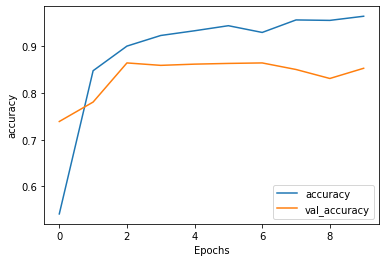

In [21]:
plot_graphs(history, 'accuracy')

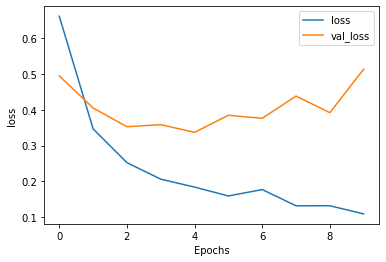

In [22]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6929 - accuracy: 0.6094

  2/391 [..............................] - ETA: 40s - loss: 0.6928 - accuracy: 0.5469

  3/391 [..............................] - ETA: 55s - loss: 0.6926 - accuracy: 0.5365

  4/391 [..............................] - ETA: 53s - loss: 0.6927 - accuracy: 0.5234

  5/391 [..............................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5063

  6/391 [..............................] - ETA: 57s - loss: 0.6930 - accuracy: 0.4974

  7/391 [..............................] - ETA: 1:00 - loss: 0.6928 - accuracy: 0.4955

  8/391 [..............................] - ETA: 59s - loss: 0.6930 - accuracy: 0.4863 

  9/391 [..............................] - ETA: 58s - loss: 0.6930 - accuracy: 0.4896

 10/391 [..............................] - ETA: 58s - loss: 0.6930 - accuracy: 0.5047

 11/391 [..............................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5142

 12/391 [..............................] - ETA: 59s - loss: 0.6932 - accuracy: 0.5182

 13/391 [..............................] - ETA: 59s - loss: 0.6932 - accuracy: 0.5264

 14/391 [>.............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5234

 15/391 [>.............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5240

 16/391 [>.............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5176

 17/391 [>.............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5221

 18/391 [>.............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5234

 19/391 [>.............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.5197

 20/391 [>.............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.5180

 21/391 [>.............................] - ETA: 1:03 - loss: 0.6933 - accuracy: 0.5134

 22/391 [>.............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.5163

 23/391 [>.............................] - ETA: 1:03 - loss: 0.6933 - accuracy: 0.5143

 24/391 [>.............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.5156

 25/391 [>.............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.5144

 26/391 [>.............................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.5144

 27/391 [=>............................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.5174

 28/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5167

 29/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5162

 30/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5156

 31/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5207

 32/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5229

 33/391 [=>............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5204

 34/391 [=>............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5216

 35/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5228

 36/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5234

 37/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5236

 38/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5238

 39/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5220

 40/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5207

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5187

 42/391 [==>...........................] - ETA: 59s - loss: 0.6932 - accuracy: 0.5171 

 43/391 [==>...........................] - ETA: 59s - loss: 0.6933 - accuracy: 0.5142

 44/391 [==>...........................] - ETA: 59s - loss: 0.6933 - accuracy: 0.5135

 45/391 [==>...........................] - ETA: 58s - loss: 0.6933 - accuracy: 0.5146

 46/391 [==>...........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.5166

 47/391 [==>...........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.5176

 48/391 [==>...........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.5173

 49/391 [==>...........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5163

 50/391 [==>...........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.5141

 51/391 [==>...........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.5132

 52/391 [==>...........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.5138

 53/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.5150

 54/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5145

 55/391 [===>..........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5148

 56/391 [===>..........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5145

 57/391 [===>..........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5156

 58/391 [===>..........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5154

 59/391 [===>..........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5164

 60/391 [===>..........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5174

 61/391 [===>..........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5169

 62/391 [===>..........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5164

 63/391 [===>..........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5159

 64/391 [===>..........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5149

 65/391 [===>..........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5159

 66/391 [====>.........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5159

 67/391 [====>.........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5149

 68/391 [====>.........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5142

 69/391 [====>.........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5134

 70/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.5107

 71/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5110

 72/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5113

 73/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5113

 74/391 [====>.........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5116

 75/391 [====>.........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5121

 76/391 [====>.........................] - ETA: 54s - loss: 0.6930 - accuracy: 0.5132

 77/391 [====>.........................] - ETA: 54s - loss: 0.6930 - accuracy: 0.5138

 78/391 [====>.........................] - ETA: 54s - loss: 0.6930 - accuracy: 0.5140

 79/391 [=====>........................] - ETA: 54s - loss: 0.6930 - accuracy: 0.5140

 80/391 [=====>........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5156

 81/391 [=====>........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5158

 82/391 [=====>........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5151

 83/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.5134

 84/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.5126

 85/391 [=====>........................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5129

 86/391 [=====>........................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5127

 87/391 [=====>........................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5117

 88/391 [=====>........................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5119

 89/391 [=====>........................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5123

 90/391 [=====>........................] - ETA: 51s - loss: 0.6930 - accuracy: 0.5123

 91/391 [=====>........................] - ETA: 51s - loss: 0.6930 - accuracy: 0.5132

 92/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5121

 93/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5121

 94/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5120

 95/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5115

 96/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5109

 97/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5108

 98/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5113

 99/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5103

100/391 [======>.......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5106

101/391 [======>.......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5101

102/391 [======>.......................] - ETA: 49s - loss: 0.6930 - accuracy: 0.5106

103/391 [======>.......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5102

104/391 [======>.......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5092

105/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5085

106/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5080

107/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5077

108/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5078

109/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5079

110/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5075

111/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5076

112/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5077

113/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5076

114/391 [=======>......................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5070

115/391 [=======>......................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5073

116/391 [=======>......................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5066

117/391 [=======>......................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5057

118/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5054

119/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5059

120/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5063

121/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5061

122/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5064

123/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5066

124/391 [========>.....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5063

125/391 [========>.....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5069

126/391 [========>.....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5067

127/391 [========>.....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5065

128/391 [========>.....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5060

129/391 [========>.....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5057

130/391 [========>.....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5044

131/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5045

132/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5046

133/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5047

134/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5037

135/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5041

136/391 [=========>....................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5034

137/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5033

138/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5041

139/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5043

140/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5047

141/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5048

142/391 [=========>....................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5046

143/391 [=========>....................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5052

144/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5046

145/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5044

146/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5046

147/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5040

148/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5041

149/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5041

150/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5039

151/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5041

152/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5050

153/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5048

154/391 [==========>...................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5041

155/391 [==========>...................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5030

156/391 [==========>...................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5027

157/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5029

158/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5026

159/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5027

160/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5020

161/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5021

162/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5022

163/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5020

164/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5019

165/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5019

166/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5015

167/391 [===========>..................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5016

168/391 [===========>..................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5010

169/391 [===========>..................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5001

170/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4995

171/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4992

172/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4995

173/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4993

174/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4993

175/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4988

176/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4985

177/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4989

178/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4989

179/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4989

180/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4987

181/391 [============>.................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4980

182/391 [============>.................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4981

183/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4985

184/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4984

185/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4991

186/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4992

187/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4994

188/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4989

189/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4993

190/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4989

191/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4993

192/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.4998

193/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.4995

194/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.4994

195/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.4998

196/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.5006

197/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.5005

198/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.4999

199/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4998

200/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4996

201/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4994

202/391 [==============>...............] - ETA: 33s - loss: 0.6927 - accuracy: 0.4994

203/391 [==============>...............] - ETA: 33s - loss: 0.6927 - accuracy: 0.4992

204/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4990

205/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4986

206/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4992

207/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4992

208/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4994

209/391 [===============>..............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4989

210/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4990

211/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4993

212/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4995

213/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4999

214/391 [===============>..............] - ETA: 31s - loss: 0.6926 - accuracy: 0.4993

215/391 [===============>..............] - ETA: 30s - loss: 0.6926 - accuracy: 0.4997

216/391 [===============>..............] - ETA: 30s - loss: 0.6926 - accuracy: 0.4998

217/391 [===============>..............] - ETA: 30s - loss: 0.6926 - accuracy: 0.4992

218/391 [===============>..............] - ETA: 30s - loss: 0.6925 - accuracy: 0.4991

219/391 [===============>..............] - ETA: 30s - loss: 0.6925 - accuracy: 0.4994

220/391 [===============>..............] - ETA: 30s - loss: 0.6925 - accuracy: 0.4990

221/391 [===============>..............] - ETA: 29s - loss: 0.6925 - accuracy: 0.4990

222/391 [================>.............] - ETA: 29s - loss: 0.6924 - accuracy: 0.4994

223/391 [================>.............] - ETA: 29s - loss: 0.6924 - accuracy: 0.4992

224/391 [================>.............] - ETA: 29s - loss: 0.6924 - accuracy: 0.4992

225/391 [================>.............] - ETA: 29s - loss: 0.6924 - accuracy: 0.4992

226/391 [================>.............] - ETA: 28s - loss: 0.6924 - accuracy: 0.4990

227/391 [================>.............] - ETA: 28s - loss: 0.6924 - accuracy: 0.4986

228/391 [================>.............] - ETA: 28s - loss: 0.6924 - accuracy: 0.4988

229/391 [================>.............] - ETA: 28s - loss: 0.6924 - accuracy: 0.4984

230/391 [================>.............] - ETA: 28s - loss: 0.6923 - accuracy: 0.4984

231/391 [================>.............] - ETA: 28s - loss: 0.6923 - accuracy: 0.4988

232/391 [================>.............] - ETA: 27s - loss: 0.6923 - accuracy: 0.4987

233/391 [================>.............] - ETA: 27s - loss: 0.6923 - accuracy: 0.4989

234/391 [================>.............] - ETA: 27s - loss: 0.6922 - accuracy: 0.4986

235/391 [=================>............] - ETA: 27s - loss: 0.6922 - accuracy: 0.4983

236/391 [=================>............] - ETA: 27s - loss: 0.6922 - accuracy: 0.4979

237/391 [=================>............] - ETA: 27s - loss: 0.6922 - accuracy: 0.4979

238/391 [=================>............] - ETA: 26s - loss: 0.6921 - accuracy: 0.4976

239/391 [=================>............] - ETA: 26s - loss: 0.6921 - accuracy: 0.4977

240/391 [=================>............] - ETA: 26s - loss: 0.6920 - accuracy: 0.4977

241/391 [=================>............] - ETA: 26s - loss: 0.6920 - accuracy: 0.4977

242/391 [=================>............] - ETA: 26s - loss: 0.6920 - accuracy: 0.4974

243/391 [=================>............] - ETA: 26s - loss: 0.6919 - accuracy: 0.4976

244/391 [=================>............] - ETA: 25s - loss: 0.6919 - accuracy: 0.4975

245/391 [=================>............] - ETA: 25s - loss: 0.6919 - accuracy: 0.4973

246/391 [=================>............] - ETA: 25s - loss: 0.6918 - accuracy: 0.4977

247/391 [=================>............] - ETA: 25s - loss: 0.6917 - accuracy: 0.4978

248/391 [==================>...........] - ETA: 25s - loss: 0.6917 - accuracy: 0.4978

249/391 [==================>...........] - ETA: 25s - loss: 0.6915 - accuracy: 0.4979

250/391 [==================>...........] - ETA: 24s - loss: 0.6916 - accuracy: 0.4976

251/391 [==================>...........] - ETA: 24s - loss: 0.6913 - accuracy: 0.4974

252/391 [==================>...........] - ETA: 24s - loss: 0.6912 - accuracy: 0.4975

253/391 [==================>...........] - ETA: 24s - loss: 0.6911 - accuracy: 0.4977

254/391 [==================>...........] - ETA: 24s - loss: 0.6909 - accuracy: 0.4975

255/391 [==================>...........] - ETA: 23s - loss: 0.6908 - accuracy: 0.4974

256/391 [==================>...........] - ETA: 23s - loss: 0.6909 - accuracy: 0.4980

257/391 [==================>...........] - ETA: 23s - loss: 0.6912 - accuracy: 0.4978

258/391 [==================>...........] - ETA: 23s - loss: 0.6919 - accuracy: 0.4977

259/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4980

260/391 [==================>...........] - ETA: 23s - loss: 0.6925 - accuracy: 0.4981

261/391 [===================>..........] - ETA: 22s - loss: 0.6931 - accuracy: 0.4976

262/391 [===================>..........] - ETA: 22s - loss: 0.6935 - accuracy: 0.4972

263/391 [===================>..........] - ETA: 22s - loss: 0.6937 - accuracy: 0.4970

264/391 [===================>..........] - ETA: 22s - loss: 0.6937 - accuracy: 0.4969

265/391 [===================>..........] - ETA: 22s - loss: 0.6936 - accuracy: 0.4971

266/391 [===================>..........] - ETA: 22s - loss: 0.6934 - accuracy: 0.4976

267/391 [===================>..........] - ETA: 21s - loss: 0.6934 - accuracy: 0.4973

268/391 [===================>..........] - ETA: 21s - loss: 0.6933 - accuracy: 0.4973

269/391 [===================>..........] - ETA: 21s - loss: 0.6932 - accuracy: 0.4974

270/391 [===================>..........] - ETA: 21s - loss: 0.6931 - accuracy: 0.4972

271/391 [===================>..........] - ETA: 21s - loss: 0.6930 - accuracy: 0.4969

272/391 [===================>..........] - ETA: 21s - loss: 0.6930 - accuracy: 0.4970

273/391 [===================>..........] - ETA: 20s - loss: 0.6929 - accuracy: 0.4972

274/391 [====================>.........] - ETA: 20s - loss: 0.6929 - accuracy: 0.4971

275/391 [====================>.........] - ETA: 20s - loss: 0.6928 - accuracy: 0.4972

276/391 [====================>.........] - ETA: 20s - loss: 0.6927 - accuracy: 0.4972

277/391 [====================>.........] - ETA: 20s - loss: 0.6927 - accuracy: 0.4971

278/391 [====================>.........] - ETA: 19s - loss: 0.6926 - accuracy: 0.4972

279/391 [====================>.........] - ETA: 19s - loss: 0.6926 - accuracy: 0.4974

280/391 [====================>.........] - ETA: 19s - loss: 0.6925 - accuracy: 0.4972

281/391 [====================>.........] - ETA: 19s - loss: 0.6925 - accuracy: 0.4976

282/391 [====================>.........] - ETA: 19s - loss: 0.6925 - accuracy: 0.4979

283/391 [====================>.........] - ETA: 19s - loss: 0.6924 - accuracy: 0.4981

284/391 [====================>.........] - ETA: 18s - loss: 0.6923 - accuracy: 0.4979

285/391 [====================>.........] - ETA: 18s - loss: 0.6923 - accuracy: 0.4981

286/391 [====================>.........] - ETA: 18s - loss: 0.6922 - accuracy: 0.4981

287/391 [=====================>........] - ETA: 18s - loss: 0.6921 - accuracy: 0.4979

288/391 [=====================>........] - ETA: 18s - loss: 0.6921 - accuracy: 0.4980

289/391 [=====================>........] - ETA: 18s - loss: 0.6919 - accuracy: 0.4977

290/391 [=====================>........] - ETA: 17s - loss: 0.6918 - accuracy: 0.4978

291/391 [=====================>........] - ETA: 17s - loss: 0.6917 - accuracy: 0.4976

292/391 [=====================>........] - ETA: 17s - loss: 0.6917 - accuracy: 0.4979

293/391 [=====================>........] - ETA: 17s - loss: 0.6916 - accuracy: 0.4981

294/391 [=====================>........] - ETA: 17s - loss: 0.6915 - accuracy: 0.4978

295/391 [=====================>........] - ETA: 16s - loss: 0.6914 - accuracy: 0.4981

296/391 [=====================>........] - ETA: 16s - loss: 0.6913 - accuracy: 0.4986

297/391 [=====================>........] - ETA: 16s - loss: 0.6912 - accuracy: 0.4986

298/391 [=====================>........] - ETA: 16s - loss: 0.6911 - accuracy: 0.4982

299/391 [=====================>........] - ETA: 16s - loss: 0.6910 - accuracy: 0.4986

300/391 [======================>.......] - ETA: 16s - loss: 0.6909 - accuracy: 0.4989

301/391 [======================>.......] - ETA: 15s - loss: 0.6908 - accuracy: 0.4991

302/391 [======================>.......] - ETA: 15s - loss: 0.6908 - accuracy: 0.4994

303/391 [======================>.......] - ETA: 15s - loss: 0.6906 - accuracy: 0.4993

304/391 [======================>.......] - ETA: 15s - loss: 0.6905 - accuracy: 0.4993

305/391 [======================>.......] - ETA: 15s - loss: 0.6904 - accuracy: 0.4990

306/391 [======================>.......] - ETA: 14s - loss: 0.6903 - accuracy: 0.4988

307/391 [======================>.......] - ETA: 14s - loss: 0.6902 - accuracy: 0.4989

308/391 [======================>.......] - ETA: 14s - loss: 0.6901 - accuracy: 0.4990

309/391 [======================>.......] - ETA: 14s - loss: 0.6900 - accuracy: 0.4991

310/391 [======================>.......] - ETA: 14s - loss: 0.6899 - accuracy: 0.4993

311/391 [======================>.......] - ETA: 14s - loss: 0.6898 - accuracy: 0.4994

312/391 [======================>.......] - ETA: 13s - loss: 0.6896 - accuracy: 0.4997

313/391 [=======================>......] - ETA: 13s - loss: 0.6895 - accuracy: 0.4999

314/391 [=======================>......] - ETA: 13s - loss: 0.6894 - accuracy: 0.4998

315/391 [=======================>......] - ETA: 13s - loss: 0.6892 - accuracy: 0.4998

316/391 [=======================>......] - ETA: 13s - loss: 0.6889 - accuracy: 0.4999

317/391 [=======================>......] - ETA: 13s - loss: 0.6887 - accuracy: 0.5000

318/391 [=======================>......] - ETA: 12s - loss: 0.6886 - accuracy: 0.5002

319/391 [=======================>......] - ETA: 12s - loss: 0.6885 - accuracy: 0.5007

320/391 [=======================>......] - ETA: 12s - loss: 0.6883 - accuracy: 0.5008

321/391 [=======================>......] - ETA: 12s - loss: 0.6882 - accuracy: 0.5012

322/391 [=======================>......] - ETA: 12s - loss: 0.6880 - accuracy: 0.5020

323/391 [=======================>......] - ETA: 11s - loss: 0.6878 - accuracy: 0.5025

324/391 [=======================>......] - ETA: 11s - loss: 0.6875 - accuracy: 0.5030

325/391 [=======================>......] - ETA: 11s - loss: 0.6873 - accuracy: 0.5033

326/391 [========================>.....] - ETA: 11s - loss: 0.6869 - accuracy: 0.5035

327/391 [========================>.....] - ETA: 11s - loss: 0.6868 - accuracy: 0.5038

328/391 [========================>.....] - ETA: 11s - loss: 0.6865 - accuracy: 0.5040

329/391 [========================>.....] - ETA: 10s - loss: 0.6863 - accuracy: 0.5044

330/391 [========================>.....] - ETA: 10s - loss: 0.6860 - accuracy: 0.5049

331/391 [========================>.....] - ETA: 10s - loss: 0.6857 - accuracy: 0.5055

332/391 [========================>.....] - ETA: 10s - loss: 0.6853 - accuracy: 0.5063

333/391 [========================>.....] - ETA: 10s - loss: 0.6852 - accuracy: 0.5065

334/391 [========================>.....] - ETA: 10s - loss: 0.6848 - accuracy: 0.5073

335/391 [========================>.....] - ETA: 9s - loss: 0.6843 - accuracy: 0.5080 

336/391 [========================>.....] - ETA: 9s - loss: 0.6840 - accuracy: 0.5085

337/391 [========================>.....] - ETA: 9s - loss: 0.6838 - accuracy: 0.5091

338/391 [========================>.....] - ETA: 9s - loss: 0.6833 - accuracy: 0.5100

339/391 [=========================>....] - ETA: 9s - loss: 0.6828 - accuracy: 0.5108

340/391 [=========================>....] - ETA: 9s - loss: 0.6823 - accuracy: 0.5116

341/391 [=========================>....] - ETA: 8s - loss: 0.6820 - accuracy: 0.5121

342/391 [=========================>....] - ETA: 8s - loss: 0.6818 - accuracy: 0.5122

343/391 [=========================>....] - ETA: 8s - loss: 0.6816 - accuracy: 0.5127

344/391 [=========================>....] - ETA: 8s - loss: 0.6814 - accuracy: 0.5131

345/391 [=========================>....] - ETA: 8s - loss: 0.6811 - accuracy: 0.5138

346/391 [=========================>....] - ETA: 7s - loss: 0.6804 - accuracy: 0.5148

347/391 [=========================>....] - ETA: 7s - loss: 0.6798 - accuracy: 0.5158

348/391 [=========================>....] - ETA: 7s - loss: 0.6793 - accuracy: 0.5166

349/391 [=========================>....] - ETA: 7s - loss: 0.6790 - accuracy: 0.5173

350/391 [=========================>....] - ETA: 7s - loss: 0.6786 - accuracy: 0.5180

351/391 [=========================>....] - ETA: 7s - loss: 0.6783 - accuracy: 0.5186

352/391 [==========================>...] - ETA: 6s - loss: 0.6785 - accuracy: 0.5188

353/391 [==========================>...] - ETA: 6s - loss: 0.6780 - accuracy: 0.5194

354/391 [==========================>...] - ETA: 6s - loss: 0.6776 - accuracy: 0.5200

355/391 [==========================>...] - ETA: 6s - loss: 0.6771 - accuracy: 0.5209

356/391 [==========================>...] - ETA: 6s - loss: 0.6770 - accuracy: 0.5213

357/391 [==========================>...] - ETA: 6s - loss: 0.6766 - accuracy: 0.5219

358/391 [==========================>...] - ETA: 5s - loss: 0.6761 - accuracy: 0.5225

359/391 [==========================>...] - ETA: 5s - loss: 0.6755 - accuracy: 0.5234

360/391 [==========================>...] - ETA: 5s - loss: 0.6751 - accuracy: 0.5240

361/391 [==========================>...] - ETA: 5s - loss: 0.6746 - accuracy: 0.5246

362/391 [==========================>...] - ETA: 5s - loss: 0.6744 - accuracy: 0.5252

363/391 [==========================>...] - ETA: 4s - loss: 0.6740 - accuracy: 0.5258

364/391 [==========================>...] - ETA: 4s - loss: 0.6736 - accuracy: 0.5265

365/391 [===========================>..] - ETA: 4s - loss: 0.6738 - accuracy: 0.5264

366/391 [===========================>..] - ETA: 4s - loss: 0.6738 - accuracy: 0.5267

367/391 [===========================>..] - ETA: 4s - loss: 0.6740 - accuracy: 0.5267

368/391 [===========================>..] - ETA: 4s - loss: 0.6741 - accuracy: 0.5269

369/391 [===========================>..] - ETA: 3s - loss: 0.6737 - accuracy: 0.5273

370/391 [===========================>..] - ETA: 3s - loss: 0.6735 - accuracy: 0.5278

371/391 [===========================>..] - ETA: 3s - loss: 0.6733 - accuracy: 0.5281

372/391 [===========================>..] - ETA: 3s - loss: 0.6731 - accuracy: 0.5286

373/391 [===========================>..] - ETA: 3s - loss: 0.6728 - accuracy: 0.5289

374/391 [===========================>..] - ETA: 3s - loss: 0.6724 - accuracy: 0.5295

375/391 [===========================>..] - ETA: 2s - loss: 0.6722 - accuracy: 0.5299

376/391 [===========================>..] - ETA: 2s - loss: 0.6721 - accuracy: 0.5304

377/391 [===========================>..] - ETA: 2s - loss: 0.6718 - accuracy: 0.5308

378/391 [============================>.] - ETA: 2s - loss: 0.6716 - accuracy: 0.5312

379/391 [============================>.] - ETA: 2s - loss: 0.6713 - accuracy: 0.5317

380/391 [============================>.] - ETA: 1s - loss: 0.6710 - accuracy: 0.5324

381/391 [============================>.] - ETA: 1s - loss: 0.6707 - accuracy: 0.5327

382/391 [============================>.] - ETA: 1s - loss: 0.6705 - accuracy: 0.5332

383/391 [============================>.] - ETA: 1s - loss: 0.6702 - accuracy: 0.5337

384/391 [============================>.] - ETA: 1s - loss: 0.6695 - accuracy: 0.5345

385/391 [============================>.] - ETA: 1s - loss: 0.6691 - accuracy: 0.5350

386/391 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.5353

387/391 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.5357

388/391 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.5361

389/391 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.5367

390/391 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.5369

391/391 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.5372

391/391 [==============================] - 73s 186ms/step - loss: 0.6681 - accuracy: 0.5372 - val_loss: 0.5608 - val_accuracy: 0.6844


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.5688 - accuracy: 0.7031

  2/391 [..............................] - ETA: 23s - loss: 0.5370 - accuracy: 0.7188

  3/391 [..............................] - ETA: 42s - loss: 0.5756 - accuracy: 0.6510

  4/391 [..............................] - ETA: 50s - loss: 0.5606 - accuracy: 0.6758

  5/391 [..............................] - ETA: 52s - loss: 0.5482 - accuracy: 0.6938

  6/391 [..............................] - ETA: 58s - loss: 0.5412 - accuracy: 0.7057

  7/391 [..............................] - ETA: 1:00 - loss: 0.5481 - accuracy: 0.7009

  8/391 [..............................] - ETA: 1:01 - loss: 0.5460 - accuracy: 0.7090

  9/391 [..............................] - ETA: 1:02 - loss: 0.5384 - accuracy: 0.7188

 10/391 [..............................] - ETA: 1:03 - loss: 0.5375 - accuracy: 0.7219

 11/391 [..............................] - ETA: 1:03 - loss: 0.5323 - accuracy: 0.7244

 12/391 [..............................] - ETA: 1:04 - loss: 0.5253 - accuracy: 0.7305

 13/391 [..............................] - ETA: 1:04 - loss: 0.5177 - accuracy: 0.7344

 14/391 [>.............................] - ETA: 1:05 - loss: 0.5140 - accuracy: 0.7433

 15/391 [>.............................] - ETA: 1:05 - loss: 0.5162 - accuracy: 0.7479

 16/391 [>.............................] - ETA: 1:05 - loss: 0.5217 - accuracy: 0.7471

 17/391 [>.............................] - ETA: 1:04 - loss: 0.5219 - accuracy: 0.7436

 18/391 [>.............................] - ETA: 1:04 - loss: 0.5152 - accuracy: 0.7517

 19/391 [>.............................] - ETA: 1:04 - loss: 0.5117 - accuracy: 0.7558

 20/391 [>.............................] - ETA: 1:05 - loss: 0.5083 - accuracy: 0.7602

 21/391 [>.............................] - ETA: 1:04 - loss: 0.5057 - accuracy: 0.7619

 22/391 [>.............................] - ETA: 1:04 - loss: 0.5067 - accuracy: 0.7614

 23/391 [>.............................] - ETA: 1:04 - loss: 0.5091 - accuracy: 0.7609

 24/391 [>.............................] - ETA: 1:05 - loss: 0.5096 - accuracy: 0.7611

 25/391 [>.............................] - ETA: 1:05 - loss: 0.5065 - accuracy: 0.7650

 26/391 [>.............................] - ETA: 1:05 - loss: 0.5060 - accuracy: 0.7656

 27/391 [=>............................] - ETA: 1:05 - loss: 0.5070 - accuracy: 0.7645

 28/391 [=>............................] - ETA: 1:04 - loss: 0.5044 - accuracy: 0.7662

 29/391 [=>............................] - ETA: 1:04 - loss: 0.5049 - accuracy: 0.7662

 30/391 [=>............................] - ETA: 1:04 - loss: 0.5086 - accuracy: 0.7646

 31/391 [=>............................] - ETA: 1:04 - loss: 0.5077 - accuracy: 0.7651

 32/391 [=>............................] - ETA: 1:04 - loss: 0.5059 - accuracy: 0.7651

 33/391 [=>............................] - ETA: 1:03 - loss: 0.5086 - accuracy: 0.7618

 34/391 [=>............................] - ETA: 1:03 - loss: 0.5099 - accuracy: 0.7606

 35/391 [=>............................] - ETA: 1:03 - loss: 0.5081 - accuracy: 0.7625

 36/391 [=>............................] - ETA: 1:03 - loss: 0.5075 - accuracy: 0.7639

 37/391 [=>............................] - ETA: 1:02 - loss: 0.5053 - accuracy: 0.7665

 38/391 [=>............................] - ETA: 1:02 - loss: 0.5059 - accuracy: 0.7664

 39/391 [=>............................] - ETA: 1:03 - loss: 0.5035 - accuracy: 0.7680

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.5061 - accuracy: 0.7660

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.5044 - accuracy: 0.7656

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.5058 - accuracy: 0.7638

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.5059 - accuracy: 0.7620

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.5074 - accuracy: 0.7603

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.5047 - accuracy: 0.7628

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.5043 - accuracy: 0.7639

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.5053 - accuracy: 0.7630

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.5041 - accuracy: 0.7640

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.5045 - accuracy: 0.7634

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.5040 - accuracy: 0.7634

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.5052 - accuracy: 0.7638

 52/391 [==>...........................] - ETA: 1:00 - loss: 0.5055 - accuracy: 0.7635

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.5049 - accuracy: 0.7636

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.5061 - accuracy: 0.7630

 55/391 [===>..........................] - ETA: 59s - loss: 0.5056 - accuracy: 0.7628 

 56/391 [===>..........................] - ETA: 59s - loss: 0.5054 - accuracy: 0.7620

 57/391 [===>..........................] - ETA: 59s - loss: 0.5057 - accuracy: 0.7604

 58/391 [===>..........................] - ETA: 59s - loss: 0.5057 - accuracy: 0.7602

 59/391 [===>..........................] - ETA: 59s - loss: 0.5052 - accuracy: 0.7590

 60/391 [===>..........................] - ETA: 59s - loss: 0.5043 - accuracy: 0.7591

 61/391 [===>..........................] - ETA: 59s - loss: 0.5052 - accuracy: 0.7572

 62/391 [===>..........................] - ETA: 58s - loss: 0.5034 - accuracy: 0.7586

 63/391 [===>..........................] - ETA: 58s - loss: 0.5038 - accuracy: 0.7584

 64/391 [===>..........................] - ETA: 58s - loss: 0.5021 - accuracy: 0.7603

 65/391 [===>..........................] - ETA: 58s - loss: 0.5015 - accuracy: 0.7613

 66/391 [====>.........................] - ETA: 58s - loss: 0.5011 - accuracy: 0.7623

 67/391 [====>.........................] - ETA: 57s - loss: 0.5002 - accuracy: 0.7633

 68/391 [====>.........................] - ETA: 57s - loss: 0.4997 - accuracy: 0.7636

 69/391 [====>.........................] - ETA: 57s - loss: 0.4989 - accuracy: 0.7643

 70/391 [====>.........................] - ETA: 56s - loss: 0.4994 - accuracy: 0.7641

 71/391 [====>.........................] - ETA: 56s - loss: 0.4981 - accuracy: 0.7645

 72/391 [====>.........................] - ETA: 56s - loss: 0.4977 - accuracy: 0.7648

 73/391 [====>.........................] - ETA: 56s - loss: 0.4967 - accuracy: 0.7652

 74/391 [====>.........................] - ETA: 56s - loss: 0.4979 - accuracy: 0.7646

 75/391 [====>.........................] - ETA: 56s - loss: 0.4974 - accuracy: 0.7646

 76/391 [====>.........................] - ETA: 55s - loss: 0.4968 - accuracy: 0.7648

 77/391 [====>.........................] - ETA: 55s - loss: 0.4969 - accuracy: 0.7646

 78/391 [====>.........................] - ETA: 55s - loss: 0.4957 - accuracy: 0.7652

 79/391 [=====>........................] - ETA: 55s - loss: 0.4949 - accuracy: 0.7660

 80/391 [=====>........................] - ETA: 55s - loss: 0.4938 - accuracy: 0.7670

 81/391 [=====>........................] - ETA: 55s - loss: 0.4927 - accuracy: 0.7681

 82/391 [=====>........................] - ETA: 55s - loss: 0.4940 - accuracy: 0.7673

 83/391 [=====>........................] - ETA: 54s - loss: 0.4932 - accuracy: 0.7684

 84/391 [=====>........................] - ETA: 54s - loss: 0.4923 - accuracy: 0.7688

 85/391 [=====>........................] - ETA: 54s - loss: 0.4930 - accuracy: 0.7688

 86/391 [=====>........................] - ETA: 54s - loss: 0.4927 - accuracy: 0.7694

 87/391 [=====>........................] - ETA: 53s - loss: 0.4914 - accuracy: 0.7705

 88/391 [=====>........................] - ETA: 54s - loss: 0.4908 - accuracy: 0.7711

 89/391 [=====>........................] - ETA: 53s - loss: 0.4887 - accuracy: 0.7730

 90/391 [=====>........................] - ETA: 53s - loss: 0.4867 - accuracy: 0.7741

 91/391 [=====>........................] - ETA: 53s - loss: 0.4858 - accuracy: 0.7751

 92/391 [======>.......................] - ETA: 53s - loss: 0.4842 - accuracy: 0.7763

 93/391 [======>.......................] - ETA: 52s - loss: 0.4840 - accuracy: 0.7764

 94/391 [======>.......................] - ETA: 52s - loss: 0.4832 - accuracy: 0.7764

 95/391 [======>.......................] - ETA: 52s - loss: 0.4821 - accuracy: 0.7771

 96/391 [======>.......................] - ETA: 52s - loss: 0.4821 - accuracy: 0.7769

 97/391 [======>.......................] - ETA: 51s - loss: 0.4810 - accuracy: 0.7780

 98/391 [======>.......................] - ETA: 51s - loss: 0.4801 - accuracy: 0.7782

 99/391 [======>.......................] - ETA: 51s - loss: 0.4791 - accuracy: 0.7794

100/391 [======>.......................] - ETA: 51s - loss: 0.4780 - accuracy: 0.7803

101/391 [======>.......................] - ETA: 51s - loss: 0.4771 - accuracy: 0.7805

102/391 [======>.......................] - ETA: 51s - loss: 0.4761 - accuracy: 0.7808

103/391 [======>.......................] - ETA: 50s - loss: 0.4757 - accuracy: 0.7814

104/391 [======>.......................] - ETA: 50s - loss: 0.4747 - accuracy: 0.7822

105/391 [=======>......................] - ETA: 50s - loss: 0.4748 - accuracy: 0.7826

106/391 [=======>......................] - ETA: 50s - loss: 0.4740 - accuracy: 0.7833

107/391 [=======>......................] - ETA: 50s - loss: 0.4734 - accuracy: 0.7839

108/391 [=======>......................] - ETA: 50s - loss: 0.4738 - accuracy: 0.7828

109/391 [=======>......................] - ETA: 49s - loss: 0.4739 - accuracy: 0.7828

110/391 [=======>......................] - ETA: 49s - loss: 0.4737 - accuracy: 0.7828

111/391 [=======>......................] - ETA: 49s - loss: 0.4736 - accuracy: 0.7831

112/391 [=======>......................] - ETA: 49s - loss: 0.4734 - accuracy: 0.7833

113/391 [=======>......................] - ETA: 49s - loss: 0.4722 - accuracy: 0.7840

114/391 [=======>......................] - ETA: 48s - loss: 0.4709 - accuracy: 0.7850

115/391 [=======>......................] - ETA: 48s - loss: 0.4699 - accuracy: 0.7859

116/391 [=======>......................] - ETA: 48s - loss: 0.4711 - accuracy: 0.7853

117/391 [=======>......................] - ETA: 48s - loss: 0.4711 - accuracy: 0.7858

118/391 [========>.....................] - ETA: 48s - loss: 0.4705 - accuracy: 0.7861

119/391 [========>.....................] - ETA: 47s - loss: 0.4698 - accuracy: 0.7865

120/391 [========>.....................] - ETA: 47s - loss: 0.4698 - accuracy: 0.7862

121/391 [========>.....................] - ETA: 47s - loss: 0.4693 - accuracy: 0.7867

122/391 [========>.....................] - ETA: 47s - loss: 0.4695 - accuracy: 0.7864

123/391 [========>.....................] - ETA: 47s - loss: 0.4697 - accuracy: 0.7861

124/391 [========>.....................] - ETA: 46s - loss: 0.4688 - accuracy: 0.7865

125/391 [========>.....................] - ETA: 46s - loss: 0.4682 - accuracy: 0.7866

126/391 [========>.....................] - ETA: 46s - loss: 0.4682 - accuracy: 0.7863

127/391 [========>.....................] - ETA: 46s - loss: 0.4684 - accuracy: 0.7860

128/391 [========>.....................] - ETA: 46s - loss: 0.4678 - accuracy: 0.7864

129/391 [========>.....................] - ETA: 46s - loss: 0.4678 - accuracy: 0.7863

130/391 [========>.....................] - ETA: 45s - loss: 0.4684 - accuracy: 0.7865

131/391 [=========>....................] - ETA: 45s - loss: 0.4685 - accuracy: 0.7866

132/391 [=========>....................] - ETA: 45s - loss: 0.4682 - accuracy: 0.7872

133/391 [=========>....................] - ETA: 45s - loss: 0.4684 - accuracy: 0.7876

134/391 [=========>....................] - ETA: 45s - loss: 0.4686 - accuracy: 0.7878

135/391 [=========>....................] - ETA: 44s - loss: 0.4688 - accuracy: 0.7881

136/391 [=========>....................] - ETA: 44s - loss: 0.4686 - accuracy: 0.7883

137/391 [=========>....................] - ETA: 44s - loss: 0.4680 - accuracy: 0.7889

138/391 [=========>....................] - ETA: 44s - loss: 0.4673 - accuracy: 0.7892

139/391 [=========>....................] - ETA: 44s - loss: 0.4670 - accuracy: 0.7893

140/391 [=========>....................] - ETA: 44s - loss: 0.4670 - accuracy: 0.7895

141/391 [=========>....................] - ETA: 44s - loss: 0.4665 - accuracy: 0.7897

142/391 [=========>....................] - ETA: 43s - loss: 0.4663 - accuracy: 0.7895

143/391 [=========>....................] - ETA: 43s - loss: 0.4655 - accuracy: 0.7901

144/391 [==========>...................] - ETA: 43s - loss: 0.4653 - accuracy: 0.7903

145/391 [==========>...................] - ETA: 43s - loss: 0.4649 - accuracy: 0.7907

146/391 [==========>...................] - ETA: 43s - loss: 0.4651 - accuracy: 0.7909

147/391 [==========>...................] - ETA: 43s - loss: 0.4646 - accuracy: 0.7912

148/391 [==========>...................] - ETA: 43s - loss: 0.4646 - accuracy: 0.7912

149/391 [==========>...................] - ETA: 42s - loss: 0.4636 - accuracy: 0.7921

150/391 [==========>...................] - ETA: 42s - loss: 0.4631 - accuracy: 0.7926

151/391 [==========>...................] - ETA: 42s - loss: 0.4625 - accuracy: 0.7931

152/391 [==========>...................] - ETA: 42s - loss: 0.4624 - accuracy: 0.7932

153/391 [==========>...................] - ETA: 42s - loss: 0.4630 - accuracy: 0.7928

154/391 [==========>...................] - ETA: 41s - loss: 0.4625 - accuracy: 0.7930

155/391 [==========>...................] - ETA: 41s - loss: 0.4620 - accuracy: 0.7932

156/391 [==========>...................] - ETA: 41s - loss: 0.4626 - accuracy: 0.7926

157/391 [===========>..................] - ETA: 41s - loss: 0.4623 - accuracy: 0.7929

158/391 [===========>..................] - ETA: 41s - loss: 0.4616 - accuracy: 0.7935

159/391 [===========>..................] - ETA: 41s - loss: 0.4619 - accuracy: 0.7934

160/391 [===========>..................] - ETA: 40s - loss: 0.4622 - accuracy: 0.7933

161/391 [===========>..................] - ETA: 40s - loss: 0.4620 - accuracy: 0.7937

162/391 [===========>..................] - ETA: 40s - loss: 0.4625 - accuracy: 0.7935

163/391 [===========>..................] - ETA: 40s - loss: 0.4627 - accuracy: 0.7936

164/391 [===========>..................] - ETA: 40s - loss: 0.4625 - accuracy: 0.7938

165/391 [===========>..................] - ETA: 40s - loss: 0.4619 - accuracy: 0.7941

166/391 [===========>..................] - ETA: 39s - loss: 0.4613 - accuracy: 0.7946

167/391 [===========>..................] - ETA: 40s - loss: 0.4613 - accuracy: 0.7947

168/391 [===========>..................] - ETA: 40s - loss: 0.4612 - accuracy: 0.7948

169/391 [===========>..................] - ETA: 39s - loss: 0.4607 - accuracy: 0.7953

170/391 [============>.................] - ETA: 39s - loss: 0.4608 - accuracy: 0.7949

171/391 [============>.................] - ETA: 39s - loss: 0.4604 - accuracy: 0.7951

172/391 [============>.................] - ETA: 39s - loss: 0.4603 - accuracy: 0.7951

173/391 [============>.................] - ETA: 39s - loss: 0.4598 - accuracy: 0.7953

174/391 [============>.................] - ETA: 39s - loss: 0.4599 - accuracy: 0.7950

175/391 [============>.................] - ETA: 38s - loss: 0.4595 - accuracy: 0.7950

176/391 [============>.................] - ETA: 38s - loss: 0.4590 - accuracy: 0.7953

177/391 [============>.................] - ETA: 38s - loss: 0.4581 - accuracy: 0.7958

178/391 [============>.................] - ETA: 38s - loss: 0.4573 - accuracy: 0.7963

179/391 [============>.................] - ETA: 38s - loss: 0.4566 - accuracy: 0.7967

180/391 [============>.................] - ETA: 37s - loss: 0.4560 - accuracy: 0.7971

181/391 [============>.................] - ETA: 37s - loss: 0.4559 - accuracy: 0.7975

182/391 [============>.................] - ETA: 37s - loss: 0.4555 - accuracy: 0.7976

183/391 [=============>................] - ETA: 37s - loss: 0.4550 - accuracy: 0.7981

184/391 [=============>................] - ETA: 37s - loss: 0.4547 - accuracy: 0.7983

185/391 [=============>................] - ETA: 37s - loss: 0.4540 - accuracy: 0.7989

186/391 [=============>................] - ETA: 36s - loss: 0.4539 - accuracy: 0.7991

187/391 [=============>................] - ETA: 36s - loss: 0.4534 - accuracy: 0.7995

188/391 [=============>................] - ETA: 36s - loss: 0.4529 - accuracy: 0.8000

189/391 [=============>................] - ETA: 36s - loss: 0.4529 - accuracy: 0.8003

190/391 [=============>................] - ETA: 36s - loss: 0.4527 - accuracy: 0.8006

191/391 [=============>................] - ETA: 35s - loss: 0.4525 - accuracy: 0.8007

192/391 [=============>................] - ETA: 35s - loss: 0.4525 - accuracy: 0.8008

193/391 [=============>................] - ETA: 35s - loss: 0.4517 - accuracy: 0.8014

194/391 [=============>................] - ETA: 35s - loss: 0.4514 - accuracy: 0.8017

195/391 [=============>................] - ETA: 35s - loss: 0.4519 - accuracy: 0.8016

196/391 [==============>...............] - ETA: 35s - loss: 0.4517 - accuracy: 0.8017

197/391 [==============>...............] - ETA: 34s - loss: 0.4513 - accuracy: 0.8018

198/391 [==============>...............] - ETA: 34s - loss: 0.4509 - accuracy: 0.8021

199/391 [==============>...............] - ETA: 34s - loss: 0.4502 - accuracy: 0.8024

200/391 [==============>...............] - ETA: 34s - loss: 0.4494 - accuracy: 0.8028

201/391 [==============>...............] - ETA: 34s - loss: 0.4503 - accuracy: 0.8025

202/391 [==============>...............] - ETA: 34s - loss: 0.4507 - accuracy: 0.8025

203/391 [==============>...............] - ETA: 33s - loss: 0.4503 - accuracy: 0.8031

204/391 [==============>...............] - ETA: 33s - loss: 0.4498 - accuracy: 0.8035

205/391 [==============>...............] - ETA: 33s - loss: 0.4490 - accuracy: 0.8040

206/391 [==============>...............] - ETA: 33s - loss: 0.4487 - accuracy: 0.8041

207/391 [==============>...............] - ETA: 33s - loss: 0.4480 - accuracy: 0.8046

208/391 [==============>...............] - ETA: 33s - loss: 0.4481 - accuracy: 0.8045

209/391 [===============>..............] - ETA: 33s - loss: 0.4474 - accuracy: 0.8048

210/391 [===============>..............] - ETA: 32s - loss: 0.4471 - accuracy: 0.8051

211/391 [===============>..............] - ETA: 32s - loss: 0.4474 - accuracy: 0.8049

212/391 [===============>..............] - ETA: 32s - loss: 0.4477 - accuracy: 0.8048

213/391 [===============>..............] - ETA: 32s - loss: 0.4474 - accuracy: 0.8050

214/391 [===============>..............] - ETA: 32s - loss: 0.4470 - accuracy: 0.8053

215/391 [===============>..............] - ETA: 31s - loss: 0.4471 - accuracy: 0.8052

216/391 [===============>..............] - ETA: 31s - loss: 0.4465 - accuracy: 0.8056

217/391 [===============>..............] - ETA: 31s - loss: 0.4470 - accuracy: 0.8052

218/391 [===============>..............] - ETA: 31s - loss: 0.4462 - accuracy: 0.8058

219/391 [===============>..............] - ETA: 31s - loss: 0.4459 - accuracy: 0.8059

220/391 [===============>..............] - ETA: 31s - loss: 0.4456 - accuracy: 0.8061

221/391 [===============>..............] - ETA: 30s - loss: 0.4455 - accuracy: 0.8061

222/391 [================>.............] - ETA: 30s - loss: 0.4450 - accuracy: 0.8062

223/391 [================>.............] - ETA: 30s - loss: 0.4443 - accuracy: 0.8066

224/391 [================>.............] - ETA: 30s - loss: 0.4439 - accuracy: 0.8069

225/391 [================>.............] - ETA: 30s - loss: 0.4436 - accuracy: 0.8071

226/391 [================>.............] - ETA: 30s - loss: 0.4433 - accuracy: 0.8072

227/391 [================>.............] - ETA: 29s - loss: 0.4434 - accuracy: 0.8073

228/391 [================>.............] - ETA: 29s - loss: 0.4436 - accuracy: 0.8072

229/391 [================>.............] - ETA: 29s - loss: 0.4430 - accuracy: 0.8075

230/391 [================>.............] - ETA: 29s - loss: 0.4427 - accuracy: 0.8077

231/391 [================>.............] - ETA: 29s - loss: 0.4426 - accuracy: 0.8080

232/391 [================>.............] - ETA: 29s - loss: 0.4425 - accuracy: 0.8083

233/391 [================>.............] - ETA: 28s - loss: 0.4418 - accuracy: 0.8089

234/391 [================>.............] - ETA: 28s - loss: 0.4419 - accuracy: 0.8088

235/391 [=================>............] - ETA: 28s - loss: 0.4420 - accuracy: 0.8086

236/391 [=================>............] - ETA: 28s - loss: 0.4420 - accuracy: 0.8087

237/391 [=================>............] - ETA: 28s - loss: 0.4422 - accuracy: 0.8085

238/391 [=================>............] - ETA: 28s - loss: 0.4421 - accuracy: 0.8084

239/391 [=================>............] - ETA: 27s - loss: 0.4427 - accuracy: 0.8081

240/391 [=================>............] - ETA: 27s - loss: 0.4430 - accuracy: 0.8080

241/391 [=================>............] - ETA: 27s - loss: 0.4428 - accuracy: 0.8083

242/391 [=================>............] - ETA: 27s - loss: 0.4428 - accuracy: 0.8082

243/391 [=================>............] - ETA: 27s - loss: 0.4426 - accuracy: 0.8084

244/391 [=================>............] - ETA: 27s - loss: 0.4422 - accuracy: 0.8088

245/391 [=================>............] - ETA: 26s - loss: 0.4422 - accuracy: 0.8089

246/391 [=================>............] - ETA: 26s - loss: 0.4425 - accuracy: 0.8091

247/391 [=================>............] - ETA: 26s - loss: 0.4421 - accuracy: 0.8094

248/391 [==================>...........] - ETA: 26s - loss: 0.4417 - accuracy: 0.8097

249/391 [==================>...........] - ETA: 26s - loss: 0.4412 - accuracy: 0.8102

250/391 [==================>...........] - ETA: 25s - loss: 0.4408 - accuracy: 0.8104

251/391 [==================>...........] - ETA: 25s - loss: 0.4402 - accuracy: 0.8108

252/391 [==================>...........] - ETA: 25s - loss: 0.4404 - accuracy: 0.8107

253/391 [==================>...........] - ETA: 25s - loss: 0.4400 - accuracy: 0.8108

254/391 [==================>...........] - ETA: 25s - loss: 0.4396 - accuracy: 0.8110

255/391 [==================>...........] - ETA: 24s - loss: 0.4395 - accuracy: 0.8108

256/391 [==================>...........] - ETA: 24s - loss: 0.4392 - accuracy: 0.8110

257/391 [==================>...........] - ETA: 24s - loss: 0.4392 - accuracy: 0.8110

258/391 [==================>...........] - ETA: 24s - loss: 0.4394 - accuracy: 0.8107

259/391 [==================>...........] - ETA: 24s - loss: 0.4392 - accuracy: 0.8106

260/391 [==================>...........] - ETA: 24s - loss: 0.4391 - accuracy: 0.8104

261/391 [===================>..........] - ETA: 23s - loss: 0.4385 - accuracy: 0.8106

262/391 [===================>..........] - ETA: 23s - loss: 0.4384 - accuracy: 0.8105

263/391 [===================>..........] - ETA: 23s - loss: 0.4387 - accuracy: 0.8102

264/391 [===================>..........] - ETA: 23s - loss: 0.4388 - accuracy: 0.8101

265/391 [===================>..........] - ETA: 23s - loss: 0.4382 - accuracy: 0.8105

266/391 [===================>..........] - ETA: 22s - loss: 0.4380 - accuracy: 0.8107

267/391 [===================>..........] - ETA: 22s - loss: 0.4377 - accuracy: 0.8107

268/391 [===================>..........] - ETA: 22s - loss: 0.4374 - accuracy: 0.8108

269/391 [===================>..........] - ETA: 22s - loss: 0.4377 - accuracy: 0.8107

270/391 [===================>..........] - ETA: 22s - loss: 0.4380 - accuracy: 0.8106

271/391 [===================>..........] - ETA: 21s - loss: 0.4375 - accuracy: 0.8108

272/391 [===================>..........] - ETA: 21s - loss: 0.4376 - accuracy: 0.8109

273/391 [===================>..........] - ETA: 21s - loss: 0.4373 - accuracy: 0.8111

274/391 [====================>.........] - ETA: 21s - loss: 0.4372 - accuracy: 0.8111

275/391 [====================>.........] - ETA: 21s - loss: 0.4370 - accuracy: 0.8112

276/391 [====================>.........] - ETA: 21s - loss: 0.4371 - accuracy: 0.8113

277/391 [====================>.........] - ETA: 20s - loss: 0.4366 - accuracy: 0.8117

278/391 [====================>.........] - ETA: 20s - loss: 0.4362 - accuracy: 0.8118

279/391 [====================>.........] - ETA: 20s - loss: 0.4360 - accuracy: 0.8121

280/391 [====================>.........] - ETA: 20s - loss: 0.4353 - accuracy: 0.8125

281/391 [====================>.........] - ETA: 20s - loss: 0.4349 - accuracy: 0.8127

282/391 [====================>.........] - ETA: 19s - loss: 0.4346 - accuracy: 0.8129

283/391 [====================>.........] - ETA: 19s - loss: 0.4346 - accuracy: 0.8129

284/391 [====================>.........] - ETA: 19s - loss: 0.4344 - accuracy: 0.8130

285/391 [====================>.........] - ETA: 19s - loss: 0.4341 - accuracy: 0.8131

286/391 [====================>.........] - ETA: 19s - loss: 0.4338 - accuracy: 0.8134

287/391 [=====================>........] - ETA: 19s - loss: 0.4341 - accuracy: 0.8135

288/391 [=====================>........] - ETA: 18s - loss: 0.4344 - accuracy: 0.8134

289/391 [=====================>........] - ETA: 18s - loss: 0.4343 - accuracy: 0.8135

290/391 [=====================>........] - ETA: 18s - loss: 0.4343 - accuracy: 0.8135

291/391 [=====================>........] - ETA: 18s - loss: 0.4341 - accuracy: 0.8136

292/391 [=====================>........] - ETA: 18s - loss: 0.4342 - accuracy: 0.8138

293/391 [=====================>........] - ETA: 17s - loss: 0.4341 - accuracy: 0.8138

294/391 [=====================>........] - ETA: 17s - loss: 0.4343 - accuracy: 0.8137

295/391 [=====================>........] - ETA: 17s - loss: 0.4342 - accuracy: 0.8137

296/391 [=====================>........] - ETA: 17s - loss: 0.4340 - accuracy: 0.8139

297/391 [=====================>........] - ETA: 17s - loss: 0.4339 - accuracy: 0.8138

298/391 [=====================>........] - ETA: 17s - loss: 0.4338 - accuracy: 0.8138

299/391 [=====================>........] - ETA: 16s - loss: 0.4336 - accuracy: 0.8137

300/391 [======================>.......] - ETA: 16s - loss: 0.4338 - accuracy: 0.8136

301/391 [======================>.......] - ETA: 16s - loss: 0.4335 - accuracy: 0.8138

302/391 [======================>.......] - ETA: 16s - loss: 0.4334 - accuracy: 0.8139

303/391 [======================>.......] - ETA: 16s - loss: 0.4332 - accuracy: 0.8141

304/391 [======================>.......] - ETA: 15s - loss: 0.4330 - accuracy: 0.8139

305/391 [======================>.......] - ETA: 15s - loss: 0.4329 - accuracy: 0.8140

306/391 [======================>.......] - ETA: 15s - loss: 0.4327 - accuracy: 0.8142

307/391 [======================>.......] - ETA: 15s - loss: 0.4324 - accuracy: 0.8144

308/391 [======================>.......] - ETA: 15s - loss: 0.4320 - accuracy: 0.8146

309/391 [======================>.......] - ETA: 15s - loss: 0.4319 - accuracy: 0.8147

310/391 [======================>.......] - ETA: 14s - loss: 0.4316 - accuracy: 0.8149

311/391 [======================>.......] - ETA: 14s - loss: 0.4314 - accuracy: 0.8151

312/391 [======================>.......] - ETA: 14s - loss: 0.4312 - accuracy: 0.8151

313/391 [=======================>......] - ETA: 14s - loss: 0.4311 - accuracy: 0.8151

314/391 [=======================>......] - ETA: 14s - loss: 0.4309 - accuracy: 0.8153

315/391 [=======================>......] - ETA: 13s - loss: 0.4306 - accuracy: 0.8156

316/391 [=======================>......] - ETA: 13s - loss: 0.4305 - accuracy: 0.8156

317/391 [=======================>......] - ETA: 13s - loss: 0.4299 - accuracy: 0.8160

318/391 [=======================>......] - ETA: 13s - loss: 0.4298 - accuracy: 0.8162

319/391 [=======================>......] - ETA: 13s - loss: 0.4294 - accuracy: 0.8164

320/391 [=======================>......] - ETA: 13s - loss: 0.4296 - accuracy: 0.8163

321/391 [=======================>......] - ETA: 12s - loss: 0.4293 - accuracy: 0.8166

322/391 [=======================>......] - ETA: 12s - loss: 0.4290 - accuracy: 0.8167

323/391 [=======================>......] - ETA: 12s - loss: 0.4289 - accuracy: 0.8168

324/391 [=======================>......] - ETA: 12s - loss: 0.4286 - accuracy: 0.8170

325/391 [=======================>......] - ETA: 12s - loss: 0.4283 - accuracy: 0.8172

326/391 [========================>.....] - ETA: 11s - loss: 0.4285 - accuracy: 0.8171

327/391 [========================>.....] - ETA: 11s - loss: 0.4284 - accuracy: 0.8171

328/391 [========================>.....] - ETA: 11s - loss: 0.4283 - accuracy: 0.8171

329/391 [========================>.....] - ETA: 11s - loss: 0.4281 - accuracy: 0.8172

330/391 [========================>.....] - ETA: 11s - loss: 0.4281 - accuracy: 0.8172

331/391 [========================>.....] - ETA: 11s - loss: 0.4280 - accuracy: 0.8173

332/391 [========================>.....] - ETA: 10s - loss: 0.4275 - accuracy: 0.8175

333/391 [========================>.....] - ETA: 10s - loss: 0.4276 - accuracy: 0.8175

334/391 [========================>.....] - ETA: 10s - loss: 0.4273 - accuracy: 0.8176

335/391 [========================>.....] - ETA: 10s - loss: 0.4275 - accuracy: 0.8174

336/391 [========================>.....] - ETA: 10s - loss: 0.4278 - accuracy: 0.8174

337/391 [========================>.....] - ETA: 9s - loss: 0.4276 - accuracy: 0.8176 

338/391 [========================>.....] - ETA: 9s - loss: 0.4274 - accuracy: 0.8178

339/391 [=========================>....] - ETA: 9s - loss: 0.4274 - accuracy: 0.8178

340/391 [=========================>....] - ETA: 9s - loss: 0.4270 - accuracy: 0.8182

341/391 [=========================>....] - ETA: 9s - loss: 0.4269 - accuracy: 0.8183

342/391 [=========================>....] - ETA: 9s - loss: 0.4271 - accuracy: 0.8182

343/391 [=========================>....] - ETA: 8s - loss: 0.4271 - accuracy: 0.8181

344/391 [=========================>....] - ETA: 8s - loss: 0.4271 - accuracy: 0.8183

345/391 [=========================>....] - ETA: 8s - loss: 0.4271 - accuracy: 0.8183

346/391 [=========================>....] - ETA: 8s - loss: 0.4269 - accuracy: 0.8184

347/391 [=========================>....] - ETA: 8s - loss: 0.4267 - accuracy: 0.8185

348/391 [=========================>....] - ETA: 7s - loss: 0.4263 - accuracy: 0.8188

349/391 [=========================>....] - ETA: 7s - loss: 0.4267 - accuracy: 0.8188

350/391 [=========================>....] - ETA: 7s - loss: 0.4267 - accuracy: 0.8188

351/391 [=========================>....] - ETA: 7s - loss: 0.4265 - accuracy: 0.8189

352/391 [==========================>...] - ETA: 7s - loss: 0.4263 - accuracy: 0.8190

353/391 [==========================>...] - ETA: 6s - loss: 0.4262 - accuracy: 0.8190

354/391 [==========================>...] - ETA: 6s - loss: 0.4259 - accuracy: 0.8192

355/391 [==========================>...] - ETA: 6s - loss: 0.4255 - accuracy: 0.8192

356/391 [==========================>...] - ETA: 6s - loss: 0.4254 - accuracy: 0.8193

357/391 [==========================>...] - ETA: 6s - loss: 0.4250 - accuracy: 0.8195

358/391 [==========================>...] - ETA: 6s - loss: 0.4245 - accuracy: 0.8197

359/391 [==========================>...] - ETA: 5s - loss: 0.4244 - accuracy: 0.8199

360/391 [==========================>...] - ETA: 5s - loss: 0.4248 - accuracy: 0.8199

361/391 [==========================>...] - ETA: 5s - loss: 0.4247 - accuracy: 0.8199

362/391 [==========================>...] - ETA: 5s - loss: 0.4243 - accuracy: 0.8202

363/391 [==========================>...] - ETA: 5s - loss: 0.4241 - accuracy: 0.8203

364/391 [==========================>...] - ETA: 4s - loss: 0.4237 - accuracy: 0.8206

365/391 [===========================>..] - ETA: 4s - loss: 0.4238 - accuracy: 0.8206

366/391 [===========================>..] - ETA: 4s - loss: 0.4234 - accuracy: 0.8209

367/391 [===========================>..] - ETA: 4s - loss: 0.4228 - accuracy: 0.8211

368/391 [===========================>..] - ETA: 4s - loss: 0.4228 - accuracy: 0.8212

369/391 [===========================>..] - ETA: 4s - loss: 0.4227 - accuracy: 0.8213

370/391 [===========================>..] - ETA: 3s - loss: 0.4223 - accuracy: 0.8216

371/391 [===========================>..] - ETA: 3s - loss: 0.4225 - accuracy: 0.8216

372/391 [===========================>..] - ETA: 3s - loss: 0.4223 - accuracy: 0.8217

373/391 [===========================>..] - ETA: 3s - loss: 0.4220 - accuracy: 0.8219

374/391 [===========================>..] - ETA: 3s - loss: 0.4224 - accuracy: 0.8217

375/391 [===========================>..] - ETA: 2s - loss: 0.4220 - accuracy: 0.8219

376/391 [===========================>..] - ETA: 2s - loss: 0.4224 - accuracy: 0.8220

377/391 [===========================>..] - ETA: 2s - loss: 0.4227 - accuracy: 0.8218

378/391 [============================>.] - ETA: 2s - loss: 0.4226 - accuracy: 0.8218

379/391 [============================>.] - ETA: 2s - loss: 0.4229 - accuracy: 0.8218

380/391 [============================>.] - ETA: 2s - loss: 0.4229 - accuracy: 0.8218

381/391 [============================>.] - ETA: 1s - loss: 0.4229 - accuracy: 0.8219

382/391 [============================>.] - ETA: 1s - loss: 0.4222 - accuracy: 0.8223

383/391 [============================>.] - ETA: 1s - loss: 0.4219 - accuracy: 0.8225

384/391 [============================>.] - ETA: 1s - loss: 0.4215 - accuracy: 0.8227

385/391 [============================>.] - ETA: 1s - loss: 0.4217 - accuracy: 0.8226

386/391 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8227

387/391 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8226

388/391 [============================>.] - ETA: 0s - loss: 0.4212 - accuracy: 0.8226

389/391 [============================>.] - ETA: 0s - loss: 0.4212 - accuracy: 0.8225

390/391 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.8224

391/391 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8224

391/391 [==============================] - 74s 189ms/step - loss: 0.4212 - accuracy: 0.8224 - val_loss: 0.4064 - val_accuracy: 0.8031


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.3777 - accuracy: 0.8281

  2/391 [..............................] - ETA: 29s - loss: 0.3570 - accuracy: 0.8203

  3/391 [..............................] - ETA: 42s - loss: 0.3612 - accuracy: 0.8229

  4/391 [..............................] - ETA: 45s - loss: 0.3490 - accuracy: 0.8398

  5/391 [..............................] - ETA: 52s - loss: 0.3454 - accuracy: 0.8469

  6/391 [..............................] - ETA: 57s - loss: 0.3364 - accuracy: 0.8516

  7/391 [..............................] - ETA: 59s - loss: 0.3295 - accuracy: 0.8638

  8/391 [..............................] - ETA: 1:02 - loss: 0.3487 - accuracy: 0.8574

  9/391 [..............................] - ETA: 1:02 - loss: 0.3394 - accuracy: 0.8646

 10/391 [..............................] - ETA: 1:04 - loss: 0.3437 - accuracy: 0.8625

 11/391 [..............................] - ETA: 1:05 - loss: 0.3480 - accuracy: 0.8565

 12/391 [..............................] - ETA: 1:05 - loss: 0.3413 - accuracy: 0.8594

 13/391 [..............................] - ETA: 1:04 - loss: 0.3392 - accuracy: 0.8618

 14/391 [>.............................] - ETA: 1:04 - loss: 0.3418 - accuracy: 0.8594

 15/391 [>.............................] - ETA: 1:04 - loss: 0.3369 - accuracy: 0.8615

 16/391 [>.............................] - ETA: 1:04 - loss: 0.3432 - accuracy: 0.8594

 17/391 [>.............................] - ETA: 1:05 - loss: 0.3403 - accuracy: 0.8575

 18/391 [>.............................] - ETA: 1:05 - loss: 0.3386 - accuracy: 0.8594

 19/391 [>.............................] - ETA: 1:05 - loss: 0.3390 - accuracy: 0.8594

 20/391 [>.............................] - ETA: 1:04 - loss: 0.3353 - accuracy: 0.8617

 21/391 [>.............................] - ETA: 1:05 - loss: 0.3301 - accuracy: 0.8653

 22/391 [>.............................] - ETA: 1:04 - loss: 0.3293 - accuracy: 0.8651

 23/391 [>.............................] - ETA: 1:03 - loss: 0.3256 - accuracy: 0.8689

 24/391 [>.............................] - ETA: 1:04 - loss: 0.3271 - accuracy: 0.8691

 25/391 [>.............................] - ETA: 1:03 - loss: 0.3264 - accuracy: 0.8694

 26/391 [>.............................] - ETA: 1:03 - loss: 0.3236 - accuracy: 0.8708

 27/391 [=>............................] - ETA: 1:03 - loss: 0.3285 - accuracy: 0.8704

 28/391 [=>............................] - ETA: 1:03 - loss: 0.3398 - accuracy: 0.8655

 29/391 [=>............................] - ETA: 1:03 - loss: 0.3434 - accuracy: 0.8642

 30/391 [=>............................] - ETA: 1:02 - loss: 0.3475 - accuracy: 0.8620

 31/391 [=>............................] - ETA: 1:02 - loss: 0.3520 - accuracy: 0.8614

 32/391 [=>............................] - ETA: 1:01 - loss: 0.3531 - accuracy: 0.8613

 33/391 [=>............................] - ETA: 1:01 - loss: 0.3560 - accuracy: 0.8603

 34/391 [=>............................] - ETA: 1:01 - loss: 0.3602 - accuracy: 0.8589

 35/391 [=>............................] - ETA: 1:01 - loss: 0.3630 - accuracy: 0.8571

 36/391 [=>............................] - ETA: 1:01 - loss: 0.3661 - accuracy: 0.8555

 37/391 [=>............................] - ETA: 1:00 - loss: 0.3667 - accuracy: 0.8552

 38/391 [=>............................] - ETA: 1:01 - loss: 0.3662 - accuracy: 0.8565

 39/391 [=>............................] - ETA: 1:01 - loss: 0.3661 - accuracy: 0.8558

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.3690 - accuracy: 0.8531

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.3688 - accuracy: 0.8518

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.3709 - accuracy: 0.8504

 43/391 [==>...........................] - ETA: 1:01 - loss: 0.3725 - accuracy: 0.8470

 44/391 [==>...........................] - ETA: 1:00 - loss: 0.3749 - accuracy: 0.8459

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.3750 - accuracy: 0.8448

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.3746 - accuracy: 0.8427

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.3725 - accuracy: 0.8434

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.3723 - accuracy: 0.8428

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.3726 - accuracy: 0.8428

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.3740 - accuracy: 0.8425

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.3733 - accuracy: 0.8425

 52/391 [==>...........................] - ETA: 59s - loss: 0.3734 - accuracy: 0.8425 

 53/391 [===>..........................] - ETA: 59s - loss: 0.3736 - accuracy: 0.8429

 54/391 [===>..........................] - ETA: 59s - loss: 0.3745 - accuracy: 0.8426

 55/391 [===>..........................] - ETA: 59s - loss: 0.3739 - accuracy: 0.8432

 56/391 [===>..........................] - ETA: 59s - loss: 0.3743 - accuracy: 0.8435

 57/391 [===>..........................] - ETA: 59s - loss: 0.3738 - accuracy: 0.8440

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.3734 - accuracy: 0.8446

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.3728 - accuracy: 0.8448

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.3713 - accuracy: 0.8456

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.3708 - accuracy: 0.8458

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.3700 - accuracy: 0.8463

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.3690 - accuracy: 0.8470

 64/391 [===>..........................] - ETA: 59s - loss: 0.3680 - accuracy: 0.8472 

 65/391 [===>..........................] - ETA: 59s - loss: 0.3698 - accuracy: 0.8462

 66/391 [====>.........................] - ETA: 58s - loss: 0.3696 - accuracy: 0.8461

 67/391 [====>.........................] - ETA: 58s - loss: 0.3698 - accuracy: 0.8463

 68/391 [====>.........................] - ETA: 58s - loss: 0.3680 - accuracy: 0.8472

 69/391 [====>.........................] - ETA: 58s - loss: 0.3665 - accuracy: 0.8483

 70/391 [====>.........................] - ETA: 58s - loss: 0.3642 - accuracy: 0.8500

 71/391 [====>.........................] - ETA: 57s - loss: 0.3653 - accuracy: 0.8493

 72/391 [====>.........................] - ETA: 57s - loss: 0.3645 - accuracy: 0.8500

 73/391 [====>.........................] - ETA: 57s - loss: 0.3644 - accuracy: 0.8504

 74/391 [====>.........................] - ETA: 57s - loss: 0.3639 - accuracy: 0.8511

 75/391 [====>.........................] - ETA: 57s - loss: 0.3651 - accuracy: 0.8504

 76/391 [====>.........................] - ETA: 56s - loss: 0.3637 - accuracy: 0.8507

 77/391 [====>.........................] - ETA: 56s - loss: 0.3623 - accuracy: 0.8513

 78/391 [====>.........................] - ETA: 56s - loss: 0.3633 - accuracy: 0.8506

 79/391 [=====>........................] - ETA: 56s - loss: 0.3638 - accuracy: 0.8503

 80/391 [=====>........................] - ETA: 56s - loss: 0.3641 - accuracy: 0.8502

 81/391 [=====>........................] - ETA: 55s - loss: 0.3636 - accuracy: 0.8509

 82/391 [=====>........................] - ETA: 55s - loss: 0.3620 - accuracy: 0.8518

 83/391 [=====>........................] - ETA: 55s - loss: 0.3607 - accuracy: 0.8526

 84/391 [=====>........................] - ETA: 55s - loss: 0.3605 - accuracy: 0.8531

 85/391 [=====>........................] - ETA: 55s - loss: 0.3591 - accuracy: 0.8533

 86/391 [=====>........................] - ETA: 54s - loss: 0.3572 - accuracy: 0.8543

 87/391 [=====>........................] - ETA: 54s - loss: 0.3555 - accuracy: 0.8551

 88/391 [=====>........................] - ETA: 54s - loss: 0.3551 - accuracy: 0.8551

 89/391 [=====>........................] - ETA: 54s - loss: 0.3544 - accuracy: 0.8559

 90/391 [=====>........................] - ETA: 53s - loss: 0.3534 - accuracy: 0.8566

 91/391 [=====>........................] - ETA: 53s - loss: 0.3519 - accuracy: 0.8575

 92/391 [======>.......................] - ETA: 53s - loss: 0.3504 - accuracy: 0.8584

 93/391 [======>.......................] - ETA: 53s - loss: 0.3496 - accuracy: 0.8587

 94/391 [======>.......................] - ETA: 52s - loss: 0.3491 - accuracy: 0.8587

 95/391 [======>.......................] - ETA: 52s - loss: 0.3481 - accuracy: 0.8594

 96/391 [======>.......................] - ETA: 52s - loss: 0.3473 - accuracy: 0.8600

 97/391 [======>.......................] - ETA: 52s - loss: 0.3470 - accuracy: 0.8602

 98/391 [======>.......................] - ETA: 51s - loss: 0.3464 - accuracy: 0.8603

 99/391 [======>.......................] - ETA: 51s - loss: 0.3457 - accuracy: 0.8608

100/391 [======>.......................] - ETA: 51s - loss: 0.3443 - accuracy: 0.8612

101/391 [======>.......................] - ETA: 51s - loss: 0.3434 - accuracy: 0.8619

102/391 [======>.......................] - ETA: 51s - loss: 0.3436 - accuracy: 0.8621

103/391 [======>.......................] - ETA: 51s - loss: 0.3423 - accuracy: 0.8629

104/391 [======>.......................] - ETA: 51s - loss: 0.3414 - accuracy: 0.8633

105/391 [=======>......................] - ETA: 51s - loss: 0.3409 - accuracy: 0.8635

106/391 [=======>......................] - ETA: 50s - loss: 0.3403 - accuracy: 0.8639

107/391 [=======>......................] - ETA: 50s - loss: 0.3391 - accuracy: 0.8640

108/391 [=======>......................] - ETA: 50s - loss: 0.3381 - accuracy: 0.8647

109/391 [=======>......................] - ETA: 50s - loss: 0.3379 - accuracy: 0.8648

110/391 [=======>......................] - ETA: 50s - loss: 0.3386 - accuracy: 0.8645

111/391 [=======>......................] - ETA: 50s - loss: 0.3380 - accuracy: 0.8650

112/391 [=======>......................] - ETA: 50s - loss: 0.3365 - accuracy: 0.8657

113/391 [=======>......................] - ETA: 49s - loss: 0.3358 - accuracy: 0.8662

114/391 [=======>......................] - ETA: 49s - loss: 0.3352 - accuracy: 0.8665

115/391 [=======>......................] - ETA: 49s - loss: 0.3356 - accuracy: 0.8667

116/391 [=======>......................] - ETA: 49s - loss: 0.3352 - accuracy: 0.8671

117/391 [=======>......................] - ETA: 49s - loss: 0.3345 - accuracy: 0.8675

118/391 [========>.....................] - ETA: 48s - loss: 0.3354 - accuracy: 0.8671

119/391 [========>.....................] - ETA: 48s - loss: 0.3341 - accuracy: 0.8678

120/391 [========>.....................] - ETA: 48s - loss: 0.3339 - accuracy: 0.8682

121/391 [========>.....................] - ETA: 48s - loss: 0.3345 - accuracy: 0.8679

122/391 [========>.....................] - ETA: 48s - loss: 0.3339 - accuracy: 0.8682

123/391 [========>.....................] - ETA: 48s - loss: 0.3340 - accuracy: 0.8681

124/391 [========>.....................] - ETA: 47s - loss: 0.3350 - accuracy: 0.8678

125/391 [========>.....................] - ETA: 47s - loss: 0.3349 - accuracy: 0.8683

126/391 [========>.....................] - ETA: 47s - loss: 0.3347 - accuracy: 0.8684

127/391 [========>.....................] - ETA: 47s - loss: 0.3340 - accuracy: 0.8686

128/391 [========>.....................] - ETA: 47s - loss: 0.3337 - accuracy: 0.8685

129/391 [========>.....................] - ETA: 47s - loss: 0.3341 - accuracy: 0.8682

130/391 [========>.....................] - ETA: 46s - loss: 0.3343 - accuracy: 0.8683

131/391 [=========>....................] - ETA: 46s - loss: 0.3344 - accuracy: 0.8681

132/391 [=========>....................] - ETA: 46s - loss: 0.3339 - accuracy: 0.8684

133/391 [=========>....................] - ETA: 46s - loss: 0.3338 - accuracy: 0.8682

134/391 [=========>....................] - ETA: 46s - loss: 0.3336 - accuracy: 0.8686

135/391 [=========>....................] - ETA: 46s - loss: 0.3329 - accuracy: 0.8692

136/391 [=========>....................] - ETA: 45s - loss: 0.3318 - accuracy: 0.8698

137/391 [=========>....................] - ETA: 45s - loss: 0.3311 - accuracy: 0.8699

138/391 [=========>....................] - ETA: 45s - loss: 0.3308 - accuracy: 0.8701

139/391 [=========>....................] - ETA: 45s - loss: 0.3296 - accuracy: 0.8708

140/391 [=========>....................] - ETA: 44s - loss: 0.3294 - accuracy: 0.8708

141/391 [=========>....................] - ETA: 44s - loss: 0.3300 - accuracy: 0.8705

142/391 [=========>....................] - ETA: 44s - loss: 0.3298 - accuracy: 0.8707

143/391 [=========>....................] - ETA: 44s - loss: 0.3297 - accuracy: 0.8706

144/391 [==========>...................] - ETA: 44s - loss: 0.3295 - accuracy: 0.8706

145/391 [==========>...................] - ETA: 44s - loss: 0.3289 - accuracy: 0.8708

146/391 [==========>...................] - ETA: 43s - loss: 0.3289 - accuracy: 0.8709

147/391 [==========>...................] - ETA: 43s - loss: 0.3296 - accuracy: 0.8705

148/391 [==========>...................] - ETA: 43s - loss: 0.3291 - accuracy: 0.8705

149/391 [==========>...................] - ETA: 43s - loss: 0.3296 - accuracy: 0.8702

150/391 [==========>...................] - ETA: 43s - loss: 0.3288 - accuracy: 0.8706

151/391 [==========>...................] - ETA: 42s - loss: 0.3294 - accuracy: 0.8701

152/391 [==========>...................] - ETA: 42s - loss: 0.3296 - accuracy: 0.8701

153/391 [==========>...................] - ETA: 42s - loss: 0.3298 - accuracy: 0.8700

154/391 [==========>...................] - ETA: 42s - loss: 0.3302 - accuracy: 0.8699

155/391 [==========>...................] - ETA: 42s - loss: 0.3302 - accuracy: 0.8701

156/391 [==========>...................] - ETA: 42s - loss: 0.3305 - accuracy: 0.8698

157/391 [===========>..................] - ETA: 41s - loss: 0.3298 - accuracy: 0.8699

158/391 [===========>..................] - ETA: 41s - loss: 0.3301 - accuracy: 0.8699

159/391 [===========>..................] - ETA: 41s - loss: 0.3295 - accuracy: 0.8701

160/391 [===========>..................] - ETA: 41s - loss: 0.3296 - accuracy: 0.8701

161/391 [===========>..................] - ETA: 41s - loss: 0.3292 - accuracy: 0.8705

162/391 [===========>..................] - ETA: 41s - loss: 0.3292 - accuracy: 0.8704

163/391 [===========>..................] - ETA: 41s - loss: 0.3286 - accuracy: 0.8708

164/391 [===========>..................] - ETA: 40s - loss: 0.3287 - accuracy: 0.8709

165/391 [===========>..................] - ETA: 40s - loss: 0.3279 - accuracy: 0.8712

166/391 [===========>..................] - ETA: 40s - loss: 0.3270 - accuracy: 0.8716

167/391 [===========>..................] - ETA: 40s - loss: 0.3271 - accuracy: 0.8715

168/391 [===========>..................] - ETA: 40s - loss: 0.3264 - accuracy: 0.8718

169/391 [===========>..................] - ETA: 39s - loss: 0.3252 - accuracy: 0.8725

170/391 [============>.................] - ETA: 39s - loss: 0.3254 - accuracy: 0.8724

171/391 [============>.................] - ETA: 39s - loss: 0.3246 - accuracy: 0.8726

172/391 [============>.................] - ETA: 39s - loss: 0.3245 - accuracy: 0.8727

173/391 [============>.................] - ETA: 39s - loss: 0.3247 - accuracy: 0.8728

174/391 [============>.................] - ETA: 38s - loss: 0.3250 - accuracy: 0.8727

175/391 [============>.................] - ETA: 38s - loss: 0.3247 - accuracy: 0.8729

176/391 [============>.................] - ETA: 38s - loss: 0.3249 - accuracy: 0.8730

177/391 [============>.................] - ETA: 38s - loss: 0.3249 - accuracy: 0.8731

178/391 [============>.................] - ETA: 38s - loss: 0.3249 - accuracy: 0.8729

179/391 [============>.................] - ETA: 38s - loss: 0.3249 - accuracy: 0.8728

180/391 [============>.................] - ETA: 37s - loss: 0.3249 - accuracy: 0.8727

181/391 [============>.................] - ETA: 37s - loss: 0.3248 - accuracy: 0.8728

182/391 [============>.................] - ETA: 37s - loss: 0.3253 - accuracy: 0.8724

183/391 [=============>................] - ETA: 37s - loss: 0.3254 - accuracy: 0.8724

184/391 [=============>................] - ETA: 37s - loss: 0.3253 - accuracy: 0.8725

185/391 [=============>................] - ETA: 36s - loss: 0.3250 - accuracy: 0.8726

186/391 [=============>................] - ETA: 36s - loss: 0.3247 - accuracy: 0.8729

187/391 [=============>................] - ETA: 36s - loss: 0.3245 - accuracy: 0.8731

188/391 [=============>................] - ETA: 36s - loss: 0.3245 - accuracy: 0.8732

189/391 [=============>................] - ETA: 36s - loss: 0.3247 - accuracy: 0.8731

190/391 [=============>................] - ETA: 36s - loss: 0.3246 - accuracy: 0.8733

191/391 [=============>................] - ETA: 35s - loss: 0.3243 - accuracy: 0.8735

192/391 [=============>................] - ETA: 35s - loss: 0.3239 - accuracy: 0.8738

193/391 [=============>................] - ETA: 35s - loss: 0.3233 - accuracy: 0.8741

194/391 [=============>................] - ETA: 35s - loss: 0.3234 - accuracy: 0.8741

195/391 [=============>................] - ETA: 35s - loss: 0.3233 - accuracy: 0.8743

196/391 [==============>...............] - ETA: 35s - loss: 0.3230 - accuracy: 0.8743

197/391 [==============>...............] - ETA: 34s - loss: 0.3232 - accuracy: 0.8742

198/391 [==============>...............] - ETA: 34s - loss: 0.3229 - accuracy: 0.8744

199/391 [==============>...............] - ETA: 34s - loss: 0.3230 - accuracy: 0.8745

200/391 [==============>...............] - ETA: 34s - loss: 0.3230 - accuracy: 0.8746

201/391 [==============>...............] - ETA: 34s - loss: 0.3229 - accuracy: 0.8744

202/391 [==============>...............] - ETA: 33s - loss: 0.3228 - accuracy: 0.8743

203/391 [==============>...............] - ETA: 33s - loss: 0.3224 - accuracy: 0.8743

204/391 [==============>...............] - ETA: 33s - loss: 0.3219 - accuracy: 0.8746

205/391 [==============>...............] - ETA: 33s - loss: 0.3214 - accuracy: 0.8750

206/391 [==============>...............] - ETA: 33s - loss: 0.3210 - accuracy: 0.8752

207/391 [==============>...............] - ETA: 33s - loss: 0.3211 - accuracy: 0.8752

208/391 [==============>...............] - ETA: 32s - loss: 0.3205 - accuracy: 0.8756

209/391 [===============>..............] - ETA: 32s - loss: 0.3208 - accuracy: 0.8751

210/391 [===============>..............] - ETA: 32s - loss: 0.3200 - accuracy: 0.8756

211/391 [===============>..............] - ETA: 32s - loss: 0.3201 - accuracy: 0.8755

212/391 [===============>..............] - ETA: 32s - loss: 0.3201 - accuracy: 0.8757

213/391 [===============>..............] - ETA: 32s - loss: 0.3194 - accuracy: 0.8758

214/391 [===============>..............] - ETA: 31s - loss: 0.3189 - accuracy: 0.8758

215/391 [===============>..............] - ETA: 31s - loss: 0.3194 - accuracy: 0.8757

216/391 [===============>..............] - ETA: 31s - loss: 0.3189 - accuracy: 0.8759

217/391 [===============>..............] - ETA: 31s - loss: 0.3182 - accuracy: 0.8762

218/391 [===============>..............] - ETA: 31s - loss: 0.3179 - accuracy: 0.8762

219/391 [===============>..............] - ETA: 31s - loss: 0.3172 - accuracy: 0.8767

220/391 [===============>..............] - ETA: 30s - loss: 0.3174 - accuracy: 0.8766

221/391 [===============>..............] - ETA: 30s - loss: 0.3176 - accuracy: 0.8765

222/391 [================>.............] - ETA: 30s - loss: 0.3173 - accuracy: 0.8766

223/391 [================>.............] - ETA: 30s - loss: 0.3173 - accuracy: 0.8767

224/391 [================>.............] - ETA: 30s - loss: 0.3171 - accuracy: 0.8769

225/391 [================>.............] - ETA: 30s - loss: 0.3169 - accuracy: 0.8770

226/391 [================>.............] - ETA: 29s - loss: 0.3176 - accuracy: 0.8769

227/391 [================>.............] - ETA: 29s - loss: 0.3173 - accuracy: 0.8769

228/391 [================>.............] - ETA: 29s - loss: 0.3170 - accuracy: 0.8771

229/391 [================>.............] - ETA: 29s - loss: 0.3170 - accuracy: 0.8770

230/391 [================>.............] - ETA: 29s - loss: 0.3168 - accuracy: 0.8771

231/391 [================>.............] - ETA: 28s - loss: 0.3161 - accuracy: 0.8774

232/391 [================>.............] - ETA: 28s - loss: 0.3168 - accuracy: 0.8772

233/391 [================>.............] - ETA: 28s - loss: 0.3174 - accuracy: 0.8770

234/391 [================>.............] - ETA: 28s - loss: 0.3173 - accuracy: 0.8771

235/391 [=================>............] - ETA: 28s - loss: 0.3171 - accuracy: 0.8773

236/391 [=================>............] - ETA: 28s - loss: 0.3171 - accuracy: 0.8774

237/391 [=================>............] - ETA: 28s - loss: 0.3170 - accuracy: 0.8775

238/391 [=================>............] - ETA: 27s - loss: 0.3174 - accuracy: 0.8775

239/391 [=================>............] - ETA: 27s - loss: 0.3175 - accuracy: 0.8776

240/391 [=================>............] - ETA: 27s - loss: 0.3172 - accuracy: 0.8779

241/391 [=================>............] - ETA: 27s - loss: 0.3175 - accuracy: 0.8778

242/391 [=================>............] - ETA: 27s - loss: 0.3183 - accuracy: 0.8776

243/391 [=================>............] - ETA: 27s - loss: 0.3181 - accuracy: 0.8778

244/391 [=================>............] - ETA: 26s - loss: 0.3175 - accuracy: 0.8781

245/391 [=================>............] - ETA: 26s - loss: 0.3174 - accuracy: 0.8781

246/391 [=================>............] - ETA: 26s - loss: 0.3172 - accuracy: 0.8782

247/391 [=================>............] - ETA: 26s - loss: 0.3167 - accuracy: 0.8784

248/391 [==================>...........] - ETA: 26s - loss: 0.3172 - accuracy: 0.8783

249/391 [==================>...........] - ETA: 25s - loss: 0.3171 - accuracy: 0.8783

250/391 [==================>...........] - ETA: 25s - loss: 0.3167 - accuracy: 0.8786

251/391 [==================>...........] - ETA: 25s - loss: 0.3165 - accuracy: 0.8787

252/391 [==================>...........] - ETA: 25s - loss: 0.3166 - accuracy: 0.8787

253/391 [==================>...........] - ETA: 25s - loss: 0.3164 - accuracy: 0.8787

254/391 [==================>...........] - ETA: 25s - loss: 0.3162 - accuracy: 0.8788

255/391 [==================>...........] - ETA: 24s - loss: 0.3157 - accuracy: 0.8790

256/391 [==================>...........] - ETA: 24s - loss: 0.3160 - accuracy: 0.8790

257/391 [==================>...........] - ETA: 24s - loss: 0.3156 - accuracy: 0.8791

258/391 [==================>...........] - ETA: 24s - loss: 0.3153 - accuracy: 0.8793

259/391 [==================>...........] - ETA: 24s - loss: 0.3156 - accuracy: 0.8791

260/391 [==================>...........] - ETA: 23s - loss: 0.3158 - accuracy: 0.8791

261/391 [===================>..........] - ETA: 23s - loss: 0.3155 - accuracy: 0.8793

262/391 [===================>..........] - ETA: 23s - loss: 0.3157 - accuracy: 0.8791

263/391 [===================>..........] - ETA: 23s - loss: 0.3159 - accuracy: 0.8789

264/391 [===================>..........] - ETA: 23s - loss: 0.3153 - accuracy: 0.8793

265/391 [===================>..........] - ETA: 23s - loss: 0.3151 - accuracy: 0.8793

266/391 [===================>..........] - ETA: 22s - loss: 0.3149 - accuracy: 0.8793

267/391 [===================>..........] - ETA: 22s - loss: 0.3151 - accuracy: 0.8792

268/391 [===================>..........] - ETA: 22s - loss: 0.3151 - accuracy: 0.8789

269/391 [===================>..........] - ETA: 22s - loss: 0.3151 - accuracy: 0.8789

270/391 [===================>..........] - ETA: 22s - loss: 0.3149 - accuracy: 0.8790

271/391 [===================>..........] - ETA: 21s - loss: 0.3148 - accuracy: 0.8790

272/391 [===================>..........] - ETA: 21s - loss: 0.3149 - accuracy: 0.8790

273/391 [===================>..........] - ETA: 21s - loss: 0.3146 - accuracy: 0.8793

274/391 [====================>.........] - ETA: 21s - loss: 0.3144 - accuracy: 0.8793

275/391 [====================>.........] - ETA: 21s - loss: 0.3142 - accuracy: 0.8795

276/391 [====================>.........] - ETA: 21s - loss: 0.3144 - accuracy: 0.8794

277/391 [====================>.........] - ETA: 20s - loss: 0.3142 - accuracy: 0.8794

278/391 [====================>.........] - ETA: 20s - loss: 0.3139 - accuracy: 0.8796

279/391 [====================>.........] - ETA: 20s - loss: 0.3137 - accuracy: 0.8797

280/391 [====================>.........] - ETA: 20s - loss: 0.3135 - accuracy: 0.8798

281/391 [====================>.........] - ETA: 20s - loss: 0.3133 - accuracy: 0.8799

282/391 [====================>.........] - ETA: 19s - loss: 0.3133 - accuracy: 0.8799

283/391 [====================>.........] - ETA: 19s - loss: 0.3132 - accuracy: 0.8800

284/391 [====================>.........] - ETA: 19s - loss: 0.3133 - accuracy: 0.8801

285/391 [====================>.........] - ETA: 19s - loss: 0.3129 - accuracy: 0.8802

286/391 [====================>.........] - ETA: 19s - loss: 0.3131 - accuracy: 0.8801

287/391 [=====================>........] - ETA: 19s - loss: 0.3131 - accuracy: 0.8802

288/391 [=====================>........] - ETA: 18s - loss: 0.3130 - accuracy: 0.8803

289/391 [=====================>........] - ETA: 18s - loss: 0.3126 - accuracy: 0.8804

290/391 [=====================>........] - ETA: 18s - loss: 0.3127 - accuracy: 0.8803

291/391 [=====================>........] - ETA: 18s - loss: 0.3126 - accuracy: 0.8804

292/391 [=====================>........] - ETA: 18s - loss: 0.3133 - accuracy: 0.8802

293/391 [=====================>........] - ETA: 17s - loss: 0.3129 - accuracy: 0.8805

294/391 [=====================>........] - ETA: 17s - loss: 0.3126 - accuracy: 0.8805

295/391 [=====================>........] - ETA: 17s - loss: 0.3126 - accuracy: 0.8806

296/391 [=====================>........] - ETA: 17s - loss: 0.3127 - accuracy: 0.8805

297/391 [=====================>........] - ETA: 17s - loss: 0.3123 - accuracy: 0.8808

298/391 [=====================>........] - ETA: 16s - loss: 0.3120 - accuracy: 0.8810

299/391 [=====================>........] - ETA: 16s - loss: 0.3118 - accuracy: 0.8812

300/391 [======================>.......] - ETA: 16s - loss: 0.3114 - accuracy: 0.8813

301/391 [======================>.......] - ETA: 16s - loss: 0.3110 - accuracy: 0.8814

302/391 [======================>.......] - ETA: 16s - loss: 0.3109 - accuracy: 0.8815

303/391 [======================>.......] - ETA: 16s - loss: 0.3109 - accuracy: 0.8815

304/391 [======================>.......] - ETA: 15s - loss: 0.3108 - accuracy: 0.8815

305/391 [======================>.......] - ETA: 15s - loss: 0.3106 - accuracy: 0.8816

306/391 [======================>.......] - ETA: 15s - loss: 0.3108 - accuracy: 0.8814

307/391 [======================>.......] - ETA: 15s - loss: 0.3107 - accuracy: 0.8814

308/391 [======================>.......] - ETA: 15s - loss: 0.3105 - accuracy: 0.8815

309/391 [======================>.......] - ETA: 14s - loss: 0.3105 - accuracy: 0.8815

310/391 [======================>.......] - ETA: 14s - loss: 0.3103 - accuracy: 0.8817

311/391 [======================>.......] - ETA: 14s - loss: 0.3102 - accuracy: 0.8817

312/391 [======================>.......] - ETA: 14s - loss: 0.3101 - accuracy: 0.8818

313/391 [=======================>......] - ETA: 14s - loss: 0.3098 - accuracy: 0.8819

314/391 [=======================>......] - ETA: 14s - loss: 0.3097 - accuracy: 0.8819

315/391 [=======================>......] - ETA: 13s - loss: 0.3096 - accuracy: 0.8820

316/391 [=======================>......] - ETA: 13s - loss: 0.3095 - accuracy: 0.8820

317/391 [=======================>......] - ETA: 13s - loss: 0.3095 - accuracy: 0.8820

318/391 [=======================>......] - ETA: 13s - loss: 0.3098 - accuracy: 0.8817

319/391 [=======================>......] - ETA: 13s - loss: 0.3093 - accuracy: 0.8820

320/391 [=======================>......] - ETA: 12s - loss: 0.3094 - accuracy: 0.8820

321/391 [=======================>......] - ETA: 12s - loss: 0.3093 - accuracy: 0.8820

322/391 [=======================>......] - ETA: 12s - loss: 0.3091 - accuracy: 0.8821

323/391 [=======================>......] - ETA: 12s - loss: 0.3089 - accuracy: 0.8823

324/391 [=======================>......] - ETA: 12s - loss: 0.3090 - accuracy: 0.8822

325/391 [=======================>......] - ETA: 12s - loss: 0.3086 - accuracy: 0.8824

326/391 [========================>.....] - ETA: 11s - loss: 0.3085 - accuracy: 0.8826

327/391 [========================>.....] - ETA: 11s - loss: 0.3082 - accuracy: 0.8827

328/391 [========================>.....] - ETA: 11s - loss: 0.3080 - accuracy: 0.8828

329/391 [========================>.....] - ETA: 11s - loss: 0.3078 - accuracy: 0.8829

330/391 [========================>.....] - ETA: 11s - loss: 0.3080 - accuracy: 0.8829

331/391 [========================>.....] - ETA: 10s - loss: 0.3082 - accuracy: 0.8829

332/391 [========================>.....] - ETA: 10s - loss: 0.3082 - accuracy: 0.8830

333/391 [========================>.....] - ETA: 10s - loss: 0.3079 - accuracy: 0.8832

334/391 [========================>.....] - ETA: 10s - loss: 0.3075 - accuracy: 0.8833

335/391 [========================>.....] - ETA: 10s - loss: 0.3074 - accuracy: 0.8833

336/391 [========================>.....] - ETA: 10s - loss: 0.3071 - accuracy: 0.8835

337/391 [========================>.....] - ETA: 9s - loss: 0.3077 - accuracy: 0.8834 

338/391 [========================>.....] - ETA: 9s - loss: 0.3075 - accuracy: 0.8835

339/391 [=========================>....] - ETA: 9s - loss: 0.3075 - accuracy: 0.8836

340/391 [=========================>....] - ETA: 9s - loss: 0.3077 - accuracy: 0.8835

341/391 [=========================>....] - ETA: 9s - loss: 0.3074 - accuracy: 0.8837

342/391 [=========================>....] - ETA: 8s - loss: 0.3073 - accuracy: 0.8837

343/391 [=========================>....] - ETA: 8s - loss: 0.3070 - accuracy: 0.8839

344/391 [=========================>....] - ETA: 8s - loss: 0.3069 - accuracy: 0.8839

345/391 [=========================>....] - ETA: 8s - loss: 0.3067 - accuracy: 0.8839

346/391 [=========================>....] - ETA: 8s - loss: 0.3069 - accuracy: 0.8837

347/391 [=========================>....] - ETA: 8s - loss: 0.3068 - accuracy: 0.8837

348/391 [=========================>....] - ETA: 7s - loss: 0.3067 - accuracy: 0.8838

349/391 [=========================>....] - ETA: 7s - loss: 0.3068 - accuracy: 0.8838

350/391 [=========================>....] - ETA: 7s - loss: 0.3069 - accuracy: 0.8837

351/391 [=========================>....] - ETA: 7s - loss: 0.3072 - accuracy: 0.8836

352/391 [==========================>...] - ETA: 7s - loss: 0.3072 - accuracy: 0.8836

353/391 [==========================>...] - ETA: 6s - loss: 0.3070 - accuracy: 0.8837

354/391 [==========================>...] - ETA: 6s - loss: 0.3075 - accuracy: 0.8835

355/391 [==========================>...] - ETA: 6s - loss: 0.3074 - accuracy: 0.8836

356/391 [==========================>...] - ETA: 6s - loss: 0.3081 - accuracy: 0.8833

357/391 [==========================>...] - ETA: 6s - loss: 0.3079 - accuracy: 0.8834

358/391 [==========================>...] - ETA: 6s - loss: 0.3077 - accuracy: 0.8835

359/391 [==========================>...] - ETA: 5s - loss: 0.3076 - accuracy: 0.8834

360/391 [==========================>...] - ETA: 5s - loss: 0.3074 - accuracy: 0.8836

361/391 [==========================>...] - ETA: 5s - loss: 0.3072 - accuracy: 0.8837

362/391 [==========================>...] - ETA: 5s - loss: 0.3071 - accuracy: 0.8838

363/391 [==========================>...] - ETA: 5s - loss: 0.3067 - accuracy: 0.8840

364/391 [==========================>...] - ETA: 4s - loss: 0.3066 - accuracy: 0.8840

365/391 [===========================>..] - ETA: 4s - loss: 0.3062 - accuracy: 0.8842

366/391 [===========================>..] - ETA: 4s - loss: 0.3063 - accuracy: 0.8841

367/391 [===========================>..] - ETA: 4s - loss: 0.3061 - accuracy: 0.8840

368/391 [===========================>..] - ETA: 4s - loss: 0.3063 - accuracy: 0.8840

369/391 [===========================>..] - ETA: 4s - loss: 0.3067 - accuracy: 0.8839

370/391 [===========================>..] - ETA: 3s - loss: 0.3070 - accuracy: 0.8838

371/391 [===========================>..] - ETA: 3s - loss: 0.3068 - accuracy: 0.8839

372/391 [===========================>..] - ETA: 3s - loss: 0.3067 - accuracy: 0.8839

373/391 [===========================>..] - ETA: 3s - loss: 0.3065 - accuracy: 0.8840

374/391 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8839

375/391 [===========================>..] - ETA: 2s - loss: 0.3063 - accuracy: 0.8839

376/391 [===========================>..] - ETA: 2s - loss: 0.3066 - accuracy: 0.8839

377/391 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8837

378/391 [============================>.] - ETA: 2s - loss: 0.3066 - accuracy: 0.8836

379/391 [============================>.] - ETA: 2s - loss: 0.3068 - accuracy: 0.8834

380/391 [============================>.] - ETA: 2s - loss: 0.3065 - accuracy: 0.8835

381/391 [============================>.] - ETA: 1s - loss: 0.3065 - accuracy: 0.8836

382/391 [============================>.] - ETA: 1s - loss: 0.3065 - accuracy: 0.8835

383/391 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8832

384/391 [============================>.] - ETA: 1s - loss: 0.3065 - accuracy: 0.8833

385/391 [============================>.] - ETA: 1s - loss: 0.3061 - accuracy: 0.8836

386/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8837

387/391 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8836

388/391 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.8835

389/391 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8836

390/391 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8836

391/391 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8836

391/391 [==============================] - 74s 189ms/step - loss: 0.3059 - accuracy: 0.8836 - val_loss: 0.3462 - val_accuracy: 0.8615


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.3204 - accuracy: 0.9219

  2/391 [..............................] - ETA: 39s - loss: 0.2983 - accuracy: 0.9141

  3/391 [..............................] - ETA: 47s - loss: 0.3078 - accuracy: 0.8958

  4/391 [..............................] - ETA: 55s - loss: 0.3036 - accuracy: 0.8984

  5/391 [..............................] - ETA: 59s - loss: 0.2868 - accuracy: 0.9094

  6/391 [..............................] - ETA: 1:00 - loss: 0.2704 - accuracy: 0.9141

  7/391 [..............................] - ETA: 1:03 - loss: 0.2655 - accuracy: 0.9174

  8/391 [..............................] - ETA: 1:05 - loss: 0.2500 - accuracy: 0.9238

  9/391 [..............................] - ETA: 1:04 - loss: 0.2503 - accuracy: 0.9201

 10/391 [..............................] - ETA: 1:05 - loss: 0.2596 - accuracy: 0.9156

 11/391 [..............................] - ETA: 1:08 - loss: 0.2647 - accuracy: 0.9134

 12/391 [..............................] - ETA: 1:06 - loss: 0.2640 - accuracy: 0.9115

 13/391 [..............................] - ETA: 1:10 - loss: 0.2497 - accuracy: 0.9183

 14/391 [>.............................] - ETA: 1:10 - loss: 0.2451 - accuracy: 0.9208

 15/391 [>.............................] - ETA: 1:08 - loss: 0.2462 - accuracy: 0.9208

 16/391 [>.............................] - ETA: 1:07 - loss: 0.2433 - accuracy: 0.9219

 17/391 [>.............................] - ETA: 1:07 - loss: 0.2485 - accuracy: 0.9182

 18/391 [>.............................] - ETA: 1:06 - loss: 0.2510 - accuracy: 0.9158

 19/391 [>.............................] - ETA: 1:06 - loss: 0.2506 - accuracy: 0.9153

 20/391 [>.............................] - ETA: 1:05 - loss: 0.2554 - accuracy: 0.9125

 21/391 [>.............................] - ETA: 1:05 - loss: 0.2549 - accuracy: 0.9115

 22/391 [>.............................] - ETA: 1:05 - loss: 0.2556 - accuracy: 0.9112

 23/391 [>.............................] - ETA: 1:05 - loss: 0.2512 - accuracy: 0.9130

 24/391 [>.............................] - ETA: 1:04 - loss: 0.2481 - accuracy: 0.9134

 25/391 [>.............................] - ETA: 1:04 - loss: 0.2444 - accuracy: 0.9150

 26/391 [>.............................] - ETA: 1:04 - loss: 0.2439 - accuracy: 0.9159

 27/391 [=>............................] - ETA: 1:03 - loss: 0.2498 - accuracy: 0.9138

 28/391 [=>............................] - ETA: 1:03 - loss: 0.2496 - accuracy: 0.9141

 29/391 [=>............................] - ETA: 1:04 - loss: 0.2499 - accuracy: 0.9138

 30/391 [=>............................] - ETA: 1:04 - loss: 0.2492 - accuracy: 0.9130

 31/391 [=>............................] - ETA: 1:03 - loss: 0.2477 - accuracy: 0.9138

 32/391 [=>............................] - ETA: 1:04 - loss: 0.2457 - accuracy: 0.9150

 33/391 [=>............................] - ETA: 1:04 - loss: 0.2477 - accuracy: 0.9138

 34/391 [=>............................] - ETA: 1:07 - loss: 0.2481 - accuracy: 0.9145

 35/391 [=>............................] - ETA: 1:06 - loss: 0.2528 - accuracy: 0.9125

 36/391 [=>............................] - ETA: 1:06 - loss: 0.2532 - accuracy: 0.9119

 37/391 [=>............................] - ETA: 1:06 - loss: 0.2517 - accuracy: 0.9122

 38/391 [=>............................] - ETA: 1:05 - loss: 0.2506 - accuracy: 0.9120

 39/391 [=>............................] - ETA: 1:05 - loss: 0.2492 - accuracy: 0.9123

 40/391 [==>...........................] - ETA: 1:05 - loss: 0.2498 - accuracy: 0.9113

 41/391 [==>...........................] - ETA: 1:05 - loss: 0.2500 - accuracy: 0.9116

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.2537 - accuracy: 0.9092

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.2534 - accuracy: 0.9095

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.2553 - accuracy: 0.9087

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.2557 - accuracy: 0.9080

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.2559 - accuracy: 0.9083

 47/391 [==>...........................] - ETA: 1:04 - loss: 0.2545 - accuracy: 0.9096

 48/391 [==>...........................] - ETA: 1:04 - loss: 0.2537 - accuracy: 0.9098

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.2532 - accuracy: 0.9101

 50/391 [==>...........................] - ETA: 1:03 - loss: 0.2517 - accuracy: 0.9100

 51/391 [==>...........................] - ETA: 1:03 - loss: 0.2519 - accuracy: 0.9096

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.2521 - accuracy: 0.9099

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.2550 - accuracy: 0.9086

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.2536 - accuracy: 0.9086

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.2523 - accuracy: 0.9091

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.2531 - accuracy: 0.9088

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.2535 - accuracy: 0.9093

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.2519 - accuracy: 0.9100

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.2511 - accuracy: 0.9105

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.2514 - accuracy: 0.9104

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.2496 - accuracy: 0.9114

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.2522 - accuracy: 0.9105

 63/391 [===>..........................] - ETA: 59s - loss: 0.2512 - accuracy: 0.9112 

 64/391 [===>..........................] - ETA: 59s - loss: 0.2507 - accuracy: 0.9114

 65/391 [===>..........................] - ETA: 59s - loss: 0.2526 - accuracy: 0.9111

 66/391 [====>.........................] - ETA: 59s - loss: 0.2515 - accuracy: 0.9117

 67/391 [====>.........................] - ETA: 58s - loss: 0.2527 - accuracy: 0.9109

 68/391 [====>.........................] - ETA: 58s - loss: 0.2529 - accuracy: 0.9111

 69/391 [====>.........................] - ETA: 58s - loss: 0.2510 - accuracy: 0.9119

 70/391 [====>.........................] - ETA: 58s - loss: 0.2519 - accuracy: 0.9116

 71/391 [====>.........................] - ETA: 58s - loss: 0.2517 - accuracy: 0.9113

 72/391 [====>.........................] - ETA: 58s - loss: 0.2509 - accuracy: 0.9119

 73/391 [====>.........................] - ETA: 57s - loss: 0.2509 - accuracy: 0.9122

 74/391 [====>.........................] - ETA: 57s - loss: 0.2504 - accuracy: 0.9128

 75/391 [====>.........................] - ETA: 57s - loss: 0.2504 - accuracy: 0.9127

 76/391 [====>.........................] - ETA: 57s - loss: 0.2498 - accuracy: 0.9130

 77/391 [====>.........................] - ETA: 57s - loss: 0.2497 - accuracy: 0.9129

 78/391 [====>.........................] - ETA: 57s - loss: 0.2499 - accuracy: 0.9131

 79/391 [=====>........................] - ETA: 56s - loss: 0.2497 - accuracy: 0.9134

 80/391 [=====>........................] - ETA: 56s - loss: 0.2493 - accuracy: 0.9135

 81/391 [=====>........................] - ETA: 56s - loss: 0.2490 - accuracy: 0.9140

 82/391 [=====>........................] - ETA: 55s - loss: 0.2493 - accuracy: 0.9135

 83/391 [=====>........................] - ETA: 55s - loss: 0.2484 - accuracy: 0.9134

 84/391 [=====>........................] - ETA: 55s - loss: 0.2489 - accuracy: 0.9129

 85/391 [=====>........................] - ETA: 55s - loss: 0.2481 - accuracy: 0.9132

 86/391 [=====>........................] - ETA: 55s - loss: 0.2471 - accuracy: 0.9135

 87/391 [=====>........................] - ETA: 54s - loss: 0.2475 - accuracy: 0.9131

 88/391 [=====>........................] - ETA: 54s - loss: 0.2481 - accuracy: 0.9132

 89/391 [=====>........................] - ETA: 54s - loss: 0.2475 - accuracy: 0.9134

 90/391 [=====>........................] - ETA: 53s - loss: 0.2477 - accuracy: 0.9132

 91/391 [=====>........................] - ETA: 53s - loss: 0.2470 - accuracy: 0.9133

 92/391 [======>.......................] - ETA: 53s - loss: 0.2467 - accuracy: 0.9134

 93/391 [======>.......................] - ETA: 53s - loss: 0.2469 - accuracy: 0.9133

 94/391 [======>.......................] - ETA: 53s - loss: 0.2475 - accuracy: 0.9127

 95/391 [======>.......................] - ETA: 53s - loss: 0.2482 - accuracy: 0.9122

 96/391 [======>.......................] - ETA: 52s - loss: 0.2492 - accuracy: 0.9119

 97/391 [======>.......................] - ETA: 52s - loss: 0.2495 - accuracy: 0.9119

 98/391 [======>.......................] - ETA: 52s - loss: 0.2489 - accuracy: 0.9123

 99/391 [======>.......................] - ETA: 52s - loss: 0.2493 - accuracy: 0.9121

100/391 [======>.......................] - ETA: 52s - loss: 0.2489 - accuracy: 0.9120

101/391 [======>.......................] - ETA: 52s - loss: 0.2498 - accuracy: 0.9115

102/391 [======>.......................] - ETA: 51s - loss: 0.2495 - accuracy: 0.9113

103/391 [======>.......................] - ETA: 51s - loss: 0.2489 - accuracy: 0.9117

104/391 [======>.......................] - ETA: 51s - loss: 0.2485 - accuracy: 0.9121

105/391 [=======>......................] - ETA: 51s - loss: 0.2480 - accuracy: 0.9121

106/391 [=======>......................] - ETA: 51s - loss: 0.2475 - accuracy: 0.9123

107/391 [=======>......................] - ETA: 50s - loss: 0.2463 - accuracy: 0.9130

108/391 [=======>......................] - ETA: 50s - loss: 0.2479 - accuracy: 0.9126

109/391 [=======>......................] - ETA: 50s - loss: 0.2481 - accuracy: 0.9126

110/391 [=======>......................] - ETA: 50s - loss: 0.2475 - accuracy: 0.9131

111/391 [=======>......................] - ETA: 49s - loss: 0.2473 - accuracy: 0.9133

112/391 [=======>......................] - ETA: 49s - loss: 0.2472 - accuracy: 0.9134

113/391 [=======>......................] - ETA: 49s - loss: 0.2485 - accuracy: 0.9127

114/391 [=======>......................] - ETA: 49s - loss: 0.2488 - accuracy: 0.9126

115/391 [=======>......................] - ETA: 49s - loss: 0.2497 - accuracy: 0.9124

116/391 [=======>......................] - ETA: 49s - loss: 0.2500 - accuracy: 0.9123

117/391 [=======>......................] - ETA: 49s - loss: 0.2490 - accuracy: 0.9129

118/391 [========>.....................] - ETA: 48s - loss: 0.2486 - accuracy: 0.9133

119/391 [========>.....................] - ETA: 48s - loss: 0.2489 - accuracy: 0.9131

120/391 [========>.....................] - ETA: 48s - loss: 0.2489 - accuracy: 0.9130

121/391 [========>.....................] - ETA: 48s - loss: 0.2482 - accuracy: 0.9132

122/391 [========>.....................] - ETA: 48s - loss: 0.2476 - accuracy: 0.9137

123/391 [========>.....................] - ETA: 48s - loss: 0.2477 - accuracy: 0.9134

124/391 [========>.....................] - ETA: 47s - loss: 0.2479 - accuracy: 0.9133

125/391 [========>.....................] - ETA: 47s - loss: 0.2476 - accuracy: 0.9134

126/391 [========>.....................] - ETA: 47s - loss: 0.2480 - accuracy: 0.9132

127/391 [========>.....................] - ETA: 47s - loss: 0.2480 - accuracy: 0.9133

128/391 [========>.....................] - ETA: 47s - loss: 0.2471 - accuracy: 0.9137

129/391 [========>.....................] - ETA: 47s - loss: 0.2462 - accuracy: 0.9141

130/391 [========>.....................] - ETA: 47s - loss: 0.2456 - accuracy: 0.9144

131/391 [=========>....................] - ETA: 46s - loss: 0.2449 - accuracy: 0.9146

132/391 [=========>....................] - ETA: 46s - loss: 0.2443 - accuracy: 0.9149

133/391 [=========>....................] - ETA: 46s - loss: 0.2443 - accuracy: 0.9147

134/391 [=========>....................] - ETA: 46s - loss: 0.2446 - accuracy: 0.9146

135/391 [=========>....................] - ETA: 46s - loss: 0.2451 - accuracy: 0.9144

136/391 [=========>....................] - ETA: 46s - loss: 0.2447 - accuracy: 0.9145

137/391 [=========>....................] - ETA: 45s - loss: 0.2453 - accuracy: 0.9142

138/391 [=========>....................] - ETA: 45s - loss: 0.2454 - accuracy: 0.9144

139/391 [=========>....................] - ETA: 45s - loss: 0.2450 - accuracy: 0.9146

140/391 [=========>....................] - ETA: 45s - loss: 0.2445 - accuracy: 0.9147

141/391 [=========>....................] - ETA: 45s - loss: 0.2452 - accuracy: 0.9147

142/391 [=========>....................] - ETA: 45s - loss: 0.2449 - accuracy: 0.9148

143/391 [=========>....................] - ETA: 44s - loss: 0.2453 - accuracy: 0.9146

144/391 [==========>...................] - ETA: 44s - loss: 0.2445 - accuracy: 0.9150

145/391 [==========>...................] - ETA: 44s - loss: 0.2445 - accuracy: 0.9150

146/391 [==========>...................] - ETA: 44s - loss: 0.2449 - accuracy: 0.9150

147/391 [==========>...................] - ETA: 44s - loss: 0.2449 - accuracy: 0.9151

148/391 [==========>...................] - ETA: 43s - loss: 0.2445 - accuracy: 0.9153

149/391 [==========>...................] - ETA: 43s - loss: 0.2449 - accuracy: 0.9150

150/391 [==========>...................] - ETA: 43s - loss: 0.2451 - accuracy: 0.9148

151/391 [==========>...................] - ETA: 43s - loss: 0.2455 - accuracy: 0.9147

152/391 [==========>...................] - ETA: 43s - loss: 0.2449 - accuracy: 0.9150

153/391 [==========>...................] - ETA: 42s - loss: 0.2444 - accuracy: 0.9151

154/391 [==========>...................] - ETA: 42s - loss: 0.2439 - accuracy: 0.9153

155/391 [==========>...................] - ETA: 42s - loss: 0.2435 - accuracy: 0.9152

156/391 [==========>...................] - ETA: 42s - loss: 0.2435 - accuracy: 0.9153

157/391 [===========>..................] - ETA: 42s - loss: 0.2427 - accuracy: 0.9156

158/391 [===========>..................] - ETA: 42s - loss: 0.2424 - accuracy: 0.9159

159/391 [===========>..................] - ETA: 41s - loss: 0.2428 - accuracy: 0.9159

160/391 [===========>..................] - ETA: 41s - loss: 0.2421 - accuracy: 0.9160

161/391 [===========>..................] - ETA: 41s - loss: 0.2416 - accuracy: 0.9161

162/391 [===========>..................] - ETA: 41s - loss: 0.2416 - accuracy: 0.9162

163/391 [===========>..................] - ETA: 41s - loss: 0.2421 - accuracy: 0.9158

164/391 [===========>..................] - ETA: 40s - loss: 0.2432 - accuracy: 0.9155

165/391 [===========>..................] - ETA: 40s - loss: 0.2433 - accuracy: 0.9155

166/391 [===========>..................] - ETA: 40s - loss: 0.2429 - accuracy: 0.9156

167/391 [===========>..................] - ETA: 40s - loss: 0.2425 - accuracy: 0.9159

168/391 [===========>..................] - ETA: 40s - loss: 0.2419 - accuracy: 0.9162

169/391 [===========>..................] - ETA: 39s - loss: 0.2415 - accuracy: 0.9164

170/391 [============>.................] - ETA: 39s - loss: 0.2413 - accuracy: 0.9165

171/391 [============>.................] - ETA: 39s - loss: 0.2411 - accuracy: 0.9167

172/391 [============>.................] - ETA: 39s - loss: 0.2413 - accuracy: 0.9165

173/391 [============>.................] - ETA: 39s - loss: 0.2408 - accuracy: 0.9167

174/391 [============>.................] - ETA: 39s - loss: 0.2407 - accuracy: 0.9168

175/391 [============>.................] - ETA: 38s - loss: 0.2418 - accuracy: 0.9163

176/391 [============>.................] - ETA: 38s - loss: 0.2417 - accuracy: 0.9165

177/391 [============>.................] - ETA: 38s - loss: 0.2415 - accuracy: 0.9165

178/391 [============>.................] - ETA: 38s - loss: 0.2413 - accuracy: 0.9164

179/391 [============>.................] - ETA: 38s - loss: 0.2415 - accuracy: 0.9162

180/391 [============>.................] - ETA: 38s - loss: 0.2418 - accuracy: 0.9161

181/391 [============>.................] - ETA: 37s - loss: 0.2415 - accuracy: 0.9162

182/391 [============>.................] - ETA: 37s - loss: 0.2415 - accuracy: 0.9161

183/391 [=============>................] - ETA: 37s - loss: 0.2425 - accuracy: 0.9157

184/391 [=============>................] - ETA: 37s - loss: 0.2426 - accuracy: 0.9157

185/391 [=============>................] - ETA: 37s - loss: 0.2425 - accuracy: 0.9158

186/391 [=============>................] - ETA: 37s - loss: 0.2423 - accuracy: 0.9158

187/391 [=============>................] - ETA: 36s - loss: 0.2430 - accuracy: 0.9156

188/391 [=============>................] - ETA: 36s - loss: 0.2431 - accuracy: 0.9156

189/391 [=============>................] - ETA: 36s - loss: 0.2428 - accuracy: 0.9157

190/391 [=============>................] - ETA: 36s - loss: 0.2428 - accuracy: 0.9156

191/391 [=============>................] - ETA: 36s - loss: 0.2430 - accuracy: 0.9157

192/391 [=============>................] - ETA: 35s - loss: 0.2433 - accuracy: 0.9156

193/391 [=============>................] - ETA: 35s - loss: 0.2434 - accuracy: 0.9154

194/391 [=============>................] - ETA: 35s - loss: 0.2440 - accuracy: 0.9151

195/391 [=============>................] - ETA: 35s - loss: 0.2438 - accuracy: 0.9152

196/391 [==============>...............] - ETA: 35s - loss: 0.2439 - accuracy: 0.9153

197/391 [==============>...............] - ETA: 35s - loss: 0.2451 - accuracy: 0.9149

198/391 [==============>...............] - ETA: 34s - loss: 0.2451 - accuracy: 0.9149

199/391 [==============>...............] - ETA: 34s - loss: 0.2448 - accuracy: 0.9150

200/391 [==============>...............] - ETA: 34s - loss: 0.2446 - accuracy: 0.9152

201/391 [==============>...............] - ETA: 34s - loss: 0.2450 - accuracy: 0.9148

202/391 [==============>...............] - ETA: 34s - loss: 0.2449 - accuracy: 0.9146

203/391 [==============>...............] - ETA: 34s - loss: 0.2452 - accuracy: 0.9146

204/391 [==============>...............] - ETA: 33s - loss: 0.2449 - accuracy: 0.9148

205/391 [==============>...............] - ETA: 33s - loss: 0.2451 - accuracy: 0.9146

206/391 [==============>...............] - ETA: 33s - loss: 0.2452 - accuracy: 0.9147

207/391 [==============>...............] - ETA: 33s - loss: 0.2448 - accuracy: 0.9146

208/391 [==============>...............] - ETA: 33s - loss: 0.2447 - accuracy: 0.9146

209/391 [===============>..............] - ETA: 33s - loss: 0.2441 - accuracy: 0.9146

210/391 [===============>..............] - ETA: 32s - loss: 0.2442 - accuracy: 0.9146

211/391 [===============>..............] - ETA: 32s - loss: 0.2447 - accuracy: 0.9143

212/391 [===============>..............] - ETA: 32s - loss: 0.2447 - accuracy: 0.9143

213/391 [===============>..............] - ETA: 32s - loss: 0.2445 - accuracy: 0.9142

214/391 [===============>..............] - ETA: 32s - loss: 0.2441 - accuracy: 0.9144

215/391 [===============>..............] - ETA: 31s - loss: 0.2445 - accuracy: 0.9142

216/391 [===============>..............] - ETA: 31s - loss: 0.2443 - accuracy: 0.9143

217/391 [===============>..............] - ETA: 31s - loss: 0.2441 - accuracy: 0.9143

218/391 [===============>..............] - ETA: 31s - loss: 0.2438 - accuracy: 0.9144

219/391 [===============>..............] - ETA: 31s - loss: 0.2446 - accuracy: 0.9140

220/391 [===============>..............] - ETA: 30s - loss: 0.2448 - accuracy: 0.9140

221/391 [===============>..............] - ETA: 30s - loss: 0.2445 - accuracy: 0.9142

222/391 [================>.............] - ETA: 30s - loss: 0.2441 - accuracy: 0.9143

223/391 [================>.............] - ETA: 30s - loss: 0.2437 - accuracy: 0.9144

224/391 [================>.............] - ETA: 30s - loss: 0.2434 - accuracy: 0.9145

225/391 [================>.............] - ETA: 30s - loss: 0.2434 - accuracy: 0.9145

226/391 [================>.............] - ETA: 29s - loss: 0.2431 - accuracy: 0.9145

227/391 [================>.............] - ETA: 29s - loss: 0.2430 - accuracy: 0.9146

228/391 [================>.............] - ETA: 29s - loss: 0.2424 - accuracy: 0.9150

229/391 [================>.............] - ETA: 29s - loss: 0.2423 - accuracy: 0.9150

230/391 [================>.............] - ETA: 29s - loss: 0.2423 - accuracy: 0.9151

231/391 [================>.............] - ETA: 28s - loss: 0.2423 - accuracy: 0.9150

232/391 [================>.............] - ETA: 28s - loss: 0.2428 - accuracy: 0.9147

233/391 [================>.............] - ETA: 28s - loss: 0.2427 - accuracy: 0.9148

234/391 [================>.............] - ETA: 28s - loss: 0.2434 - accuracy: 0.9146

235/391 [=================>............] - ETA: 28s - loss: 0.2434 - accuracy: 0.9147

236/391 [=================>............] - ETA: 28s - loss: 0.2435 - accuracy: 0.9147

237/391 [=================>............] - ETA: 27s - loss: 0.2437 - accuracy: 0.9148

238/391 [=================>............] - ETA: 27s - loss: 0.2435 - accuracy: 0.9149

239/391 [=================>............] - ETA: 27s - loss: 0.2430 - accuracy: 0.9151

240/391 [=================>............] - ETA: 27s - loss: 0.2430 - accuracy: 0.9150

241/391 [=================>............] - ETA: 27s - loss: 0.2426 - accuracy: 0.9151

242/391 [=================>............] - ETA: 27s - loss: 0.2432 - accuracy: 0.9148

243/391 [=================>............] - ETA: 26s - loss: 0.2433 - accuracy: 0.9149

244/391 [=================>............] - ETA: 26s - loss: 0.2435 - accuracy: 0.9148

245/391 [=================>............] - ETA: 26s - loss: 0.2439 - accuracy: 0.9145

246/391 [=================>............] - ETA: 26s - loss: 0.2442 - accuracy: 0.9145

247/391 [=================>............] - ETA: 26s - loss: 0.2445 - accuracy: 0.9144

248/391 [==================>...........] - ETA: 25s - loss: 0.2443 - accuracy: 0.9145

249/391 [==================>...........] - ETA: 25s - loss: 0.2443 - accuracy: 0.9147

250/391 [==================>...........] - ETA: 25s - loss: 0.2449 - accuracy: 0.9146

251/391 [==================>...........] - ETA: 25s - loss: 0.2453 - accuracy: 0.9143

252/391 [==================>...........] - ETA: 25s - loss: 0.2456 - accuracy: 0.9142

253/391 [==================>...........] - ETA: 25s - loss: 0.2458 - accuracy: 0.9140

254/391 [==================>...........] - ETA: 24s - loss: 0.2461 - accuracy: 0.9138

255/391 [==================>...........] - ETA: 24s - loss: 0.2457 - accuracy: 0.9140

256/391 [==================>...........] - ETA: 24s - loss: 0.2454 - accuracy: 0.9141

257/391 [==================>...........] - ETA: 24s - loss: 0.2450 - accuracy: 0.9142

258/391 [==================>...........] - ETA: 24s - loss: 0.2449 - accuracy: 0.9142

259/391 [==================>...........] - ETA: 23s - loss: 0.2451 - accuracy: 0.9142

260/391 [==================>...........] - ETA: 23s - loss: 0.2451 - accuracy: 0.9142

261/391 [===================>..........] - ETA: 23s - loss: 0.2446 - accuracy: 0.9145

262/391 [===================>..........] - ETA: 23s - loss: 0.2443 - accuracy: 0.9146

263/391 [===================>..........] - ETA: 23s - loss: 0.2438 - accuracy: 0.9149

264/391 [===================>..........] - ETA: 23s - loss: 0.2440 - accuracy: 0.9147

265/391 [===================>..........] - ETA: 22s - loss: 0.2442 - accuracy: 0.9146

266/391 [===================>..........] - ETA: 22s - loss: 0.2443 - accuracy: 0.9146

267/391 [===================>..........] - ETA: 22s - loss: 0.2440 - accuracy: 0.9146

268/391 [===================>..........] - ETA: 22s - loss: 0.2439 - accuracy: 0.9147

269/391 [===================>..........] - ETA: 22s - loss: 0.2437 - accuracy: 0.9148

270/391 [===================>..........] - ETA: 21s - loss: 0.2434 - accuracy: 0.9150

271/391 [===================>..........] - ETA: 21s - loss: 0.2435 - accuracy: 0.9150

272/391 [===================>..........] - ETA: 21s - loss: 0.2431 - accuracy: 0.9151

273/391 [===================>..........] - ETA: 21s - loss: 0.2428 - accuracy: 0.9152

274/391 [====================>.........] - ETA: 21s - loss: 0.2427 - accuracy: 0.9151

275/391 [====================>.........] - ETA: 21s - loss: 0.2424 - accuracy: 0.9153

276/391 [====================>.........] - ETA: 20s - loss: 0.2419 - accuracy: 0.9155

277/391 [====================>.........] - ETA: 20s - loss: 0.2417 - accuracy: 0.9156

278/391 [====================>.........] - ETA: 20s - loss: 0.2418 - accuracy: 0.9155

279/391 [====================>.........] - ETA: 20s - loss: 0.2422 - accuracy: 0.9153

280/391 [====================>.........] - ETA: 20s - loss: 0.2424 - accuracy: 0.9151

281/391 [====================>.........] - ETA: 19s - loss: 0.2420 - accuracy: 0.9152

282/391 [====================>.........] - ETA: 19s - loss: 0.2424 - accuracy: 0.9151

283/391 [====================>.........] - ETA: 19s - loss: 0.2434 - accuracy: 0.9147

284/391 [====================>.........] - ETA: 19s - loss: 0.2433 - accuracy: 0.9147

285/391 [====================>.........] - ETA: 19s - loss: 0.2431 - accuracy: 0.9148

286/391 [====================>.........] - ETA: 19s - loss: 0.2430 - accuracy: 0.9148

287/391 [=====================>........] - ETA: 18s - loss: 0.2428 - accuracy: 0.9148

288/391 [=====================>........] - ETA: 18s - loss: 0.2433 - accuracy: 0.9147

289/391 [=====================>........] - ETA: 18s - loss: 0.2430 - accuracy: 0.9147

290/391 [=====================>........] - ETA: 18s - loss: 0.2430 - accuracy: 0.9147

291/391 [=====================>........] - ETA: 18s - loss: 0.2430 - accuracy: 0.9147

292/391 [=====================>........] - ETA: 18s - loss: 0.2428 - accuracy: 0.9147

293/391 [=====================>........] - ETA: 17s - loss: 0.2428 - accuracy: 0.9147

294/391 [=====================>........] - ETA: 17s - loss: 0.2427 - accuracy: 0.9146

295/391 [=====================>........] - ETA: 17s - loss: 0.2426 - accuracy: 0.9147

296/391 [=====================>........] - ETA: 17s - loss: 0.2420 - accuracy: 0.9150

297/391 [=====================>........] - ETA: 17s - loss: 0.2425 - accuracy: 0.9147

298/391 [=====================>........] - ETA: 16s - loss: 0.2423 - accuracy: 0.9148

299/391 [=====================>........] - ETA: 16s - loss: 0.2422 - accuracy: 0.9148

300/391 [======================>.......] - ETA: 16s - loss: 0.2420 - accuracy: 0.9149

301/391 [======================>.......] - ETA: 16s - loss: 0.2422 - accuracy: 0.9149

302/391 [======================>.......] - ETA: 16s - loss: 0.2421 - accuracy: 0.9150

303/391 [======================>.......] - ETA: 16s - loss: 0.2417 - accuracy: 0.9152

304/391 [======================>.......] - ETA: 15s - loss: 0.2419 - accuracy: 0.9152

305/391 [======================>.......] - ETA: 15s - loss: 0.2423 - accuracy: 0.9151

306/391 [======================>.......] - ETA: 15s - loss: 0.2425 - accuracy: 0.9150

307/391 [======================>.......] - ETA: 15s - loss: 0.2422 - accuracy: 0.9152

308/391 [======================>.......] - ETA: 15s - loss: 0.2421 - accuracy: 0.9152

309/391 [======================>.......] - ETA: 14s - loss: 0.2423 - accuracy: 0.9150

310/391 [======================>.......] - ETA: 14s - loss: 0.2421 - accuracy: 0.9152

311/391 [======================>.......] - ETA: 14s - loss: 0.2424 - accuracy: 0.9149

312/391 [======================>.......] - ETA: 14s - loss: 0.2425 - accuracy: 0.9149

313/391 [=======================>......] - ETA: 14s - loss: 0.2424 - accuracy: 0.9150

314/391 [=======================>......] - ETA: 14s - loss: 0.2420 - accuracy: 0.9151

315/391 [=======================>......] - ETA: 13s - loss: 0.2424 - accuracy: 0.9150

316/391 [=======================>......] - ETA: 13s - loss: 0.2422 - accuracy: 0.9151

317/391 [=======================>......] - ETA: 13s - loss: 0.2424 - accuracy: 0.9151

318/391 [=======================>......] - ETA: 13s - loss: 0.2424 - accuracy: 0.9150

319/391 [=======================>......] - ETA: 13s - loss: 0.2422 - accuracy: 0.9151

320/391 [=======================>......] - ETA: 12s - loss: 0.2421 - accuracy: 0.9151

321/391 [=======================>......] - ETA: 12s - loss: 0.2425 - accuracy: 0.9148

322/391 [=======================>......] - ETA: 12s - loss: 0.2433 - accuracy: 0.9145

323/391 [=======================>......] - ETA: 12s - loss: 0.2433 - accuracy: 0.9145

324/391 [=======================>......] - ETA: 12s - loss: 0.2438 - accuracy: 0.9144

325/391 [=======================>......] - ETA: 12s - loss: 0.2440 - accuracy: 0.9142

326/391 [========================>.....] - ETA: 11s - loss: 0.2441 - accuracy: 0.9141

327/391 [========================>.....] - ETA: 11s - loss: 0.2443 - accuracy: 0.9141

328/391 [========================>.....] - ETA: 11s - loss: 0.2444 - accuracy: 0.9140

329/391 [========================>.....] - ETA: 11s - loss: 0.2444 - accuracy: 0.9140

330/391 [========================>.....] - ETA: 11s - loss: 0.2441 - accuracy: 0.9143

331/391 [========================>.....] - ETA: 10s - loss: 0.2443 - accuracy: 0.9141

332/391 [========================>.....] - ETA: 10s - loss: 0.2442 - accuracy: 0.9141

333/391 [========================>.....] - ETA: 10s - loss: 0.2442 - accuracy: 0.9140

334/391 [========================>.....] - ETA: 10s - loss: 0.2440 - accuracy: 0.9140

335/391 [========================>.....] - ETA: 10s - loss: 0.2442 - accuracy: 0.9140

336/391 [========================>.....] - ETA: 10s - loss: 0.2440 - accuracy: 0.9142

337/391 [========================>.....] - ETA: 9s - loss: 0.2436 - accuracy: 0.9143 

338/391 [========================>.....] - ETA: 9s - loss: 0.2436 - accuracy: 0.9143

339/391 [=========================>....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9144

340/391 [=========================>....] - ETA: 9s - loss: 0.2432 - accuracy: 0.9144

341/391 [=========================>....] - ETA: 9s - loss: 0.2429 - accuracy: 0.9146

342/391 [=========================>....] - ETA: 8s - loss: 0.2432 - accuracy: 0.9144

343/391 [=========================>....] - ETA: 8s - loss: 0.2431 - accuracy: 0.9145

344/391 [=========================>....] - ETA: 8s - loss: 0.2433 - accuracy: 0.9144

345/391 [=========================>....] - ETA: 8s - loss: 0.2434 - accuracy: 0.9144

346/391 [=========================>....] - ETA: 8s - loss: 0.2434 - accuracy: 0.9144

347/391 [=========================>....] - ETA: 8s - loss: 0.2433 - accuracy: 0.9144

348/391 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9145

349/391 [=========================>....] - ETA: 7s - loss: 0.2433 - accuracy: 0.9145

350/391 [=========================>....] - ETA: 7s - loss: 0.2433 - accuracy: 0.9146

351/391 [=========================>....] - ETA: 7s - loss: 0.2433 - accuracy: 0.9146

352/391 [==========================>...] - ETA: 7s - loss: 0.2434 - accuracy: 0.9146

353/391 [==========================>...] - ETA: 6s - loss: 0.2433 - accuracy: 0.9145

354/391 [==========================>...] - ETA: 6s - loss: 0.2436 - accuracy: 0.9143

355/391 [==========================>...] - ETA: 6s - loss: 0.2435 - accuracy: 0.9144

356/391 [==========================>...] - ETA: 6s - loss: 0.2433 - accuracy: 0.9145

357/391 [==========================>...] - ETA: 6s - loss: 0.2430 - accuracy: 0.9146

358/391 [==========================>...] - ETA: 6s - loss: 0.2431 - accuracy: 0.9147

359/391 [==========================>...] - ETA: 5s - loss: 0.2432 - accuracy: 0.9147

360/391 [==========================>...] - ETA: 5s - loss: 0.2432 - accuracy: 0.9146

361/391 [==========================>...] - ETA: 5s - loss: 0.2436 - accuracy: 0.9146

362/391 [==========================>...] - ETA: 5s - loss: 0.2433 - accuracy: 0.9147

363/391 [==========================>...] - ETA: 5s - loss: 0.2434 - accuracy: 0.9146

364/391 [==========================>...] - ETA: 4s - loss: 0.2431 - accuracy: 0.9147

365/391 [===========================>..] - ETA: 4s - loss: 0.2431 - accuracy: 0.9147

366/391 [===========================>..] - ETA: 4s - loss: 0.2431 - accuracy: 0.9147

367/391 [===========================>..] - ETA: 4s - loss: 0.2432 - accuracy: 0.9146

368/391 [===========================>..] - ETA: 4s - loss: 0.2433 - accuracy: 0.9145

369/391 [===========================>..] - ETA: 4s - loss: 0.2435 - accuracy: 0.9144

370/391 [===========================>..] - ETA: 3s - loss: 0.2433 - accuracy: 0.9144

371/391 [===========================>..] - ETA: 3s - loss: 0.2431 - accuracy: 0.9145

372/391 [===========================>..] - ETA: 3s - loss: 0.2431 - accuracy: 0.9146

373/391 [===========================>..] - ETA: 3s - loss: 0.2429 - accuracy: 0.9145

374/391 [===========================>..] - ETA: 3s - loss: 0.2429 - accuracy: 0.9146

375/391 [===========================>..] - ETA: 2s - loss: 0.2425 - accuracy: 0.9148

376/391 [===========================>..] - ETA: 2s - loss: 0.2423 - accuracy: 0.9149

377/391 [===========================>..] - ETA: 2s - loss: 0.2423 - accuracy: 0.9150

378/391 [============================>.] - ETA: 2s - loss: 0.2425 - accuracy: 0.9148

379/391 [============================>.] - ETA: 2s - loss: 0.2424 - accuracy: 0.9148

380/391 [============================>.] - ETA: 2s - loss: 0.2424 - accuracy: 0.9148

381/391 [============================>.] - ETA: 1s - loss: 0.2421 - accuracy: 0.9150

382/391 [============================>.] - ETA: 1s - loss: 0.2421 - accuracy: 0.9151

383/391 [============================>.] - ETA: 1s - loss: 0.2419 - accuracy: 0.9151

384/391 [============================>.] - ETA: 1s - loss: 0.2416 - accuracy: 0.9153

385/391 [============================>.] - ETA: 1s - loss: 0.2416 - accuracy: 0.9153

386/391 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9154

387/391 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9154

388/391 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9153

389/391 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9154

390/391 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9155

391/391 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9155

391/391 [==============================] - 74s 190ms/step - loss: 0.2413 - accuracy: 0.9155 - val_loss: 0.3497 - val_accuracy: 0.8651


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.0665 - accuracy: 0.9844

  2/391 [..............................] - ETA: 40s - loss: 0.1065 - accuracy: 0.9844

  3/391 [..............................] - ETA: 47s - loss: 0.1270 - accuracy: 0.9740

  4/391 [..............................] - ETA: 51s - loss: 0.1206 - accuracy: 0.9727

  5/391 [..............................] - ETA: 52s - loss: 0.1116 - accuracy: 0.9750

  6/391 [..............................] - ETA: 56s - loss: 0.1179 - accuracy: 0.9740

  7/391 [..............................] - ETA: 58s - loss: 0.1333 - accuracy: 0.9688

  8/391 [..............................] - ETA: 58s - loss: 0.1371 - accuracy: 0.9648

  9/391 [..............................] - ETA: 1:00 - loss: 0.1481 - accuracy: 0.9618

 10/391 [..............................] - ETA: 1:01 - loss: 0.1550 - accuracy: 0.9578

 11/391 [..............................] - ETA: 1:02 - loss: 0.1554 - accuracy: 0.9574

 12/391 [..............................] - ETA: 1:02 - loss: 0.1628 - accuracy: 0.9557

 13/391 [..............................] - ETA: 1:04 - loss: 0.1681 - accuracy: 0.9531

 14/391 [>.............................] - ETA: 1:03 - loss: 0.1612 - accuracy: 0.9542

 15/391 [>.............................] - ETA: 1:02 - loss: 0.1641 - accuracy: 0.9521

 16/391 [>.............................] - ETA: 1:03 - loss: 0.1706 - accuracy: 0.9502

 17/391 [>.............................] - ETA: 1:03 - loss: 0.1671 - accuracy: 0.9513

 18/391 [>.............................] - ETA: 1:03 - loss: 0.1698 - accuracy: 0.9505

 19/391 [>.............................] - ETA: 1:03 - loss: 0.1691 - accuracy: 0.9507

 20/391 [>.............................] - ETA: 1:03 - loss: 0.1765 - accuracy: 0.9477

 21/391 [>.............................] - ETA: 1:02 - loss: 0.1993 - accuracy: 0.9427

 22/391 [>.............................] - ETA: 1:01 - loss: 0.1931 - accuracy: 0.9446

 23/391 [>.............................] - ETA: 1:01 - loss: 0.1908 - accuracy: 0.9443

 24/391 [>.............................] - ETA: 1:01 - loss: 0.1882 - accuracy: 0.9453

 25/391 [>.............................] - ETA: 1:01 - loss: 0.1934 - accuracy: 0.9431

 26/391 [>.............................] - ETA: 1:01 - loss: 0.1927 - accuracy: 0.9435

 27/391 [=>............................] - ETA: 1:02 - loss: 0.1935 - accuracy: 0.9416

 28/391 [=>............................] - ETA: 1:02 - loss: 0.1931 - accuracy: 0.9408

 29/391 [=>............................] - ETA: 1:02 - loss: 0.1925 - accuracy: 0.9418

 30/391 [=>............................] - ETA: 1:02 - loss: 0.1919 - accuracy: 0.9422

 31/391 [=>............................] - ETA: 1:02 - loss: 0.1902 - accuracy: 0.9425

 32/391 [=>............................] - ETA: 1:02 - loss: 0.1947 - accuracy: 0.9399

 33/391 [=>............................] - ETA: 1:02 - loss: 0.1938 - accuracy: 0.9403

 34/391 [=>............................] - ETA: 1:02 - loss: 0.1940 - accuracy: 0.9407

 35/391 [=>............................] - ETA: 1:02 - loss: 0.1933 - accuracy: 0.9411

 36/391 [=>............................] - ETA: 1:02 - loss: 0.1951 - accuracy: 0.9410

 37/391 [=>............................] - ETA: 1:02 - loss: 0.1950 - accuracy: 0.9400

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1987 - accuracy: 0.9391

 39/391 [=>............................] - ETA: 1:03 - loss: 0.1984 - accuracy: 0.9395

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.1970 - accuracy: 0.9398

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.1957 - accuracy: 0.9402

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.1927 - accuracy: 0.9408

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.1924 - accuracy: 0.9411

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.1967 - accuracy: 0.9403

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.1958 - accuracy: 0.9396

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.1973 - accuracy: 0.9389

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.1973 - accuracy: 0.9392

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.1975 - accuracy: 0.9391

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1964 - accuracy: 0.9397

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1957 - accuracy: 0.9397

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.1942 - accuracy: 0.9400

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1926 - accuracy: 0.9405

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1931 - accuracy: 0.9402

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1951 - accuracy: 0.9404

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.1934 - accuracy: 0.9406

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1926 - accuracy: 0.9406

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1924 - accuracy: 0.9402

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1915 - accuracy: 0.9405

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1937 - accuracy: 0.9396

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1933 - accuracy: 0.9398

 61/391 [===>..........................] - ETA: 59s - loss: 0.1940 - accuracy: 0.9401 

 62/391 [===>..........................] - ETA: 59s - loss: 0.1934 - accuracy: 0.9403

 63/391 [===>..........................] - ETA: 59s - loss: 0.1929 - accuracy: 0.9402

 64/391 [===>..........................] - ETA: 59s - loss: 0.1936 - accuracy: 0.9404

 65/391 [===>..........................] - ETA: 59s - loss: 0.1948 - accuracy: 0.9401

 66/391 [====>.........................] - ETA: 58s - loss: 0.1953 - accuracy: 0.9401

 67/391 [====>.........................] - ETA: 58s - loss: 0.1951 - accuracy: 0.9403

 68/391 [====>.........................] - ETA: 58s - loss: 0.1957 - accuracy: 0.9400

 69/391 [====>.........................] - ETA: 58s - loss: 0.1977 - accuracy: 0.9393

 70/391 [====>.........................] - ETA: 57s - loss: 0.1964 - accuracy: 0.9397

 71/391 [====>.........................] - ETA: 57s - loss: 0.1969 - accuracy: 0.9393

 72/391 [====>.........................] - ETA: 58s - loss: 0.1975 - accuracy: 0.9386

 73/391 [====>.........................] - ETA: 58s - loss: 0.1962 - accuracy: 0.9390

 74/391 [====>.........................] - ETA: 57s - loss: 0.1962 - accuracy: 0.9390

 75/391 [====>.........................] - ETA: 57s - loss: 0.1957 - accuracy: 0.9394

 76/391 [====>.........................] - ETA: 57s - loss: 0.1950 - accuracy: 0.9398

 77/391 [====>.........................] - ETA: 57s - loss: 0.1958 - accuracy: 0.9397

 78/391 [====>.........................] - ETA: 57s - loss: 0.1973 - accuracy: 0.9389

 79/391 [=====>........................] - ETA: 57s - loss: 0.1963 - accuracy: 0.9395

 80/391 [=====>........................] - ETA: 57s - loss: 0.1964 - accuracy: 0.9396

 81/391 [=====>........................] - ETA: 57s - loss: 0.1967 - accuracy: 0.9390

 82/391 [=====>........................] - ETA: 56s - loss: 0.1958 - accuracy: 0.9396

 83/391 [=====>........................] - ETA: 56s - loss: 0.1943 - accuracy: 0.9401

 84/391 [=====>........................] - ETA: 56s - loss: 0.1947 - accuracy: 0.9401

 85/391 [=====>........................] - ETA: 56s - loss: 0.1958 - accuracy: 0.9399

 86/391 [=====>........................] - ETA: 56s - loss: 0.1961 - accuracy: 0.9399

 87/391 [=====>........................] - ETA: 56s - loss: 0.1949 - accuracy: 0.9404

 88/391 [=====>........................] - ETA: 56s - loss: 0.1958 - accuracy: 0.9403

 89/391 [=====>........................] - ETA: 56s - loss: 0.1967 - accuracy: 0.9401

 90/391 [=====>........................] - ETA: 55s - loss: 0.1973 - accuracy: 0.9396

 91/391 [=====>........................] - ETA: 55s - loss: 0.1970 - accuracy: 0.9396

 92/391 [======>.......................] - ETA: 55s - loss: 0.1965 - accuracy: 0.9399

 93/391 [======>.......................] - ETA: 55s - loss: 0.1958 - accuracy: 0.9400

 94/391 [======>.......................] - ETA: 55s - loss: 0.1971 - accuracy: 0.9395

 95/391 [======>.......................] - ETA: 54s - loss: 0.1956 - accuracy: 0.9400

 96/391 [======>.......................] - ETA: 54s - loss: 0.1955 - accuracy: 0.9399

 97/391 [======>.......................] - ETA: 54s - loss: 0.1947 - accuracy: 0.9401

 98/391 [======>.......................] - ETA: 54s - loss: 0.1938 - accuracy: 0.9402

 99/391 [======>.......................] - ETA: 54s - loss: 0.1931 - accuracy: 0.9405

100/391 [======>.......................] - ETA: 53s - loss: 0.1929 - accuracy: 0.9408

101/391 [======>.......................] - ETA: 53s - loss: 0.1923 - accuracy: 0.9411

102/391 [======>.......................] - ETA: 53s - loss: 0.1916 - accuracy: 0.9415

103/391 [======>.......................] - ETA: 53s - loss: 0.1922 - accuracy: 0.9413

104/391 [======>.......................] - ETA: 52s - loss: 0.1922 - accuracy: 0.9410

105/391 [=======>......................] - ETA: 52s - loss: 0.1919 - accuracy: 0.9408

106/391 [=======>......................] - ETA: 52s - loss: 0.1926 - accuracy: 0.9403

107/391 [=======>......................] - ETA: 52s - loss: 0.1923 - accuracy: 0.9404

108/391 [=======>......................] - ETA: 52s - loss: 0.1927 - accuracy: 0.9404

109/391 [=======>......................] - ETA: 52s - loss: 0.1920 - accuracy: 0.9404

110/391 [=======>......................] - ETA: 51s - loss: 0.1920 - accuracy: 0.9405

111/391 [=======>......................] - ETA: 51s - loss: 0.1908 - accuracy: 0.9410

112/391 [=======>......................] - ETA: 51s - loss: 0.1904 - accuracy: 0.9410

113/391 [=======>......................] - ETA: 51s - loss: 0.1906 - accuracy: 0.9411

114/391 [=======>......................] - ETA: 51s - loss: 0.1907 - accuracy: 0.9409

115/391 [=======>......................] - ETA: 50s - loss: 0.1913 - accuracy: 0.9406

116/391 [=======>......................] - ETA: 50s - loss: 0.1926 - accuracy: 0.9399

117/391 [=======>......................] - ETA: 50s - loss: 0.1921 - accuracy: 0.9398

118/391 [========>.....................] - ETA: 51s - loss: 0.1934 - accuracy: 0.9387

119/391 [========>.....................] - ETA: 51s - loss: 0.1932 - accuracy: 0.9389

120/391 [========>.....................] - ETA: 50s - loss: 0.1946 - accuracy: 0.9378

121/391 [========>.....................] - ETA: 50s - loss: 0.1942 - accuracy: 0.9380

122/391 [========>.....................] - ETA: 50s - loss: 0.1946 - accuracy: 0.9379

123/391 [========>.....................] - ETA: 50s - loss: 0.1949 - accuracy: 0.9378

124/391 [========>.....................] - ETA: 50s - loss: 0.1957 - accuracy: 0.9376

125/391 [========>.....................] - ETA: 49s - loss: 0.1960 - accuracy: 0.9376

126/391 [========>.....................] - ETA: 49s - loss: 0.1966 - accuracy: 0.9375

127/391 [========>.....................] - ETA: 49s - loss: 0.1977 - accuracy: 0.9370

128/391 [========>.....................] - ETA: 49s - loss: 0.1987 - accuracy: 0.9368

129/391 [========>.....................] - ETA: 48s - loss: 0.1998 - accuracy: 0.9363

130/391 [========>.....................] - ETA: 48s - loss: 0.1996 - accuracy: 0.9364

131/391 [=========>....................] - ETA: 48s - loss: 0.2008 - accuracy: 0.9359

132/391 [=========>....................] - ETA: 48s - loss: 0.2005 - accuracy: 0.9362

133/391 [=========>....................] - ETA: 48s - loss: 0.2005 - accuracy: 0.9361

134/391 [=========>....................] - ETA: 48s - loss: 0.2001 - accuracy: 0.9362

135/391 [=========>....................] - ETA: 47s - loss: 0.2007 - accuracy: 0.9360

136/391 [=========>....................] - ETA: 47s - loss: 0.2007 - accuracy: 0.9359

137/391 [=========>....................] - ETA: 47s - loss: 0.2011 - accuracy: 0.9358

138/391 [=========>....................] - ETA: 47s - loss: 0.2004 - accuracy: 0.9359

139/391 [=========>....................] - ETA: 47s - loss: 0.1999 - accuracy: 0.9362

140/391 [=========>....................] - ETA: 47s - loss: 0.1998 - accuracy: 0.9363

141/391 [=========>....................] - ETA: 46s - loss: 0.1990 - accuracy: 0.9366

142/391 [=========>....................] - ETA: 46s - loss: 0.1987 - accuracy: 0.9365

143/391 [=========>....................] - ETA: 46s - loss: 0.1996 - accuracy: 0.9365

144/391 [==========>...................] - ETA: 46s - loss: 0.1991 - accuracy: 0.9365

145/391 [==========>...................] - ETA: 46s - loss: 0.1982 - accuracy: 0.9370

146/391 [==========>...................] - ETA: 46s - loss: 0.1978 - accuracy: 0.9371

147/391 [==========>...................] - ETA: 46s - loss: 0.1977 - accuracy: 0.9371

148/391 [==========>...................] - ETA: 45s - loss: 0.1970 - accuracy: 0.9374

149/391 [==========>...................] - ETA: 45s - loss: 0.1969 - accuracy: 0.9375

150/391 [==========>...................] - ETA: 45s - loss: 0.1972 - accuracy: 0.9377

151/391 [==========>...................] - ETA: 45s - loss: 0.1964 - accuracy: 0.9380

152/391 [==========>...................] - ETA: 45s - loss: 0.1965 - accuracy: 0.9380

153/391 [==========>...................] - ETA: 45s - loss: 0.1967 - accuracy: 0.9377

154/391 [==========>...................] - ETA: 44s - loss: 0.1966 - accuracy: 0.9378

155/391 [==========>...................] - ETA: 44s - loss: 0.1966 - accuracy: 0.9378

156/391 [==========>...................] - ETA: 44s - loss: 0.1960 - accuracy: 0.9380

157/391 [===========>..................] - ETA: 44s - loss: 0.1963 - accuracy: 0.9379

158/391 [===========>..................] - ETA: 44s - loss: 0.1969 - accuracy: 0.9377

159/391 [===========>..................] - ETA: 43s - loss: 0.1968 - accuracy: 0.9378

160/391 [===========>..................] - ETA: 43s - loss: 0.1969 - accuracy: 0.9377

161/391 [===========>..................] - ETA: 43s - loss: 0.1965 - accuracy: 0.9378

162/391 [===========>..................] - ETA: 43s - loss: 0.1962 - accuracy: 0.9379

163/391 [===========>..................] - ETA: 43s - loss: 0.1965 - accuracy: 0.9376

164/391 [===========>..................] - ETA: 42s - loss: 0.1968 - accuracy: 0.9376

165/391 [===========>..................] - ETA: 42s - loss: 0.1976 - accuracy: 0.9373

166/391 [===========>..................] - ETA: 42s - loss: 0.1980 - accuracy: 0.9371

167/391 [===========>..................] - ETA: 42s - loss: 0.1978 - accuracy: 0.9370

168/391 [===========>..................] - ETA: 42s - loss: 0.1977 - accuracy: 0.9371

169/391 [===========>..................] - ETA: 41s - loss: 0.1972 - accuracy: 0.9371

170/391 [============>.................] - ETA: 41s - loss: 0.1971 - accuracy: 0.9371

171/391 [============>.................] - ETA: 41s - loss: 0.1974 - accuracy: 0.9370

172/391 [============>.................] - ETA: 41s - loss: 0.1971 - accuracy: 0.9370

173/391 [============>.................] - ETA: 40s - loss: 0.1974 - accuracy: 0.9370

174/391 [============>.................] - ETA: 40s - loss: 0.1977 - accuracy: 0.9369

175/391 [============>.................] - ETA: 40s - loss: 0.1984 - accuracy: 0.9367

176/391 [============>.................] - ETA: 40s - loss: 0.1982 - accuracy: 0.9369

177/391 [============>.................] - ETA: 40s - loss: 0.1981 - accuracy: 0.9371

178/391 [============>.................] - ETA: 40s - loss: 0.1978 - accuracy: 0.9372

179/391 [============>.................] - ETA: 39s - loss: 0.1982 - accuracy: 0.9369

180/391 [============>.................] - ETA: 39s - loss: 0.1981 - accuracy: 0.9369

181/391 [============>.................] - ETA: 39s - loss: 0.1979 - accuracy: 0.9370

182/391 [============>.................] - ETA: 39s - loss: 0.1975 - accuracy: 0.9372

183/391 [=============>................] - ETA: 39s - loss: 0.1974 - accuracy: 0.9372

184/391 [=============>................] - ETA: 39s - loss: 0.1969 - accuracy: 0.9374

185/391 [=============>................] - ETA: 38s - loss: 0.1971 - accuracy: 0.9373

186/391 [=============>................] - ETA: 38s - loss: 0.1973 - accuracy: 0.9372

187/391 [=============>................] - ETA: 38s - loss: 0.1977 - accuracy: 0.9368

188/391 [=============>................] - ETA: 38s - loss: 0.1975 - accuracy: 0.9369

189/391 [=============>................] - ETA: 38s - loss: 0.1975 - accuracy: 0.9370

190/391 [=============>................] - ETA: 37s - loss: 0.1981 - accuracy: 0.9368

191/391 [=============>................] - ETA: 37s - loss: 0.1980 - accuracy: 0.9368

192/391 [=============>................] - ETA: 37s - loss: 0.1984 - accuracy: 0.9367

193/391 [=============>................] - ETA: 37s - loss: 0.1981 - accuracy: 0.9368

194/391 [=============>................] - ETA: 37s - loss: 0.1985 - accuracy: 0.9365

195/391 [=============>................] - ETA: 36s - loss: 0.1994 - accuracy: 0.9361

196/391 [==============>...............] - ETA: 36s - loss: 0.1999 - accuracy: 0.9359

197/391 [==============>...............] - ETA: 36s - loss: 0.1996 - accuracy: 0.9360

198/391 [==============>...............] - ETA: 36s - loss: 0.1992 - accuracy: 0.9361

199/391 [==============>...............] - ETA: 36s - loss: 0.1997 - accuracy: 0.9359

200/391 [==============>...............] - ETA: 35s - loss: 0.1997 - accuracy: 0.9359

201/391 [==============>...............] - ETA: 35s - loss: 0.1995 - accuracy: 0.9360

202/391 [==============>...............] - ETA: 35s - loss: 0.2000 - accuracy: 0.9356

203/391 [==============>...............] - ETA: 35s - loss: 0.1998 - accuracy: 0.9357

204/391 [==============>...............] - ETA: 35s - loss: 0.1996 - accuracy: 0.9357

205/391 [==============>...............] - ETA: 34s - loss: 0.1994 - accuracy: 0.9358

206/391 [==============>...............] - ETA: 34s - loss: 0.1996 - accuracy: 0.9358

207/391 [==============>...............] - ETA: 34s - loss: 0.1998 - accuracy: 0.9357

208/391 [==============>...............] - ETA: 34s - loss: 0.1997 - accuracy: 0.9357

209/391 [===============>..............] - ETA: 34s - loss: 0.2000 - accuracy: 0.9355

210/391 [===============>..............] - ETA: 33s - loss: 0.1998 - accuracy: 0.9356

211/391 [===============>..............] - ETA: 33s - loss: 0.2000 - accuracy: 0.9354

212/391 [===============>..............] - ETA: 33s - loss: 0.2001 - accuracy: 0.9353

213/391 [===============>..............] - ETA: 33s - loss: 0.1997 - accuracy: 0.9355

214/391 [===============>..............] - ETA: 33s - loss: 0.1992 - accuracy: 0.9357

215/391 [===============>..............] - ETA: 32s - loss: 0.1990 - accuracy: 0.9358

216/391 [===============>..............] - ETA: 32s - loss: 0.1990 - accuracy: 0.9358

217/391 [===============>..............] - ETA: 32s - loss: 0.1987 - accuracy: 0.9360

218/391 [===============>..............] - ETA: 32s - loss: 0.1989 - accuracy: 0.9359

219/391 [===============>..............] - ETA: 32s - loss: 0.1986 - accuracy: 0.9360

220/391 [===============>..............] - ETA: 31s - loss: 0.1986 - accuracy: 0.9360

221/391 [===============>..............] - ETA: 31s - loss: 0.1981 - accuracy: 0.9362

222/391 [================>.............] - ETA: 31s - loss: 0.1988 - accuracy: 0.9360

223/391 [================>.............] - ETA: 31s - loss: 0.1987 - accuracy: 0.9360

224/391 [================>.............] - ETA: 31s - loss: 0.1991 - accuracy: 0.9358

225/391 [================>.............] - ETA: 30s - loss: 0.1994 - accuracy: 0.9358

226/391 [================>.............] - ETA: 30s - loss: 0.2001 - accuracy: 0.9355

227/391 [================>.............] - ETA: 30s - loss: 0.1999 - accuracy: 0.9355

228/391 [================>.............] - ETA: 30s - loss: 0.2000 - accuracy: 0.9355

229/391 [================>.............] - ETA: 30s - loss: 0.2003 - accuracy: 0.9355

230/391 [================>.............] - ETA: 29s - loss: 0.2011 - accuracy: 0.9351

231/391 [================>.............] - ETA: 29s - loss: 0.2012 - accuracy: 0.9351

232/391 [================>.............] - ETA: 29s - loss: 0.2010 - accuracy: 0.9352

233/391 [================>.............] - ETA: 29s - loss: 0.2011 - accuracy: 0.9352

234/391 [================>.............] - ETA: 29s - loss: 0.2006 - accuracy: 0.9354

235/391 [=================>............] - ETA: 29s - loss: 0.2004 - accuracy: 0.9354

236/391 [=================>............] - ETA: 28s - loss: 0.2013 - accuracy: 0.9348

237/391 [=================>............] - ETA: 28s - loss: 0.2015 - accuracy: 0.9348

238/391 [=================>............] - ETA: 28s - loss: 0.2017 - accuracy: 0.9348

239/391 [=================>............] - ETA: 28s - loss: 0.2013 - accuracy: 0.9350

240/391 [=================>............] - ETA: 28s - loss: 0.2012 - accuracy: 0.9350

241/391 [=================>............] - ETA: 27s - loss: 0.2011 - accuracy: 0.9350

242/391 [=================>............] - ETA: 27s - loss: 0.2006 - accuracy: 0.9353

243/391 [=================>............] - ETA: 27s - loss: 0.2007 - accuracy: 0.9352

244/391 [=================>............] - ETA: 27s - loss: 0.2003 - accuracy: 0.9353

245/391 [=================>............] - ETA: 27s - loss: 0.2004 - accuracy: 0.9353

246/391 [=================>............] - ETA: 26s - loss: 0.2005 - accuracy: 0.9353

247/391 [=================>............] - ETA: 26s - loss: 0.2003 - accuracy: 0.9355

248/391 [==================>...........] - ETA: 26s - loss: 0.2004 - accuracy: 0.9354

249/391 [==================>...........] - ETA: 26s - loss: 0.1999 - accuracy: 0.9357

250/391 [==================>...........] - ETA: 26s - loss: 0.1996 - accuracy: 0.9358

251/391 [==================>...........] - ETA: 26s - loss: 0.1992 - accuracy: 0.9359

252/391 [==================>...........] - ETA: 25s - loss: 0.1992 - accuracy: 0.9359

253/391 [==================>...........] - ETA: 25s - loss: 0.1993 - accuracy: 0.9358

254/391 [==================>...........] - ETA: 25s - loss: 0.1987 - accuracy: 0.9360

255/391 [==================>...........] - ETA: 25s - loss: 0.1989 - accuracy: 0.9360

256/391 [==================>...........] - ETA: 25s - loss: 0.1994 - accuracy: 0.9360

257/391 [==================>...........] - ETA: 24s - loss: 0.1993 - accuracy: 0.9360

258/391 [==================>...........] - ETA: 24s - loss: 0.1992 - accuracy: 0.9360

259/391 [==================>...........] - ETA: 24s - loss: 0.1991 - accuracy: 0.9360

260/391 [==================>...........] - ETA: 24s - loss: 0.1988 - accuracy: 0.9362

261/391 [===================>..........] - ETA: 24s - loss: 0.1984 - accuracy: 0.9364

262/391 [===================>..........] - ETA: 23s - loss: 0.1986 - accuracy: 0.9362

263/391 [===================>..........] - ETA: 23s - loss: 0.1991 - accuracy: 0.9360

264/391 [===================>..........] - ETA: 23s - loss: 0.1991 - accuracy: 0.9360

265/391 [===================>..........] - ETA: 23s - loss: 0.1991 - accuracy: 0.9361

266/391 [===================>..........] - ETA: 23s - loss: 0.1990 - accuracy: 0.9361

267/391 [===================>..........] - ETA: 23s - loss: 0.1986 - accuracy: 0.9363

268/391 [===================>..........] - ETA: 22s - loss: 0.1985 - accuracy: 0.9363

269/391 [===================>..........] - ETA: 22s - loss: 0.1982 - accuracy: 0.9365

270/391 [===================>..........] - ETA: 22s - loss: 0.1986 - accuracy: 0.9363

271/391 [===================>..........] - ETA: 22s - loss: 0.1986 - accuracy: 0.9362

272/391 [===================>..........] - ETA: 22s - loss: 0.1987 - accuracy: 0.9362

273/391 [===================>..........] - ETA: 21s - loss: 0.1985 - accuracy: 0.9364

274/391 [====================>.........] - ETA: 21s - loss: 0.1986 - accuracy: 0.9364

275/391 [====================>.........] - ETA: 21s - loss: 0.1987 - accuracy: 0.9363

276/391 [====================>.........] - ETA: 21s - loss: 0.1987 - accuracy: 0.9363

277/391 [====================>.........] - ETA: 21s - loss: 0.1985 - accuracy: 0.9363

278/391 [====================>.........] - ETA: 21s - loss: 0.1988 - accuracy: 0.9361

279/391 [====================>.........] - ETA: 20s - loss: 0.1987 - accuracy: 0.9360

280/391 [====================>.........] - ETA: 20s - loss: 0.1984 - accuracy: 0.9362

281/391 [====================>.........] - ETA: 20s - loss: 0.1983 - accuracy: 0.9362

282/391 [====================>.........] - ETA: 20s - loss: 0.1980 - accuracy: 0.9363

283/391 [====================>.........] - ETA: 20s - loss: 0.1981 - accuracy: 0.9363

284/391 [====================>.........] - ETA: 19s - loss: 0.1987 - accuracy: 0.9361

285/391 [====================>.........] - ETA: 19s - loss: 0.1986 - accuracy: 0.9361

286/391 [====================>.........] - ETA: 19s - loss: 0.1988 - accuracy: 0.9362

287/391 [=====================>........] - ETA: 19s - loss: 0.1987 - accuracy: 0.9362

288/391 [=====================>........] - ETA: 19s - loss: 0.1989 - accuracy: 0.9361

289/391 [=====================>........] - ETA: 18s - loss: 0.1997 - accuracy: 0.9357

290/391 [=====================>........] - ETA: 18s - loss: 0.2008 - accuracy: 0.9352

291/391 [=====================>........] - ETA: 18s - loss: 0.2010 - accuracy: 0.9351

292/391 [=====================>........] - ETA: 18s - loss: 0.2010 - accuracy: 0.9350

293/391 [=====================>........] - ETA: 18s - loss: 0.2007 - accuracy: 0.9351

294/391 [=====================>........] - ETA: 17s - loss: 0.2009 - accuracy: 0.9351

295/391 [=====================>........] - ETA: 17s - loss: 0.2008 - accuracy: 0.9351

296/391 [=====================>........] - ETA: 17s - loss: 0.2006 - accuracy: 0.9351

297/391 [=====================>........] - ETA: 17s - loss: 0.2005 - accuracy: 0.9352

298/391 [=====================>........] - ETA: 17s - loss: 0.2005 - accuracy: 0.9351

299/391 [=====================>........] - ETA: 17s - loss: 0.2002 - accuracy: 0.9353

300/391 [======================>.......] - ETA: 16s - loss: 0.2005 - accuracy: 0.9352

301/391 [======================>.......] - ETA: 16s - loss: 0.2007 - accuracy: 0.9350

302/391 [======================>.......] - ETA: 16s - loss: 0.2007 - accuracy: 0.9350

303/391 [======================>.......] - ETA: 16s - loss: 0.2011 - accuracy: 0.9347

304/391 [======================>.......] - ETA: 16s - loss: 0.2007 - accuracy: 0.9349

305/391 [======================>.......] - ETA: 15s - loss: 0.2004 - accuracy: 0.9350

306/391 [======================>.......] - ETA: 15s - loss: 0.2000 - accuracy: 0.9351

307/391 [======================>.......] - ETA: 15s - loss: 0.2002 - accuracy: 0.9351

308/391 [======================>.......] - ETA: 15s - loss: 0.2003 - accuracy: 0.9351

309/391 [======================>.......] - ETA: 15s - loss: 0.2003 - accuracy: 0.9350

310/391 [======================>.......] - ETA: 14s - loss: 0.2006 - accuracy: 0.9350

311/391 [======================>.......] - ETA: 14s - loss: 0.2004 - accuracy: 0.9350

312/391 [======================>.......] - ETA: 14s - loss: 0.2003 - accuracy: 0.9350

313/391 [=======================>......] - ETA: 14s - loss: 0.2004 - accuracy: 0.9350

314/391 [=======================>......] - ETA: 14s - loss: 0.2006 - accuracy: 0.9349

315/391 [=======================>......] - ETA: 14s - loss: 0.2007 - accuracy: 0.9348

316/391 [=======================>......] - ETA: 13s - loss: 0.2006 - accuracy: 0.9347

317/391 [=======================>......] - ETA: 13s - loss: 0.2004 - accuracy: 0.9347

318/391 [=======================>......] - ETA: 13s - loss: 0.2003 - accuracy: 0.9347

319/391 [=======================>......] - ETA: 13s - loss: 0.2000 - accuracy: 0.9349

320/391 [=======================>......] - ETA: 13s - loss: 0.2003 - accuracy: 0.9347

321/391 [=======================>......] - ETA: 12s - loss: 0.2004 - accuracy: 0.9348

322/391 [=======================>......] - ETA: 12s - loss: 0.2004 - accuracy: 0.9347

323/391 [=======================>......] - ETA: 12s - loss: 0.2006 - accuracy: 0.9346

324/391 [=======================>......] - ETA: 12s - loss: 0.2010 - accuracy: 0.9345

325/391 [=======================>......] - ETA: 12s - loss: 0.2013 - accuracy: 0.9344

326/391 [========================>.....] - ETA: 11s - loss: 0.2019 - accuracy: 0.9341

327/391 [========================>.....] - ETA: 11s - loss: 0.2016 - accuracy: 0.9342

328/391 [========================>.....] - ETA: 11s - loss: 0.2017 - accuracy: 0.9341

329/391 [========================>.....] - ETA: 11s - loss: 0.2022 - accuracy: 0.9338

330/391 [========================>.....] - ETA: 11s - loss: 0.2024 - accuracy: 0.9336

331/391 [========================>.....] - ETA: 11s - loss: 0.2027 - accuracy: 0.9335

332/391 [========================>.....] - ETA: 10s - loss: 0.2026 - accuracy: 0.9335

333/391 [========================>.....] - ETA: 10s - loss: 0.2025 - accuracy: 0.9336

334/391 [========================>.....] - ETA: 10s - loss: 0.2026 - accuracy: 0.9336

335/391 [========================>.....] - ETA: 10s - loss: 0.2023 - accuracy: 0.9337

336/391 [========================>.....] - ETA: 10s - loss: 0.2024 - accuracy: 0.9337

337/391 [========================>.....] - ETA: 9s - loss: 0.2023 - accuracy: 0.9338 

338/391 [========================>.....] - ETA: 9s - loss: 0.2027 - accuracy: 0.9338

339/391 [=========================>....] - ETA: 9s - loss: 0.2027 - accuracy: 0.9338

340/391 [=========================>....] - ETA: 9s - loss: 0.2027 - accuracy: 0.9339

341/391 [=========================>....] - ETA: 9s - loss: 0.2026 - accuracy: 0.9340

342/391 [=========================>....] - ETA: 9s - loss: 0.2025 - accuracy: 0.9341

343/391 [=========================>....] - ETA: 8s - loss: 0.2026 - accuracy: 0.9341

344/391 [=========================>....] - ETA: 8s - loss: 0.2027 - accuracy: 0.9340

345/391 [=========================>....] - ETA: 8s - loss: 0.2032 - accuracy: 0.9337

346/391 [=========================>....] - ETA: 8s - loss: 0.2032 - accuracy: 0.9338

347/391 [=========================>....] - ETA: 8s - loss: 0.2031 - accuracy: 0.9338

348/391 [=========================>....] - ETA: 7s - loss: 0.2033 - accuracy: 0.9337

349/391 [=========================>....] - ETA: 7s - loss: 0.2034 - accuracy: 0.9336

350/391 [=========================>....] - ETA: 7s - loss: 0.2034 - accuracy: 0.9335

351/391 [=========================>....] - ETA: 7s - loss: 0.2034 - accuracy: 0.9334

352/391 [==========================>...] - ETA: 7s - loss: 0.2031 - accuracy: 0.9335

353/391 [==========================>...] - ETA: 7s - loss: 0.2029 - accuracy: 0.9336

354/391 [==========================>...] - ETA: 6s - loss: 0.2030 - accuracy: 0.9336

355/391 [==========================>...] - ETA: 6s - loss: 0.2034 - accuracy: 0.9335

356/391 [==========================>...] - ETA: 6s - loss: 0.2035 - accuracy: 0.9335

357/391 [==========================>...] - ETA: 6s - loss: 0.2036 - accuracy: 0.9335

358/391 [==========================>...] - ETA: 6s - loss: 0.2040 - accuracy: 0.9332

359/391 [==========================>...] - ETA: 5s - loss: 0.2040 - accuracy: 0.9332

360/391 [==========================>...] - ETA: 5s - loss: 0.2038 - accuracy: 0.9332

361/391 [==========================>...] - ETA: 5s - loss: 0.2035 - accuracy: 0.9334

362/391 [==========================>...] - ETA: 5s - loss: 0.2033 - accuracy: 0.9334

363/391 [==========================>...] - ETA: 5s - loss: 0.2034 - accuracy: 0.9335

364/391 [==========================>...] - ETA: 4s - loss: 0.2037 - accuracy: 0.9333

365/391 [===========================>..] - ETA: 4s - loss: 0.2038 - accuracy: 0.9333

366/391 [===========================>..] - ETA: 4s - loss: 0.2039 - accuracy: 0.9331

367/391 [===========================>..] - ETA: 4s - loss: 0.2041 - accuracy: 0.9331

368/391 [===========================>..] - ETA: 4s - loss: 0.2042 - accuracy: 0.9331

369/391 [===========================>..] - ETA: 4s - loss: 0.2044 - accuracy: 0.9331

370/391 [===========================>..] - ETA: 3s - loss: 0.2045 - accuracy: 0.9330

371/391 [===========================>..] - ETA: 3s - loss: 0.2046 - accuracy: 0.9330

372/391 [===========================>..] - ETA: 3s - loss: 0.2047 - accuracy: 0.9329

373/391 [===========================>..] - ETA: 3s - loss: 0.2050 - accuracy: 0.9327

374/391 [===========================>..] - ETA: 3s - loss: 0.2049 - accuracy: 0.9328

375/391 [===========================>..] - ETA: 2s - loss: 0.2052 - accuracy: 0.9327

376/391 [===========================>..] - ETA: 2s - loss: 0.2053 - accuracy: 0.9326

377/391 [===========================>..] - ETA: 2s - loss: 0.2053 - accuracy: 0.9325

378/391 [============================>.] - ETA: 2s - loss: 0.2054 - accuracy: 0.9324

379/391 [============================>.] - ETA: 2s - loss: 0.2055 - accuracy: 0.9322

380/391 [============================>.] - ETA: 2s - loss: 0.2054 - accuracy: 0.9322

381/391 [============================>.] - ETA: 1s - loss: 0.2053 - accuracy: 0.9323

382/391 [============================>.] - ETA: 1s - loss: 0.2050 - accuracy: 0.9324

383/391 [============================>.] - ETA: 1s - loss: 0.2051 - accuracy: 0.9324

384/391 [============================>.] - ETA: 1s - loss: 0.2051 - accuracy: 0.9324

385/391 [============================>.] - ETA: 1s - loss: 0.2051 - accuracy: 0.9324

386/391 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9325

387/391 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9325

388/391 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9325

389/391 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9326

390/391 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9325

391/391 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9325

391/391 [==============================] - 74s 190ms/step - loss: 0.2055 - accuracy: 0.9325 - val_loss: 0.3601 - val_accuracy: 0.8656


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1037 - accuracy: 0.9844

  2/391 [..............................] - ETA: 36s - loss: 0.1649 - accuracy: 0.9531

  3/391 [..............................] - ETA: 47s - loss: 0.1684 - accuracy: 0.9531

  4/391 [..............................] - ETA: 53s - loss: 0.1981 - accuracy: 0.9453

  5/391 [..............................] - ETA: 56s - loss: 0.1858 - accuracy: 0.9531

  6/391 [..............................] - ETA: 55s - loss: 0.1790 - accuracy: 0.9557

  7/391 [..............................] - ETA: 56s - loss: 0.1779 - accuracy: 0.9531

  8/391 [..............................] - ETA: 56s - loss: 0.1713 - accuracy: 0.9531

  9/391 [..............................] - ETA: 57s - loss: 0.1703 - accuracy: 0.9531

 10/391 [..............................] - ETA: 1:00 - loss: 0.1716 - accuracy: 0.9500

 11/391 [..............................] - ETA: 1:01 - loss: 0.1772 - accuracy: 0.9489

 12/391 [..............................] - ETA: 1:01 - loss: 0.1713 - accuracy: 0.9518

 13/391 [..............................] - ETA: 1:03 - loss: 0.1741 - accuracy: 0.9519

 14/391 [>.............................] - ETA: 1:02 - loss: 0.1752 - accuracy: 0.9498

 15/391 [>.............................] - ETA: 1:02 - loss: 0.1695 - accuracy: 0.9510

 16/391 [>.............................] - ETA: 1:02 - loss: 0.1667 - accuracy: 0.9521

 17/391 [>.............................] - ETA: 1:03 - loss: 0.1629 - accuracy: 0.9522

 18/391 [>.............................] - ETA: 1:02 - loss: 0.1721 - accuracy: 0.9488

 19/391 [>.............................] - ETA: 1:03 - loss: 0.1690 - accuracy: 0.9490

 20/391 [>.............................] - ETA: 1:04 - loss: 0.1712 - accuracy: 0.9484

 21/391 [>.............................] - ETA: 1:04 - loss: 0.1801 - accuracy: 0.9472

 22/391 [>.............................] - ETA: 1:04 - loss: 0.1774 - accuracy: 0.9482

 23/391 [>.............................] - ETA: 1:04 - loss: 0.1829 - accuracy: 0.9470

 24/391 [>.............................] - ETA: 1:04 - loss: 0.1812 - accuracy: 0.9473

 25/391 [>.............................] - ETA: 1:03 - loss: 0.1775 - accuracy: 0.9488

 26/391 [>.............................] - ETA: 1:04 - loss: 0.1802 - accuracy: 0.9477

 27/391 [=>............................] - ETA: 1:04 - loss: 0.1803 - accuracy: 0.9468

 28/391 [=>............................] - ETA: 1:04 - loss: 0.1786 - accuracy: 0.9475

 29/391 [=>............................] - ETA: 1:04 - loss: 0.1802 - accuracy: 0.9461

 30/391 [=>............................] - ETA: 1:04 - loss: 0.1796 - accuracy: 0.9458

 31/391 [=>............................] - ETA: 1:03 - loss: 0.1809 - accuracy: 0.9461

 32/391 [=>............................] - ETA: 1:03 - loss: 0.1811 - accuracy: 0.9458

 33/391 [=>............................] - ETA: 1:03 - loss: 0.1821 - accuracy: 0.9460

 34/391 [=>............................] - ETA: 1:03 - loss: 0.1798 - accuracy: 0.9472

 35/391 [=>............................] - ETA: 1:03 - loss: 0.1801 - accuracy: 0.9469

 36/391 [=>............................] - ETA: 1:02 - loss: 0.1785 - accuracy: 0.9475

 37/391 [=>............................] - ETA: 1:02 - loss: 0.1765 - accuracy: 0.9481

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1758 - accuracy: 0.9486

 39/391 [=>............................] - ETA: 1:02 - loss: 0.1778 - accuracy: 0.9479

 40/391 [==>...........................] - ETA: 1:02 - loss: 0.1801 - accuracy: 0.9469

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.1788 - accuracy: 0.9478

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.1798 - accuracy: 0.9472

 43/391 [==>...........................] - ETA: 1:01 - loss: 0.1785 - accuracy: 0.9473

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.1787 - accuracy: 0.9474

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.1771 - accuracy: 0.9479

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.1782 - accuracy: 0.9477

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.1782 - accuracy: 0.9475

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.1768 - accuracy: 0.9482

 49/391 [==>...........................] - ETA: 59s - loss: 0.1763 - accuracy: 0.9487 

 50/391 [==>...........................] - ETA: 59s - loss: 0.1772 - accuracy: 0.9491

 51/391 [==>...........................] - ETA: 59s - loss: 0.1790 - accuracy: 0.9485

 52/391 [==>...........................] - ETA: 59s - loss: 0.1771 - accuracy: 0.9489

 53/391 [===>..........................] - ETA: 59s - loss: 0.1774 - accuracy: 0.9490

 54/391 [===>..........................] - ETA: 58s - loss: 0.1757 - accuracy: 0.9497

 55/391 [===>..........................] - ETA: 58s - loss: 0.1762 - accuracy: 0.9494

 56/391 [===>..........................] - ETA: 58s - loss: 0.1759 - accuracy: 0.9495

 57/391 [===>..........................] - ETA: 58s - loss: 0.1748 - accuracy: 0.9501

 58/391 [===>..........................] - ETA: 58s - loss: 0.1742 - accuracy: 0.9499

 59/391 [===>..........................] - ETA: 58s - loss: 0.1739 - accuracy: 0.9497

 60/391 [===>..........................] - ETA: 58s - loss: 0.1753 - accuracy: 0.9492

 61/391 [===>..........................] - ETA: 57s - loss: 0.1748 - accuracy: 0.9495

 62/391 [===>..........................] - ETA: 57s - loss: 0.1747 - accuracy: 0.9496

 63/391 [===>..........................] - ETA: 57s - loss: 0.1750 - accuracy: 0.9489

 64/391 [===>..........................] - ETA: 57s - loss: 0.1772 - accuracy: 0.9485

 65/391 [===>..........................] - ETA: 57s - loss: 0.1789 - accuracy: 0.9476

 66/391 [====>.........................] - ETA: 57s - loss: 0.1791 - accuracy: 0.9477

 67/391 [====>.........................] - ETA: 56s - loss: 0.1796 - accuracy: 0.9473

 68/391 [====>.........................] - ETA: 56s - loss: 0.1785 - accuracy: 0.9478

 69/391 [====>.........................] - ETA: 56s - loss: 0.1782 - accuracy: 0.9481

 70/391 [====>.........................] - ETA: 56s - loss: 0.1789 - accuracy: 0.9478

 71/391 [====>.........................] - ETA: 56s - loss: 0.1804 - accuracy: 0.9476

 72/391 [====>.........................] - ETA: 56s - loss: 0.1804 - accuracy: 0.9475

 73/391 [====>.........................] - ETA: 56s - loss: 0.1800 - accuracy: 0.9476

 74/391 [====>.........................] - ETA: 55s - loss: 0.1792 - accuracy: 0.9478

 75/391 [====>.........................] - ETA: 55s - loss: 0.1778 - accuracy: 0.9479

 76/391 [====>.........................] - ETA: 55s - loss: 0.1783 - accuracy: 0.9482

 77/391 [====>.........................] - ETA: 55s - loss: 0.1781 - accuracy: 0.9483

 78/391 [====>.........................] - ETA: 55s - loss: 0.1774 - accuracy: 0.9487

 79/391 [=====>........................] - ETA: 55s - loss: 0.1758 - accuracy: 0.9494

 80/391 [=====>........................] - ETA: 55s - loss: 0.1747 - accuracy: 0.9498

 81/391 [=====>........................] - ETA: 55s - loss: 0.1754 - accuracy: 0.9493

 82/391 [=====>........................] - ETA: 54s - loss: 0.1753 - accuracy: 0.9491

 83/391 [=====>........................] - ETA: 54s - loss: 0.1748 - accuracy: 0.9494

 84/391 [=====>........................] - ETA: 54s - loss: 0.1738 - accuracy: 0.9494

 85/391 [=====>........................] - ETA: 54s - loss: 0.1757 - accuracy: 0.9487

 86/391 [=====>........................] - ETA: 54s - loss: 0.1754 - accuracy: 0.9489

 87/391 [=====>........................] - ETA: 54s - loss: 0.1755 - accuracy: 0.9490

 88/391 [=====>........................] - ETA: 53s - loss: 0.1771 - accuracy: 0.9485

 89/391 [=====>........................] - ETA: 53s - loss: 0.1766 - accuracy: 0.9486

 90/391 [=====>........................] - ETA: 53s - loss: 0.1768 - accuracy: 0.9481

 91/391 [=====>........................] - ETA: 53s - loss: 0.1770 - accuracy: 0.9481

 92/391 [======>.......................] - ETA: 53s - loss: 0.1762 - accuracy: 0.9485

 93/391 [======>.......................] - ETA: 53s - loss: 0.1758 - accuracy: 0.9486

 94/391 [======>.......................] - ETA: 53s - loss: 0.1751 - accuracy: 0.9490

 95/391 [======>.......................] - ETA: 53s - loss: 0.1740 - accuracy: 0.9493

 96/391 [======>.......................] - ETA: 52s - loss: 0.1750 - accuracy: 0.9492

 97/391 [======>.......................] - ETA: 52s - loss: 0.1748 - accuracy: 0.9494

 98/391 [======>.......................] - ETA: 52s - loss: 0.1738 - accuracy: 0.9498

 99/391 [======>.......................] - ETA: 52s - loss: 0.1735 - accuracy: 0.9500

100/391 [======>.......................] - ETA: 52s - loss: 0.1745 - accuracy: 0.9498

101/391 [======>.......................] - ETA: 52s - loss: 0.1760 - accuracy: 0.9496

102/391 [======>.......................] - ETA: 52s - loss: 0.1761 - accuracy: 0.9493

103/391 [======>.......................] - ETA: 51s - loss: 0.1763 - accuracy: 0.9493

104/391 [======>.......................] - ETA: 51s - loss: 0.1779 - accuracy: 0.9489

105/391 [=======>......................] - ETA: 51s - loss: 0.1785 - accuracy: 0.9488

106/391 [=======>......................] - ETA: 51s - loss: 0.1786 - accuracy: 0.9490

107/391 [=======>......................] - ETA: 51s - loss: 0.1782 - accuracy: 0.9493

108/391 [=======>......................] - ETA: 50s - loss: 0.1781 - accuracy: 0.9492

109/391 [=======>......................] - ETA: 50s - loss: 0.1770 - accuracy: 0.9495

110/391 [=======>......................] - ETA: 50s - loss: 0.1781 - accuracy: 0.9487

111/391 [=======>......................] - ETA: 50s - loss: 0.1779 - accuracy: 0.9489

112/391 [=======>......................] - ETA: 50s - loss: 0.1782 - accuracy: 0.9488

113/391 [=======>......................] - ETA: 49s - loss: 0.1778 - accuracy: 0.9491

114/391 [=======>......................] - ETA: 49s - loss: 0.1775 - accuracy: 0.9492

115/391 [=======>......................] - ETA: 49s - loss: 0.1774 - accuracy: 0.9493

116/391 [=======>......................] - ETA: 49s - loss: 0.1771 - accuracy: 0.9495

117/391 [=======>......................] - ETA: 49s - loss: 0.1774 - accuracy: 0.9495

118/391 [========>.....................] - ETA: 49s - loss: 0.1781 - accuracy: 0.9492

119/391 [========>.....................] - ETA: 49s - loss: 0.1774 - accuracy: 0.9494

120/391 [========>.....................] - ETA: 48s - loss: 0.1764 - accuracy: 0.9499

121/391 [========>.....................] - ETA: 48s - loss: 0.1766 - accuracy: 0.9500

122/391 [========>.....................] - ETA: 48s - loss: 0.1760 - accuracy: 0.9503

123/391 [========>.....................] - ETA: 48s - loss: 0.1752 - accuracy: 0.9506

124/391 [========>.....................] - ETA: 47s - loss: 0.1744 - accuracy: 0.9509

125/391 [========>.....................] - ETA: 47s - loss: 0.1741 - accuracy: 0.9510

126/391 [========>.....................] - ETA: 47s - loss: 0.1742 - accuracy: 0.9510

127/391 [========>.....................] - ETA: 47s - loss: 0.1748 - accuracy: 0.9508

128/391 [========>.....................] - ETA: 47s - loss: 0.1752 - accuracy: 0.9508

129/391 [========>.....................] - ETA: 47s - loss: 0.1759 - accuracy: 0.9506

130/391 [========>.....................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9507

131/391 [=========>....................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9509

132/391 [=========>....................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9508

133/391 [=========>....................] - ETA: 46s - loss: 0.1750 - accuracy: 0.9509

134/391 [=========>....................] - ETA: 46s - loss: 0.1748 - accuracy: 0.9509

135/391 [=========>....................] - ETA: 46s - loss: 0.1746 - accuracy: 0.9510

136/391 [=========>....................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9507

137/391 [=========>....................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9506

138/391 [=========>....................] - ETA: 45s - loss: 0.1755 - accuracy: 0.9505

139/391 [=========>....................] - ETA: 45s - loss: 0.1754 - accuracy: 0.9504

140/391 [=========>....................] - ETA: 45s - loss: 0.1762 - accuracy: 0.9501

141/391 [=========>....................] - ETA: 44s - loss: 0.1757 - accuracy: 0.9504

142/391 [=========>....................] - ETA: 44s - loss: 0.1752 - accuracy: 0.9506

143/391 [=========>....................] - ETA: 44s - loss: 0.1751 - accuracy: 0.9504

144/391 [==========>...................] - ETA: 44s - loss: 0.1746 - accuracy: 0.9504

145/391 [==========>...................] - ETA: 44s - loss: 0.1753 - accuracy: 0.9501

146/391 [==========>...................] - ETA: 43s - loss: 0.1757 - accuracy: 0.9498

147/391 [==========>...................] - ETA: 43s - loss: 0.1752 - accuracy: 0.9500

148/391 [==========>...................] - ETA: 43s - loss: 0.1744 - accuracy: 0.9503

149/391 [==========>...................] - ETA: 43s - loss: 0.1742 - accuracy: 0.9504

150/391 [==========>...................] - ETA: 43s - loss: 0.1737 - accuracy: 0.9505

151/391 [==========>...................] - ETA: 43s - loss: 0.1745 - accuracy: 0.9504

152/391 [==========>...................] - ETA: 43s - loss: 0.1744 - accuracy: 0.9505

153/391 [==========>...................] - ETA: 42s - loss: 0.1745 - accuracy: 0.9503

154/391 [==========>...................] - ETA: 42s - loss: 0.1750 - accuracy: 0.9501

155/391 [==========>...................] - ETA: 42s - loss: 0.1749 - accuracy: 0.9501

156/391 [==========>...................] - ETA: 42s - loss: 0.1748 - accuracy: 0.9499

157/391 [===========>..................] - ETA: 42s - loss: 0.1746 - accuracy: 0.9498

158/391 [===========>..................] - ETA: 42s - loss: 0.1744 - accuracy: 0.9499

159/391 [===========>..................] - ETA: 41s - loss: 0.1739 - accuracy: 0.9500

160/391 [===========>..................] - ETA: 41s - loss: 0.1742 - accuracy: 0.9498

161/391 [===========>..................] - ETA: 41s - loss: 0.1751 - accuracy: 0.9493

162/391 [===========>..................] - ETA: 41s - loss: 0.1752 - accuracy: 0.9495

163/391 [===========>..................] - ETA: 41s - loss: 0.1749 - accuracy: 0.9495

164/391 [===========>..................] - ETA: 41s - loss: 0.1752 - accuracy: 0.9492

165/391 [===========>..................] - ETA: 40s - loss: 0.1749 - accuracy: 0.9493

166/391 [===========>..................] - ETA: 40s - loss: 0.1751 - accuracy: 0.9492

167/391 [===========>..................] - ETA: 40s - loss: 0.1755 - accuracy: 0.9491

168/391 [===========>..................] - ETA: 40s - loss: 0.1755 - accuracy: 0.9490

169/391 [===========>..................] - ETA: 39s - loss: 0.1751 - accuracy: 0.9491

170/391 [============>.................] - ETA: 39s - loss: 0.1754 - accuracy: 0.9491

171/391 [============>.................] - ETA: 39s - loss: 0.1751 - accuracy: 0.9492

172/391 [============>.................] - ETA: 39s - loss: 0.1754 - accuracy: 0.9490

173/391 [============>.................] - ETA: 39s - loss: 0.1759 - accuracy: 0.9489

174/391 [============>.................] - ETA: 39s - loss: 0.1767 - accuracy: 0.9487

175/391 [============>.................] - ETA: 38s - loss: 0.1767 - accuracy: 0.9487

176/391 [============>.................] - ETA: 38s - loss: 0.1767 - accuracy: 0.9487

177/391 [============>.................] - ETA: 38s - loss: 0.1771 - accuracy: 0.9484

178/391 [============>.................] - ETA: 38s - loss: 0.1769 - accuracy: 0.9483

179/391 [============>.................] - ETA: 38s - loss: 0.1767 - accuracy: 0.9482

180/391 [============>.................] - ETA: 37s - loss: 0.1772 - accuracy: 0.9482

181/391 [============>.................] - ETA: 37s - loss: 0.1774 - accuracy: 0.9482

182/391 [============>.................] - ETA: 37s - loss: 0.1785 - accuracy: 0.9478

183/391 [=============>................] - ETA: 37s - loss: 0.1796 - accuracy: 0.9475

184/391 [=============>................] - ETA: 37s - loss: 0.1796 - accuracy: 0.9476

185/391 [=============>................] - ETA: 37s - loss: 0.1790 - accuracy: 0.9477

186/391 [=============>................] - ETA: 36s - loss: 0.1788 - accuracy: 0.9477

187/391 [=============>................] - ETA: 36s - loss: 0.1797 - accuracy: 0.9473

188/391 [=============>................] - ETA: 36s - loss: 0.1799 - accuracy: 0.9471

189/391 [=============>................] - ETA: 36s - loss: 0.1801 - accuracy: 0.9468

190/391 [=============>................] - ETA: 36s - loss: 0.1800 - accuracy: 0.9465

191/391 [=============>................] - ETA: 35s - loss: 0.1804 - accuracy: 0.9463

192/391 [=============>................] - ETA: 35s - loss: 0.1809 - accuracy: 0.9462

193/391 [=============>................] - ETA: 35s - loss: 0.1808 - accuracy: 0.9462

194/391 [=============>................] - ETA: 35s - loss: 0.1809 - accuracy: 0.9461

195/391 [=============>................] - ETA: 35s - loss: 0.1818 - accuracy: 0.9458

196/391 [==============>...............] - ETA: 35s - loss: 0.1817 - accuracy: 0.9459

197/391 [==============>...............] - ETA: 34s - loss: 0.1816 - accuracy: 0.9458

198/391 [==============>...............] - ETA: 34s - loss: 0.1819 - accuracy: 0.9456

199/391 [==============>...............] - ETA: 34s - loss: 0.1821 - accuracy: 0.9454

200/391 [==============>...............] - ETA: 34s - loss: 0.1823 - accuracy: 0.9453

201/391 [==============>...............] - ETA: 34s - loss: 0.1822 - accuracy: 0.9452

202/391 [==============>...............] - ETA: 33s - loss: 0.1820 - accuracy: 0.9452

203/391 [==============>...............] - ETA: 33s - loss: 0.1817 - accuracy: 0.9454

204/391 [==============>...............] - ETA: 33s - loss: 0.1816 - accuracy: 0.9453

205/391 [==============>...............] - ETA: 33s - loss: 0.1811 - accuracy: 0.9455

206/391 [==============>...............] - ETA: 33s - loss: 0.1817 - accuracy: 0.9452

207/391 [==============>...............] - ETA: 32s - loss: 0.1818 - accuracy: 0.9451

208/391 [==============>...............] - ETA: 32s - loss: 0.1816 - accuracy: 0.9452

209/391 [===============>..............] - ETA: 32s - loss: 0.1814 - accuracy: 0.9453

210/391 [===============>..............] - ETA: 32s - loss: 0.1822 - accuracy: 0.9450

211/391 [===============>..............] - ETA: 32s - loss: 0.1828 - accuracy: 0.9449

212/391 [===============>..............] - ETA: 32s - loss: 0.1826 - accuracy: 0.9449

213/391 [===============>..............] - ETA: 31s - loss: 0.1821 - accuracy: 0.9451

214/391 [===============>..............] - ETA: 31s - loss: 0.1818 - accuracy: 0.9453

215/391 [===============>..............] - ETA: 31s - loss: 0.1814 - accuracy: 0.9454

216/391 [===============>..............] - ETA: 31s - loss: 0.1816 - accuracy: 0.9455

217/391 [===============>..............] - ETA: 31s - loss: 0.1813 - accuracy: 0.9456

218/391 [===============>..............] - ETA: 31s - loss: 0.1809 - accuracy: 0.9458

219/391 [===============>..............] - ETA: 30s - loss: 0.1811 - accuracy: 0.9457

220/391 [===============>..............] - ETA: 30s - loss: 0.1815 - accuracy: 0.9457

221/391 [===============>..............] - ETA: 30s - loss: 0.1817 - accuracy: 0.9456

222/391 [================>.............] - ETA: 30s - loss: 0.1813 - accuracy: 0.9455

223/391 [================>.............] - ETA: 30s - loss: 0.1815 - accuracy: 0.9454

224/391 [================>.............] - ETA: 30s - loss: 0.1822 - accuracy: 0.9449

225/391 [================>.............] - ETA: 29s - loss: 0.1821 - accuracy: 0.9449

226/391 [================>.............] - ETA: 29s - loss: 0.1821 - accuracy: 0.9448

227/391 [================>.............] - ETA: 29s - loss: 0.1817 - accuracy: 0.9450

228/391 [================>.............] - ETA: 29s - loss: 0.1816 - accuracy: 0.9449

229/391 [================>.............] - ETA: 29s - loss: 0.1817 - accuracy: 0.9449

230/391 [================>.............] - ETA: 29s - loss: 0.1817 - accuracy: 0.9449

231/391 [================>.............] - ETA: 28s - loss: 0.1817 - accuracy: 0.9449

232/391 [================>.............] - ETA: 28s - loss: 0.1819 - accuracy: 0.9450

233/391 [================>.............] - ETA: 28s - loss: 0.1821 - accuracy: 0.9450

234/391 [================>.............] - ETA: 28s - loss: 0.1818 - accuracy: 0.9451

235/391 [=================>............] - ETA: 28s - loss: 0.1816 - accuracy: 0.9452

236/391 [=================>............] - ETA: 28s - loss: 0.1822 - accuracy: 0.9450

237/391 [=================>............] - ETA: 27s - loss: 0.1819 - accuracy: 0.9451

238/391 [=================>............] - ETA: 27s - loss: 0.1818 - accuracy: 0.9451

239/391 [=================>............] - ETA: 27s - loss: 0.1813 - accuracy: 0.9453

240/391 [=================>............] - ETA: 27s - loss: 0.1808 - accuracy: 0.9456

241/391 [=================>............] - ETA: 27s - loss: 0.1805 - accuracy: 0.9457

242/391 [=================>............] - ETA: 26s - loss: 0.1804 - accuracy: 0.9458

243/391 [=================>............] - ETA: 26s - loss: 0.1802 - accuracy: 0.9457

244/391 [=================>............] - ETA: 26s - loss: 0.1807 - accuracy: 0.9456

245/391 [=================>............] - ETA: 26s - loss: 0.1805 - accuracy: 0.9457

246/391 [=================>............] - ETA: 26s - loss: 0.1807 - accuracy: 0.9454

247/391 [=================>............] - ETA: 26s - loss: 0.1814 - accuracy: 0.9452

248/391 [==================>...........] - ETA: 25s - loss: 0.1810 - accuracy: 0.9454

249/391 [==================>...........] - ETA: 25s - loss: 0.1809 - accuracy: 0.9454

250/391 [==================>...........] - ETA: 25s - loss: 0.1807 - accuracy: 0.9455

251/391 [==================>...........] - ETA: 25s - loss: 0.1805 - accuracy: 0.9456

252/391 [==================>...........] - ETA: 25s - loss: 0.1804 - accuracy: 0.9456

253/391 [==================>...........] - ETA: 25s - loss: 0.1800 - accuracy: 0.9458

254/391 [==================>...........] - ETA: 24s - loss: 0.1799 - accuracy: 0.9459

255/391 [==================>...........] - ETA: 24s - loss: 0.1795 - accuracy: 0.9460

256/391 [==================>...........] - ETA: 24s - loss: 0.1794 - accuracy: 0.9461

257/391 [==================>...........] - ETA: 24s - loss: 0.1792 - accuracy: 0.9462

258/391 [==================>...........] - ETA: 24s - loss: 0.1793 - accuracy: 0.9462

259/391 [==================>...........] - ETA: 24s - loss: 0.1791 - accuracy: 0.9462

260/391 [==================>...........] - ETA: 23s - loss: 0.1800 - accuracy: 0.9460

261/391 [===================>..........] - ETA: 23s - loss: 0.1802 - accuracy: 0.9460

262/391 [===================>..........] - ETA: 23s - loss: 0.1798 - accuracy: 0.9461

263/391 [===================>..........] - ETA: 23s - loss: 0.1801 - accuracy: 0.9459

264/391 [===================>..........] - ETA: 23s - loss: 0.1796 - accuracy: 0.9460

265/391 [===================>..........] - ETA: 22s - loss: 0.1796 - accuracy: 0.9460

266/391 [===================>..........] - ETA: 22s - loss: 0.1797 - accuracy: 0.9459

267/391 [===================>..........] - ETA: 22s - loss: 0.1799 - accuracy: 0.9458

268/391 [===================>..........] - ETA: 22s - loss: 0.1795 - accuracy: 0.9458

269/391 [===================>..........] - ETA: 22s - loss: 0.1793 - accuracy: 0.9460

270/391 [===================>..........] - ETA: 22s - loss: 0.1793 - accuracy: 0.9459

271/391 [===================>..........] - ETA: 21s - loss: 0.1790 - accuracy: 0.9461

272/391 [===================>..........] - ETA: 21s - loss: 0.1787 - accuracy: 0.9462

273/391 [===================>..........] - ETA: 21s - loss: 0.1787 - accuracy: 0.9462

274/391 [====================>.........] - ETA: 21s - loss: 0.1789 - accuracy: 0.9462

275/391 [====================>.........] - ETA: 21s - loss: 0.1789 - accuracy: 0.9461

276/391 [====================>.........] - ETA: 20s - loss: 0.1795 - accuracy: 0.9459

277/391 [====================>.........] - ETA: 20s - loss: 0.1794 - accuracy: 0.9458

278/391 [====================>.........] - ETA: 20s - loss: 0.1796 - accuracy: 0.9459

279/391 [====================>.........] - ETA: 20s - loss: 0.1795 - accuracy: 0.9460

280/391 [====================>.........] - ETA: 20s - loss: 0.1794 - accuracy: 0.9460

281/391 [====================>.........] - ETA: 20s - loss: 0.1796 - accuracy: 0.9459

282/391 [====================>.........] - ETA: 19s - loss: 0.1798 - accuracy: 0.9456

283/391 [====================>.........] - ETA: 19s - loss: 0.1801 - accuracy: 0.9455

284/391 [====================>.........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9452

285/391 [====================>.........] - ETA: 19s - loss: 0.1806 - accuracy: 0.9452

286/391 [====================>.........] - ETA: 19s - loss: 0.1808 - accuracy: 0.9451

287/391 [=====================>........] - ETA: 18s - loss: 0.1811 - accuracy: 0.9448

288/391 [=====================>........] - ETA: 18s - loss: 0.1810 - accuracy: 0.9448

289/391 [=====================>........] - ETA: 18s - loss: 0.1811 - accuracy: 0.9448

290/391 [=====================>........] - ETA: 18s - loss: 0.1812 - accuracy: 0.9447

291/391 [=====================>........] - ETA: 18s - loss: 0.1809 - accuracy: 0.9449

292/391 [=====================>........] - ETA: 18s - loss: 0.1809 - accuracy: 0.9448

293/391 [=====================>........] - ETA: 17s - loss: 0.1810 - accuracy: 0.9448

294/391 [=====================>........] - ETA: 17s - loss: 0.1809 - accuracy: 0.9448

295/391 [=====================>........] - ETA: 17s - loss: 0.1812 - accuracy: 0.9448

296/391 [=====================>........] - ETA: 17s - loss: 0.1819 - accuracy: 0.9445

297/391 [=====================>........] - ETA: 17s - loss: 0.1818 - accuracy: 0.9446

298/391 [=====================>........] - ETA: 16s - loss: 0.1824 - accuracy: 0.9444

299/391 [=====================>........] - ETA: 16s - loss: 0.1826 - accuracy: 0.9444

300/391 [======================>.......] - ETA: 16s - loss: 0.1827 - accuracy: 0.9443

301/391 [======================>.......] - ETA: 16s - loss: 0.1831 - accuracy: 0.9441

302/391 [======================>.......] - ETA: 16s - loss: 0.1833 - accuracy: 0.9440

303/391 [======================>.......] - ETA: 16s - loss: 0.1832 - accuracy: 0.9440

304/391 [======================>.......] - ETA: 15s - loss: 0.1831 - accuracy: 0.9440

305/391 [======================>.......] - ETA: 15s - loss: 0.1830 - accuracy: 0.9441

306/391 [======================>.......] - ETA: 15s - loss: 0.1829 - accuracy: 0.9441

307/391 [======================>.......] - ETA: 15s - loss: 0.1827 - accuracy: 0.9441

308/391 [======================>.......] - ETA: 15s - loss: 0.1830 - accuracy: 0.9440

309/391 [======================>.......] - ETA: 14s - loss: 0.1828 - accuracy: 0.9441

310/391 [======================>.......] - ETA: 14s - loss: 0.1830 - accuracy: 0.9441

311/391 [======================>.......] - ETA: 14s - loss: 0.1830 - accuracy: 0.9440

312/391 [======================>.......] - ETA: 14s - loss: 0.1830 - accuracy: 0.9440

313/391 [=======================>......] - ETA: 14s - loss: 0.1828 - accuracy: 0.9440

314/391 [=======================>......] - ETA: 14s - loss: 0.1829 - accuracy: 0.9438

315/391 [=======================>......] - ETA: 13s - loss: 0.1828 - accuracy: 0.9438

316/391 [=======================>......] - ETA: 13s - loss: 0.1834 - accuracy: 0.9437

317/391 [=======================>......] - ETA: 13s - loss: 0.1830 - accuracy: 0.9439

318/391 [=======================>......] - ETA: 13s - loss: 0.1831 - accuracy: 0.9438

319/391 [=======================>......] - ETA: 13s - loss: 0.1830 - accuracy: 0.9438

320/391 [=======================>......] - ETA: 12s - loss: 0.1832 - accuracy: 0.9438

321/391 [=======================>......] - ETA: 12s - loss: 0.1830 - accuracy: 0.9438

322/391 [=======================>......] - ETA: 12s - loss: 0.1830 - accuracy: 0.9438

323/391 [=======================>......] - ETA: 12s - loss: 0.1829 - accuracy: 0.9437

324/391 [=======================>......] - ETA: 12s - loss: 0.1831 - accuracy: 0.9438

325/391 [=======================>......] - ETA: 12s - loss: 0.1833 - accuracy: 0.9438

326/391 [========================>.....] - ETA: 11s - loss: 0.1833 - accuracy: 0.9438

327/391 [========================>.....] - ETA: 11s - loss: 0.1834 - accuracy: 0.9438

328/391 [========================>.....] - ETA: 11s - loss: 0.1835 - accuracy: 0.9437

329/391 [========================>.....] - ETA: 11s - loss: 0.1835 - accuracy: 0.9438

330/391 [========================>.....] - ETA: 11s - loss: 0.1835 - accuracy: 0.9438

331/391 [========================>.....] - ETA: 10s - loss: 0.1840 - accuracy: 0.9436

332/391 [========================>.....] - ETA: 10s - loss: 0.1841 - accuracy: 0.9435

333/391 [========================>.....] - ETA: 10s - loss: 0.1844 - accuracy: 0.9435

334/391 [========================>.....] - ETA: 10s - loss: 0.1843 - accuracy: 0.9434

335/391 [========================>.....] - ETA: 10s - loss: 0.1840 - accuracy: 0.9436

336/391 [========================>.....] - ETA: 10s - loss: 0.1838 - accuracy: 0.9436

337/391 [========================>.....] - ETA: 9s - loss: 0.1839 - accuracy: 0.9436 

338/391 [========================>.....] - ETA: 9s - loss: 0.1837 - accuracy: 0.9435

339/391 [=========================>....] - ETA: 9s - loss: 0.1836 - accuracy: 0.9434

340/391 [=========================>....] - ETA: 9s - loss: 0.1834 - accuracy: 0.9435

341/391 [=========================>....] - ETA: 9s - loss: 0.1831 - accuracy: 0.9436

342/391 [=========================>....] - ETA: 8s - loss: 0.1835 - accuracy: 0.9436

343/391 [=========================>....] - ETA: 8s - loss: 0.1835 - accuracy: 0.9436

344/391 [=========================>....] - ETA: 8s - loss: 0.1834 - accuracy: 0.9437

345/391 [=========================>....] - ETA: 8s - loss: 0.1835 - accuracy: 0.9437

346/391 [=========================>....] - ETA: 8s - loss: 0.1832 - accuracy: 0.9437

347/391 [=========================>....] - ETA: 8s - loss: 0.1831 - accuracy: 0.9438

348/391 [=========================>....] - ETA: 7s - loss: 0.1831 - accuracy: 0.9437

349/391 [=========================>....] - ETA: 7s - loss: 0.1832 - accuracy: 0.9437

350/391 [=========================>....] - ETA: 7s - loss: 0.1830 - accuracy: 0.9437

351/391 [=========================>....] - ETA: 7s - loss: 0.1828 - accuracy: 0.9438

352/391 [==========================>...] - ETA: 7s - loss: 0.1825 - accuracy: 0.9438

353/391 [==========================>...] - ETA: 6s - loss: 0.1825 - accuracy: 0.9439

354/391 [==========================>...] - ETA: 6s - loss: 0.1825 - accuracy: 0.9439

355/391 [==========================>...] - ETA: 6s - loss: 0.1823 - accuracy: 0.9440

356/391 [==========================>...] - ETA: 6s - loss: 0.1820 - accuracy: 0.9440

357/391 [==========================>...] - ETA: 6s - loss: 0.1820 - accuracy: 0.9440

358/391 [==========================>...] - ETA: 6s - loss: 0.1822 - accuracy: 0.9439

359/391 [==========================>...] - ETA: 5s - loss: 0.1822 - accuracy: 0.9438

360/391 [==========================>...] - ETA: 5s - loss: 0.1820 - accuracy: 0.9439

361/391 [==========================>...] - ETA: 5s - loss: 0.1819 - accuracy: 0.9438

362/391 [==========================>...] - ETA: 5s - loss: 0.1818 - accuracy: 0.9438

363/391 [==========================>...] - ETA: 5s - loss: 0.1818 - accuracy: 0.9438

364/391 [==========================>...] - ETA: 4s - loss: 0.1817 - accuracy: 0.9439

365/391 [===========================>..] - ETA: 4s - loss: 0.1816 - accuracy: 0.9439

366/391 [===========================>..] - ETA: 4s - loss: 0.1816 - accuracy: 0.9439

367/391 [===========================>..] - ETA: 4s - loss: 0.1819 - accuracy: 0.9438

368/391 [===========================>..] - ETA: 4s - loss: 0.1820 - accuracy: 0.9438

369/391 [===========================>..] - ETA: 4s - loss: 0.1817 - accuracy: 0.9439

370/391 [===========================>..] - ETA: 3s - loss: 0.1814 - accuracy: 0.9440

371/391 [===========================>..] - ETA: 3s - loss: 0.1814 - accuracy: 0.9440

372/391 [===========================>..] - ETA: 3s - loss: 0.1812 - accuracy: 0.9441

373/391 [===========================>..] - ETA: 3s - loss: 0.1811 - accuracy: 0.9441

374/391 [===========================>..] - ETA: 3s - loss: 0.1812 - accuracy: 0.9441

375/391 [===========================>..] - ETA: 2s - loss: 0.1812 - accuracy: 0.9441

376/391 [===========================>..] - ETA: 2s - loss: 0.1816 - accuracy: 0.9440

377/391 [===========================>..] - ETA: 2s - loss: 0.1815 - accuracy: 0.9439

378/391 [============================>.] - ETA: 2s - loss: 0.1814 - accuracy: 0.9439

379/391 [============================>.] - ETA: 2s - loss: 0.1812 - accuracy: 0.9440

380/391 [============================>.] - ETA: 2s - loss: 0.1810 - accuracy: 0.9441

381/391 [============================>.] - ETA: 1s - loss: 0.1808 - accuracy: 0.9441

382/391 [============================>.] - ETA: 1s - loss: 0.1805 - accuracy: 0.9442

383/391 [============================>.] - ETA: 1s - loss: 0.1805 - accuracy: 0.9441

384/391 [============================>.] - ETA: 1s - loss: 0.1806 - accuracy: 0.9441

385/391 [============================>.] - ETA: 1s - loss: 0.1804 - accuracy: 0.9442

386/391 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9441

387/391 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9441

388/391 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9441

389/391 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9442

390/391 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9442

391/391 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9440

391/391 [==============================] - 74s 189ms/step - loss: 0.1806 - accuracy: 0.9440 - val_loss: 0.4273 - val_accuracy: 0.8589


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.1254 - accuracy: 0.9375

  2/391 [..............................] - ETA: 35s - loss: 0.1138 - accuracy: 0.9609

  3/391 [..............................] - ETA: 40s - loss: 0.1421 - accuracy: 0.9635

  4/391 [..............................] - ETA: 44s - loss: 0.1380 - accuracy: 0.9648

  5/391 [..............................] - ETA: 52s - loss: 0.1289 - accuracy: 0.9688

  6/391 [..............................] - ETA: 54s - loss: 0.1314 - accuracy: 0.9661

  7/391 [..............................] - ETA: 53s - loss: 0.1281 - accuracy: 0.9665

  8/391 [..............................] - ETA: 54s - loss: 0.1390 - accuracy: 0.9648

  9/391 [..............................] - ETA: 55s - loss: 0.1336 - accuracy: 0.9653

 10/391 [..............................] - ETA: 58s - loss: 0.1380 - accuracy: 0.9656

 11/391 [..............................] - ETA: 58s - loss: 0.1424 - accuracy: 0.9645

 12/391 [..............................] - ETA: 59s - loss: 0.1399 - accuracy: 0.9648

 13/391 [..............................] - ETA: 59s - loss: 0.1374 - accuracy: 0.9651

 14/391 [>.............................] - ETA: 1:01 - loss: 0.1382 - accuracy: 0.9654

 15/391 [>.............................] - ETA: 1:01 - loss: 0.1389 - accuracy: 0.9656

 16/391 [>.............................] - ETA: 1:02 - loss: 0.1387 - accuracy: 0.9639

 17/391 [>.............................] - ETA: 1:02 - loss: 0.1402 - accuracy: 0.9642

 18/391 [>.............................] - ETA: 1:01 - loss: 0.1364 - accuracy: 0.9661

 19/391 [>.............................] - ETA: 1:01 - loss: 0.1335 - accuracy: 0.9671

 20/391 [>.............................] - ETA: 1:02 - loss: 0.1341 - accuracy: 0.9672

 21/391 [>.............................] - ETA: 1:02 - loss: 0.1323 - accuracy: 0.9680

 22/391 [>.............................] - ETA: 1:02 - loss: 0.1314 - accuracy: 0.9680

 23/391 [>.............................] - ETA: 1:02 - loss: 0.1330 - accuracy: 0.9681

 24/391 [>.............................] - ETA: 1:02 - loss: 0.1317 - accuracy: 0.9674

 25/391 [>.............................] - ETA: 1:02 - loss: 0.1304 - accuracy: 0.9675

 26/391 [>.............................] - ETA: 1:02 - loss: 0.1279 - accuracy: 0.9675

 27/391 [=>............................] - ETA: 1:02 - loss: 0.1256 - accuracy: 0.9676

 28/391 [=>............................] - ETA: 1:02 - loss: 0.1252 - accuracy: 0.9682

 29/391 [=>............................] - ETA: 1:01 - loss: 0.1248 - accuracy: 0.9682

 30/391 [=>............................] - ETA: 1:02 - loss: 0.1241 - accuracy: 0.9688

 31/391 [=>............................] - ETA: 1:01 - loss: 0.1228 - accuracy: 0.9682

 32/391 [=>............................] - ETA: 1:01 - loss: 0.1251 - accuracy: 0.9678

 33/391 [=>............................] - ETA: 1:00 - loss: 0.1234 - accuracy: 0.9678

 34/391 [=>............................] - ETA: 1:00 - loss: 0.1256 - accuracy: 0.9669

 35/391 [=>............................] - ETA: 1:01 - loss: 0.1234 - accuracy: 0.9674

 36/391 [=>............................] - ETA: 1:01 - loss: 0.1239 - accuracy: 0.9679

 37/391 [=>............................] - ETA: 1:01 - loss: 0.1234 - accuracy: 0.9679

 38/391 [=>............................] - ETA: 1:01 - loss: 0.1228 - accuracy: 0.9679

 39/391 [=>............................] - ETA: 1:01 - loss: 0.1251 - accuracy: 0.9663

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.1291 - accuracy: 0.9645

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.1322 - accuracy: 0.9627

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.1320 - accuracy: 0.9621

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.1308 - accuracy: 0.9618

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.1291 - accuracy: 0.9624

 45/391 [==>...........................] - ETA: 1:00 - loss: 0.1294 - accuracy: 0.9618

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.1279 - accuracy: 0.9623

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.1263 - accuracy: 0.9628

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.1247 - accuracy: 0.9635

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.1245 - accuracy: 0.9630

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.1265 - accuracy: 0.9625

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.1260 - accuracy: 0.9626

 52/391 [==>...........................] - ETA: 59s - loss: 0.1261 - accuracy: 0.9624 

 53/391 [===>..........................] - ETA: 59s - loss: 0.1258 - accuracy: 0.9626

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.1258 - accuracy: 0.9627

 55/391 [===>..........................] - ETA: 59s - loss: 0.1277 - accuracy: 0.9625 

 56/391 [===>..........................] - ETA: 59s - loss: 0.1288 - accuracy: 0.9623

 57/391 [===>..........................] - ETA: 59s - loss: 0.1289 - accuracy: 0.9624

 58/391 [===>..........................] - ETA: 59s - loss: 0.1292 - accuracy: 0.9626

 59/391 [===>..........................] - ETA: 59s - loss: 0.1303 - accuracy: 0.9621

 60/391 [===>..........................] - ETA: 59s - loss: 0.1323 - accuracy: 0.9620

 61/391 [===>..........................] - ETA: 58s - loss: 0.1346 - accuracy: 0.9616

 62/391 [===>..........................] - ETA: 58s - loss: 0.1354 - accuracy: 0.9612

 63/391 [===>..........................] - ETA: 58s - loss: 0.1359 - accuracy: 0.9613

 64/391 [===>..........................] - ETA: 58s - loss: 0.1382 - accuracy: 0.9607

 65/391 [===>..........................] - ETA: 57s - loss: 0.1374 - accuracy: 0.9608

 66/391 [====>.........................] - ETA: 57s - loss: 0.1360 - accuracy: 0.9614

 67/391 [====>.........................] - ETA: 57s - loss: 0.1372 - accuracy: 0.9611

 68/391 [====>.........................] - ETA: 56s - loss: 0.1375 - accuracy: 0.9612

 69/391 [====>.........................] - ETA: 56s - loss: 0.1376 - accuracy: 0.9613

 70/391 [====>.........................] - ETA: 56s - loss: 0.1367 - accuracy: 0.9616

 71/391 [====>.........................] - ETA: 56s - loss: 0.1367 - accuracy: 0.9619

 72/391 [====>.........................] - ETA: 56s - loss: 0.1373 - accuracy: 0.9618

 73/391 [====>.........................] - ETA: 56s - loss: 0.1378 - accuracy: 0.9617

 74/391 [====>.........................] - ETA: 56s - loss: 0.1387 - accuracy: 0.9616

 75/391 [====>.........................] - ETA: 56s - loss: 0.1428 - accuracy: 0.9602

 76/391 [====>.........................] - ETA: 55s - loss: 0.1434 - accuracy: 0.9597

 77/391 [====>.........................] - ETA: 55s - loss: 0.1426 - accuracy: 0.9598

 78/391 [====>.........................] - ETA: 55s - loss: 0.1413 - accuracy: 0.9603

 79/391 [=====>........................] - ETA: 55s - loss: 0.1410 - accuracy: 0.9602

 80/391 [=====>........................] - ETA: 55s - loss: 0.1405 - accuracy: 0.9605

 81/391 [=====>........................] - ETA: 55s - loss: 0.1397 - accuracy: 0.9608

 82/391 [=====>........................] - ETA: 55s - loss: 0.1406 - accuracy: 0.9602

 83/391 [=====>........................] - ETA: 55s - loss: 0.1414 - accuracy: 0.9601

 84/391 [=====>........................] - ETA: 55s - loss: 0.1407 - accuracy: 0.9602

 85/391 [=====>........................] - ETA: 55s - loss: 0.1430 - accuracy: 0.9596

 86/391 [=====>........................] - ETA: 54s - loss: 0.1439 - accuracy: 0.9591

 87/391 [=====>........................] - ETA: 54s - loss: 0.1441 - accuracy: 0.9592

 88/391 [=====>........................] - ETA: 54s - loss: 0.1446 - accuracy: 0.9592

 89/391 [=====>........................] - ETA: 54s - loss: 0.1450 - accuracy: 0.9593

 90/391 [=====>........................] - ETA: 54s - loss: 0.1470 - accuracy: 0.9589

 91/391 [=====>........................] - ETA: 53s - loss: 0.1484 - accuracy: 0.9581

 92/391 [======>.......................] - ETA: 53s - loss: 0.1472 - accuracy: 0.9586

 93/391 [======>.......................] - ETA: 53s - loss: 0.1467 - accuracy: 0.9588

 94/391 [======>.......................] - ETA: 53s - loss: 0.1467 - accuracy: 0.9584

 95/391 [======>.......................] - ETA: 53s - loss: 0.1474 - accuracy: 0.9582

 96/391 [======>.......................] - ETA: 53s - loss: 0.1462 - accuracy: 0.9587

 97/391 [======>.......................] - ETA: 53s - loss: 0.1502 - accuracy: 0.9575

 98/391 [======>.......................] - ETA: 52s - loss: 0.1492 - accuracy: 0.9577

 99/391 [======>.......................] - ETA: 52s - loss: 0.1498 - accuracy: 0.9572

100/391 [======>.......................] - ETA: 52s - loss: 0.1491 - accuracy: 0.9573

101/391 [======>.......................] - ETA: 52s - loss: 0.1491 - accuracy: 0.9573

102/391 [======>.......................] - ETA: 52s - loss: 0.1488 - accuracy: 0.9574

103/391 [======>.......................] - ETA: 51s - loss: 0.1497 - accuracy: 0.9572

104/391 [======>.......................] - ETA: 51s - loss: 0.1503 - accuracy: 0.9570

105/391 [=======>......................] - ETA: 51s - loss: 0.1500 - accuracy: 0.9571

106/391 [=======>......................] - ETA: 51s - loss: 0.1509 - accuracy: 0.9570

107/391 [=======>......................] - ETA: 51s - loss: 0.1504 - accuracy: 0.9569

108/391 [=======>......................] - ETA: 50s - loss: 0.1506 - accuracy: 0.9567

109/391 [=======>......................] - ETA: 50s - loss: 0.1518 - accuracy: 0.9566

110/391 [=======>......................] - ETA: 50s - loss: 0.1511 - accuracy: 0.9568

111/391 [=======>......................] - ETA: 50s - loss: 0.1506 - accuracy: 0.9568

112/391 [=======>......................] - ETA: 50s - loss: 0.1512 - accuracy: 0.9563

113/391 [=======>......................] - ETA: 50s - loss: 0.1503 - accuracy: 0.9567

114/391 [=======>......................] - ETA: 50s - loss: 0.1508 - accuracy: 0.9566

115/391 [=======>......................] - ETA: 50s - loss: 0.1498 - accuracy: 0.9569

116/391 [=======>......................] - ETA: 49s - loss: 0.1505 - accuracy: 0.9565

117/391 [=======>......................] - ETA: 49s - loss: 0.1510 - accuracy: 0.9563

118/391 [========>.....................] - ETA: 49s - loss: 0.1510 - accuracy: 0.9563

119/391 [========>.....................] - ETA: 49s - loss: 0.1504 - accuracy: 0.9565

120/391 [========>.....................] - ETA: 49s - loss: 0.1504 - accuracy: 0.9566

121/391 [========>.....................] - ETA: 49s - loss: 0.1498 - accuracy: 0.9567

122/391 [========>.....................] - ETA: 49s - loss: 0.1507 - accuracy: 0.9565

123/391 [========>.....................] - ETA: 48s - loss: 0.1501 - accuracy: 0.9567

124/391 [========>.....................] - ETA: 48s - loss: 0.1506 - accuracy: 0.9567

125/391 [========>.....................] - ETA: 48s - loss: 0.1507 - accuracy: 0.9566

126/391 [========>.....................] - ETA: 48s - loss: 0.1501 - accuracy: 0.9568

127/391 [========>.....................] - ETA: 48s - loss: 0.1500 - accuracy: 0.9569

128/391 [========>.....................] - ETA: 48s - loss: 0.1499 - accuracy: 0.9570

129/391 [========>.....................] - ETA: 48s - loss: 0.1498 - accuracy: 0.9571

130/391 [========>.....................] - ETA: 47s - loss: 0.1502 - accuracy: 0.9572

131/391 [=========>....................] - ETA: 47s - loss: 0.1504 - accuracy: 0.9568

132/391 [=========>....................] - ETA: 47s - loss: 0.1507 - accuracy: 0.9567

133/391 [=========>....................] - ETA: 47s - loss: 0.1505 - accuracy: 0.9569

134/391 [=========>....................] - ETA: 47s - loss: 0.1505 - accuracy: 0.9569

135/391 [=========>....................] - ETA: 47s - loss: 0.1506 - accuracy: 0.9569

136/391 [=========>....................] - ETA: 47s - loss: 0.1520 - accuracy: 0.9567

137/391 [=========>....................] - ETA: 46s - loss: 0.1517 - accuracy: 0.9567

138/391 [=========>....................] - ETA: 46s - loss: 0.1524 - accuracy: 0.9565

139/391 [=========>....................] - ETA: 46s - loss: 0.1521 - accuracy: 0.9566

140/391 [=========>....................] - ETA: 46s - loss: 0.1516 - accuracy: 0.9568

141/391 [=========>....................] - ETA: 46s - loss: 0.1515 - accuracy: 0.9569

142/391 [=========>....................] - ETA: 46s - loss: 0.1510 - accuracy: 0.9570

143/391 [=========>....................] - ETA: 45s - loss: 0.1512 - accuracy: 0.9569

144/391 [==========>...................] - ETA: 45s - loss: 0.1512 - accuracy: 0.9570

145/391 [==========>...................] - ETA: 45s - loss: 0.1510 - accuracy: 0.9570

146/391 [==========>...................] - ETA: 45s - loss: 0.1511 - accuracy: 0.9570

147/391 [==========>...................] - ETA: 45s - loss: 0.1504 - accuracy: 0.9572

148/391 [==========>...................] - ETA: 45s - loss: 0.1498 - accuracy: 0.9573

149/391 [==========>...................] - ETA: 44s - loss: 0.1497 - accuracy: 0.9573

150/391 [==========>...................] - ETA: 44s - loss: 0.1491 - accuracy: 0.9576

151/391 [==========>...................] - ETA: 44s - loss: 0.1491 - accuracy: 0.9576

152/391 [==========>...................] - ETA: 44s - loss: 0.1487 - accuracy: 0.9578

153/391 [==========>...................] - ETA: 44s - loss: 0.1491 - accuracy: 0.9574

154/391 [==========>...................] - ETA: 44s - loss: 0.1487 - accuracy: 0.9575

155/391 [==========>...................] - ETA: 44s - loss: 0.1486 - accuracy: 0.9576

156/391 [==========>...................] - ETA: 43s - loss: 0.1492 - accuracy: 0.9573

157/391 [===========>..................] - ETA: 43s - loss: 0.1496 - accuracy: 0.9572

158/391 [===========>..................] - ETA: 43s - loss: 0.1498 - accuracy: 0.9570

159/391 [===========>..................] - ETA: 43s - loss: 0.1500 - accuracy: 0.9566

160/391 [===========>..................] - ETA: 43s - loss: 0.1498 - accuracy: 0.9565

161/391 [===========>..................] - ETA: 43s - loss: 0.1496 - accuracy: 0.9566

162/391 [===========>..................] - ETA: 42s - loss: 0.1496 - accuracy: 0.9568

163/391 [===========>..................] - ETA: 42s - loss: 0.1489 - accuracy: 0.9571

164/391 [===========>..................] - ETA: 42s - loss: 0.1493 - accuracy: 0.9569

165/391 [===========>..................] - ETA: 42s - loss: 0.1493 - accuracy: 0.9568

166/391 [===========>..................] - ETA: 42s - loss: 0.1490 - accuracy: 0.9568

167/391 [===========>..................] - ETA: 42s - loss: 0.1487 - accuracy: 0.9570

168/391 [===========>..................] - ETA: 41s - loss: 0.1496 - accuracy: 0.9568

169/391 [===========>..................] - ETA: 41s - loss: 0.1491 - accuracy: 0.9570

170/391 [============>.................] - ETA: 41s - loss: 0.1493 - accuracy: 0.9567

171/391 [============>.................] - ETA: 41s - loss: 0.1496 - accuracy: 0.9566

172/391 [============>.................] - ETA: 41s - loss: 0.1495 - accuracy: 0.9567

173/391 [============>.................] - ETA: 40s - loss: 0.1489 - accuracy: 0.9569

174/391 [============>.................] - ETA: 41s - loss: 0.1488 - accuracy: 0.9569

175/391 [============>.................] - ETA: 40s - loss: 0.1485 - accuracy: 0.9571

176/391 [============>.................] - ETA: 40s - loss: 0.1492 - accuracy: 0.9569

177/391 [============>.................] - ETA: 40s - loss: 0.1489 - accuracy: 0.9568

178/391 [============>.................] - ETA: 40s - loss: 0.1493 - accuracy: 0.9565

179/391 [============>.................] - ETA: 40s - loss: 0.1507 - accuracy: 0.9563

180/391 [============>.................] - ETA: 39s - loss: 0.1505 - accuracy: 0.9563

181/391 [============>.................] - ETA: 39s - loss: 0.1506 - accuracy: 0.9561

182/391 [============>.................] - ETA: 39s - loss: 0.1502 - accuracy: 0.9563

183/391 [=============>................] - ETA: 39s - loss: 0.1496 - accuracy: 0.9565

184/391 [=============>................] - ETA: 39s - loss: 0.1492 - accuracy: 0.9567

185/391 [=============>................] - ETA: 38s - loss: 0.1496 - accuracy: 0.9563

186/391 [=============>................] - ETA: 38s - loss: 0.1494 - accuracy: 0.9562

187/391 [=============>................] - ETA: 38s - loss: 0.1498 - accuracy: 0.9561

188/391 [=============>................] - ETA: 38s - loss: 0.1494 - accuracy: 0.9562

189/391 [=============>................] - ETA: 38s - loss: 0.1492 - accuracy: 0.9562

190/391 [=============>................] - ETA: 38s - loss: 0.1493 - accuracy: 0.9562

191/391 [=============>................] - ETA: 38s - loss: 0.1497 - accuracy: 0.9560

192/391 [=============>................] - ETA: 37s - loss: 0.1494 - accuracy: 0.9561

193/391 [=============>................] - ETA: 37s - loss: 0.1497 - accuracy: 0.9560

194/391 [=============>................] - ETA: 37s - loss: 0.1494 - accuracy: 0.9559

195/391 [=============>................] - ETA: 37s - loss: 0.1495 - accuracy: 0.9558

196/391 [==============>...............] - ETA: 37s - loss: 0.1498 - accuracy: 0.9558

197/391 [==============>...............] - ETA: 36s - loss: 0.1500 - accuracy: 0.9557

198/391 [==============>...............] - ETA: 36s - loss: 0.1504 - accuracy: 0.9557

199/391 [==============>...............] - ETA: 36s - loss: 0.1504 - accuracy: 0.9557

200/391 [==============>...............] - ETA: 36s - loss: 0.1516 - accuracy: 0.9554

201/391 [==============>...............] - ETA: 36s - loss: 0.1514 - accuracy: 0.9555

202/391 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9555

203/391 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9556

204/391 [==============>...............] - ETA: 35s - loss: 0.1510 - accuracy: 0.9556

205/391 [==============>...............] - ETA: 35s - loss: 0.1510 - accuracy: 0.9555

206/391 [==============>...............] - ETA: 35s - loss: 0.1510 - accuracy: 0.9555

207/391 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9553

208/391 [==============>...............] - ETA: 34s - loss: 0.1517 - accuracy: 0.9553

209/391 [===============>..............] - ETA: 34s - loss: 0.1515 - accuracy: 0.9554

210/391 [===============>..............] - ETA: 34s - loss: 0.1516 - accuracy: 0.9554

211/391 [===============>..............] - ETA: 34s - loss: 0.1514 - accuracy: 0.9556

212/391 [===============>..............] - ETA: 34s - loss: 0.1515 - accuracy: 0.9556

213/391 [===============>..............] - ETA: 33s - loss: 0.1516 - accuracy: 0.9555

214/391 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9552

215/391 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9552

216/391 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9552

217/391 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9551

218/391 [===============>..............] - ETA: 33s - loss: 0.1520 - accuracy: 0.9553

219/391 [===============>..............] - ETA: 32s - loss: 0.1518 - accuracy: 0.9553

220/391 [===============>..............] - ETA: 32s - loss: 0.1515 - accuracy: 0.9553

221/391 [===============>..............] - ETA: 32s - loss: 0.1515 - accuracy: 0.9552

222/391 [================>.............] - ETA: 32s - loss: 0.1512 - accuracy: 0.9552

223/391 [================>.............] - ETA: 32s - loss: 0.1509 - accuracy: 0.9553

224/391 [================>.............] - ETA: 31s - loss: 0.1517 - accuracy: 0.9551

225/391 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9549

226/391 [================>.............] - ETA: 31s - loss: 0.1524 - accuracy: 0.9550

227/391 [================>.............] - ETA: 31s - loss: 0.1530 - accuracy: 0.9549

228/391 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9550

229/391 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9551

230/391 [================>.............] - ETA: 31s - loss: 0.1524 - accuracy: 0.9552

231/391 [================>.............] - ETA: 30s - loss: 0.1522 - accuracy: 0.9552

232/391 [================>.............] - ETA: 30s - loss: 0.1522 - accuracy: 0.9553

233/391 [================>.............] - ETA: 30s - loss: 0.1521 - accuracy: 0.9553

234/391 [================>.............] - ETA: 30s - loss: 0.1521 - accuracy: 0.9553

235/391 [=================>............] - ETA: 30s - loss: 0.1523 - accuracy: 0.9552

236/391 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9552

237/391 [=================>............] - ETA: 29s - loss: 0.1521 - accuracy: 0.9551

238/391 [=================>............] - ETA: 29s - loss: 0.1526 - accuracy: 0.9548

239/391 [=================>............] - ETA: 29s - loss: 0.1525 - accuracy: 0.9549

240/391 [=================>............] - ETA: 29s - loss: 0.1532 - accuracy: 0.9547

241/391 [=================>............] - ETA: 28s - loss: 0.1532 - accuracy: 0.9547

242/391 [=================>............] - ETA: 28s - loss: 0.1530 - accuracy: 0.9548

243/391 [=================>............] - ETA: 28s - loss: 0.1531 - accuracy: 0.9547

244/391 [=================>............] - ETA: 28s - loss: 0.1534 - accuracy: 0.9547

245/391 [=================>............] - ETA: 28s - loss: 0.1533 - accuracy: 0.9547

246/391 [=================>............] - ETA: 28s - loss: 0.1532 - accuracy: 0.9547

247/391 [=================>............] - ETA: 27s - loss: 0.1535 - accuracy: 0.9545

248/391 [==================>...........] - ETA: 27s - loss: 0.1533 - accuracy: 0.9545

249/391 [==================>...........] - ETA: 27s - loss: 0.1533 - accuracy: 0.9546

250/391 [==================>...........] - ETA: 27s - loss: 0.1530 - accuracy: 0.9547

251/391 [==================>...........] - ETA: 27s - loss: 0.1533 - accuracy: 0.9546

252/391 [==================>...........] - ETA: 26s - loss: 0.1531 - accuracy: 0.9546

253/391 [==================>...........] - ETA: 26s - loss: 0.1533 - accuracy: 0.9542

254/391 [==================>...........] - ETA: 26s - loss: 0.1529 - accuracy: 0.9544

255/391 [==================>...........] - ETA: 26s - loss: 0.1528 - accuracy: 0.9544

256/391 [==================>...........] - ETA: 26s - loss: 0.1525 - accuracy: 0.9544

257/391 [==================>...........] - ETA: 25s - loss: 0.1526 - accuracy: 0.9544

258/391 [==================>...........] - ETA: 25s - loss: 0.1526 - accuracy: 0.9545

259/391 [==================>...........] - ETA: 25s - loss: 0.1524 - accuracy: 0.9545

260/391 [==================>...........] - ETA: 25s - loss: 0.1521 - accuracy: 0.9546

261/391 [===================>..........] - ETA: 25s - loss: 0.1522 - accuracy: 0.9546

262/391 [===================>..........] - ETA: 24s - loss: 0.1526 - accuracy: 0.9544

263/391 [===================>..........] - ETA: 24s - loss: 0.1525 - accuracy: 0.9544

264/391 [===================>..........] - ETA: 24s - loss: 0.1525 - accuracy: 0.9545

265/391 [===================>..........] - ETA: 24s - loss: 0.1525 - accuracy: 0.9545

266/391 [===================>..........] - ETA: 24s - loss: 0.1522 - accuracy: 0.9545

267/391 [===================>..........] - ETA: 23s - loss: 0.1524 - accuracy: 0.9544

268/391 [===================>..........] - ETA: 23s - loss: 0.1531 - accuracy: 0.9543

269/391 [===================>..........] - ETA: 23s - loss: 0.1532 - accuracy: 0.9544

270/391 [===================>..........] - ETA: 23s - loss: 0.1530 - accuracy: 0.9545

271/391 [===================>..........] - ETA: 23s - loss: 0.1528 - accuracy: 0.9545

272/391 [===================>..........] - ETA: 23s - loss: 0.1528 - accuracy: 0.9544

273/391 [===================>..........] - ETA: 22s - loss: 0.1528 - accuracy: 0.9544

274/391 [====================>.........] - ETA: 22s - loss: 0.1527 - accuracy: 0.9544

275/391 [====================>.........] - ETA: 22s - loss: 0.1528 - accuracy: 0.9543

276/391 [====================>.........] - ETA: 22s - loss: 0.1529 - accuracy: 0.9544

277/391 [====================>.........] - ETA: 22s - loss: 0.1529 - accuracy: 0.9545

278/391 [====================>.........] - ETA: 21s - loss: 0.1529 - accuracy: 0.9545

279/391 [====================>.........] - ETA: 21s - loss: 0.1529 - accuracy: 0.9545

280/391 [====================>.........] - ETA: 21s - loss: 0.1529 - accuracy: 0.9545

281/391 [====================>.........] - ETA: 21s - loss: 0.1536 - accuracy: 0.9543

282/391 [====================>.........] - ETA: 21s - loss: 0.1534 - accuracy: 0.9543

283/391 [====================>.........] - ETA: 20s - loss: 0.1537 - accuracy: 0.9543

284/391 [====================>.........] - ETA: 20s - loss: 0.1535 - accuracy: 0.9543

285/391 [====================>.........] - ETA: 20s - loss: 0.1536 - accuracy: 0.9542

286/391 [====================>.........] - ETA: 20s - loss: 0.1535 - accuracy: 0.9542

287/391 [=====================>........] - ETA: 20s - loss: 0.1535 - accuracy: 0.9541

288/391 [=====================>........] - ETA: 19s - loss: 0.1534 - accuracy: 0.9539

289/391 [=====================>........] - ETA: 19s - loss: 0.1534 - accuracy: 0.9539

290/391 [=====================>........] - ETA: 19s - loss: 0.1535 - accuracy: 0.9539

291/391 [=====================>........] - ETA: 19s - loss: 0.1533 - accuracy: 0.9540

292/391 [=====================>........] - ETA: 19s - loss: 0.1534 - accuracy: 0.9539

293/391 [=====================>........] - ETA: 18s - loss: 0.1532 - accuracy: 0.9540

294/391 [=====================>........] - ETA: 18s - loss: 0.1533 - accuracy: 0.9540

295/391 [=====================>........] - ETA: 18s - loss: 0.1532 - accuracy: 0.9541

296/391 [=====================>........] - ETA: 18s - loss: 0.1530 - accuracy: 0.9542

297/391 [=====================>........] - ETA: 18s - loss: 0.1532 - accuracy: 0.9541

298/391 [=====================>........] - ETA: 17s - loss: 0.1529 - accuracy: 0.9542

299/391 [=====================>........] - ETA: 17s - loss: 0.1531 - accuracy: 0.9542

300/391 [======================>.......] - ETA: 17s - loss: 0.1528 - accuracy: 0.9542

301/391 [======================>.......] - ETA: 17s - loss: 0.1526 - accuracy: 0.9543

302/391 [======================>.......] - ETA: 17s - loss: 0.1529 - accuracy: 0.9542

303/391 [======================>.......] - ETA: 17s - loss: 0.1530 - accuracy: 0.9542

304/391 [======================>.......] - ETA: 16s - loss: 0.1529 - accuracy: 0.9542

305/391 [======================>.......] - ETA: 16s - loss: 0.1530 - accuracy: 0.9540

306/391 [======================>.......] - ETA: 16s - loss: 0.1531 - accuracy: 0.9538

307/391 [======================>.......] - ETA: 16s - loss: 0.1529 - accuracy: 0.9539

308/391 [======================>.......] - ETA: 16s - loss: 0.1535 - accuracy: 0.9538

309/391 [======================>.......] - ETA: 15s - loss: 0.1537 - accuracy: 0.9537

310/391 [======================>.......] - ETA: 15s - loss: 0.1541 - accuracy: 0.9536

311/391 [======================>.......] - ETA: 15s - loss: 0.1541 - accuracy: 0.9537

312/391 [======================>.......] - ETA: 15s - loss: 0.1541 - accuracy: 0.9537

313/391 [=======================>......] - ETA: 15s - loss: 0.1546 - accuracy: 0.9535

314/391 [=======================>......] - ETA: 14s - loss: 0.1545 - accuracy: 0.9536

315/391 [=======================>......] - ETA: 14s - loss: 0.1545 - accuracy: 0.9535

316/391 [=======================>......] - ETA: 14s - loss: 0.1546 - accuracy: 0.9534

317/391 [=======================>......] - ETA: 14s - loss: 0.1548 - accuracy: 0.9534

318/391 [=======================>......] - ETA: 14s - loss: 0.1547 - accuracy: 0.9533

319/391 [=======================>......] - ETA: 13s - loss: 0.1549 - accuracy: 0.9532

320/391 [=======================>......] - ETA: 13s - loss: 0.1550 - accuracy: 0.9531

321/391 [=======================>......] - ETA: 13s - loss: 0.1556 - accuracy: 0.9530

322/391 [=======================>......] - ETA: 13s - loss: 0.1557 - accuracy: 0.9529

323/391 [=======================>......] - ETA: 13s - loss: 0.1562 - accuracy: 0.9528

324/391 [=======================>......] - ETA: 12s - loss: 0.1562 - accuracy: 0.9527

325/391 [=======================>......] - ETA: 12s - loss: 0.1562 - accuracy: 0.9527

326/391 [========================>.....] - ETA: 12s - loss: 0.1561 - accuracy: 0.9527

327/391 [========================>.....] - ETA: 12s - loss: 0.1558 - accuracy: 0.9529

328/391 [========================>.....] - ETA: 12s - loss: 0.1561 - accuracy: 0.9528

329/391 [========================>.....] - ETA: 11s - loss: 0.1563 - accuracy: 0.9527

330/391 [========================>.....] - ETA: 11s - loss: 0.1562 - accuracy: 0.9527

331/391 [========================>.....] - ETA: 11s - loss: 0.1560 - accuracy: 0.9528

332/391 [========================>.....] - ETA: 11s - loss: 0.1563 - accuracy: 0.9527

333/391 [========================>.....] - ETA: 11s - loss: 0.1562 - accuracy: 0.9527

334/391 [========================>.....] - ETA: 10s - loss: 0.1564 - accuracy: 0.9528

335/391 [========================>.....] - ETA: 10s - loss: 0.1565 - accuracy: 0.9527

336/391 [========================>.....] - ETA: 10s - loss: 0.1565 - accuracy: 0.9527

337/391 [========================>.....] - ETA: 10s - loss: 0.1562 - accuracy: 0.9528

338/391 [========================>.....] - ETA: 10s - loss: 0.1562 - accuracy: 0.9528

339/391 [=========================>....] - ETA: 9s - loss: 0.1562 - accuracy: 0.9528 

340/391 [=========================>....] - ETA: 9s - loss: 0.1561 - accuracy: 0.9528

341/391 [=========================>....] - ETA: 9s - loss: 0.1558 - accuracy: 0.9529

342/391 [=========================>....] - ETA: 9s - loss: 0.1557 - accuracy: 0.9529

343/391 [=========================>....] - ETA: 9s - loss: 0.1557 - accuracy: 0.9529

344/391 [=========================>....] - ETA: 8s - loss: 0.1558 - accuracy: 0.9529

345/391 [=========================>....] - ETA: 8s - loss: 0.1557 - accuracy: 0.9529

346/391 [=========================>....] - ETA: 8s - loss: 0.1558 - accuracy: 0.9529

347/391 [=========================>....] - ETA: 8s - loss: 0.1557 - accuracy: 0.9529

348/391 [=========================>....] - ETA: 8s - loss: 0.1554 - accuracy: 0.9531

349/391 [=========================>....] - ETA: 8s - loss: 0.1552 - accuracy: 0.9531

350/391 [=========================>....] - ETA: 7s - loss: 0.1554 - accuracy: 0.9531

351/391 [=========================>....] - ETA: 7s - loss: 0.1556 - accuracy: 0.9530

352/391 [==========================>...] - ETA: 7s - loss: 0.1556 - accuracy: 0.9530

353/391 [==========================>...] - ETA: 7s - loss: 0.1553 - accuracy: 0.9531

354/391 [==========================>...] - ETA: 7s - loss: 0.1552 - accuracy: 0.9532

355/391 [==========================>...] - ETA: 6s - loss: 0.1556 - accuracy: 0.9529

356/391 [==========================>...] - ETA: 6s - loss: 0.1563 - accuracy: 0.9527

357/391 [==========================>...] - ETA: 6s - loss: 0.1563 - accuracy: 0.9526

358/391 [==========================>...] - ETA: 6s - loss: 0.1563 - accuracy: 0.9526

359/391 [==========================>...] - ETA: 6s - loss: 0.1569 - accuracy: 0.9523

360/391 [==========================>...] - ETA: 5s - loss: 0.1570 - accuracy: 0.9521

361/391 [==========================>...] - ETA: 5s - loss: 0.1569 - accuracy: 0.9521

362/391 [==========================>...] - ETA: 5s - loss: 0.1571 - accuracy: 0.9521

363/391 [==========================>...] - ETA: 5s - loss: 0.1571 - accuracy: 0.9521

364/391 [==========================>...] - ETA: 5s - loss: 0.1569 - accuracy: 0.9521

365/391 [===========================>..] - ETA: 4s - loss: 0.1568 - accuracy: 0.9522

366/391 [===========================>..] - ETA: 4s - loss: 0.1568 - accuracy: 0.9522

367/391 [===========================>..] - ETA: 4s - loss: 0.1570 - accuracy: 0.9522

368/391 [===========================>..] - ETA: 4s - loss: 0.1574 - accuracy: 0.9521

369/391 [===========================>..] - ETA: 4s - loss: 0.1573 - accuracy: 0.9521

370/391 [===========================>..] - ETA: 4s - loss: 0.1573 - accuracy: 0.9521

371/391 [===========================>..] - ETA: 3s - loss: 0.1574 - accuracy: 0.9521

372/391 [===========================>..] - ETA: 3s - loss: 0.1575 - accuracy: 0.9521

373/391 [===========================>..] - ETA: 3s - loss: 0.1577 - accuracy: 0.9519

374/391 [===========================>..] - ETA: 3s - loss: 0.1578 - accuracy: 0.9517

375/391 [===========================>..] - ETA: 3s - loss: 0.1577 - accuracy: 0.9517

376/391 [===========================>..] - ETA: 2s - loss: 0.1578 - accuracy: 0.9516

377/391 [===========================>..] - ETA: 2s - loss: 0.1580 - accuracy: 0.9516

378/391 [============================>.] - ETA: 2s - loss: 0.1582 - accuracy: 0.9515

379/391 [============================>.] - ETA: 2s - loss: 0.1581 - accuracy: 0.9516

380/391 [============================>.] - ETA: 2s - loss: 0.1581 - accuracy: 0.9515

381/391 [============================>.] - ETA: 1s - loss: 0.1583 - accuracy: 0.9515

382/391 [============================>.] - ETA: 1s - loss: 0.1581 - accuracy: 0.9516

383/391 [============================>.] - ETA: 1s - loss: 0.1582 - accuracy: 0.9516

384/391 [============================>.] - ETA: 1s - loss: 0.1583 - accuracy: 0.9516

385/391 [============================>.] - ETA: 1s - loss: 0.1588 - accuracy: 0.9514

386/391 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9513

387/391 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9513

388/391 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9512

389/391 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9512

390/391 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9512

391/391 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9512

391/391 [==============================] - 77s 196ms/step - loss: 0.1593 - accuracy: 0.9512 - val_loss: 0.3905 - val_accuracy: 0.8510


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.1606 - accuracy: 0.9375

  2/391 [..............................] - ETA: 30s - loss: 0.1599 - accuracy: 0.9453

  3/391 [..............................] - ETA: 43s - loss: 0.1439 - accuracy: 0.9531

  4/391 [..............................] - ETA: 49s - loss: 0.1265 - accuracy: 0.9609

  5/391 [..............................] - ETA: 50s - loss: 0.1697 - accuracy: 0.9563

  6/391 [..............................] - ETA: 55s - loss: 0.1604 - accuracy: 0.9583

  7/391 [..............................] - ETA: 55s - loss: 0.1528 - accuracy: 0.9598

  8/391 [..............................] - ETA: 58s - loss: 0.1381 - accuracy: 0.9648

  9/391 [..............................] - ETA: 1:00 - loss: 0.1269 - accuracy: 0.9688

 10/391 [..............................] - ETA: 1:02 - loss: 0.1228 - accuracy: 0.9688

 11/391 [..............................] - ETA: 1:00 - loss: 0.1189 - accuracy: 0.9702

 12/391 [..............................] - ETA: 1:01 - loss: 0.1170 - accuracy: 0.9701

 13/391 [..............................] - ETA: 1:00 - loss: 0.1117 - accuracy: 0.9724

 14/391 [>.............................] - ETA: 1:00 - loss: 0.1080 - accuracy: 0.9732

 15/391 [>.............................] - ETA: 1:02 - loss: 0.1090 - accuracy: 0.9729

 16/391 [>.............................] - ETA: 1:01 - loss: 0.1070 - accuracy: 0.9727

 17/391 [>.............................] - ETA: 1:01 - loss: 0.1073 - accuracy: 0.9724

 18/391 [>.............................] - ETA: 1:01 - loss: 0.1165 - accuracy: 0.9705

 19/391 [>.............................] - ETA: 1:02 - loss: 0.1242 - accuracy: 0.9696

 20/391 [>.............................] - ETA: 1:03 - loss: 0.1315 - accuracy: 0.9672

 21/391 [>.............................] - ETA: 1:03 - loss: 0.1364 - accuracy: 0.9658

 22/391 [>.............................] - ETA: 1:03 - loss: 0.1362 - accuracy: 0.9666

 23/391 [>.............................] - ETA: 1:08 - loss: 0.1387 - accuracy: 0.9654

 24/391 [>.............................] - ETA: 1:08 - loss: 0.1376 - accuracy: 0.9655

 25/391 [>.............................] - ETA: 1:08 - loss: 0.1341 - accuracy: 0.9663

 26/391 [>.............................] - ETA: 1:08 - loss: 0.1359 - accuracy: 0.9657

 27/391 [=>............................] - ETA: 1:08 - loss: 0.1356 - accuracy: 0.9653

 28/391 [=>............................] - ETA: 1:08 - loss: 0.1371 - accuracy: 0.9643

 29/391 [=>............................] - ETA: 1:08 - loss: 0.1346 - accuracy: 0.9650

 30/391 [=>............................] - ETA: 1:07 - loss: 0.1336 - accuracy: 0.9656

 31/391 [=>............................] - ETA: 1:07 - loss: 0.1328 - accuracy: 0.9657

 32/391 [=>............................] - ETA: 1:07 - loss: 0.1347 - accuracy: 0.9653

 33/391 [=>............................] - ETA: 1:07 - loss: 0.1317 - accuracy: 0.9659

 34/391 [=>............................] - ETA: 1:07 - loss: 0.1331 - accuracy: 0.9655

 35/391 [=>............................] - ETA: 1:07 - loss: 0.1330 - accuracy: 0.9656

 36/391 [=>............................] - ETA: 1:06 - loss: 0.1356 - accuracy: 0.9644

 37/391 [=>............................] - ETA: 1:05 - loss: 0.1342 - accuracy: 0.9649

 38/391 [=>............................] - ETA: 1:05 - loss: 0.1329 - accuracy: 0.9655

 39/391 [=>............................] - ETA: 1:05 - loss: 0.1334 - accuracy: 0.9655

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.1345 - accuracy: 0.9652

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.1324 - accuracy: 0.9661

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.1321 - accuracy: 0.9654

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.1317 - accuracy: 0.9655

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.1334 - accuracy: 0.9652

 45/391 [==>...........................] - ETA: 1:03 - loss: 0.1315 - accuracy: 0.9660

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1353 - accuracy: 0.9647

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1348 - accuracy: 0.9651

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.1340 - accuracy: 0.9652

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1352 - accuracy: 0.9643

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1342 - accuracy: 0.9644

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.1333 - accuracy: 0.9648

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1363 - accuracy: 0.9639

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.1363 - accuracy: 0.9640

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.1372 - accuracy: 0.9638

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.1363 - accuracy: 0.9642

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1352 - accuracy: 0.9646

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1348 - accuracy: 0.9649

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1348 - accuracy: 0.9647

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1349 - accuracy: 0.9645

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1347 - accuracy: 0.9646

 61/391 [===>..........................] - ETA: 59s - loss: 0.1366 - accuracy: 0.9639 

 62/391 [===>..........................] - ETA: 59s - loss: 0.1388 - accuracy: 0.9632

 63/391 [===>..........................] - ETA: 59s - loss: 0.1387 - accuracy: 0.9633

 64/391 [===>..........................] - ETA: 59s - loss: 0.1410 - accuracy: 0.9626

 65/391 [===>..........................] - ETA: 59s - loss: 0.1402 - accuracy: 0.9630

 66/391 [====>.........................] - ETA: 59s - loss: 0.1395 - accuracy: 0.9633

 67/391 [====>.........................] - ETA: 59s - loss: 0.1395 - accuracy: 0.9632

 68/391 [====>.........................] - ETA: 58s - loss: 0.1404 - accuracy: 0.9630

 69/391 [====>.........................] - ETA: 58s - loss: 0.1407 - accuracy: 0.9631

 70/391 [====>.........................] - ETA: 58s - loss: 0.1401 - accuracy: 0.9634

 71/391 [====>.........................] - ETA: 58s - loss: 0.1391 - accuracy: 0.9635

 72/391 [====>.........................] - ETA: 58s - loss: 0.1383 - accuracy: 0.9635

 73/391 [====>.........................] - ETA: 57s - loss: 0.1371 - accuracy: 0.9638

 74/391 [====>.........................] - ETA: 57s - loss: 0.1360 - accuracy: 0.9643

 75/391 [====>.........................] - ETA: 57s - loss: 0.1357 - accuracy: 0.9644

 76/391 [====>.........................] - ETA: 57s - loss: 0.1363 - accuracy: 0.9642

 77/391 [====>.........................] - ETA: 57s - loss: 0.1367 - accuracy: 0.9641

 78/391 [====>.........................] - ETA: 56s - loss: 0.1364 - accuracy: 0.9641

 79/391 [=====>........................] - ETA: 56s - loss: 0.1351 - accuracy: 0.9646

 80/391 [=====>........................] - ETA: 56s - loss: 0.1346 - accuracy: 0.9648

 81/391 [=====>........................] - ETA: 55s - loss: 0.1345 - accuracy: 0.9647

 82/391 [=====>........................] - ETA: 55s - loss: 0.1346 - accuracy: 0.9644

 83/391 [=====>........................] - ETA: 55s - loss: 0.1352 - accuracy: 0.9640

 84/391 [=====>........................] - ETA: 55s - loss: 0.1343 - accuracy: 0.9641

 85/391 [=====>........................] - ETA: 55s - loss: 0.1335 - accuracy: 0.9645

 86/391 [=====>........................] - ETA: 54s - loss: 0.1350 - accuracy: 0.9642

 87/391 [=====>........................] - ETA: 54s - loss: 0.1342 - accuracy: 0.9644

 88/391 [=====>........................] - ETA: 54s - loss: 0.1331 - accuracy: 0.9648

 89/391 [=====>........................] - ETA: 54s - loss: 0.1337 - accuracy: 0.9645

 90/391 [=====>........................] - ETA: 54s - loss: 0.1334 - accuracy: 0.9646

 91/391 [=====>........................] - ETA: 53s - loss: 0.1331 - accuracy: 0.9646

 92/391 [======>.......................] - ETA: 53s - loss: 0.1322 - accuracy: 0.9647

 93/391 [======>.......................] - ETA: 53s - loss: 0.1320 - accuracy: 0.9647

 94/391 [======>.......................] - ETA: 53s - loss: 0.1318 - accuracy: 0.9648

 95/391 [======>.......................] - ETA: 53s - loss: 0.1319 - accuracy: 0.9646

 96/391 [======>.......................] - ETA: 52s - loss: 0.1321 - accuracy: 0.9642

 97/391 [======>.......................] - ETA: 52s - loss: 0.1325 - accuracy: 0.9639

 98/391 [======>.......................] - ETA: 52s - loss: 0.1317 - accuracy: 0.9641

 99/391 [======>.......................] - ETA: 52s - loss: 0.1323 - accuracy: 0.9640

100/391 [======>.......................] - ETA: 51s - loss: 0.1314 - accuracy: 0.9644

101/391 [======>.......................] - ETA: 51s - loss: 0.1319 - accuracy: 0.9643

102/391 [======>.......................] - ETA: 51s - loss: 0.1314 - accuracy: 0.9645

103/391 [======>.......................] - ETA: 51s - loss: 0.1309 - accuracy: 0.9645

104/391 [======>.......................] - ETA: 51s - loss: 0.1308 - accuracy: 0.9642

105/391 [=======>......................] - ETA: 51s - loss: 0.1308 - accuracy: 0.9643

106/391 [=======>......................] - ETA: 50s - loss: 0.1302 - accuracy: 0.9646

107/391 [=======>......................] - ETA: 50s - loss: 0.1293 - accuracy: 0.9650

108/391 [=======>......................] - ETA: 50s - loss: 0.1299 - accuracy: 0.9648

109/391 [=======>......................] - ETA: 50s - loss: 0.1296 - accuracy: 0.9650

110/391 [=======>......................] - ETA: 50s - loss: 0.1294 - accuracy: 0.9651

111/391 [=======>......................] - ETA: 50s - loss: 0.1299 - accuracy: 0.9649

112/391 [=======>......................] - ETA: 49s - loss: 0.1307 - accuracy: 0.9647

113/391 [=======>......................] - ETA: 49s - loss: 0.1319 - accuracy: 0.9645

114/391 [=======>......................] - ETA: 49s - loss: 0.1317 - accuracy: 0.9644

115/391 [=======>......................] - ETA: 49s - loss: 0.1313 - accuracy: 0.9645

116/391 [=======>......................] - ETA: 49s - loss: 0.1315 - accuracy: 0.9644

117/391 [=======>......................] - ETA: 49s - loss: 0.1312 - accuracy: 0.9645

118/391 [========>.....................] - ETA: 48s - loss: 0.1307 - accuracy: 0.9646

119/391 [========>.....................] - ETA: 48s - loss: 0.1307 - accuracy: 0.9647

120/391 [========>.....................] - ETA: 48s - loss: 0.1314 - accuracy: 0.9646

121/391 [========>.....................] - ETA: 48s - loss: 0.1310 - accuracy: 0.9646

122/391 [========>.....................] - ETA: 48s - loss: 0.1315 - accuracy: 0.9645

123/391 [========>.....................] - ETA: 47s - loss: 0.1316 - accuracy: 0.9642

124/391 [========>.....................] - ETA: 47s - loss: 0.1315 - accuracy: 0.9642

125/391 [========>.....................] - ETA: 47s - loss: 0.1318 - accuracy: 0.9640

126/391 [========>.....................] - ETA: 47s - loss: 0.1321 - accuracy: 0.9639

127/391 [========>.....................] - ETA: 47s - loss: 0.1327 - accuracy: 0.9635

128/391 [========>.....................] - ETA: 47s - loss: 0.1330 - accuracy: 0.9631

129/391 [========>.....................] - ETA: 46s - loss: 0.1329 - accuracy: 0.9632

130/391 [========>.....................] - ETA: 46s - loss: 0.1335 - accuracy: 0.9631

131/391 [=========>....................] - ETA: 46s - loss: 0.1328 - accuracy: 0.9634

132/391 [=========>....................] - ETA: 46s - loss: 0.1327 - accuracy: 0.9634

133/391 [=========>....................] - ETA: 46s - loss: 0.1345 - accuracy: 0.9628

134/391 [=========>....................] - ETA: 46s - loss: 0.1350 - accuracy: 0.9625

135/391 [=========>....................] - ETA: 45s - loss: 0.1361 - accuracy: 0.9619

136/391 [=========>....................] - ETA: 45s - loss: 0.1365 - accuracy: 0.9615

137/391 [=========>....................] - ETA: 45s - loss: 0.1367 - accuracy: 0.9615

138/391 [=========>....................] - ETA: 45s - loss: 0.1364 - accuracy: 0.9614

139/391 [=========>....................] - ETA: 45s - loss: 0.1369 - accuracy: 0.9611

140/391 [=========>....................] - ETA: 45s - loss: 0.1377 - accuracy: 0.9609

141/391 [=========>....................] - ETA: 44s - loss: 0.1371 - accuracy: 0.9611

142/391 [=========>....................] - ETA: 44s - loss: 0.1379 - accuracy: 0.9610

143/391 [=========>....................] - ETA: 44s - loss: 0.1372 - accuracy: 0.9613

144/391 [==========>...................] - ETA: 44s - loss: 0.1375 - accuracy: 0.9610

145/391 [==========>...................] - ETA: 44s - loss: 0.1380 - accuracy: 0.9610

146/391 [==========>...................] - ETA: 43s - loss: 0.1373 - accuracy: 0.9613

147/391 [==========>...................] - ETA: 43s - loss: 0.1373 - accuracy: 0.9613

148/391 [==========>...................] - ETA: 43s - loss: 0.1383 - accuracy: 0.9611

149/391 [==========>...................] - ETA: 43s - loss: 0.1386 - accuracy: 0.9610

150/391 [==========>...................] - ETA: 43s - loss: 0.1388 - accuracy: 0.9607

151/391 [==========>...................] - ETA: 43s - loss: 0.1382 - accuracy: 0.9609

152/391 [==========>...................] - ETA: 42s - loss: 0.1390 - accuracy: 0.9607

153/391 [==========>...................] - ETA: 42s - loss: 0.1390 - accuracy: 0.9607

154/391 [==========>...................] - ETA: 42s - loss: 0.1384 - accuracy: 0.9608

155/391 [==========>...................] - ETA: 42s - loss: 0.1385 - accuracy: 0.9608

156/391 [==========>...................] - ETA: 42s - loss: 0.1392 - accuracy: 0.9605

157/391 [===========>..................] - ETA: 42s - loss: 0.1392 - accuracy: 0.9605

158/391 [===========>..................] - ETA: 41s - loss: 0.1394 - accuracy: 0.9604

159/391 [===========>..................] - ETA: 41s - loss: 0.1394 - accuracy: 0.9602

160/391 [===========>..................] - ETA: 41s - loss: 0.1409 - accuracy: 0.9596

161/391 [===========>..................] - ETA: 41s - loss: 0.1431 - accuracy: 0.9587

162/391 [===========>..................] - ETA: 41s - loss: 0.1434 - accuracy: 0.9583

163/391 [===========>..................] - ETA: 41s - loss: 0.1439 - accuracy: 0.9579

164/391 [===========>..................] - ETA: 40s - loss: 0.1440 - accuracy: 0.9576

165/391 [===========>..................] - ETA: 40s - loss: 0.1439 - accuracy: 0.9577

166/391 [===========>..................] - ETA: 40s - loss: 0.1446 - accuracy: 0.9575

167/391 [===========>..................] - ETA: 40s - loss: 0.1451 - accuracy: 0.9575

168/391 [===========>..................] - ETA: 40s - loss: 0.1460 - accuracy: 0.9570

169/391 [===========>..................] - ETA: 39s - loss: 0.1461 - accuracy: 0.9569

170/391 [============>.................] - ETA: 39s - loss: 0.1466 - accuracy: 0.9566

171/391 [============>.................] - ETA: 39s - loss: 0.1471 - accuracy: 0.9564

172/391 [============>.................] - ETA: 39s - loss: 0.1475 - accuracy: 0.9564

173/391 [============>.................] - ETA: 39s - loss: 0.1479 - accuracy: 0.9560

174/391 [============>.................] - ETA: 38s - loss: 0.1483 - accuracy: 0.9559

175/391 [============>.................] - ETA: 38s - loss: 0.1480 - accuracy: 0.9561

176/391 [============>.................] - ETA: 38s - loss: 0.1481 - accuracy: 0.9561

177/391 [============>.................] - ETA: 38s - loss: 0.1481 - accuracy: 0.9559

178/391 [============>.................] - ETA: 38s - loss: 0.1482 - accuracy: 0.9558

179/391 [============>.................] - ETA: 37s - loss: 0.1485 - accuracy: 0.9556

180/391 [============>.................] - ETA: 37s - loss: 0.1481 - accuracy: 0.9557

181/391 [============>.................] - ETA: 37s - loss: 0.1480 - accuracy: 0.9557

182/391 [============>.................] - ETA: 37s - loss: 0.1476 - accuracy: 0.9558

183/391 [=============>................] - ETA: 37s - loss: 0.1475 - accuracy: 0.9559

184/391 [=============>................] - ETA: 37s - loss: 0.1469 - accuracy: 0.9560

185/391 [=============>................] - ETA: 36s - loss: 0.1464 - accuracy: 0.9563

186/391 [=============>................] - ETA: 36s - loss: 0.1465 - accuracy: 0.9562

187/391 [=============>................] - ETA: 36s - loss: 0.1465 - accuracy: 0.9563

188/391 [=============>................] - ETA: 36s - loss: 0.1467 - accuracy: 0.9564

189/391 [=============>................] - ETA: 36s - loss: 0.1464 - accuracy: 0.9565

190/391 [=============>................] - ETA: 35s - loss: 0.1460 - accuracy: 0.9566

191/391 [=============>................] - ETA: 35s - loss: 0.1460 - accuracy: 0.9566

192/391 [=============>................] - ETA: 35s - loss: 0.1464 - accuracy: 0.9565

193/391 [=============>................] - ETA: 35s - loss: 0.1468 - accuracy: 0.9563

194/391 [=============>................] - ETA: 35s - loss: 0.1473 - accuracy: 0.9560

195/391 [=============>................] - ETA: 35s - loss: 0.1482 - accuracy: 0.9558

196/391 [==============>...............] - ETA: 34s - loss: 0.1477 - accuracy: 0.9561

197/391 [==============>...............] - ETA: 34s - loss: 0.1482 - accuracy: 0.9557

198/391 [==============>...............] - ETA: 34s - loss: 0.1479 - accuracy: 0.9557

199/391 [==============>...............] - ETA: 34s - loss: 0.1477 - accuracy: 0.9557

200/391 [==============>...............] - ETA: 34s - loss: 0.1486 - accuracy: 0.9555

201/391 [==============>...............] - ETA: 33s - loss: 0.1484 - accuracy: 0.9555

202/391 [==============>...............] - ETA: 33s - loss: 0.1481 - accuracy: 0.9556

203/391 [==============>...............] - ETA: 33s - loss: 0.1478 - accuracy: 0.9557

204/391 [==============>...............] - ETA: 33s - loss: 0.1474 - accuracy: 0.9559

205/391 [==============>...............] - ETA: 33s - loss: 0.1472 - accuracy: 0.9560

206/391 [==============>...............] - ETA: 33s - loss: 0.1471 - accuracy: 0.9560

207/391 [==============>...............] - ETA: 33s - loss: 0.1473 - accuracy: 0.9559

208/391 [==============>...............] - ETA: 32s - loss: 0.1475 - accuracy: 0.9557

209/391 [===============>..............] - ETA: 32s - loss: 0.1472 - accuracy: 0.9557

210/391 [===============>..............] - ETA: 32s - loss: 0.1472 - accuracy: 0.9557

211/391 [===============>..............] - ETA: 32s - loss: 0.1472 - accuracy: 0.9556

212/391 [===============>..............] - ETA: 32s - loss: 0.1471 - accuracy: 0.9558

213/391 [===============>..............] - ETA: 32s - loss: 0.1467 - accuracy: 0.9560

214/391 [===============>..............] - ETA: 31s - loss: 0.1467 - accuracy: 0.9560

215/391 [===============>..............] - ETA: 31s - loss: 0.1465 - accuracy: 0.9561

216/391 [===============>..............] - ETA: 31s - loss: 0.1464 - accuracy: 0.9562

217/391 [===============>..............] - ETA: 31s - loss: 0.1463 - accuracy: 0.9562

218/391 [===============>..............] - ETA: 31s - loss: 0.1462 - accuracy: 0.9563

219/391 [===============>..............] - ETA: 31s - loss: 0.1462 - accuracy: 0.9563

220/391 [===============>..............] - ETA: 30s - loss: 0.1460 - accuracy: 0.9564

221/391 [===============>..............] - ETA: 30s - loss: 0.1461 - accuracy: 0.9564

222/391 [================>.............] - ETA: 30s - loss: 0.1467 - accuracy: 0.9564

223/391 [================>.............] - ETA: 30s - loss: 0.1470 - accuracy: 0.9562

224/391 [================>.............] - ETA: 30s - loss: 0.1471 - accuracy: 0.9562

225/391 [================>.............] - ETA: 29s - loss: 0.1471 - accuracy: 0.9562

226/391 [================>.............] - ETA: 29s - loss: 0.1471 - accuracy: 0.9562

227/391 [================>.............] - ETA: 29s - loss: 0.1472 - accuracy: 0.9562

228/391 [================>.............] - ETA: 29s - loss: 0.1471 - accuracy: 0.9562

229/391 [================>.............] - ETA: 29s - loss: 0.1471 - accuracy: 0.9563

230/391 [================>.............] - ETA: 28s - loss: 0.1468 - accuracy: 0.9564

231/391 [================>.............] - ETA: 28s - loss: 0.1466 - accuracy: 0.9564

232/391 [================>.............] - ETA: 28s - loss: 0.1471 - accuracy: 0.9562

233/391 [================>.............] - ETA: 28s - loss: 0.1471 - accuracy: 0.9563

234/391 [================>.............] - ETA: 28s - loss: 0.1470 - accuracy: 0.9563

235/391 [=================>............] - ETA: 28s - loss: 0.1467 - accuracy: 0.9563

236/391 [=================>............] - ETA: 27s - loss: 0.1469 - accuracy: 0.9563

237/391 [=================>............] - ETA: 27s - loss: 0.1467 - accuracy: 0.9564

238/391 [=================>............] - ETA: 27s - loss: 0.1466 - accuracy: 0.9564

239/391 [=================>............] - ETA: 27s - loss: 0.1465 - accuracy: 0.9564

240/391 [=================>............] - ETA: 27s - loss: 0.1463 - accuracy: 0.9565

241/391 [=================>............] - ETA: 26s - loss: 0.1467 - accuracy: 0.9565

242/391 [=================>............] - ETA: 26s - loss: 0.1475 - accuracy: 0.9564

243/391 [=================>............] - ETA: 26s - loss: 0.1472 - accuracy: 0.9565

244/391 [=================>............] - ETA: 26s - loss: 0.1475 - accuracy: 0.9564

245/391 [=================>............] - ETA: 26s - loss: 0.1475 - accuracy: 0.9564

246/391 [=================>............] - ETA: 25s - loss: 0.1480 - accuracy: 0.9562

247/391 [=================>............] - ETA: 25s - loss: 0.1477 - accuracy: 0.9564

248/391 [==================>...........] - ETA: 25s - loss: 0.1478 - accuracy: 0.9564

249/391 [==================>...........] - ETA: 25s - loss: 0.1479 - accuracy: 0.9563

250/391 [==================>...........] - ETA: 25s - loss: 0.1476 - accuracy: 0.9563

251/391 [==================>...........] - ETA: 24s - loss: 0.1474 - accuracy: 0.9564

252/391 [==================>...........] - ETA: 24s - loss: 0.1475 - accuracy: 0.9563

253/391 [==================>...........] - ETA: 24s - loss: 0.1476 - accuracy: 0.9563

254/391 [==================>...........] - ETA: 24s - loss: 0.1478 - accuracy: 0.9563

255/391 [==================>...........] - ETA: 24s - loss: 0.1475 - accuracy: 0.9564

256/391 [==================>...........] - ETA: 24s - loss: 0.1474 - accuracy: 0.9564

257/391 [==================>...........] - ETA: 23s - loss: 0.1472 - accuracy: 0.9565

258/391 [==================>...........] - ETA: 23s - loss: 0.1468 - accuracy: 0.9566

259/391 [==================>...........] - ETA: 23s - loss: 0.1465 - accuracy: 0.9567

260/391 [==================>...........] - ETA: 23s - loss: 0.1462 - accuracy: 0.9569

261/391 [===================>..........] - ETA: 23s - loss: 0.1458 - accuracy: 0.9570

262/391 [===================>..........] - ETA: 23s - loss: 0.1456 - accuracy: 0.9569

263/391 [===================>..........] - ETA: 22s - loss: 0.1451 - accuracy: 0.9571

264/391 [===================>..........] - ETA: 22s - loss: 0.1459 - accuracy: 0.9569

265/391 [===================>..........] - ETA: 22s - loss: 0.1457 - accuracy: 0.9570

266/391 [===================>..........] - ETA: 22s - loss: 0.1462 - accuracy: 0.9568

267/391 [===================>..........] - ETA: 22s - loss: 0.1458 - accuracy: 0.9570

268/391 [===================>..........] - ETA: 21s - loss: 0.1457 - accuracy: 0.9570

269/391 [===================>..........] - ETA: 21s - loss: 0.1460 - accuracy: 0.9570

270/391 [===================>..........] - ETA: 21s - loss: 0.1455 - accuracy: 0.9571

271/391 [===================>..........] - ETA: 21s - loss: 0.1455 - accuracy: 0.9572

272/391 [===================>..........] - ETA: 21s - loss: 0.1458 - accuracy: 0.9570

273/391 [===================>..........] - ETA: 21s - loss: 0.1454 - accuracy: 0.9572

274/391 [====================>.........] - ETA: 20s - loss: 0.1458 - accuracy: 0.9571

275/391 [====================>.........] - ETA: 20s - loss: 0.1459 - accuracy: 0.9570

276/391 [====================>.........] - ETA: 20s - loss: 0.1458 - accuracy: 0.9571

277/391 [====================>.........] - ETA: 20s - loss: 0.1460 - accuracy: 0.9571

278/391 [====================>.........] - ETA: 20s - loss: 0.1458 - accuracy: 0.9572

279/391 [====================>.........] - ETA: 20s - loss: 0.1457 - accuracy: 0.9572

280/391 [====================>.........] - ETA: 19s - loss: 0.1457 - accuracy: 0.9573

281/391 [====================>.........] - ETA: 19s - loss: 0.1458 - accuracy: 0.9572

282/391 [====================>.........] - ETA: 19s - loss: 0.1461 - accuracy: 0.9571

283/391 [====================>.........] - ETA: 19s - loss: 0.1467 - accuracy: 0.9570

284/391 [====================>.........] - ETA: 19s - loss: 0.1465 - accuracy: 0.9571

285/391 [====================>.........] - ETA: 18s - loss: 0.1463 - accuracy: 0.9572

286/391 [====================>.........] - ETA: 18s - loss: 0.1466 - accuracy: 0.9571

287/391 [=====================>........] - ETA: 18s - loss: 0.1464 - accuracy: 0.9572

288/391 [=====================>........] - ETA: 18s - loss: 0.1464 - accuracy: 0.9571

289/391 [=====================>........] - ETA: 18s - loss: 0.1464 - accuracy: 0.9572

290/391 [=====================>........] - ETA: 18s - loss: 0.1465 - accuracy: 0.9572

291/391 [=====================>........] - ETA: 17s - loss: 0.1464 - accuracy: 0.9573

292/391 [=====================>........] - ETA: 17s - loss: 0.1465 - accuracy: 0.9572

293/391 [=====================>........] - ETA: 17s - loss: 0.1465 - accuracy: 0.9572

294/391 [=====================>........] - ETA: 17s - loss: 0.1467 - accuracy: 0.9572

295/391 [=====================>........] - ETA: 17s - loss: 0.1467 - accuracy: 0.9572

296/391 [=====================>........] - ETA: 17s - loss: 0.1466 - accuracy: 0.9572

297/391 [=====================>........] - ETA: 16s - loss: 0.1464 - accuracy: 0.9573

298/391 [=====================>........] - ETA: 16s - loss: 0.1463 - accuracy: 0.9574

299/391 [=====================>........] - ETA: 16s - loss: 0.1461 - accuracy: 0.9575

300/391 [======================>.......] - ETA: 16s - loss: 0.1463 - accuracy: 0.9574

301/391 [======================>.......] - ETA: 16s - loss: 0.1463 - accuracy: 0.9574

302/391 [======================>.......] - ETA: 16s - loss: 0.1473 - accuracy: 0.9569

303/391 [======================>.......] - ETA: 15s - loss: 0.1471 - accuracy: 0.9569

304/391 [======================>.......] - ETA: 15s - loss: 0.1471 - accuracy: 0.9569

305/391 [======================>.......] - ETA: 15s - loss: 0.1470 - accuracy: 0.9569

306/391 [======================>.......] - ETA: 15s - loss: 0.1469 - accuracy: 0.9569

307/391 [======================>.......] - ETA: 15s - loss: 0.1466 - accuracy: 0.9569

308/391 [======================>.......] - ETA: 14s - loss: 0.1465 - accuracy: 0.9570

309/391 [======================>.......] - ETA: 14s - loss: 0.1465 - accuracy: 0.9571

310/391 [======================>.......] - ETA: 14s - loss: 0.1464 - accuracy: 0.9572

311/391 [======================>.......] - ETA: 14s - loss: 0.1461 - accuracy: 0.9572

312/391 [======================>.......] - ETA: 14s - loss: 0.1462 - accuracy: 0.9573

313/391 [=======================>......] - ETA: 14s - loss: 0.1460 - accuracy: 0.9573

314/391 [=======================>......] - ETA: 13s - loss: 0.1461 - accuracy: 0.9573

315/391 [=======================>......] - ETA: 13s - loss: 0.1458 - accuracy: 0.9573

316/391 [=======================>......] - ETA: 13s - loss: 0.1461 - accuracy: 0.9571

317/391 [=======================>......] - ETA: 13s - loss: 0.1459 - accuracy: 0.9572

318/391 [=======================>......] - ETA: 13s - loss: 0.1460 - accuracy: 0.9573

319/391 [=======================>......] - ETA: 12s - loss: 0.1457 - accuracy: 0.9573

320/391 [=======================>......] - ETA: 12s - loss: 0.1462 - accuracy: 0.9571

321/391 [=======================>......] - ETA: 12s - loss: 0.1460 - accuracy: 0.9572

322/391 [=======================>......] - ETA: 12s - loss: 0.1459 - accuracy: 0.9572

323/391 [=======================>......] - ETA: 12s - loss: 0.1457 - accuracy: 0.9573

324/391 [=======================>......] - ETA: 12s - loss: 0.1454 - accuracy: 0.9574

325/391 [=======================>......] - ETA: 11s - loss: 0.1456 - accuracy: 0.9574

326/391 [========================>.....] - ETA: 11s - loss: 0.1457 - accuracy: 0.9574

327/391 [========================>.....] - ETA: 11s - loss: 0.1453 - accuracy: 0.9575

328/391 [========================>.....] - ETA: 11s - loss: 0.1454 - accuracy: 0.9575

329/391 [========================>.....] - ETA: 11s - loss: 0.1453 - accuracy: 0.9575

330/391 [========================>.....] - ETA: 10s - loss: 0.1451 - accuracy: 0.9576

331/391 [========================>.....] - ETA: 10s - loss: 0.1451 - accuracy: 0.9576

332/391 [========================>.....] - ETA: 10s - loss: 0.1456 - accuracy: 0.9574

333/391 [========================>.....] - ETA: 10s - loss: 0.1455 - accuracy: 0.9575

334/391 [========================>.....] - ETA: 10s - loss: 0.1456 - accuracy: 0.9573

335/391 [========================>.....] - ETA: 10s - loss: 0.1457 - accuracy: 0.9573

336/391 [========================>.....] - ETA: 9s - loss: 0.1456 - accuracy: 0.9573 

337/391 [========================>.....] - ETA: 9s - loss: 0.1455 - accuracy: 0.9573

338/391 [========================>.....] - ETA: 9s - loss: 0.1454 - accuracy: 0.9574

339/391 [=========================>....] - ETA: 9s - loss: 0.1454 - accuracy: 0.9573

340/391 [=========================>....] - ETA: 9s - loss: 0.1455 - accuracy: 0.9574

341/391 [=========================>....] - ETA: 9s - loss: 0.1458 - accuracy: 0.9572

342/391 [=========================>....] - ETA: 8s - loss: 0.1455 - accuracy: 0.9573

343/391 [=========================>....] - ETA: 8s - loss: 0.1457 - accuracy: 0.9573

344/391 [=========================>....] - ETA: 8s - loss: 0.1456 - accuracy: 0.9573

345/391 [=========================>....] - ETA: 8s - loss: 0.1459 - accuracy: 0.9572

346/391 [=========================>....] - ETA: 8s - loss: 0.1461 - accuracy: 0.9571

347/391 [=========================>....] - ETA: 7s - loss: 0.1459 - accuracy: 0.9571

348/391 [=========================>....] - ETA: 7s - loss: 0.1458 - accuracy: 0.9572

349/391 [=========================>....] - ETA: 7s - loss: 0.1461 - accuracy: 0.9571

350/391 [=========================>....] - ETA: 7s - loss: 0.1460 - accuracy: 0.9572

351/391 [=========================>....] - ETA: 7s - loss: 0.1465 - accuracy: 0.9571

352/391 [==========================>...] - ETA: 7s - loss: 0.1463 - accuracy: 0.9572

353/391 [==========================>...] - ETA: 6s - loss: 0.1463 - accuracy: 0.9572

354/391 [==========================>...] - ETA: 6s - loss: 0.1462 - accuracy: 0.9573

355/391 [==========================>...] - ETA: 6s - loss: 0.1467 - accuracy: 0.9572

356/391 [==========================>...] - ETA: 6s - loss: 0.1469 - accuracy: 0.9571

357/391 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9572

358/391 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9572

359/391 [==========================>...] - ETA: 5s - loss: 0.1466 - accuracy: 0.9573

360/391 [==========================>...] - ETA: 5s - loss: 0.1465 - accuracy: 0.9573

361/391 [==========================>...] - ETA: 5s - loss: 0.1464 - accuracy: 0.9573

362/391 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9574

363/391 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9574

364/391 [==========================>...] - ETA: 4s - loss: 0.1461 - accuracy: 0.9574

365/391 [===========================>..] - ETA: 4s - loss: 0.1460 - accuracy: 0.9574

366/391 [===========================>..] - ETA: 4s - loss: 0.1460 - accuracy: 0.9574

367/391 [===========================>..] - ETA: 4s - loss: 0.1458 - accuracy: 0.9574

368/391 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9573

369/391 [===========================>..] - ETA: 3s - loss: 0.1463 - accuracy: 0.9573

370/391 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9572

371/391 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9572

372/391 [===========================>..] - ETA: 3s - loss: 0.1463 - accuracy: 0.9573

373/391 [===========================>..] - ETA: 3s - loss: 0.1463 - accuracy: 0.9573

374/391 [===========================>..] - ETA: 3s - loss: 0.1464 - accuracy: 0.9573

375/391 [===========================>..] - ETA: 2s - loss: 0.1464 - accuracy: 0.9572

376/391 [===========================>..] - ETA: 2s - loss: 0.1464 - accuracy: 0.9572

377/391 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9572

378/391 [============================>.] - ETA: 2s - loss: 0.1463 - accuracy: 0.9572

379/391 [============================>.] - ETA: 2s - loss: 0.1463 - accuracy: 0.9572

380/391 [============================>.] - ETA: 2s - loss: 0.1461 - accuracy: 0.9572

381/391 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9571

382/391 [============================>.] - ETA: 1s - loss: 0.1466 - accuracy: 0.9570

383/391 [============================>.] - ETA: 1s - loss: 0.1471 - accuracy: 0.9567

384/391 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9567

385/391 [============================>.] - ETA: 1s - loss: 0.1468 - accuracy: 0.9567

386/391 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9567

387/391 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9568

388/391 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9567

389/391 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9567

390/391 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9567

391/391 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9567

391/391 [==============================] - 73s 187ms/step - loss: 0.1469 - accuracy: 0.9567 - val_loss: 0.4291 - val_accuracy: 0.8646


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.0567 - accuracy: 1.0000

  2/391 [..............................] - ETA: 39s - loss: 0.1122 - accuracy: 0.9766

  3/391 [..............................] - ETA: 51s - loss: 0.1060 - accuracy: 0.9792

  4/391 [..............................] - ETA: 58s - loss: 0.0918 - accuracy: 0.9844

  5/391 [..............................] - ETA: 1:00 - loss: 0.1045 - accuracy: 0.9781

  6/391 [..............................] - ETA: 1:03 - loss: 0.1310 - accuracy: 0.9661

  7/391 [..............................] - ETA: 1:05 - loss: 0.1573 - accuracy: 0.9598

  8/391 [..............................] - ETA: 1:06 - loss: 0.1653 - accuracy: 0.9570

  9/391 [..............................] - ETA: 1:08 - loss: 0.1589 - accuracy: 0.9583

 10/391 [..............................] - ETA: 1:09 - loss: 0.1612 - accuracy: 0.9563

 11/391 [..............................] - ETA: 1:09 - loss: 0.1517 - accuracy: 0.9602

 12/391 [..............................] - ETA: 1:07 - loss: 0.1556 - accuracy: 0.9596

 13/391 [..............................] - ETA: 1:07 - loss: 0.1504 - accuracy: 0.9615

 14/391 [>.............................] - ETA: 1:07 - loss: 0.1470 - accuracy: 0.9621

 15/391 [>.............................] - ETA: 1:06 - loss: 0.1457 - accuracy: 0.9625

 16/391 [>.............................] - ETA: 1:06 - loss: 0.1449 - accuracy: 0.9629

 17/391 [>.............................] - ETA: 1:05 - loss: 0.1490 - accuracy: 0.9605

 18/391 [>.............................] - ETA: 1:05 - loss: 0.1466 - accuracy: 0.9618

 19/391 [>.............................] - ETA: 1:04 - loss: 0.1448 - accuracy: 0.9622

 20/391 [>.............................] - ETA: 1:04 - loss: 0.1450 - accuracy: 0.9625

 21/391 [>.............................] - ETA: 1:04 - loss: 0.1420 - accuracy: 0.9635

 22/391 [>.............................] - ETA: 1:04 - loss: 0.1377 - accuracy: 0.9652

 23/391 [>.............................] - ETA: 1:04 - loss: 0.1400 - accuracy: 0.9647

 24/391 [>.............................] - ETA: 1:04 - loss: 0.1389 - accuracy: 0.9648

 25/391 [>.............................] - ETA: 1:04 - loss: 0.1430 - accuracy: 0.9638

 26/391 [>.............................] - ETA: 1:04 - loss: 0.1422 - accuracy: 0.9639

 27/391 [=>............................] - ETA: 1:03 - loss: 0.1442 - accuracy: 0.9630

 28/391 [=>............................] - ETA: 1:03 - loss: 0.1506 - accuracy: 0.9621

 29/391 [=>............................] - ETA: 1:02 - loss: 0.1495 - accuracy: 0.9628

 30/391 [=>............................] - ETA: 1:02 - loss: 0.1478 - accuracy: 0.9635

 31/391 [=>............................] - ETA: 1:02 - loss: 0.1465 - accuracy: 0.9642

 32/391 [=>............................] - ETA: 1:02 - loss: 0.1442 - accuracy: 0.9644

 33/391 [=>............................] - ETA: 1:01 - loss: 0.1420 - accuracy: 0.9650

 34/391 [=>............................] - ETA: 1:02 - loss: 0.1401 - accuracy: 0.9655

 35/391 [=>............................] - ETA: 1:01 - loss: 0.1385 - accuracy: 0.9661

 36/391 [=>............................] - ETA: 1:01 - loss: 0.1373 - accuracy: 0.9666

 37/391 [=>............................] - ETA: 1:00 - loss: 0.1362 - accuracy: 0.9671

 38/391 [=>............................] - ETA: 1:00 - loss: 0.1412 - accuracy: 0.9667

 39/391 [=>............................] - ETA: 1:00 - loss: 0.1396 - accuracy: 0.9667

 40/391 [==>...........................] - ETA: 59s - loss: 0.1370 - accuracy: 0.9676 

 41/391 [==>...........................] - ETA: 59s - loss: 0.1347 - accuracy: 0.9680

 42/391 [==>...........................] - ETA: 59s - loss: 0.1361 - accuracy: 0.9673

 43/391 [==>...........................] - ETA: 59s - loss: 0.1408 - accuracy: 0.9662

 44/391 [==>...........................] - ETA: 58s - loss: 0.1404 - accuracy: 0.9663

 45/391 [==>...........................] - ETA: 58s - loss: 0.1407 - accuracy: 0.9663

 46/391 [==>...........................] - ETA: 58s - loss: 0.1383 - accuracy: 0.9671

 47/391 [==>...........................] - ETA: 58s - loss: 0.1380 - accuracy: 0.9674

 48/391 [==>...........................] - ETA: 58s - loss: 0.1379 - accuracy: 0.9671

 49/391 [==>...........................] - ETA: 58s - loss: 0.1360 - accuracy: 0.9675

 50/391 [==>...........................] - ETA: 58s - loss: 0.1350 - accuracy: 0.9675

 51/391 [==>...........................] - ETA: 57s - loss: 0.1340 - accuracy: 0.9678

 52/391 [==>...........................] - ETA: 57s - loss: 0.1344 - accuracy: 0.9672

 53/391 [===>..........................] - ETA: 57s - loss: 0.1345 - accuracy: 0.9670

 54/391 [===>..........................] - ETA: 57s - loss: 0.1337 - accuracy: 0.9670

 55/391 [===>..........................] - ETA: 57s - loss: 0.1335 - accuracy: 0.9668

 56/391 [===>..........................] - ETA: 57s - loss: 0.1349 - accuracy: 0.9665

 57/391 [===>..........................] - ETA: 56s - loss: 0.1345 - accuracy: 0.9663

 58/391 [===>..........................] - ETA: 56s - loss: 0.1330 - accuracy: 0.9666

 59/391 [===>..........................] - ETA: 56s - loss: 0.1321 - accuracy: 0.9669

 60/391 [===>..........................] - ETA: 56s - loss: 0.1307 - accuracy: 0.9672

 61/391 [===>..........................] - ETA: 56s - loss: 0.1312 - accuracy: 0.9670

 62/391 [===>..........................] - ETA: 55s - loss: 0.1303 - accuracy: 0.9670

 63/391 [===>..........................] - ETA: 55s - loss: 0.1308 - accuracy: 0.9668

 64/391 [===>..........................] - ETA: 55s - loss: 0.1319 - accuracy: 0.9666

 65/391 [===>..........................] - ETA: 55s - loss: 0.1318 - accuracy: 0.9666

 66/391 [====>.........................] - ETA: 55s - loss: 0.1319 - accuracy: 0.9666

 67/391 [====>.........................] - ETA: 54s - loss: 0.1306 - accuracy: 0.9671

 68/391 [====>.........................] - ETA: 55s - loss: 0.1313 - accuracy: 0.9671

 69/391 [====>.........................] - ETA: 54s - loss: 0.1319 - accuracy: 0.9672

 70/391 [====>.........................] - ETA: 54s - loss: 0.1309 - accuracy: 0.9674

 71/391 [====>.........................] - ETA: 54s - loss: 0.1313 - accuracy: 0.9674

 72/391 [====>.........................] - ETA: 54s - loss: 0.1303 - accuracy: 0.9677

 73/391 [====>.........................] - ETA: 54s - loss: 0.1305 - accuracy: 0.9675

 74/391 [====>.........................] - ETA: 54s - loss: 0.1295 - accuracy: 0.9677

 75/391 [====>.........................] - ETA: 54s - loss: 0.1290 - accuracy: 0.9677

 76/391 [====>.........................] - ETA: 54s - loss: 0.1298 - accuracy: 0.9673

 77/391 [====>.........................] - ETA: 54s - loss: 0.1285 - accuracy: 0.9677

 78/391 [====>.........................] - ETA: 54s - loss: 0.1282 - accuracy: 0.9679

 79/391 [=====>........................] - ETA: 54s - loss: 0.1293 - accuracy: 0.9674

 80/391 [=====>........................] - ETA: 53s - loss: 0.1287 - accuracy: 0.9676

 81/391 [=====>........................] - ETA: 53s - loss: 0.1282 - accuracy: 0.9678

 82/391 [=====>........................] - ETA: 53s - loss: 0.1277 - accuracy: 0.9680

 83/391 [=====>........................] - ETA: 53s - loss: 0.1269 - accuracy: 0.9682

 84/391 [=====>........................] - ETA: 53s - loss: 0.1268 - accuracy: 0.9684

 85/391 [=====>........................] - ETA: 53s - loss: 0.1261 - accuracy: 0.9684

 86/391 [=====>........................] - ETA: 53s - loss: 0.1258 - accuracy: 0.9684

 87/391 [=====>........................] - ETA: 52s - loss: 0.1248 - accuracy: 0.9688

 88/391 [=====>........................] - ETA: 52s - loss: 0.1241 - accuracy: 0.9689

 89/391 [=====>........................] - ETA: 52s - loss: 0.1236 - accuracy: 0.9691

 90/391 [=====>........................] - ETA: 52s - loss: 0.1231 - accuracy: 0.9691

 91/391 [=====>........................] - ETA: 52s - loss: 0.1232 - accuracy: 0.9689

 92/391 [======>.......................] - ETA: 52s - loss: 0.1233 - accuracy: 0.9689

 93/391 [======>.......................] - ETA: 51s - loss: 0.1231 - accuracy: 0.9689

 94/391 [======>.......................] - ETA: 51s - loss: 0.1229 - accuracy: 0.9691

 95/391 [======>.......................] - ETA: 51s - loss: 0.1228 - accuracy: 0.9691

 96/391 [======>.......................] - ETA: 51s - loss: 0.1233 - accuracy: 0.9691

 97/391 [======>.......................] - ETA: 50s - loss: 0.1231 - accuracy: 0.9691

 98/391 [======>.......................] - ETA: 50s - loss: 0.1226 - accuracy: 0.9692

 99/391 [======>.......................] - ETA: 50s - loss: 0.1229 - accuracy: 0.9691

100/391 [======>.......................] - ETA: 50s - loss: 0.1243 - accuracy: 0.9688

101/391 [======>.......................] - ETA: 50s - loss: 0.1254 - accuracy: 0.9684

102/391 [======>.......................] - ETA: 50s - loss: 0.1253 - accuracy: 0.9686

103/391 [======>.......................] - ETA: 49s - loss: 0.1254 - accuracy: 0.9686

104/391 [======>.......................] - ETA: 49s - loss: 0.1249 - accuracy: 0.9688

105/391 [=======>......................] - ETA: 49s - loss: 0.1249 - accuracy: 0.9686

106/391 [=======>......................] - ETA: 49s - loss: 0.1248 - accuracy: 0.9683

107/391 [=======>......................] - ETA: 49s - loss: 0.1241 - accuracy: 0.9686

108/391 [=======>......................] - ETA: 49s - loss: 0.1233 - accuracy: 0.9689

109/391 [=======>......................] - ETA: 48s - loss: 0.1226 - accuracy: 0.9692

110/391 [=======>......................] - ETA: 48s - loss: 0.1238 - accuracy: 0.9689

111/391 [=======>......................] - ETA: 48s - loss: 0.1234 - accuracy: 0.9689

112/391 [=======>......................] - ETA: 48s - loss: 0.1244 - accuracy: 0.9688

113/391 [=======>......................] - ETA: 48s - loss: 0.1241 - accuracy: 0.9688

114/391 [=======>......................] - ETA: 47s - loss: 0.1238 - accuracy: 0.9686

115/391 [=======>......................] - ETA: 47s - loss: 0.1236 - accuracy: 0.9686

116/391 [=======>......................] - ETA: 47s - loss: 0.1235 - accuracy: 0.9685

117/391 [=======>......................] - ETA: 47s - loss: 0.1235 - accuracy: 0.9683

118/391 [========>.....................] - ETA: 47s - loss: 0.1232 - accuracy: 0.9685

119/391 [========>.....................] - ETA: 46s - loss: 0.1228 - accuracy: 0.9686

120/391 [========>.....................] - ETA: 46s - loss: 0.1234 - accuracy: 0.9684

121/391 [========>.....................] - ETA: 46s - loss: 0.1236 - accuracy: 0.9682

122/391 [========>.....................] - ETA: 46s - loss: 0.1235 - accuracy: 0.9684

123/391 [========>.....................] - ETA: 46s - loss: 0.1232 - accuracy: 0.9685

124/391 [========>.....................] - ETA: 46s - loss: 0.1229 - accuracy: 0.9685

125/391 [========>.....................] - ETA: 46s - loss: 0.1224 - accuracy: 0.9686

126/391 [========>.....................] - ETA: 46s - loss: 0.1225 - accuracy: 0.9685

127/391 [========>.....................] - ETA: 46s - loss: 0.1225 - accuracy: 0.9685

128/391 [========>.....................] - ETA: 45s - loss: 0.1224 - accuracy: 0.9685

129/391 [========>.....................] - ETA: 45s - loss: 0.1217 - accuracy: 0.9686

130/391 [========>.....................] - ETA: 45s - loss: 0.1212 - accuracy: 0.9688

131/391 [=========>....................] - ETA: 45s - loss: 0.1227 - accuracy: 0.9684

132/391 [=========>....................] - ETA: 45s - loss: 0.1227 - accuracy: 0.9684

133/391 [=========>....................] - ETA: 45s - loss: 0.1241 - accuracy: 0.9683

134/391 [=========>....................] - ETA: 44s - loss: 0.1238 - accuracy: 0.9683

135/391 [=========>....................] - ETA: 44s - loss: 0.1241 - accuracy: 0.9682

136/391 [=========>....................] - ETA: 44s - loss: 0.1236 - accuracy: 0.9682

137/391 [=========>....................] - ETA: 44s - loss: 0.1239 - accuracy: 0.9681

138/391 [=========>....................] - ETA: 44s - loss: 0.1238 - accuracy: 0.9681

139/391 [=========>....................] - ETA: 44s - loss: 0.1239 - accuracy: 0.9680

140/391 [=========>....................] - ETA: 43s - loss: 0.1234 - accuracy: 0.9682

141/391 [=========>....................] - ETA: 43s - loss: 0.1234 - accuracy: 0.9681

142/391 [=========>....................] - ETA: 43s - loss: 0.1231 - accuracy: 0.9681

143/391 [=========>....................] - ETA: 43s - loss: 0.1226 - accuracy: 0.9683

144/391 [==========>...................] - ETA: 43s - loss: 0.1226 - accuracy: 0.9684

145/391 [==========>...................] - ETA: 43s - loss: 0.1226 - accuracy: 0.9684

146/391 [==========>...................] - ETA: 42s - loss: 0.1220 - accuracy: 0.9685

147/391 [==========>...................] - ETA: 42s - loss: 0.1222 - accuracy: 0.9682

148/391 [==========>...................] - ETA: 42s - loss: 0.1219 - accuracy: 0.9682

149/391 [==========>...................] - ETA: 42s - loss: 0.1219 - accuracy: 0.9681

150/391 [==========>...................] - ETA: 42s - loss: 0.1213 - accuracy: 0.9683

151/391 [==========>...................] - ETA: 42s - loss: 0.1213 - accuracy: 0.9684

152/391 [==========>...................] - ETA: 41s - loss: 0.1217 - accuracy: 0.9683

153/391 [==========>...................] - ETA: 41s - loss: 0.1210 - accuracy: 0.9685

154/391 [==========>...................] - ETA: 41s - loss: 0.1213 - accuracy: 0.9683

155/391 [==========>...................] - ETA: 41s - loss: 0.1207 - accuracy: 0.9685

156/391 [==========>...................] - ETA: 41s - loss: 0.1206 - accuracy: 0.9685

157/391 [===========>..................] - ETA: 41s - loss: 0.1207 - accuracy: 0.9686

158/391 [===========>..................] - ETA: 40s - loss: 0.1209 - accuracy: 0.9685

159/391 [===========>..................] - ETA: 40s - loss: 0.1210 - accuracy: 0.9685

160/391 [===========>..................] - ETA: 40s - loss: 0.1205 - accuracy: 0.9685

161/391 [===========>..................] - ETA: 40s - loss: 0.1206 - accuracy: 0.9684

162/391 [===========>..................] - ETA: 40s - loss: 0.1207 - accuracy: 0.9683

163/391 [===========>..................] - ETA: 40s - loss: 0.1205 - accuracy: 0.9683

164/391 [===========>..................] - ETA: 40s - loss: 0.1200 - accuracy: 0.9684

165/391 [===========>..................] - ETA: 40s - loss: 0.1197 - accuracy: 0.9685

166/391 [===========>..................] - ETA: 39s - loss: 0.1196 - accuracy: 0.9685

167/391 [===========>..................] - ETA: 39s - loss: 0.1195 - accuracy: 0.9685

168/391 [===========>..................] - ETA: 39s - loss: 0.1196 - accuracy: 0.9685

169/391 [===========>..................] - ETA: 39s - loss: 0.1198 - accuracy: 0.9684

170/391 [============>.................] - ETA: 39s - loss: 0.1198 - accuracy: 0.9684

171/391 [============>.................] - ETA: 38s - loss: 0.1215 - accuracy: 0.9679

172/391 [============>.................] - ETA: 38s - loss: 0.1220 - accuracy: 0.9678

173/391 [============>.................] - ETA: 38s - loss: 0.1216 - accuracy: 0.9679

174/391 [============>.................] - ETA: 38s - loss: 0.1213 - accuracy: 0.9680

175/391 [============>.................] - ETA: 38s - loss: 0.1208 - accuracy: 0.9682

176/391 [============>.................] - ETA: 38s - loss: 0.1203 - accuracy: 0.9683

177/391 [============>.................] - ETA: 38s - loss: 0.1198 - accuracy: 0.9685

178/391 [============>.................] - ETA: 37s - loss: 0.1199 - accuracy: 0.9683

179/391 [============>.................] - ETA: 37s - loss: 0.1197 - accuracy: 0.9683

180/391 [============>.................] - ETA: 37s - loss: 0.1192 - accuracy: 0.9685

181/391 [============>.................] - ETA: 37s - loss: 0.1197 - accuracy: 0.9685

182/391 [============>.................] - ETA: 37s - loss: 0.1196 - accuracy: 0.9685

183/391 [=============>................] - ETA: 36s - loss: 0.1195 - accuracy: 0.9686

184/391 [=============>................] - ETA: 36s - loss: 0.1201 - accuracy: 0.9684

185/391 [=============>................] - ETA: 36s - loss: 0.1204 - accuracy: 0.9684

186/391 [=============>................] - ETA: 36s - loss: 0.1201 - accuracy: 0.9686

187/391 [=============>................] - ETA: 36s - loss: 0.1203 - accuracy: 0.9685

188/391 [=============>................] - ETA: 36s - loss: 0.1198 - accuracy: 0.9687

189/391 [=============>................] - ETA: 35s - loss: 0.1196 - accuracy: 0.9688

190/391 [=============>................] - ETA: 35s - loss: 0.1197 - accuracy: 0.9688

191/391 [=============>................] - ETA: 35s - loss: 0.1203 - accuracy: 0.9683

192/391 [=============>................] - ETA: 35s - loss: 0.1203 - accuracy: 0.9683

193/391 [=============>................] - ETA: 35s - loss: 0.1202 - accuracy: 0.9683

194/391 [=============>................] - ETA: 35s - loss: 0.1197 - accuracy: 0.9684

195/391 [=============>................] - ETA: 34s - loss: 0.1206 - accuracy: 0.9681

196/391 [==============>...............] - ETA: 34s - loss: 0.1205 - accuracy: 0.9682

197/391 [==============>...............] - ETA: 34s - loss: 0.1201 - accuracy: 0.9683

198/391 [==============>...............] - ETA: 34s - loss: 0.1204 - accuracy: 0.9680

199/391 [==============>...............] - ETA: 34s - loss: 0.1205 - accuracy: 0.9680

200/391 [==============>...............] - ETA: 34s - loss: 0.1203 - accuracy: 0.9681

201/391 [==============>...............] - ETA: 34s - loss: 0.1203 - accuracy: 0.9681

202/391 [==============>...............] - ETA: 34s - loss: 0.1204 - accuracy: 0.9681

203/391 [==============>...............] - ETA: 33s - loss: 0.1206 - accuracy: 0.9681

204/391 [==============>...............] - ETA: 33s - loss: 0.1209 - accuracy: 0.9679

205/391 [==============>...............] - ETA: 33s - loss: 0.1206 - accuracy: 0.9680

206/391 [==============>...............] - ETA: 33s - loss: 0.1208 - accuracy: 0.9680

207/391 [==============>...............] - ETA: 33s - loss: 0.1206 - accuracy: 0.9680

208/391 [==============>...............] - ETA: 32s - loss: 0.1205 - accuracy: 0.9680

209/391 [===============>..............] - ETA: 32s - loss: 0.1208 - accuracy: 0.9679

210/391 [===============>..............] - ETA: 32s - loss: 0.1206 - accuracy: 0.9679

211/391 [===============>..............] - ETA: 32s - loss: 0.1202 - accuracy: 0.9679

212/391 [===============>..............] - ETA: 32s - loss: 0.1201 - accuracy: 0.9679

213/391 [===============>..............] - ETA: 32s - loss: 0.1201 - accuracy: 0.9680

214/391 [===============>..............] - ETA: 31s - loss: 0.1201 - accuracy: 0.9679

215/391 [===============>..............] - ETA: 31s - loss: 0.1197 - accuracy: 0.9681

216/391 [===============>..............] - ETA: 31s - loss: 0.1194 - accuracy: 0.9682

217/391 [===============>..............] - ETA: 31s - loss: 0.1194 - accuracy: 0.9682

218/391 [===============>..............] - ETA: 31s - loss: 0.1195 - accuracy: 0.9682

219/391 [===============>..............] - ETA: 30s - loss: 0.1194 - accuracy: 0.9682

220/391 [===============>..............] - ETA: 30s - loss: 0.1195 - accuracy: 0.9681

221/391 [===============>..............] - ETA: 30s - loss: 0.1198 - accuracy: 0.9680

222/391 [================>.............] - ETA: 30s - loss: 0.1198 - accuracy: 0.9680

223/391 [================>.............] - ETA: 30s - loss: 0.1199 - accuracy: 0.9680

224/391 [================>.............] - ETA: 30s - loss: 0.1197 - accuracy: 0.9681

225/391 [================>.............] - ETA: 29s - loss: 0.1194 - accuracy: 0.9682

226/391 [================>.............] - ETA: 29s - loss: 0.1197 - accuracy: 0.9682

227/391 [================>.............] - ETA: 29s - loss: 0.1198 - accuracy: 0.9681

228/391 [================>.............] - ETA: 29s - loss: 0.1197 - accuracy: 0.9681

229/391 [================>.............] - ETA: 29s - loss: 0.1200 - accuracy: 0.9681

230/391 [================>.............] - ETA: 28s - loss: 0.1201 - accuracy: 0.9681

231/391 [================>.............] - ETA: 28s - loss: 0.1198 - accuracy: 0.9681

232/391 [================>.............] - ETA: 28s - loss: 0.1199 - accuracy: 0.9681

233/391 [================>.............] - ETA: 28s - loss: 0.1200 - accuracy: 0.9681

234/391 [================>.............] - ETA: 28s - loss: 0.1203 - accuracy: 0.9680

235/391 [=================>............] - ETA: 27s - loss: 0.1202 - accuracy: 0.9680

236/391 [=================>............] - ETA: 27s - loss: 0.1200 - accuracy: 0.9681

237/391 [=================>............] - ETA: 27s - loss: 0.1202 - accuracy: 0.9680

238/391 [=================>............] - ETA: 27s - loss: 0.1199 - accuracy: 0.9680

239/391 [=================>............] - ETA: 27s - loss: 0.1195 - accuracy: 0.9682

240/391 [=================>............] - ETA: 27s - loss: 0.1199 - accuracy: 0.9680

241/391 [=================>............] - ETA: 26s - loss: 0.1205 - accuracy: 0.9678

242/391 [=================>............] - ETA: 26s - loss: 0.1209 - accuracy: 0.9677

243/391 [=================>............] - ETA: 26s - loss: 0.1206 - accuracy: 0.9678

244/391 [=================>............] - ETA: 26s - loss: 0.1210 - accuracy: 0.9675

245/391 [=================>............] - ETA: 26s - loss: 0.1207 - accuracy: 0.9675

246/391 [=================>............] - ETA: 26s - loss: 0.1208 - accuracy: 0.9675

247/391 [=================>............] - ETA: 25s - loss: 0.1214 - accuracy: 0.9672

248/391 [==================>...........] - ETA: 25s - loss: 0.1210 - accuracy: 0.9673

249/391 [==================>...........] - ETA: 25s - loss: 0.1213 - accuracy: 0.9672

250/391 [==================>...........] - ETA: 25s - loss: 0.1211 - accuracy: 0.9672

251/391 [==================>...........] - ETA: 25s - loss: 0.1214 - accuracy: 0.9671

252/391 [==================>...........] - ETA: 24s - loss: 0.1213 - accuracy: 0.9671

253/391 [==================>...........] - ETA: 24s - loss: 0.1212 - accuracy: 0.9672

254/391 [==================>...........] - ETA: 24s - loss: 0.1214 - accuracy: 0.9671

255/391 [==================>...........] - ETA: 24s - loss: 0.1213 - accuracy: 0.9672

256/391 [==================>...........] - ETA: 24s - loss: 0.1213 - accuracy: 0.9672

257/391 [==================>...........] - ETA: 23s - loss: 0.1210 - accuracy: 0.9674

258/391 [==================>...........] - ETA: 23s - loss: 0.1209 - accuracy: 0.9673

259/391 [==================>...........] - ETA: 23s - loss: 0.1213 - accuracy: 0.9672

260/391 [==================>...........] - ETA: 23s - loss: 0.1211 - accuracy: 0.9672

261/391 [===================>..........] - ETA: 23s - loss: 0.1211 - accuracy: 0.9671

262/391 [===================>..........] - ETA: 23s - loss: 0.1210 - accuracy: 0.9672

263/391 [===================>..........] - ETA: 22s - loss: 0.1206 - accuracy: 0.9673

264/391 [===================>..........] - ETA: 22s - loss: 0.1206 - accuracy: 0.9673

265/391 [===================>..........] - ETA: 22s - loss: 0.1204 - accuracy: 0.9674

266/391 [===================>..........] - ETA: 22s - loss: 0.1205 - accuracy: 0.9674

267/391 [===================>..........] - ETA: 22s - loss: 0.1208 - accuracy: 0.9674

268/391 [===================>..........] - ETA: 22s - loss: 0.1205 - accuracy: 0.9675

269/391 [===================>..........] - ETA: 21s - loss: 0.1202 - accuracy: 0.9676

270/391 [===================>..........] - ETA: 21s - loss: 0.1206 - accuracy: 0.9675

271/391 [===================>..........] - ETA: 21s - loss: 0.1203 - accuracy: 0.9677

272/391 [===================>..........] - ETA: 21s - loss: 0.1204 - accuracy: 0.9677

273/391 [===================>..........] - ETA: 21s - loss: 0.1205 - accuracy: 0.9677

274/391 [====================>.........] - ETA: 21s - loss: 0.1202 - accuracy: 0.9678

275/391 [====================>.........] - ETA: 20s - loss: 0.1204 - accuracy: 0.9678

276/391 [====================>.........] - ETA: 20s - loss: 0.1204 - accuracy: 0.9677

277/391 [====================>.........] - ETA: 20s - loss: 0.1205 - accuracy: 0.9677

278/391 [====================>.........] - ETA: 20s - loss: 0.1204 - accuracy: 0.9677

279/391 [====================>.........] - ETA: 20s - loss: 0.1203 - accuracy: 0.9676

280/391 [====================>.........] - ETA: 19s - loss: 0.1204 - accuracy: 0.9676

281/391 [====================>.........] - ETA: 19s - loss: 0.1202 - accuracy: 0.9676

282/391 [====================>.........] - ETA: 19s - loss: 0.1200 - accuracy: 0.9676

283/391 [====================>.........] - ETA: 19s - loss: 0.1197 - accuracy: 0.9678

284/391 [====================>.........] - ETA: 19s - loss: 0.1197 - accuracy: 0.9678

285/391 [====================>.........] - ETA: 18s - loss: 0.1200 - accuracy: 0.9675

286/391 [====================>.........] - ETA: 18s - loss: 0.1200 - accuracy: 0.9676

287/391 [=====================>........] - ETA: 18s - loss: 0.1197 - accuracy: 0.9677

288/391 [=====================>........] - ETA: 18s - loss: 0.1197 - accuracy: 0.9677

289/391 [=====================>........] - ETA: 18s - loss: 0.1194 - accuracy: 0.9677

290/391 [=====================>........] - ETA: 18s - loss: 0.1198 - accuracy: 0.9677

291/391 [=====================>........] - ETA: 17s - loss: 0.1199 - accuracy: 0.9677

292/391 [=====================>........] - ETA: 17s - loss: 0.1199 - accuracy: 0.9677

293/391 [=====================>........] - ETA: 17s - loss: 0.1202 - accuracy: 0.9677

294/391 [=====================>........] - ETA: 17s - loss: 0.1201 - accuracy: 0.9677

295/391 [=====================>........] - ETA: 17s - loss: 0.1202 - accuracy: 0.9677

296/391 [=====================>........] - ETA: 17s - loss: 0.1201 - accuracy: 0.9677

297/391 [=====================>........] - ETA: 16s - loss: 0.1198 - accuracy: 0.9679

298/391 [=====================>........] - ETA: 16s - loss: 0.1195 - accuracy: 0.9680

299/391 [=====================>........] - ETA: 16s - loss: 0.1192 - accuracy: 0.9681

300/391 [======================>.......] - ETA: 16s - loss: 0.1191 - accuracy: 0.9681

301/391 [======================>.......] - ETA: 16s - loss: 0.1199 - accuracy: 0.9679

302/391 [======================>.......] - ETA: 15s - loss: 0.1196 - accuracy: 0.9680

303/391 [======================>.......] - ETA: 15s - loss: 0.1197 - accuracy: 0.9680

304/391 [======================>.......] - ETA: 15s - loss: 0.1194 - accuracy: 0.9681

305/391 [======================>.......] - ETA: 15s - loss: 0.1194 - accuracy: 0.9680

306/391 [======================>.......] - ETA: 15s - loss: 0.1193 - accuracy: 0.9680

307/391 [======================>.......] - ETA: 15s - loss: 0.1196 - accuracy: 0.9680

308/391 [======================>.......] - ETA: 14s - loss: 0.1195 - accuracy: 0.9680

309/391 [======================>.......] - ETA: 14s - loss: 0.1194 - accuracy: 0.9680

310/391 [======================>.......] - ETA: 14s - loss: 0.1196 - accuracy: 0.9679

311/391 [======================>.......] - ETA: 14s - loss: 0.1193 - accuracy: 0.9680

312/391 [======================>.......] - ETA: 14s - loss: 0.1191 - accuracy: 0.9680

313/391 [=======================>......] - ETA: 13s - loss: 0.1188 - accuracy: 0.9681

314/391 [=======================>......] - ETA: 13s - loss: 0.1186 - accuracy: 0.9682

315/391 [=======================>......] - ETA: 13s - loss: 0.1189 - accuracy: 0.9681

316/391 [=======================>......] - ETA: 13s - loss: 0.1189 - accuracy: 0.9681

317/391 [=======================>......] - ETA: 13s - loss: 0.1187 - accuracy: 0.9681

318/391 [=======================>......] - ETA: 13s - loss: 0.1191 - accuracy: 0.9681

319/391 [=======================>......] - ETA: 12s - loss: 0.1197 - accuracy: 0.9679

320/391 [=======================>......] - ETA: 12s - loss: 0.1195 - accuracy: 0.9679

321/391 [=======================>......] - ETA: 12s - loss: 0.1193 - accuracy: 0.9680

322/391 [=======================>......] - ETA: 12s - loss: 0.1192 - accuracy: 0.9680

323/391 [=======================>......] - ETA: 12s - loss: 0.1197 - accuracy: 0.9678

324/391 [=======================>......] - ETA: 12s - loss: 0.1197 - accuracy: 0.9678

325/391 [=======================>......] - ETA: 11s - loss: 0.1196 - accuracy: 0.9679

326/391 [========================>.....] - ETA: 11s - loss: 0.1197 - accuracy: 0.9679

327/391 [========================>.....] - ETA: 11s - loss: 0.1196 - accuracy: 0.9679

328/391 [========================>.....] - ETA: 11s - loss: 0.1201 - accuracy: 0.9678

329/391 [========================>.....] - ETA: 11s - loss: 0.1198 - accuracy: 0.9679

330/391 [========================>.....] - ETA: 10s - loss: 0.1201 - accuracy: 0.9678

331/391 [========================>.....] - ETA: 10s - loss: 0.1201 - accuracy: 0.9678

332/391 [========================>.....] - ETA: 10s - loss: 0.1198 - accuracy: 0.9679

333/391 [========================>.....] - ETA: 10s - loss: 0.1200 - accuracy: 0.9678

334/391 [========================>.....] - ETA: 10s - loss: 0.1197 - accuracy: 0.9679

335/391 [========================>.....] - ETA: 10s - loss: 0.1198 - accuracy: 0.9678

336/391 [========================>.....] - ETA: 9s - loss: 0.1201 - accuracy: 0.9678 

337/391 [========================>.....] - ETA: 9s - loss: 0.1198 - accuracy: 0.9679

338/391 [========================>.....] - ETA: 9s - loss: 0.1201 - accuracy: 0.9679

339/391 [=========================>....] - ETA: 9s - loss: 0.1202 - accuracy: 0.9679

340/391 [=========================>....] - ETA: 9s - loss: 0.1200 - accuracy: 0.9679

341/391 [=========================>....] - ETA: 8s - loss: 0.1198 - accuracy: 0.9680

342/391 [=========================>....] - ETA: 8s - loss: 0.1200 - accuracy: 0.9679

343/391 [=========================>....] - ETA: 8s - loss: 0.1198 - accuracy: 0.9679

344/391 [=========================>....] - ETA: 8s - loss: 0.1210 - accuracy: 0.9676

345/391 [=========================>....] - ETA: 8s - loss: 0.1209 - accuracy: 0.9677

346/391 [=========================>....] - ETA: 8s - loss: 0.1209 - accuracy: 0.9677

347/391 [=========================>....] - ETA: 7s - loss: 0.1208 - accuracy: 0.9677

348/391 [=========================>....] - ETA: 7s - loss: 0.1208 - accuracy: 0.9678

349/391 [=========================>....] - ETA: 7s - loss: 0.1208 - accuracy: 0.9678

350/391 [=========================>....] - ETA: 7s - loss: 0.1207 - accuracy: 0.9678

351/391 [=========================>....] - ETA: 7s - loss: 0.1206 - accuracy: 0.9678

352/391 [==========================>...] - ETA: 7s - loss: 0.1206 - accuracy: 0.9678

353/391 [==========================>...] - ETA: 6s - loss: 0.1204 - accuracy: 0.9679

354/391 [==========================>...] - ETA: 6s - loss: 0.1205 - accuracy: 0.9678

355/391 [==========================>...] - ETA: 6s - loss: 0.1205 - accuracy: 0.9678

356/391 [==========================>...] - ETA: 6s - loss: 0.1205 - accuracy: 0.9678

357/391 [==========================>...] - ETA: 6s - loss: 0.1204 - accuracy: 0.9678

358/391 [==========================>...] - ETA: 5s - loss: 0.1207 - accuracy: 0.9678

359/391 [==========================>...] - ETA: 5s - loss: 0.1205 - accuracy: 0.9678

360/391 [==========================>...] - ETA: 5s - loss: 0.1205 - accuracy: 0.9678

361/391 [==========================>...] - ETA: 5s - loss: 0.1209 - accuracy: 0.9678

362/391 [==========================>...] - ETA: 5s - loss: 0.1207 - accuracy: 0.9678

363/391 [==========================>...] - ETA: 5s - loss: 0.1210 - accuracy: 0.9677

364/391 [==========================>...] - ETA: 4s - loss: 0.1211 - accuracy: 0.9677

365/391 [===========================>..] - ETA: 4s - loss: 0.1209 - accuracy: 0.9678

366/391 [===========================>..] - ETA: 4s - loss: 0.1209 - accuracy: 0.9678

367/391 [===========================>..] - ETA: 4s - loss: 0.1207 - accuracy: 0.9679

368/391 [===========================>..] - ETA: 4s - loss: 0.1207 - accuracy: 0.9679

369/391 [===========================>..] - ETA: 3s - loss: 0.1206 - accuracy: 0.9679

370/391 [===========================>..] - ETA: 3s - loss: 0.1204 - accuracy: 0.9680

371/391 [===========================>..] - ETA: 3s - loss: 0.1205 - accuracy: 0.9680

372/391 [===========================>..] - ETA: 3s - loss: 0.1208 - accuracy: 0.9680

373/391 [===========================>..] - ETA: 3s - loss: 0.1212 - accuracy: 0.9680

374/391 [===========================>..] - ETA: 3s - loss: 0.1214 - accuracy: 0.9679

375/391 [===========================>..] - ETA: 2s - loss: 0.1215 - accuracy: 0.9679

376/391 [===========================>..] - ETA: 2s - loss: 0.1214 - accuracy: 0.9680

377/391 [===========================>..] - ETA: 2s - loss: 0.1212 - accuracy: 0.9680

378/391 [============================>.] - ETA: 2s - loss: 0.1209 - accuracy: 0.9681

379/391 [============================>.] - ETA: 2s - loss: 0.1209 - accuracy: 0.9681

380/391 [============================>.] - ETA: 1s - loss: 0.1209 - accuracy: 0.9681

381/391 [============================>.] - ETA: 1s - loss: 0.1210 - accuracy: 0.9681

382/391 [============================>.] - ETA: 1s - loss: 0.1209 - accuracy: 0.9681

383/391 [============================>.] - ETA: 1s - loss: 0.1209 - accuracy: 0.9680

384/391 [============================>.] - ETA: 1s - loss: 0.1210 - accuracy: 0.9680

385/391 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9679

386/391 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9679

387/391 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9680

388/391 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9681

389/391 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9680

390/391 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9680

391/391 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9680

391/391 [==============================] - 73s 186ms/step - loss: 0.1213 - accuracy: 0.9680 - val_loss: 0.4567 - val_accuracy: 0.8615


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.0465 - accuracy: 1.0000

  2/391 [..............................] - ETA: 24s - loss: 0.0514 - accuracy: 0.9922

  3/391 [..............................] - ETA: 43s - loss: 0.0493 - accuracy: 0.9896

  4/391 [..............................] - ETA: 47s - loss: 0.1204 - accuracy: 0.9688

  5/391 [..............................] - ETA: 46s - loss: 0.1422 - accuracy: 0.9625

  6/391 [..............................] - ETA: 50s - loss: 0.1522 - accuracy: 0.9583

  7/391 [..............................] - ETA: 51s - loss: 0.1396 - accuracy: 0.9621

  8/391 [..............................] - ETA: 52s - loss: 0.1319 - accuracy: 0.9648

  9/391 [..............................] - ETA: 53s - loss: 0.1273 - accuracy: 0.9653

 10/391 [..............................] - ETA: 55s - loss: 0.1399 - accuracy: 0.9625

 11/391 [..............................] - ETA: 56s - loss: 0.1359 - accuracy: 0.9645

 12/391 [..............................] - ETA: 57s - loss: 0.1334 - accuracy: 0.9648

 13/391 [..............................] - ETA: 57s - loss: 0.1407 - accuracy: 0.9627

 14/391 [>.............................] - ETA: 58s - loss: 0.1358 - accuracy: 0.9643

 15/391 [>.............................] - ETA: 57s - loss: 0.1344 - accuracy: 0.9635

 16/391 [>.............................] - ETA: 58s - loss: 0.1308 - accuracy: 0.9629

 17/391 [>.............................] - ETA: 59s - loss: 0.1265 - accuracy: 0.9642

 18/391 [>.............................] - ETA: 59s - loss: 0.1211 - accuracy: 0.9661

 19/391 [>.............................] - ETA: 59s - loss: 0.1212 - accuracy: 0.9663

 20/391 [>.............................] - ETA: 59s - loss: 0.1167 - accuracy: 0.9680

 21/391 [>.............................] - ETA: 59s - loss: 0.1152 - accuracy: 0.9680

 22/391 [>.............................] - ETA: 1:00 - loss: 0.1122 - accuracy: 0.9688

 23/391 [>.............................] - ETA: 1:00 - loss: 0.1096 - accuracy: 0.9694

 24/391 [>.............................] - ETA: 1:01 - loss: 0.1175 - accuracy: 0.9674

 25/391 [>.............................] - ETA: 1:00 - loss: 0.1153 - accuracy: 0.9681

 26/391 [>.............................] - ETA: 1:00 - loss: 0.1120 - accuracy: 0.9694

 27/391 [=>............................] - ETA: 1:00 - loss: 0.1132 - accuracy: 0.9693

 28/391 [=>............................] - ETA: 1:01 - loss: 0.1114 - accuracy: 0.9699

 29/391 [=>............................] - ETA: 1:00 - loss: 0.1108 - accuracy: 0.9698

 30/391 [=>............................] - ETA: 1:01 - loss: 0.1137 - accuracy: 0.9693

 31/391 [=>............................] - ETA: 1:01 - loss: 0.1112 - accuracy: 0.9703

 32/391 [=>............................] - ETA: 1:00 - loss: 0.1109 - accuracy: 0.9702

 33/391 [=>............................] - ETA: 1:00 - loss: 0.1085 - accuracy: 0.9711

 34/391 [=>............................] - ETA: 1:01 - loss: 0.1073 - accuracy: 0.9715

 35/391 [=>............................] - ETA: 1:01 - loss: 0.1078 - accuracy: 0.9710

 36/391 [=>............................] - ETA: 1:01 - loss: 0.1093 - accuracy: 0.9709

 37/391 [=>............................] - ETA: 1:01 - loss: 0.1111 - accuracy: 0.9709

 38/391 [=>............................] - ETA: 1:03 - loss: 0.1137 - accuracy: 0.9704

 39/391 [=>............................] - ETA: 1:03 - loss: 0.1143 - accuracy: 0.9704

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.1148 - accuracy: 0.9703

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.1129 - accuracy: 0.9710

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.1109 - accuracy: 0.9717

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.1128 - accuracy: 0.9713

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.1125 - accuracy: 0.9716

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.1107 - accuracy: 0.9722

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.1106 - accuracy: 0.9721

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.1094 - accuracy: 0.9724

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.1080 - accuracy: 0.9727

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.1111 - accuracy: 0.9716

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1099 - accuracy: 0.9719

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.1089 - accuracy: 0.9721

 52/391 [==>...........................] - ETA: 1:00 - loss: 0.1100 - accuracy: 0.9718

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.1086 - accuracy: 0.9720

 54/391 [===>..........................] - ETA: 59s - loss: 0.1083 - accuracy: 0.9716 

 55/391 [===>..........................] - ETA: 59s - loss: 0.1091 - accuracy: 0.9713

 56/391 [===>..........................] - ETA: 59s - loss: 0.1080 - accuracy: 0.9715

 57/391 [===>..........................] - ETA: 59s - loss: 0.1075 - accuracy: 0.9718

 58/391 [===>..........................] - ETA: 59s - loss: 0.1075 - accuracy: 0.9717

 59/391 [===>..........................] - ETA: 59s - loss: 0.1084 - accuracy: 0.9717

 60/391 [===>..........................] - ETA: 59s - loss: 0.1081 - accuracy: 0.9716

 61/391 [===>..........................] - ETA: 59s - loss: 0.1069 - accuracy: 0.9721

 62/391 [===>..........................] - ETA: 59s - loss: 0.1089 - accuracy: 0.9718

 63/391 [===>..........................] - ETA: 59s - loss: 0.1089 - accuracy: 0.9717

 64/391 [===>..........................] - ETA: 58s - loss: 0.1096 - accuracy: 0.9717

 65/391 [===>..........................] - ETA: 58s - loss: 0.1106 - accuracy: 0.9712

 66/391 [====>.........................] - ETA: 58s - loss: 0.1097 - accuracy: 0.9711

 67/391 [====>.........................] - ETA: 58s - loss: 0.1086 - accuracy: 0.9715

 68/391 [====>.........................] - ETA: 58s - loss: 0.1077 - accuracy: 0.9717

 69/391 [====>.........................] - ETA: 58s - loss: 0.1065 - accuracy: 0.9721

 70/391 [====>.........................] - ETA: 58s - loss: 0.1066 - accuracy: 0.9723

 71/391 [====>.........................] - ETA: 58s - loss: 0.1057 - accuracy: 0.9725

 72/391 [====>.........................] - ETA: 57s - loss: 0.1091 - accuracy: 0.9718

 73/391 [====>.........................] - ETA: 57s - loss: 0.1090 - accuracy: 0.9715

 74/391 [====>.........................] - ETA: 57s - loss: 0.1086 - accuracy: 0.9717

 75/391 [====>.........................] - ETA: 57s - loss: 0.1095 - accuracy: 0.9717

 76/391 [====>.........................] - ETA: 57s - loss: 0.1088 - accuracy: 0.9720

 77/391 [====>.........................] - ETA: 56s - loss: 0.1085 - accuracy: 0.9722

 78/391 [====>.........................] - ETA: 56s - loss: 0.1096 - accuracy: 0.9720

 79/391 [=====>........................] - ETA: 56s - loss: 0.1093 - accuracy: 0.9721

 80/391 [=====>........................] - ETA: 56s - loss: 0.1087 - accuracy: 0.9723

 81/391 [=====>........................] - ETA: 56s - loss: 0.1077 - accuracy: 0.9726

 82/391 [=====>........................] - ETA: 55s - loss: 0.1079 - accuracy: 0.9726

 83/391 [=====>........................] - ETA: 55s - loss: 0.1069 - accuracy: 0.9729

 84/391 [=====>........................] - ETA: 55s - loss: 0.1059 - accuracy: 0.9732

 85/391 [=====>........................] - ETA: 55s - loss: 0.1050 - accuracy: 0.9735

 86/391 [=====>........................] - ETA: 55s - loss: 0.1043 - accuracy: 0.9737

 87/391 [=====>........................] - ETA: 54s - loss: 0.1042 - accuracy: 0.9738

 88/391 [=====>........................] - ETA: 54s - loss: 0.1036 - accuracy: 0.9739

 89/391 [=====>........................] - ETA: 54s - loss: 0.1032 - accuracy: 0.9738

 90/391 [=====>........................] - ETA: 54s - loss: 0.1046 - accuracy: 0.9733

 91/391 [=====>........................] - ETA: 54s - loss: 0.1061 - accuracy: 0.9730

 92/391 [======>.......................] - ETA: 53s - loss: 0.1063 - accuracy: 0.9732

 93/391 [======>.......................] - ETA: 53s - loss: 0.1056 - accuracy: 0.9733

 94/391 [======>.......................] - ETA: 53s - loss: 0.1057 - accuracy: 0.9732

 95/391 [======>.......................] - ETA: 53s - loss: 0.1067 - accuracy: 0.9730

 96/391 [======>.......................] - ETA: 53s - loss: 0.1072 - accuracy: 0.9730

 97/391 [======>.......................] - ETA: 53s - loss: 0.1076 - accuracy: 0.9729

 98/391 [======>.......................] - ETA: 53s - loss: 0.1071 - accuracy: 0.9731

 99/391 [======>.......................] - ETA: 52s - loss: 0.1069 - accuracy: 0.9732

100/391 [======>.......................] - ETA: 52s - loss: 0.1060 - accuracy: 0.9734

101/391 [======>.......................] - ETA: 52s - loss: 0.1065 - accuracy: 0.9734

102/391 [======>.......................] - ETA: 52s - loss: 0.1065 - accuracy: 0.9733

103/391 [======>.......................] - ETA: 51s - loss: 0.1058 - accuracy: 0.9736

104/391 [======>.......................] - ETA: 51s - loss: 0.1053 - accuracy: 0.9737

105/391 [=======>......................] - ETA: 51s - loss: 0.1052 - accuracy: 0.9737

106/391 [=======>......................] - ETA: 51s - loss: 0.1046 - accuracy: 0.9738

107/391 [=======>......................] - ETA: 51s - loss: 0.1038 - accuracy: 0.9740

108/391 [=======>......................] - ETA: 51s - loss: 0.1043 - accuracy: 0.9740

109/391 [=======>......................] - ETA: 50s - loss: 0.1046 - accuracy: 0.9739

110/391 [=======>......................] - ETA: 50s - loss: 0.1057 - accuracy: 0.9736

111/391 [=======>......................] - ETA: 50s - loss: 0.1050 - accuracy: 0.9738

112/391 [=======>......................] - ETA: 50s - loss: 0.1050 - accuracy: 0.9738

113/391 [=======>......................] - ETA: 50s - loss: 0.1049 - accuracy: 0.9739

114/391 [=======>......................] - ETA: 50s - loss: 0.1053 - accuracy: 0.9738

115/391 [=======>......................] - ETA: 49s - loss: 0.1056 - accuracy: 0.9736

116/391 [=======>......................] - ETA: 49s - loss: 0.1059 - accuracy: 0.9737

117/391 [=======>......................] - ETA: 49s - loss: 0.1057 - accuracy: 0.9738

118/391 [========>.....................] - ETA: 49s - loss: 0.1057 - accuracy: 0.9739

119/391 [========>.....................] - ETA: 49s - loss: 0.1056 - accuracy: 0.9737

120/391 [========>.....................] - ETA: 49s - loss: 0.1050 - accuracy: 0.9740

121/391 [========>.....................] - ETA: 48s - loss: 0.1051 - accuracy: 0.9739

122/391 [========>.....................] - ETA: 48s - loss: 0.1046 - accuracy: 0.9740

123/391 [========>.....................] - ETA: 48s - loss: 0.1041 - accuracy: 0.9741

124/391 [========>.....................] - ETA: 48s - loss: 0.1034 - accuracy: 0.9743

125/391 [========>.....................] - ETA: 48s - loss: 0.1028 - accuracy: 0.9745

126/391 [========>.....................] - ETA: 48s - loss: 0.1023 - accuracy: 0.9746

127/391 [========>.....................] - ETA: 47s - loss: 0.1020 - accuracy: 0.9747

128/391 [========>.....................] - ETA: 47s - loss: 0.1014 - accuracy: 0.9749

129/391 [========>.....................] - ETA: 47s - loss: 0.1018 - accuracy: 0.9744

130/391 [========>.....................] - ETA: 47s - loss: 0.1012 - accuracy: 0.9746

131/391 [=========>....................] - ETA: 47s - loss: 0.1020 - accuracy: 0.9745

132/391 [=========>....................] - ETA: 47s - loss: 0.1025 - accuracy: 0.9744

133/391 [=========>....................] - ETA: 46s - loss: 0.1023 - accuracy: 0.9745

134/391 [=========>....................] - ETA: 46s - loss: 0.1025 - accuracy: 0.9743

135/391 [=========>....................] - ETA: 46s - loss: 0.1025 - accuracy: 0.9744

136/391 [=========>....................] - ETA: 46s - loss: 0.1027 - accuracy: 0.9745

137/391 [=========>....................] - ETA: 46s - loss: 0.1034 - accuracy: 0.9743

138/391 [=========>....................] - ETA: 45s - loss: 0.1036 - accuracy: 0.9743

139/391 [=========>....................] - ETA: 45s - loss: 0.1036 - accuracy: 0.9743

140/391 [=========>....................] - ETA: 45s - loss: 0.1035 - accuracy: 0.9741

141/391 [=========>....................] - ETA: 45s - loss: 0.1030 - accuracy: 0.9743

142/391 [=========>....................] - ETA: 45s - loss: 0.1028 - accuracy: 0.9744

143/391 [=========>....................] - ETA: 44s - loss: 0.1024 - accuracy: 0.9744

144/391 [==========>...................] - ETA: 44s - loss: 0.1032 - accuracy: 0.9744

145/391 [==========>...................] - ETA: 44s - loss: 0.1029 - accuracy: 0.9745

146/391 [==========>...................] - ETA: 44s - loss: 0.1032 - accuracy: 0.9744

147/391 [==========>...................] - ETA: 44s - loss: 0.1027 - accuracy: 0.9746

148/391 [==========>...................] - ETA: 43s - loss: 0.1031 - accuracy: 0.9746

149/391 [==========>...................] - ETA: 43s - loss: 0.1035 - accuracy: 0.9743

150/391 [==========>...................] - ETA: 43s - loss: 0.1032 - accuracy: 0.9744

151/391 [==========>...................] - ETA: 43s - loss: 0.1034 - accuracy: 0.9743

152/391 [==========>...................] - ETA: 43s - loss: 0.1030 - accuracy: 0.9744

153/391 [==========>...................] - ETA: 43s - loss: 0.1031 - accuracy: 0.9745

154/391 [==========>...................] - ETA: 43s - loss: 0.1029 - accuracy: 0.9745

155/391 [==========>...................] - ETA: 42s - loss: 0.1030 - accuracy: 0.9746

156/391 [==========>...................] - ETA: 42s - loss: 0.1028 - accuracy: 0.9746

157/391 [===========>..................] - ETA: 42s - loss: 0.1023 - accuracy: 0.9747

158/391 [===========>..................] - ETA: 42s - loss: 0.1024 - accuracy: 0.9747

159/391 [===========>..................] - ETA: 42s - loss: 0.1020 - accuracy: 0.9747

160/391 [===========>..................] - ETA: 42s - loss: 0.1023 - accuracy: 0.9747

161/391 [===========>..................] - ETA: 41s - loss: 0.1023 - accuracy: 0.9748

162/391 [===========>..................] - ETA: 41s - loss: 0.1031 - accuracy: 0.9745

163/391 [===========>..................] - ETA: 41s - loss: 0.1030 - accuracy: 0.9746

164/391 [===========>..................] - ETA: 41s - loss: 0.1026 - accuracy: 0.9747

165/391 [===========>..................] - ETA: 41s - loss: 0.1030 - accuracy: 0.9746

166/391 [===========>..................] - ETA: 40s - loss: 0.1030 - accuracy: 0.9747

167/391 [===========>..................] - ETA: 40s - loss: 0.1027 - accuracy: 0.9748

168/391 [===========>..................] - ETA: 40s - loss: 0.1026 - accuracy: 0.9748

169/391 [===========>..................] - ETA: 40s - loss: 0.1024 - accuracy: 0.9749

170/391 [============>.................] - ETA: 39s - loss: 0.1020 - accuracy: 0.9750

171/391 [============>.................] - ETA: 39s - loss: 0.1015 - accuracy: 0.9751

172/391 [============>.................] - ETA: 39s - loss: 0.1013 - accuracy: 0.9751

173/391 [============>.................] - ETA: 39s - loss: 0.1013 - accuracy: 0.9751

174/391 [============>.................] - ETA: 39s - loss: 0.1018 - accuracy: 0.9749

175/391 [============>.................] - ETA: 39s - loss: 0.1014 - accuracy: 0.9749

176/391 [============>.................] - ETA: 38s - loss: 0.1013 - accuracy: 0.9750

177/391 [============>.................] - ETA: 38s - loss: 0.1013 - accuracy: 0.9750

178/391 [============>.................] - ETA: 38s - loss: 0.1016 - accuracy: 0.9750

179/391 [============>.................] - ETA: 38s - loss: 0.1012 - accuracy: 0.9751

180/391 [============>.................] - ETA: 38s - loss: 0.1014 - accuracy: 0.9751

181/391 [============>.................] - ETA: 38s - loss: 0.1024 - accuracy: 0.9749

182/391 [============>.................] - ETA: 37s - loss: 0.1027 - accuracy: 0.9748

183/391 [=============>................] - ETA: 37s - loss: 0.1026 - accuracy: 0.9749

184/391 [=============>................] - ETA: 37s - loss: 0.1027 - accuracy: 0.9749

185/391 [=============>................] - ETA: 37s - loss: 0.1027 - accuracy: 0.9749

186/391 [=============>................] - ETA: 36s - loss: 0.1027 - accuracy: 0.9750

187/391 [=============>................] - ETA: 36s - loss: 0.1025 - accuracy: 0.9750

188/391 [=============>................] - ETA: 36s - loss: 0.1021 - accuracy: 0.9751

189/391 [=============>................] - ETA: 36s - loss: 0.1019 - accuracy: 0.9750

190/391 [=============>................] - ETA: 36s - loss: 0.1022 - accuracy: 0.9748

191/391 [=============>................] - ETA: 35s - loss: 0.1020 - accuracy: 0.9749

192/391 [=============>................] - ETA: 35s - loss: 0.1020 - accuracy: 0.9749

193/391 [=============>................] - ETA: 35s - loss: 0.1017 - accuracy: 0.9750

194/391 [=============>................] - ETA: 35s - loss: 0.1017 - accuracy: 0.9749

195/391 [=============>................] - ETA: 35s - loss: 0.1016 - accuracy: 0.9749

196/391 [==============>...............] - ETA: 35s - loss: 0.1016 - accuracy: 0.9748

197/391 [==============>...............] - ETA: 34s - loss: 0.1020 - accuracy: 0.9747

198/391 [==============>...............] - ETA: 34s - loss: 0.1021 - accuracy: 0.9747

199/391 [==============>...............] - ETA: 34s - loss: 0.1022 - accuracy: 0.9747

200/391 [==============>...............] - ETA: 34s - loss: 0.1022 - accuracy: 0.9747

201/391 [==============>...............] - ETA: 34s - loss: 0.1024 - accuracy: 0.9747

202/391 [==============>...............] - ETA: 33s - loss: 0.1024 - accuracy: 0.9747

203/391 [==============>...............] - ETA: 33s - loss: 0.1021 - accuracy: 0.9748

204/391 [==============>...............] - ETA: 33s - loss: 0.1019 - accuracy: 0.9748

205/391 [==============>...............] - ETA: 33s - loss: 0.1019 - accuracy: 0.9748

206/391 [==============>...............] - ETA: 33s - loss: 0.1024 - accuracy: 0.9746

207/391 [==============>...............] - ETA: 32s - loss: 0.1025 - accuracy: 0.9746

208/391 [==============>...............] - ETA: 32s - loss: 0.1030 - accuracy: 0.9746

209/391 [===============>..............] - ETA: 32s - loss: 0.1028 - accuracy: 0.9747

210/391 [===============>..............] - ETA: 32s - loss: 0.1030 - accuracy: 0.9746

211/391 [===============>..............] - ETA: 32s - loss: 0.1034 - accuracy: 0.9746

212/391 [===============>..............] - ETA: 32s - loss: 0.1034 - accuracy: 0.9746

213/391 [===============>..............] - ETA: 32s - loss: 0.1033 - accuracy: 0.9747

214/391 [===============>..............] - ETA: 31s - loss: 0.1032 - accuracy: 0.9747

215/391 [===============>..............] - ETA: 31s - loss: 0.1031 - accuracy: 0.9748

216/391 [===============>..............] - ETA: 31s - loss: 0.1033 - accuracy: 0.9748

217/391 [===============>..............] - ETA: 31s - loss: 0.1035 - accuracy: 0.9748

218/391 [===============>..............] - ETA: 31s - loss: 0.1031 - accuracy: 0.9748

219/391 [===============>..............] - ETA: 30s - loss: 0.1034 - accuracy: 0.9747

220/391 [===============>..............] - ETA: 30s - loss: 0.1035 - accuracy: 0.9747

221/391 [===============>..............] - ETA: 30s - loss: 0.1032 - accuracy: 0.9748

222/391 [================>.............] - ETA: 30s - loss: 0.1028 - accuracy: 0.9749

223/391 [================>.............] - ETA: 30s - loss: 0.1028 - accuracy: 0.9748

224/391 [================>.............] - ETA: 30s - loss: 0.1025 - accuracy: 0.9749

225/391 [================>.............] - ETA: 29s - loss: 0.1028 - accuracy: 0.9748

226/391 [================>.............] - ETA: 29s - loss: 0.1034 - accuracy: 0.9746

227/391 [================>.............] - ETA: 29s - loss: 0.1037 - accuracy: 0.9745

228/391 [================>.............] - ETA: 29s - loss: 0.1034 - accuracy: 0.9746

229/391 [================>.............] - ETA: 29s - loss: 0.1034 - accuracy: 0.9747

230/391 [================>.............] - ETA: 28s - loss: 0.1038 - accuracy: 0.9746

231/391 [================>.............] - ETA: 28s - loss: 0.1040 - accuracy: 0.9744

232/391 [================>.............] - ETA: 28s - loss: 0.1040 - accuracy: 0.9742

233/391 [================>.............] - ETA: 28s - loss: 0.1047 - accuracy: 0.9740

234/391 [================>.............] - ETA: 28s - loss: 0.1049 - accuracy: 0.9740

235/391 [=================>............] - ETA: 27s - loss: 0.1054 - accuracy: 0.9739

236/391 [=================>............] - ETA: 27s - loss: 0.1051 - accuracy: 0.9740

237/391 [=================>............] - ETA: 27s - loss: 0.1058 - accuracy: 0.9739

238/391 [=================>............] - ETA: 27s - loss: 0.1058 - accuracy: 0.9739

239/391 [=================>............] - ETA: 27s - loss: 0.1063 - accuracy: 0.9738

240/391 [=================>............] - ETA: 27s - loss: 0.1067 - accuracy: 0.9737

241/391 [=================>............] - ETA: 27s - loss: 0.1064 - accuracy: 0.9738

242/391 [=================>............] - ETA: 26s - loss: 0.1063 - accuracy: 0.9739

243/391 [=================>............] - ETA: 26s - loss: 0.1062 - accuracy: 0.9739

244/391 [=================>............] - ETA: 26s - loss: 0.1058 - accuracy: 0.9740

245/391 [=================>............] - ETA: 26s - loss: 0.1056 - accuracy: 0.9740

246/391 [=================>............] - ETA: 26s - loss: 0.1055 - accuracy: 0.9741

247/391 [=================>............] - ETA: 25s - loss: 0.1058 - accuracy: 0.9740

248/391 [==================>...........] - ETA: 25s - loss: 0.1056 - accuracy: 0.9740

249/391 [==================>...........] - ETA: 25s - loss: 0.1053 - accuracy: 0.9741

250/391 [==================>...........] - ETA: 25s - loss: 0.1050 - accuracy: 0.9743

251/391 [==================>...........] - ETA: 25s - loss: 0.1049 - accuracy: 0.9743

252/391 [==================>...........] - ETA: 25s - loss: 0.1047 - accuracy: 0.9742

253/391 [==================>...........] - ETA: 24s - loss: 0.1050 - accuracy: 0.9741

254/391 [==================>...........] - ETA: 24s - loss: 0.1051 - accuracy: 0.9742

255/391 [==================>...........] - ETA: 24s - loss: 0.1056 - accuracy: 0.9741

256/391 [==================>...........] - ETA: 24s - loss: 0.1054 - accuracy: 0.9741

257/391 [==================>...........] - ETA: 24s - loss: 0.1058 - accuracy: 0.9741

258/391 [==================>...........] - ETA: 24s - loss: 0.1058 - accuracy: 0.9741

259/391 [==================>...........] - ETA: 23s - loss: 0.1056 - accuracy: 0.9742

260/391 [==================>...........] - ETA: 23s - loss: 0.1055 - accuracy: 0.9742

261/391 [===================>..........] - ETA: 23s - loss: 0.1052 - accuracy: 0.9743

262/391 [===================>..........] - ETA: 23s - loss: 0.1057 - accuracy: 0.9741

263/391 [===================>..........] - ETA: 23s - loss: 0.1056 - accuracy: 0.9742

264/391 [===================>..........] - ETA: 22s - loss: 0.1055 - accuracy: 0.9742

265/391 [===================>..........] - ETA: 22s - loss: 0.1057 - accuracy: 0.9741

266/391 [===================>..........] - ETA: 22s - loss: 0.1057 - accuracy: 0.9740

267/391 [===================>..........] - ETA: 22s - loss: 0.1060 - accuracy: 0.9739

268/391 [===================>..........] - ETA: 22s - loss: 0.1062 - accuracy: 0.9739

269/391 [===================>..........] - ETA: 22s - loss: 0.1062 - accuracy: 0.9739

270/391 [===================>..........] - ETA: 21s - loss: 0.1065 - accuracy: 0.9738

271/391 [===================>..........] - ETA: 21s - loss: 0.1065 - accuracy: 0.9739

272/391 [===================>..........] - ETA: 21s - loss: 0.1064 - accuracy: 0.9739

273/391 [===================>..........] - ETA: 21s - loss: 0.1062 - accuracy: 0.9740

274/391 [====================>.........] - ETA: 21s - loss: 0.1059 - accuracy: 0.9741

275/391 [====================>.........] - ETA: 20s - loss: 0.1058 - accuracy: 0.9741

276/391 [====================>.........] - ETA: 20s - loss: 0.1056 - accuracy: 0.9742

277/391 [====================>.........] - ETA: 20s - loss: 0.1059 - accuracy: 0.9742

278/391 [====================>.........] - ETA: 20s - loss: 0.1059 - accuracy: 0.9742

279/391 [====================>.........] - ETA: 20s - loss: 0.1056 - accuracy: 0.9743

280/391 [====================>.........] - ETA: 20s - loss: 0.1058 - accuracy: 0.9743

281/391 [====================>.........] - ETA: 19s - loss: 0.1061 - accuracy: 0.9742

282/391 [====================>.........] - ETA: 19s - loss: 0.1060 - accuracy: 0.9742

283/391 [====================>.........] - ETA: 19s - loss: 0.1064 - accuracy: 0.9742

284/391 [====================>.........] - ETA: 19s - loss: 0.1063 - accuracy: 0.9741

285/391 [====================>.........] - ETA: 19s - loss: 0.1061 - accuracy: 0.9742

286/391 [====================>.........] - ETA: 18s - loss: 0.1060 - accuracy: 0.9742

287/391 [=====================>........] - ETA: 18s - loss: 0.1060 - accuracy: 0.9742

288/391 [=====================>........] - ETA: 18s - loss: 0.1059 - accuracy: 0.9742

289/391 [=====================>........] - ETA: 18s - loss: 0.1060 - accuracy: 0.9741

290/391 [=====================>........] - ETA: 18s - loss: 0.1060 - accuracy: 0.9741

291/391 [=====================>........] - ETA: 18s - loss: 0.1058 - accuracy: 0.9742

292/391 [=====================>........] - ETA: 17s - loss: 0.1055 - accuracy: 0.9743

293/391 [=====================>........] - ETA: 17s - loss: 0.1056 - accuracy: 0.9741

294/391 [=====================>........] - ETA: 17s - loss: 0.1058 - accuracy: 0.9741

295/391 [=====================>........] - ETA: 17s - loss: 0.1056 - accuracy: 0.9742

296/391 [=====================>........] - ETA: 17s - loss: 0.1055 - accuracy: 0.9741

297/391 [=====================>........] - ETA: 16s - loss: 0.1061 - accuracy: 0.9740

298/391 [=====================>........] - ETA: 16s - loss: 0.1063 - accuracy: 0.9740

299/391 [=====================>........] - ETA: 16s - loss: 0.1066 - accuracy: 0.9739

300/391 [======================>.......] - ETA: 16s - loss: 0.1069 - accuracy: 0.9739

301/391 [======================>.......] - ETA: 16s - loss: 0.1070 - accuracy: 0.9738

302/391 [======================>.......] - ETA: 16s - loss: 0.1074 - accuracy: 0.9738

303/391 [======================>.......] - ETA: 15s - loss: 0.1072 - accuracy: 0.9739

304/391 [======================>.......] - ETA: 15s - loss: 0.1073 - accuracy: 0.9738

305/391 [======================>.......] - ETA: 15s - loss: 0.1072 - accuracy: 0.9739

306/391 [======================>.......] - ETA: 15s - loss: 0.1072 - accuracy: 0.9739

307/391 [======================>.......] - ETA: 15s - loss: 0.1072 - accuracy: 0.9738

308/391 [======================>.......] - ETA: 14s - loss: 0.1069 - accuracy: 0.9739

309/391 [======================>.......] - ETA: 14s - loss: 0.1071 - accuracy: 0.9738

310/391 [======================>.......] - ETA: 14s - loss: 0.1070 - accuracy: 0.9738

311/391 [======================>.......] - ETA: 14s - loss: 0.1070 - accuracy: 0.9738

312/391 [======================>.......] - ETA: 14s - loss: 0.1068 - accuracy: 0.9739

313/391 [=======================>......] - ETA: 14s - loss: 0.1072 - accuracy: 0.9738

314/391 [=======================>......] - ETA: 13s - loss: 0.1076 - accuracy: 0.9738

315/391 [=======================>......] - ETA: 13s - loss: 0.1079 - accuracy: 0.9738

316/391 [=======================>......] - ETA: 13s - loss: 0.1081 - accuracy: 0.9737

317/391 [=======================>......] - ETA: 13s - loss: 0.1081 - accuracy: 0.9737

318/391 [=======================>......] - ETA: 13s - loss: 0.1079 - accuracy: 0.9737

319/391 [=======================>......] - ETA: 12s - loss: 0.1078 - accuracy: 0.9737

320/391 [=======================>......] - ETA: 12s - loss: 0.1085 - accuracy: 0.9736

321/391 [=======================>......] - ETA: 12s - loss: 0.1084 - accuracy: 0.9736

322/391 [=======================>......] - ETA: 12s - loss: 0.1084 - accuracy: 0.9736

323/391 [=======================>......] - ETA: 12s - loss: 0.1085 - accuracy: 0.9735

324/391 [=======================>......] - ETA: 12s - loss: 0.1087 - accuracy: 0.9734

325/391 [=======================>......] - ETA: 11s - loss: 0.1085 - accuracy: 0.9735

326/391 [========================>.....] - ETA: 11s - loss: 0.1082 - accuracy: 0.9735

327/391 [========================>.....] - ETA: 11s - loss: 0.1081 - accuracy: 0.9736

328/391 [========================>.....] - ETA: 11s - loss: 0.1079 - accuracy: 0.9737

329/391 [========================>.....] - ETA: 11s - loss: 0.1083 - accuracy: 0.9735

330/391 [========================>.....] - ETA: 10s - loss: 0.1081 - accuracy: 0.9736

331/391 [========================>.....] - ETA: 10s - loss: 0.1082 - accuracy: 0.9736

332/391 [========================>.....] - ETA: 10s - loss: 0.1081 - accuracy: 0.9735

333/391 [========================>.....] - ETA: 10s - loss: 0.1082 - accuracy: 0.9735

334/391 [========================>.....] - ETA: 10s - loss: 0.1081 - accuracy: 0.9734

335/391 [========================>.....] - ETA: 10s - loss: 0.1081 - accuracy: 0.9734

336/391 [========================>.....] - ETA: 9s - loss: 0.1085 - accuracy: 0.9733 

337/391 [========================>.....] - ETA: 9s - loss: 0.1085 - accuracy: 0.9733

338/391 [========================>.....] - ETA: 9s - loss: 0.1083 - accuracy: 0.9733

339/391 [=========================>....] - ETA: 9s - loss: 0.1087 - accuracy: 0.9732

340/391 [=========================>....] - ETA: 9s - loss: 0.1088 - accuracy: 0.9731

341/391 [=========================>....] - ETA: 9s - loss: 0.1086 - accuracy: 0.9732

342/391 [=========================>....] - ETA: 8s - loss: 0.1086 - accuracy: 0.9732

343/391 [=========================>....] - ETA: 8s - loss: 0.1084 - accuracy: 0.9733

344/391 [=========================>....] - ETA: 8s - loss: 0.1083 - accuracy: 0.9733

345/391 [=========================>....] - ETA: 8s - loss: 0.1080 - accuracy: 0.9734

346/391 [=========================>....] - ETA: 8s - loss: 0.1084 - accuracy: 0.9733

347/391 [=========================>....] - ETA: 7s - loss: 0.1082 - accuracy: 0.9733

348/391 [=========================>....] - ETA: 7s - loss: 0.1084 - accuracy: 0.9732

349/391 [=========================>....] - ETA: 7s - loss: 0.1083 - accuracy: 0.9732

350/391 [=========================>....] - ETA: 7s - loss: 0.1081 - accuracy: 0.9733

351/391 [=========================>....] - ETA: 7s - loss: 0.1081 - accuracy: 0.9732

352/391 [==========================>...] - ETA: 7s - loss: 0.1082 - accuracy: 0.9732

353/391 [==========================>...] - ETA: 6s - loss: 0.1082 - accuracy: 0.9732

354/391 [==========================>...] - ETA: 6s - loss: 0.1082 - accuracy: 0.9732

355/391 [==========================>...] - ETA: 6s - loss: 0.1082 - accuracy: 0.9732

356/391 [==========================>...] - ETA: 6s - loss: 0.1082 - accuracy: 0.9733

357/391 [==========================>...] - ETA: 6s - loss: 0.1079 - accuracy: 0.9733

358/391 [==========================>...] - ETA: 5s - loss: 0.1077 - accuracy: 0.9734

359/391 [==========================>...] - ETA: 5s - loss: 0.1076 - accuracy: 0.9735

360/391 [==========================>...] - ETA: 5s - loss: 0.1080 - accuracy: 0.9734

361/391 [==========================>...] - ETA: 5s - loss: 0.1078 - accuracy: 0.9735

362/391 [==========================>...] - ETA: 5s - loss: 0.1076 - accuracy: 0.9735

363/391 [==========================>...] - ETA: 5s - loss: 0.1082 - accuracy: 0.9734

364/391 [==========================>...] - ETA: 4s - loss: 0.1080 - accuracy: 0.9733

365/391 [===========================>..] - ETA: 4s - loss: 0.1082 - accuracy: 0.9733

366/391 [===========================>..] - ETA: 4s - loss: 0.1085 - accuracy: 0.9732

367/391 [===========================>..] - ETA: 4s - loss: 0.1083 - accuracy: 0.9733

368/391 [===========================>..] - ETA: 4s - loss: 0.1086 - accuracy: 0.9732

369/391 [===========================>..] - ETA: 3s - loss: 0.1089 - accuracy: 0.9732

370/391 [===========================>..] - ETA: 3s - loss: 0.1090 - accuracy: 0.9730

371/391 [===========================>..] - ETA: 3s - loss: 0.1089 - accuracy: 0.9730

372/391 [===========================>..] - ETA: 3s - loss: 0.1087 - accuracy: 0.9730

373/391 [===========================>..] - ETA: 3s - loss: 0.1089 - accuracy: 0.9729

374/391 [===========================>..] - ETA: 3s - loss: 0.1090 - accuracy: 0.9729

375/391 [===========================>..] - ETA: 2s - loss: 0.1089 - accuracy: 0.9729

376/391 [===========================>..] - ETA: 2s - loss: 0.1088 - accuracy: 0.9729

377/391 [===========================>..] - ETA: 2s - loss: 0.1089 - accuracy: 0.9729

378/391 [============================>.] - ETA: 2s - loss: 0.1089 - accuracy: 0.9729

379/391 [============================>.] - ETA: 2s - loss: 0.1087 - accuracy: 0.9730

380/391 [============================>.] - ETA: 1s - loss: 0.1085 - accuracy: 0.9730

381/391 [============================>.] - ETA: 1s - loss: 0.1085 - accuracy: 0.9730

382/391 [============================>.] - ETA: 1s - loss: 0.1084 - accuracy: 0.9730

383/391 [============================>.] - ETA: 1s - loss: 0.1085 - accuracy: 0.9730

384/391 [============================>.] - ETA: 1s - loss: 0.1087 - accuracy: 0.9729

385/391 [============================>.] - ETA: 1s - loss: 0.1088 - accuracy: 0.9728

386/391 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9728

387/391 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9728

388/391 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9728

389/391 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9728

390/391 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9728

391/391 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9727

391/391 [==============================] - 72s 185ms/step - loss: 0.1094 - accuracy: 0.9727 - val_loss: 0.4848 - val_accuracy: 0.8479


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.5122 - accuracy: 0.8750

  2/391 [..............................] - ETA: 16s - loss: 0.4956 - accuracy: 0.8594

  3/391 [..............................] - ETA: 20s - loss: 0.5124 - accuracy: 0.8490

  4/391 [..............................] - ETA: 22s - loss: 0.5194 - accuracy: 0.8516

  5/391 [..............................] - ETA: 23s - loss: 0.5592 - accuracy: 0.8406

  6/391 [..............................] - ETA: 23s - loss: 0.5381 - accuracy: 0.8385

  7/391 [..............................] - ETA: 22s - loss: 0.5253 - accuracy: 0.8438

  8/391 [..............................] - ETA: 23s - loss: 0.4771 - accuracy: 0.8555

  9/391 [..............................] - ETA: 24s - loss: 0.4956 - accuracy: 0.8472

 10/391 [..............................] - ETA: 24s - loss: 0.5018 - accuracy: 0.8422

 11/391 [..............................] - ETA: 24s - loss: 0.5160 - accuracy: 0.8366

 12/391 [..............................] - ETA: 24s - loss: 0.5041 - accuracy: 0.8398

 13/391 [..............................] - ETA: 25s - loss: 0.5106 - accuracy: 0.8377

 14/391 [>.............................] - ETA: 25s - loss: 0.5241 - accuracy: 0.8326

 15/391 [>.............................] - ETA: 25s - loss: 0.5156 - accuracy: 0.8354

 16/391 [>.............................] - ETA: 25s - loss: 0.5129 - accuracy: 0.8379

 17/391 [>.............................] - ETA: 25s - loss: 0.5010 - accuracy: 0.8410

 18/391 [>.............................] - ETA: 25s - loss: 0.5036 - accuracy: 0.8420

 19/391 [>.............................] - ETA: 25s - loss: 0.4959 - accuracy: 0.8446

 20/391 [>.............................] - ETA: 25s - loss: 0.5058 - accuracy: 0.8430

 21/391 [>.............................] - ETA: 25s - loss: 0.4945 - accuracy: 0.8452

 22/391 [>.............................] - ETA: 25s - loss: 0.4958 - accuracy: 0.8430

 23/391 [>.............................] - ETA: 25s - loss: 0.4957 - accuracy: 0.8438

 24/391 [>.............................] - ETA: 25s - loss: 0.4919 - accuracy: 0.8464

 25/391 [>.............................] - ETA: 25s - loss: 0.4981 - accuracy: 0.8462

 27/391 [=>............................] - ETA: 24s - loss: 0.4891 - accuracy: 0.8478

 28/391 [=>............................] - ETA: 24s - loss: 0.4824 - accuracy: 0.8493

 29/391 [=>............................] - ETA: 24s - loss: 0.4830 - accuracy: 0.8486

 30/391 [=>............................] - ETA: 24s - loss: 0.4848 - accuracy: 0.8479

 31/391 [=>............................] - ETA: 24s - loss: 0.4851 - accuracy: 0.8488

 32/391 [=>............................] - ETA: 24s - loss: 0.4895 - accuracy: 0.8481

 33/391 [=>............................] - ETA: 24s - loss: 0.4849 - accuracy: 0.8485

 34/391 [=>............................] - ETA: 24s - loss: 0.4815 - accuracy: 0.8488

 36/391 [=>............................] - ETA: 24s - loss: 0.4832 - accuracy: 0.8490

 37/391 [=>............................] - ETA: 24s - loss: 0.4817 - accuracy: 0.8492

 38/391 [=>............................] - ETA: 24s - loss: 0.4849 - accuracy: 0.8491

 39/391 [=>............................] - ETA: 24s - loss: 0.4864 - accuracy: 0.8482

 40/391 [==>...........................] - ETA: 24s - loss: 0.4946 - accuracy: 0.8457

 41/391 [==>...........................] - ETA: 24s - loss: 0.4944 - accuracy: 0.8460

 42/391 [==>...........................] - ETA: 23s - loss: 0.4963 - accuracy: 0.8460

 43/391 [==>...........................] - ETA: 23s - loss: 0.4998 - accuracy: 0.8456

 44/391 [==>...........................] - ETA: 23s - loss: 0.4977 - accuracy: 0.8462

 45/391 [==>...........................] - ETA: 23s - loss: 0.4961 - accuracy: 0.8469

 46/391 [==>...........................] - ETA: 23s - loss: 0.4941 - accuracy: 0.8471

 47/391 [==>...........................] - ETA: 23s - loss: 0.4958 - accuracy: 0.8461

 48/391 [==>...........................] - ETA: 23s - loss: 0.4952 - accuracy: 0.8454

 49/391 [==>...........................] - ETA: 23s - loss: 0.4978 - accuracy: 0.8450

 50/391 [==>...........................] - ETA: 23s - loss: 0.4983 - accuracy: 0.8450

 51/391 [==>...........................] - ETA: 23s - loss: 0.4995 - accuracy: 0.8453

 52/391 [==>...........................] - ETA: 23s - loss: 0.4961 - accuracy: 0.8468

 53/391 [===>..........................] - ETA: 23s - loss: 0.4974 - accuracy: 0.8461

 54/391 [===>..........................] - ETA: 23s - loss: 0.4981 - accuracy: 0.8458

 55/391 [===>..........................] - ETA: 23s - loss: 0.4969 - accuracy: 0.8463

 57/391 [===>..........................] - ETA: 22s - loss: 0.4921 - accuracy: 0.8468

 58/391 [===>..........................] - ETA: 22s - loss: 0.4917 - accuracy: 0.8470

 59/391 [===>..........................] - ETA: 22s - loss: 0.4888 - accuracy: 0.8475

 60/391 [===>..........................] - ETA: 22s - loss: 0.4906 - accuracy: 0.8469

 61/391 [===>..........................] - ETA: 22s - loss: 0.4907 - accuracy: 0.8473

 62/391 [===>..........................] - ETA: 22s - loss: 0.4909 - accuracy: 0.8473

 63/391 [===>..........................] - ETA: 22s - loss: 0.4883 - accuracy: 0.8477

 64/391 [===>..........................] - ETA: 22s - loss: 0.4893 - accuracy: 0.8474

 65/391 [===>..........................] - ETA: 22s - loss: 0.4885 - accuracy: 0.8481

 66/391 [====>.........................] - ETA: 22s - loss: 0.4922 - accuracy: 0.8473

 68/391 [====>.........................] - ETA: 21s - loss: 0.4892 - accuracy: 0.8474

 69/391 [====>.........................] - ETA: 21s - loss: 0.4887 - accuracy: 0.8469

 70/391 [====>.........................] - ETA: 21s - loss: 0.4898 - accuracy: 0.8464

 71/391 [====>.........................] - ETA: 21s - loss: 0.4883 - accuracy: 0.8464

 72/391 [====>.........................] - ETA: 21s - loss: 0.4889 - accuracy: 0.8459

 73/391 [====>.........................] - ETA: 21s - loss: 0.4910 - accuracy: 0.8457

 74/391 [====>.........................] - ETA: 21s - loss: 0.4917 - accuracy: 0.8454

 75/391 [====>.........................] - ETA: 21s - loss: 0.4933 - accuracy: 0.8452

 76/391 [====>.........................] - ETA: 21s - loss: 0.4919 - accuracy: 0.8454

 77/391 [====>.........................] - ETA: 21s - loss: 0.4936 - accuracy: 0.8448

 78/391 [====>.........................] - ETA: 21s - loss: 0.4926 - accuracy: 0.8452

 79/391 [=====>........................] - ETA: 21s - loss: 0.4910 - accuracy: 0.8455

 80/391 [=====>........................] - ETA: 21s - loss: 0.4894 - accuracy: 0.8459

 81/391 [=====>........................] - ETA: 21s - loss: 0.4897 - accuracy: 0.8461

 82/391 [=====>........................] - ETA: 21s - loss: 0.4896 - accuracy: 0.8460

 83/391 [=====>........................] - ETA: 21s - loss: 0.4893 - accuracy: 0.8460

 84/391 [=====>........................] - ETA: 21s - loss: 0.4911 - accuracy: 0.8456

 85/391 [=====>........................] - ETA: 21s - loss: 0.4931 - accuracy: 0.8452

 86/391 [=====>........................] - ETA: 21s - loss: 0.4948 - accuracy: 0.8447

 87/391 [=====>........................] - ETA: 21s - loss: 0.4948 - accuracy: 0.8446

 88/391 [=====>........................] - ETA: 21s - loss: 0.4964 - accuracy: 0.8441

 89/391 [=====>........................] - ETA: 21s - loss: 0.4969 - accuracy: 0.8438

 91/391 [=====>........................] - ETA: 20s - loss: 0.4964 - accuracy: 0.8432

 92/391 [======>.......................] - ETA: 20s - loss: 0.4967 - accuracy: 0.8427

 93/391 [======>.......................] - ETA: 20s - loss: 0.4943 - accuracy: 0.8436

 94/391 [======>.......................] - ETA: 20s - loss: 0.4925 - accuracy: 0.8438

 95/391 [======>.......................] - ETA: 20s - loss: 0.4934 - accuracy: 0.8436

 96/391 [======>.......................] - ETA: 20s - loss: 0.4918 - accuracy: 0.8442

 97/391 [======>.......................] - ETA: 20s - loss: 0.4946 - accuracy: 0.8438

 98/391 [======>.......................] - ETA: 20s - loss: 0.4954 - accuracy: 0.8439

 99/391 [======>.......................] - ETA: 20s - loss: 0.4968 - accuracy: 0.8434

100/391 [======>.......................] - ETA: 20s - loss: 0.4964 - accuracy: 0.8434

101/391 [======>.......................] - ETA: 20s - loss: 0.4949 - accuracy: 0.8438

102/391 [======>.......................] - ETA: 20s - loss: 0.4933 - accuracy: 0.8442

103/391 [======>.......................] - ETA: 20s - loss: 0.4924 - accuracy: 0.8444

104/391 [======>.......................] - ETA: 20s - loss: 0.4903 - accuracy: 0.8450

105/391 [=======>......................] - ETA: 20s - loss: 0.4912 - accuracy: 0.8448

106/391 [=======>......................] - ETA: 20s - loss: 0.4917 - accuracy: 0.8448

107/391 [=======>......................] - ETA: 20s - loss: 0.4914 - accuracy: 0.8446

108/391 [=======>......................] - ETA: 20s - loss: 0.4925 - accuracy: 0.8443

109/391 [=======>......................] - ETA: 19s - loss: 0.4942 - accuracy: 0.8443

110/391 [=======>......................] - ETA: 19s - loss: 0.4940 - accuracy: 0.8445

111/391 [=======>......................] - ETA: 19s - loss: 0.4935 - accuracy: 0.8446

112/391 [=======>......................] - ETA: 19s - loss: 0.4933 - accuracy: 0.8447

113/391 [=======>......................] - ETA: 19s - loss: 0.4919 - accuracy: 0.8450

114/391 [=======>......................] - ETA: 19s - loss: 0.4934 - accuracy: 0.8447

115/391 [=======>......................] - ETA: 19s - loss: 0.4947 - accuracy: 0.8446

116/391 [=======>......................] - ETA: 19s - loss: 0.4962 - accuracy: 0.8443

117/391 [=======>......................] - ETA: 19s - loss: 0.4964 - accuracy: 0.8444

118/391 [========>.....................] - ETA: 19s - loss: 0.4950 - accuracy: 0.8451

119/391 [========>.....................] - ETA: 19s - loss: 0.4960 - accuracy: 0.8447

120/391 [========>.....................] - ETA: 19s - loss: 0.4951 - accuracy: 0.8451

122/391 [========>.....................] - ETA: 18s - loss: 0.4939 - accuracy: 0.8455

123/391 [========>.....................] - ETA: 18s - loss: 0.4958 - accuracy: 0.8450

124/391 [========>.....................] - ETA: 18s - loss: 0.4965 - accuracy: 0.8449

125/391 [========>.....................] - ETA: 18s - loss: 0.4956 - accuracy: 0.8453

126/391 [========>.....................] - ETA: 18s - loss: 0.4973 - accuracy: 0.8449

127/391 [========>.....................] - ETA: 18s - loss: 0.4959 - accuracy: 0.8450

128/391 [========>.....................] - ETA: 18s - loss: 0.4938 - accuracy: 0.8457

129/391 [========>.....................] - ETA: 18s - loss: 0.4917 - accuracy: 0.8463

130/391 [========>.....................] - ETA: 18s - loss: 0.4909 - accuracy: 0.8465

131/391 [=========>....................] - ETA: 18s - loss: 0.4905 - accuracy: 0.8466

132/391 [=========>....................] - ETA: 18s - loss: 0.4908 - accuracy: 0.8467

133/391 [=========>....................] - ETA: 18s - loss: 0.4899 - accuracy: 0.8469

134/391 [=========>....................] - ETA: 17s - loss: 0.4914 - accuracy: 0.8462

135/391 [=========>....................] - ETA: 17s - loss: 0.4897 - accuracy: 0.8469

136/391 [=========>....................] - ETA: 17s - loss: 0.4882 - accuracy: 0.8470

137/391 [=========>....................] - ETA: 17s - loss: 0.4882 - accuracy: 0.8468

138/391 [=========>....................] - ETA: 17s - loss: 0.4873 - accuracy: 0.8469

139/391 [=========>....................] - ETA: 17s - loss: 0.4874 - accuracy: 0.8467

140/391 [=========>....................] - ETA: 17s - loss: 0.4873 - accuracy: 0.8467

141/391 [=========>....................] - ETA: 17s - loss: 0.4884 - accuracy: 0.8463

142/391 [=========>....................] - ETA: 17s - loss: 0.4877 - accuracy: 0.8464

143/391 [=========>....................] - ETA: 17s - loss: 0.4872 - accuracy: 0.8465

144/391 [==========>...................] - ETA: 17s - loss: 0.4883 - accuracy: 0.8460

145/391 [==========>...................] - ETA: 17s - loss: 0.4899 - accuracy: 0.8456

146/391 [==========>...................] - ETA: 17s - loss: 0.4892 - accuracy: 0.8456

147/391 [==========>...................] - ETA: 17s - loss: 0.4883 - accuracy: 0.8460

148/391 [==========>...................] - ETA: 17s - loss: 0.4877 - accuracy: 0.8460

149/391 [==========>...................] - ETA: 16s - loss: 0.4878 - accuracy: 0.8460

150/391 [==========>...................] - ETA: 16s - loss: 0.4888 - accuracy: 0.8457

151/391 [==========>...................] - ETA: 16s - loss: 0.4874 - accuracy: 0.8461

152/391 [==========>...................] - ETA: 16s - loss: 0.4867 - accuracy: 0.8464

153/391 [==========>...................] - ETA: 16s - loss: 0.4857 - accuracy: 0.8467

154/391 [==========>...................] - ETA: 16s - loss: 0.4874 - accuracy: 0.8464

155/391 [==========>...................] - ETA: 16s - loss: 0.4865 - accuracy: 0.8466

156/391 [==========>...................] - ETA: 16s - loss: 0.4860 - accuracy: 0.8469

157/391 [===========>..................] - ETA: 16s - loss: 0.4864 - accuracy: 0.8467

158/391 [===========>..................] - ETA: 16s - loss: 0.4869 - accuracy: 0.8465

159/391 [===========>..................] - ETA: 16s - loss: 0.4882 - accuracy: 0.8461

160/391 [===========>..................] - ETA: 16s - loss: 0.4883 - accuracy: 0.8460

162/391 [===========>..................] - ETA: 16s - loss: 0.4896 - accuracy: 0.8454

163/391 [===========>..................] - ETA: 16s - loss: 0.4895 - accuracy: 0.8455

164/391 [===========>..................] - ETA: 16s - loss: 0.4904 - accuracy: 0.8454

165/391 [===========>..................] - ETA: 16s - loss: 0.4915 - accuracy: 0.8450

166/391 [===========>..................] - ETA: 16s - loss: 0.4904 - accuracy: 0.8454

167/391 [===========>..................] - ETA: 16s - loss: 0.4904 - accuracy: 0.8453

168/391 [===========>..................] - ETA: 15s - loss: 0.4918 - accuracy: 0.8450

169/391 [===========>..................] - ETA: 15s - loss: 0.4926 - accuracy: 0.8448

170/391 [============>.................] - ETA: 15s - loss: 0.4933 - accuracy: 0.8447

171/391 [============>.................] - ETA: 15s - loss: 0.4932 - accuracy: 0.8447

172/391 [============>.................] - ETA: 15s - loss: 0.4931 - accuracy: 0.8447

173/391 [============>.................] - ETA: 15s - loss: 0.4917 - accuracy: 0.8453

174/391 [============>.................] - ETA: 15s - loss: 0.4917 - accuracy: 0.8453

175/391 [============>.................] - ETA: 15s - loss: 0.4914 - accuracy: 0.8453

176/391 [============>.................] - ETA: 15s - loss: 0.4907 - accuracy: 0.8454

177/391 [============>.................] - ETA: 15s - loss: 0.4905 - accuracy: 0.8455

178/391 [============>.................] - ETA: 15s - loss: 0.4919 - accuracy: 0.8450

179/391 [============>.................] - ETA: 15s - loss: 0.4917 - accuracy: 0.8451

180/391 [============>.................] - ETA: 15s - loss: 0.4912 - accuracy: 0.8452

181/391 [============>.................] - ETA: 15s - loss: 0.4907 - accuracy: 0.8452

183/391 [=============>................] - ETA: 14s - loss: 0.4901 - accuracy: 0.8455

184/391 [=============>................] - ETA: 14s - loss: 0.4900 - accuracy: 0.8454

185/391 [=============>................] - ETA: 14s - loss: 0.4920 - accuracy: 0.8448

186/391 [=============>................] - ETA: 14s - loss: 0.4926 - accuracy: 0.8447

187/391 [=============>................] - ETA: 14s - loss: 0.4915 - accuracy: 0.8451

188/391 [=============>................] - ETA: 14s - loss: 0.4907 - accuracy: 0.8454

189/391 [=============>................] - ETA: 14s - loss: 0.4903 - accuracy: 0.8456

190/391 [=============>................] - ETA: 14s - loss: 0.4901 - accuracy: 0.8458

191/391 [=============>................] - ETA: 14s - loss: 0.4895 - accuracy: 0.8460

192/391 [=============>................] - ETA: 14s - loss: 0.4911 - accuracy: 0.8456

193/391 [=============>................] - ETA: 14s - loss: 0.4910 - accuracy: 0.8455

194/391 [=============>................] - ETA: 14s - loss: 0.4909 - accuracy: 0.8456

195/391 [=============>................] - ETA: 13s - loss: 0.4900 - accuracy: 0.8458

196/391 [==============>...............] - ETA: 13s - loss: 0.4889 - accuracy: 0.8461

197/391 [==============>...............] - ETA: 13s - loss: 0.4876 - accuracy: 0.8465

198/391 [==============>...............] - ETA: 13s - loss: 0.4876 - accuracy: 0.8466

199/391 [==============>...............] - ETA: 13s - loss: 0.4883 - accuracy: 0.8463

200/391 [==============>...............] - ETA: 13s - loss: 0.4873 - accuracy: 0.8468

201/391 [==============>...............] - ETA: 13s - loss: 0.4876 - accuracy: 0.8464

202/391 [==============>...............] - ETA: 13s - loss: 0.4881 - accuracy: 0.8464

203/391 [==============>...............] - ETA: 13s - loss: 0.4877 - accuracy: 0.8465

204/391 [==============>...............] - ETA: 13s - loss: 0.4889 - accuracy: 0.8462

206/391 [==============>...............] - ETA: 13s - loss: 0.4895 - accuracy: 0.8459

207/391 [==============>...............] - ETA: 13s - loss: 0.4905 - accuracy: 0.8457

209/391 [===============>..............] - ETA: 12s - loss: 0.4909 - accuracy: 0.8455

210/391 [===============>..............] - ETA: 12s - loss: 0.4915 - accuracy: 0.8453

211/391 [===============>..............] - ETA: 12s - loss: 0.4920 - accuracy: 0.8452

212/391 [===============>..............] - ETA: 12s - loss: 0.4918 - accuracy: 0.8451

213/391 [===============>..............] - ETA: 12s - loss: 0.4925 - accuracy: 0.8447

214/391 [===============>..............] - ETA: 12s - loss: 0.4927 - accuracy: 0.8444

215/391 [===============>..............] - ETA: 12s - loss: 0.4926 - accuracy: 0.8445

216/391 [===============>..............] - ETA: 12s - loss: 0.4922 - accuracy: 0.8445

217/391 [===============>..............] - ETA: 12s - loss: 0.4928 - accuracy: 0.8443

218/391 [===============>..............] - ETA: 12s - loss: 0.4940 - accuracy: 0.8440

219/391 [===============>..............] - ETA: 12s - loss: 0.4941 - accuracy: 0.8440

220/391 [===============>..............] - ETA: 12s - loss: 0.4935 - accuracy: 0.8442

221/391 [===============>..............] - ETA: 12s - loss: 0.4924 - accuracy: 0.8445

222/391 [================>.............] - ETA: 12s - loss: 0.4927 - accuracy: 0.8444

223/391 [================>.............] - ETA: 11s - loss: 0.4927 - accuracy: 0.8442

224/391 [================>.............] - ETA: 11s - loss: 0.4929 - accuracy: 0.8441

225/391 [================>.............] - ETA: 11s - loss: 0.4928 - accuracy: 0.8442

226/391 [================>.............] - ETA: 11s - loss: 0.4919 - accuracy: 0.8443

227/391 [================>.............] - ETA: 11s - loss: 0.4914 - accuracy: 0.8445

228/391 [================>.............] - ETA: 11s - loss: 0.4916 - accuracy: 0.8443

229/391 [================>.............] - ETA: 11s - loss: 0.4910 - accuracy: 0.8444

230/391 [================>.............] - ETA: 11s - loss: 0.4907 - accuracy: 0.8446

231/391 [================>.............] - ETA: 11s - loss: 0.4902 - accuracy: 0.8447

232/391 [================>.............] - ETA: 11s - loss: 0.4909 - accuracy: 0.8444

233/391 [================>.............] - ETA: 11s - loss: 0.4905 - accuracy: 0.8444

234/391 [================>.............] - ETA: 11s - loss: 0.4904 - accuracy: 0.8444

235/391 [=================>............] - ETA: 11s - loss: 0.4900 - accuracy: 0.8445

236/391 [=================>............] - ETA: 11s - loss: 0.4901 - accuracy: 0.8444

237/391 [=================>............] - ETA: 10s - loss: 0.4891 - accuracy: 0.8447

238/391 [=================>............] - ETA: 10s - loss: 0.4902 - accuracy: 0.8445

239/391 [=================>............] - ETA: 10s - loss: 0.4894 - accuracy: 0.8447

240/391 [=================>............] - ETA: 10s - loss: 0.4889 - accuracy: 0.8449

241/391 [=================>............] - ETA: 10s - loss: 0.4898 - accuracy: 0.8447

242/391 [=================>............] - ETA: 10s - loss: 0.4911 - accuracy: 0.8443

243/391 [=================>............] - ETA: 10s - loss: 0.4907 - accuracy: 0.8444

244/391 [=================>............] - ETA: 10s - loss: 0.4901 - accuracy: 0.8445

245/391 [=================>............] - ETA: 10s - loss: 0.4903 - accuracy: 0.8445

246/391 [=================>............] - ETA: 10s - loss: 0.4896 - accuracy: 0.8446

247/391 [=================>............] - ETA: 10s - loss: 0.4895 - accuracy: 0.8447

248/391 [==================>...........] - ETA: 10s - loss: 0.4904 - accuracy: 0.8443

249/391 [==================>...........] - ETA: 10s - loss: 0.4906 - accuracy: 0.8443

250/391 [==================>...........] - ETA: 10s - loss: 0.4907 - accuracy: 0.8443

251/391 [==================>...........] - ETA: 9s - loss: 0.4911 - accuracy: 0.8442 

252/391 [==================>...........] - ETA: 9s - loss: 0.4903 - accuracy: 0.8442

253/391 [==================>...........] - ETA: 9s - loss: 0.4900 - accuracy: 0.8443

254/391 [==================>...........] - ETA: 9s - loss: 0.4907 - accuracy: 0.8441

255/391 [==================>...........] - ETA: 9s - loss: 0.4904 - accuracy: 0.8443

256/391 [==================>...........] - ETA: 9s - loss: 0.4894 - accuracy: 0.8446

257/391 [==================>...........] - ETA: 9s - loss: 0.4894 - accuracy: 0.8445

258/391 [==================>...........] - ETA: 9s - loss: 0.4888 - accuracy: 0.8447

260/391 [==================>...........] - ETA: 9s - loss: 0.4882 - accuracy: 0.8447

261/391 [===================>..........] - ETA: 9s - loss: 0.4881 - accuracy: 0.8449

262/391 [===================>..........] - ETA: 9s - loss: 0.4890 - accuracy: 0.8445

263/391 [===================>..........] - ETA: 9s - loss: 0.4894 - accuracy: 0.8445

264/391 [===================>..........] - ETA: 9s - loss: 0.4899 - accuracy: 0.8443

265/391 [===================>..........] - ETA: 8s - loss: 0.4893 - accuracy: 0.8445

266/391 [===================>..........] - ETA: 8s - loss: 0.4886 - accuracy: 0.8447

267/391 [===================>..........] - ETA: 8s - loss: 0.4882 - accuracy: 0.8448

268/391 [===================>..........] - ETA: 8s - loss: 0.4884 - accuracy: 0.8449

269/391 [===================>..........] - ETA: 8s - loss: 0.4880 - accuracy: 0.8449

270/391 [===================>..........] - ETA: 8s - loss: 0.4893 - accuracy: 0.8446

271/391 [===================>..........] - ETA: 8s - loss: 0.4893 - accuracy: 0.8447

272/391 [===================>..........] - ETA: 8s - loss: 0.4889 - accuracy: 0.8447

273/391 [===================>..........] - ETA: 8s - loss: 0.4884 - accuracy: 0.8447

275/391 [====================>.........] - ETA: 8s - loss: 0.4890 - accuracy: 0.8447

276/391 [====================>.........] - ETA: 8s - loss: 0.4887 - accuracy: 0.8447

277/391 [====================>.........] - ETA: 8s - loss: 0.4895 - accuracy: 0.8445

278/391 [====================>.........] - ETA: 8s - loss: 0.4892 - accuracy: 0.8445

279/391 [====================>.........] - ETA: 7s - loss: 0.4887 - accuracy: 0.8446

280/391 [====================>.........] - ETA: 7s - loss: 0.4883 - accuracy: 0.8447

281/391 [====================>.........] - ETA: 7s - loss: 0.4883 - accuracy: 0.8449

282/391 [====================>.........] - ETA: 7s - loss: 0.4885 - accuracy: 0.8449

284/391 [====================>.........] - ETA: 7s - loss: 0.4888 - accuracy: 0.8449

285/391 [====================>.........] - ETA: 7s - loss: 0.4888 - accuracy: 0.8450

287/391 [=====================>........] - ETA: 7s - loss: 0.4889 - accuracy: 0.8448

288/391 [=====================>........] - ETA: 7s - loss: 0.4889 - accuracy: 0.8448

289/391 [=====================>........] - ETA: 7s - loss: 0.4886 - accuracy: 0.8448

290/391 [=====================>........] - ETA: 7s - loss: 0.4888 - accuracy: 0.8448

291/391 [=====================>........] - ETA: 7s - loss: 0.4886 - accuracy: 0.8448

292/391 [=====================>........] - ETA: 7s - loss: 0.4886 - accuracy: 0.8448

294/391 [=====================>........] - ETA: 6s - loss: 0.4874 - accuracy: 0.8452

295/391 [=====================>........] - ETA: 6s - loss: 0.4870 - accuracy: 0.8453

296/391 [=====================>........] - ETA: 6s - loss: 0.4868 - accuracy: 0.8453

297/391 [=====================>........] - ETA: 6s - loss: 0.4862 - accuracy: 0.8454

299/391 [=====================>........] - ETA: 6s - loss: 0.4866 - accuracy: 0.8454

300/391 [======================>.......] - ETA: 6s - loss: 0.4869 - accuracy: 0.8453

301/391 [======================>.......] - ETA: 6s - loss: 0.4867 - accuracy: 0.8452

302/391 [======================>.......] - ETA: 6s - loss: 0.4863 - accuracy: 0.8454

303/391 [======================>.......] - ETA: 6s - loss: 0.4860 - accuracy: 0.8456

304/391 [======================>.......] - ETA: 6s - loss: 0.4857 - accuracy: 0.8456

305/391 [======================>.......] - ETA: 6s - loss: 0.4847 - accuracy: 0.8459

306/391 [======================>.......] - ETA: 6s - loss: 0.4844 - accuracy: 0.8459

308/391 [======================>.......] - ETA: 5s - loss: 0.4840 - accuracy: 0.8458

309/391 [======================>.......] - ETA: 5s - loss: 0.4842 - accuracy: 0.8457

310/391 [======================>.......] - ETA: 5s - loss: 0.4841 - accuracy: 0.8458

311/391 [======================>.......] - ETA: 5s - loss: 0.4849 - accuracy: 0.8457

312/391 [======================>.......] - ETA: 5s - loss: 0.4858 - accuracy: 0.8455

313/391 [=======================>......] - ETA: 5s - loss: 0.4851 - accuracy: 0.8456

314/391 [=======================>......] - ETA: 5s - loss: 0.4852 - accuracy: 0.8455

315/391 [=======================>......] - ETA: 5s - loss: 0.4853 - accuracy: 0.8454

316/391 [=======================>......] - ETA: 5s - loss: 0.4853 - accuracy: 0.8453

317/391 [=======================>......] - ETA: 5s - loss: 0.4856 - accuracy: 0.8453

318/391 [=======================>......] - ETA: 5s - loss: 0.4859 - accuracy: 0.8451

319/391 [=======================>......] - ETA: 5s - loss: 0.4852 - accuracy: 0.8453

320/391 [=======================>......] - ETA: 5s - loss: 0.4853 - accuracy: 0.8452

321/391 [=======================>......] - ETA: 4s - loss: 0.4845 - accuracy: 0.8455

322/391 [=======================>......] - ETA: 4s - loss: 0.4837 - accuracy: 0.8458

323/391 [=======================>......] - ETA: 4s - loss: 0.4834 - accuracy: 0.8460

324/391 [=======================>......] - ETA: 4s - loss: 0.4831 - accuracy: 0.8461

325/391 [=======================>......] - ETA: 4s - loss: 0.4825 - accuracy: 0.8462

326/391 [========================>.....] - ETA: 4s - loss: 0.4827 - accuracy: 0.8462

327/391 [========================>.....] - ETA: 4s - loss: 0.4832 - accuracy: 0.8461

329/391 [========================>.....] - ETA: 4s - loss: 0.4830 - accuracy: 0.8461

330/391 [========================>.....] - ETA: 4s - loss: 0.4826 - accuracy: 0.8463

331/391 [========================>.....] - ETA: 4s - loss: 0.4829 - accuracy: 0.8462

332/391 [========================>.....] - ETA: 4s - loss: 0.4829 - accuracy: 0.8462

334/391 [========================>.....] - ETA: 4s - loss: 0.4823 - accuracy: 0.8461

335/391 [========================>.....] - ETA: 3s - loss: 0.4829 - accuracy: 0.8460

336/391 [========================>.....] - ETA: 3s - loss: 0.4825 - accuracy: 0.8462

337/391 [========================>.....] - ETA: 3s - loss: 0.4821 - accuracy: 0.8462

338/391 [========================>.....] - ETA: 3s - loss: 0.4829 - accuracy: 0.8460

339/391 [=========================>....] - ETA: 3s - loss: 0.4825 - accuracy: 0.8460

340/391 [=========================>....] - ETA: 3s - loss: 0.4830 - accuracy: 0.8459

341/391 [=========================>....] - ETA: 3s - loss: 0.4824 - accuracy: 0.8461

342/391 [=========================>....] - ETA: 3s - loss: 0.4824 - accuracy: 0.8462

343/391 [=========================>....] - ETA: 3s - loss: 0.4827 - accuracy: 0.8462

344/391 [=========================>....] - ETA: 3s - loss: 0.4822 - accuracy: 0.8462

345/391 [=========================>....] - ETA: 3s - loss: 0.4820 - accuracy: 0.8462

346/391 [=========================>....] - ETA: 3s - loss: 0.4817 - accuracy: 0.8465

347/391 [=========================>....] - ETA: 3s - loss: 0.4818 - accuracy: 0.8465

348/391 [=========================>....] - ETA: 3s - loss: 0.4817 - accuracy: 0.8465

349/391 [=========================>....] - ETA: 2s - loss: 0.4816 - accuracy: 0.8465

350/391 [=========================>....] - ETA: 2s - loss: 0.4825 - accuracy: 0.8462

351/391 [=========================>....] - ETA: 2s - loss: 0.4822 - accuracy: 0.8463

352/391 [==========================>...] - ETA: 2s - loss: 0.4824 - accuracy: 0.8462

353/391 [==========================>...] - ETA: 2s - loss: 0.4825 - accuracy: 0.8461

354/391 [==========================>...] - ETA: 2s - loss: 0.4824 - accuracy: 0.8461

355/391 [==========================>...] - ETA: 2s - loss: 0.4832 - accuracy: 0.8459

356/391 [==========================>...] - ETA: 2s - loss: 0.4831 - accuracy: 0.8459

357/391 [==========================>...] - ETA: 2s - loss: 0.4830 - accuracy: 0.8459

358/391 [==========================>...] - ETA: 2s - loss: 0.4835 - accuracy: 0.8458

359/391 [==========================>...] - ETA: 2s - loss: 0.4838 - accuracy: 0.8457

360/391 [==========================>...] - ETA: 2s - loss: 0.4842 - accuracy: 0.8456

361/391 [==========================>...] - ETA: 2s - loss: 0.4839 - accuracy: 0.8457

362/391 [==========================>...] - ETA: 2s - loss: 0.4840 - accuracy: 0.8457

363/391 [==========================>...] - ETA: 1s - loss: 0.4845 - accuracy: 0.8455

364/391 [==========================>...] - ETA: 1s - loss: 0.4845 - accuracy: 0.8454

365/391 [===========================>..] - ETA: 1s - loss: 0.4844 - accuracy: 0.8455

366/391 [===========================>..] - ETA: 1s - loss: 0.4845 - accuracy: 0.8453

367/391 [===========================>..] - ETA: 1s - loss: 0.4847 - accuracy: 0.8453

368/391 [===========================>..] - ETA: 1s - loss: 0.4842 - accuracy: 0.8454

369/391 [===========================>..] - ETA: 1s - loss: 0.4844 - accuracy: 0.8454

370/391 [===========================>..] - ETA: 1s - loss: 0.4843 - accuracy: 0.8454

371/391 [===========================>..] - ETA: 1s - loss: 0.4851 - accuracy: 0.8452

372/391 [===========================>..] - ETA: 1s - loss: 0.4849 - accuracy: 0.8452

373/391 [===========================>..] - ETA: 1s - loss: 0.4845 - accuracy: 0.8453

374/391 [===========================>..] - ETA: 1s - loss: 0.4841 - accuracy: 0.8454

375/391 [===========================>..] - ETA: 1s - loss: 0.4839 - accuracy: 0.8455

376/391 [===========================>..] - ETA: 1s - loss: 0.4841 - accuracy: 0.8454

377/391 [===========================>..] - ETA: 0s - loss: 0.4841 - accuracy: 0.8453

378/391 [============================>.] - ETA: 0s - loss: 0.4843 - accuracy: 0.8453

379/391 [============================>.] - ETA: 0s - loss: 0.4847 - accuracy: 0.8452

380/391 [============================>.] - ETA: 0s - loss: 0.4851 - accuracy: 0.8450

381/391 [============================>.] - ETA: 0s - loss: 0.4847 - accuracy: 0.8451

383/391 [============================>.] - ETA: 0s - loss: 0.4845 - accuracy: 0.8451

384/391 [============================>.] - ETA: 0s - loss: 0.4842 - accuracy: 0.8452

385/391 [============================>.] - ETA: 0s - loss: 0.4841 - accuracy: 0.8453

386/391 [============================>.] - ETA: 0s - loss: 0.4844 - accuracy: 0.8452

387/391 [============================>.] - ETA: 0s - loss: 0.4851 - accuracy: 0.8449

388/391 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.8449

389/391 [============================>.] - ETA: 0s - loss: 0.4851 - accuracy: 0.8448

390/391 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8447

391/391 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.8448

391/391 [==============================] - 28s 71ms/step - loss: 0.4853 - accuracy: 0.8448


Test Loss: 0.4852879047393799
Test Accuracy: 0.8448399901390076


In [27]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.1770935]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.8198164]]


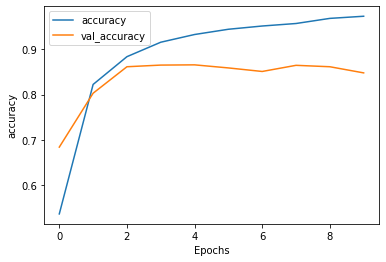

In [29]:
plot_graphs(history, 'accuracy')

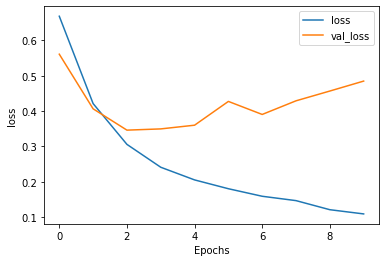

In [30]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
